# Permit-to-Occupancy in New York City

This notebook (along with files associated with it) examines the timeline of building construction to occupation in New York City.

## Introduction

### Construction Permit Process

Before a new building can begin construction it has to go through a long professional vetting process. The Department of Buildings (DOB) is the principal governmental organization responsible for overseeing the inspections and paperwork required for breaking ground. Once the construction permit has been issued and posted, work can begin.

### Certificate of Occupancy Process

The last step of new building construction is obtaining a certificate of occupancy ("C of O" for short). This document affirms that the building in question has been deemed to conform to the building code and is safe to occupy. 

A C of O is required for a building to be legally occupiable. DOB verifies with other coordinating agencies that all other outstanding requirements for the building have been satisfied before issuing the permit. Thus obtaining a C of O is the last step of the process in opening and occupying a building.

Most C of Os are permanent documents, however it is also possible to obtain an (expediated?) temporary document. Temporary C of Os have an expiration date, by which time a permanent document ought to have been granted. For our purposes we will treat them as equivalent documents.

### Retrieving Certificates of Occupancy

Certificates of Occupancy are publically available via the DOB [BIS interface](http://a810-bisweb.nyc.gov/bisweb/bsqpm01.jsp). This is an old interface and technically challenging to hook up to progammatically. Furthermore C of Os are stored as PDF documents, so access requires a pipeline for retrieving, loading, scanning, and parsing PDF text.

The `co_reader.py` module in this repository implements this capacity. For more technical notes on how that's done refer to that module's documentation.

### Retrieving Construction Permits

DOB releases a rolling list of all DOB construction permits filed as a publically accessible [dataset](https://data.cityofnewyork.us/Housing-Development/DOB-Permit-Issuance/ipu4-2q9a) on the New York City Open Data portal. Retrieving these permits is merely a matter of accessing, extracting, and filtering this dataset.

### Joining Permits to Certs

As expected, both the permits database and the certification pages are keyed by building `BIN`. However since the cert data requires a massive and long-running web scraping operation, the permit data is used as a base and the cert data is joined against it.

## Reading Construction Permit Data

The code below sets up our construction permit data.

In [1]:
import pandas as pd
import numpy as np
from __future__ import print_function

In [2]:
pd.set_option("max_columns", 500)

In [3]:
permits = pd.read_csv("DOB_Permit_Issuance.csv")

/Users/Honors/anaconda/envs/nyc-construction-timelines/lib/python2.7/site-packages/IPython/core/interactiveshell.py:2723: DtypeWarning: Columns (1,8,9,11,12,31,51) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
permits.sample(3)

,BOROUGH,Bin #,House #,Street Name,Job #,Job doc. #,Job Type,Self_Cert,Block,Lot,Community Board,Zip Code,Bldg Type,Residential,Special District 1,Special District 2,Work Type,Permit Status,Filing Status,Permit Type,Permit Sequence #,Permit Subtype,Oil Gas,Site Fill,Filing Date,Issuance Date,Expiration Date,Job Start Date,Permittee's First Name,Permittee's Last Name,Permittee's Business Name,Permittee's Phone #,Permittee's License Type,Permittee's License #,Act as Superintendent,Permittee's Other Title,HIC License,Site Safety Mgr's First Name,Site Safety Mgr's Last Name,Site Safety Mgr Business Name,Superintendent First & Last Name,Superintendent Business Name,Owner's Business Type,Non-Profit,Owner's Business Name,Owner's First Name,Owner's Last Name,Owner's House #,Owner's House Street Name,Owner’s House City,Owner’s House State,Owner’s House Zip Code,Owner's Phone #,DOBRunDate
178502,BROOKLYN,3324728,868,PARK AVENUE,320989784.0,1.0,A3,Y,1580,1,303,11206,2,YES,NaN,NaN,EQ,ISSUED,RENEWAL,EQ,2.0,SH,,NaN,05/22/2014,05/22/2014 12:00:00 AM,05/22/2015,03/28/2014,JASWANT,SINGH,VIKRANT CONTRACTING & BUI,7182060125,GENERAL CONTRACTOR,0034878,,,,,,,,,NYCHA,NaN,NYCHA,MARTHA,BRAZOBAN,90,CHURCH STREET,NEW YORK,NY,10007,2123062810,05/23/2014 12:00:00 AM
409864,MANHATTAN,1.07719e+06,160REAR,ORCHARD ST.,140398601.0,1.0,A2,Y,411,8,103,10002,2,YES,NaN,NaN,OT,ISSUED,INITIAL,EW,1.0,OT,,NOT APPLICABLE,09/03/2015,09/03/2015 12:00:00 AM,02/23/2016,09/03/2015,HAKMAN,IEONG,KINSUN CONSTRUCTION CONSU,7.18267e+09,GENERAL CONTRACTOR,0606549,,,,,,,,,INDIVIDUAL,NaN,BROWNSTONE MANAGEMENT,ROHIT,SAMAI,88,RIVINGTON ST.,NEW YORK,NY,10022,2124756660,09/04/2015 12:00:00 AM
470189,STATEN ISLAND,5022314,130,VISTA AVE,520260609.0,1.0,A2,Y,859,25,502,10304,2,YES,NaN,NaN,OT,ISSUED,INITIAL,EW,1.0,OT,,NOT APPLICABLE,12/18/2015,12/18/2015 12:00:00 AM,08/27/2016,12/18/2015,LABIB,KRUNFOL,KRUNFOL & KRUNFOL CONS CO,9178254223,GENERAL CONTRACTOR,0614793,,,,,,,,,INDIVIDUAL,NaN,N/A,SALAH,ALRWHANI,130,VISTA AVE,STATEN ISLAND,NY,10304,9174995965,12/28/2015 12:00:00 AM


Non-obvious column keys:

* Bin # &mdash; Building Identification Number
* Job # &mdash; The number assigned to the job in the DOB system.
* Job doc # &mdash; A single job, if the job is of a sufficient level of complexity, can have multiple permits associated with it (when this occurs is unclear to me, however).

  These documents are all (almost?) always approved at the same time, so for our purposes we may safely take only Job doc # == 1.
* Job Type &mdash; We want specifically records with `Job Type=NB` as these are new building construction jobs.
* Permit Type &mdash; We want specifically records with `NB`, again.
* Self_Cert &mdash; Whether or not the job was professionally certified (at the cost of the owner; expedites the approval process).
* Bldg Type &mdash; Unsure what this is, but it seems to be unimportant. Only options are 1, 2, and (occassionally) an empty string.
* Permit Status &mdash; Whether the permit has been issued (usually), re-issued (occassionally), or is in process of being issued (rare, temporal).

  This appears to mean specifically the physical documents.

  For our purposes we only want original issuances.
* Filing Status &mdash; Whether the permit filed is a renewal or an initial filing.

  This appears to mean the actual permit document.
  
  Obviously we only want initial filings.
* Permit Sequence # &mdash; the number of the permit, in terms of how many times it has been renewed or perhaps re-requested. As expected, 'Filing Status'=='INITAL' implies that 'Permit Sequent #' == 1.0.
* Permit Subtype &mdash; Unknown, may be [building type](http://www.parkeronline.org/DocumentCenter/View/16233). Mostly left empty regardless.
* Oil Gas &mdash; Always empty.
* Site Fill &mdash; Apparent dirt movage. Very important to our audience! Will investigate further along.
* Filing Date &mdash; Date that the permit was approved.
* Expiration Date &mdash; Exactly one year less a day from the filing date.

In [5]:
permits['Permit Status'].value_counts()

ISSUED        553319
RE-ISSUED       3245
IN PROCESS        53
Name: Permit Status, dtype: int64

In [6]:
permits['Filing Status'].value_counts()

INITIAL    380733
RENEWAL    175884
Name: Filing Status, dtype: int64

In [7]:
permits['Job doc. #'].value_counts()

1.0     499793
2.0      44227
3.0      10095
4.0       1653
5.0        608
6.0        140
7.0         62
8.0         27
9.0         10
10.0         2
Name: Job doc. #, dtype: int64

Applying the restrictions noted in our exploration of the dataset nets us our new building permits.

In [8]:
new_building_permits = permits[(permits['Job Type'] == 'NB') &
                               (permits['Permit Type'] == 'NB') &
                               (permits['Permit Status'] == 'ISSUED') & 
                               (permits['Filing Status'] == 'INITIAL') &
                               (permits['Job doc. #'] == 1.0)]

In [9]:
len(permits)

556644

In [10]:
len(new_building_permits)

6819

The trouble is that this set is still not fully de-duped.

These entries appear to be seperate filing, each of which resulted in a construction permit being granted!

In [11]:
from collections import Counter
from tqdm import tqdm

In [12]:
cnt = 0
for _bin in tqdm(set(new_building_permits['Bin #'])):
    if len(new_building_permits[new_building_permits['Bin #'] == _bin]) > 1:
        cnt += 1
print(cnt)

100%|██████████| 6136/6136 [00:17<00:00, 348.15it/s]

567


Our timeline will need to accomodate the possibility of multiple permits. Up to how many?

In [13]:
counter = Counter()
for _bin in tqdm(set(new_building_permits['Bin #'])):
    nbp_l = len(new_building_permits[new_building_permits['Bin #'] == _bin])
    if nbp_l > 1:
        counter[nbp_l] += 1
counter

100%|██████████| 6136/6136 [00:12<00:00, 508.82it/s]


Counter({2: 521, 3: 21, 4: 18, 5: 1, 6: 2, 8: 1, 13: 1, 17: 1, 18: 1})

Let's simply take the date of the earliest one.

In [8]:
import arrow

In [9]:
import time

In [16]:
def select_earliest_permit(df):
    return df.iloc[np.argmin(df['Filing Date'].apply(lambda x: arrow.get(x,"MM/DD/YYYY")).values)]

In [17]:
list_by_bin = []
for _bin in tqdm(set(new_building_permits['Bin #'])):
    df = new_building_permits[new_building_permits['Bin #'] == _bin]
    if len(df) > 1:
        # print(select_earliest_permit(df))
        list_by_bin.append(select_earliest_permit(df))
        # time.sleep(1)
    else:
        list_by_bin.append(df.iloc[0])

100%|██████████| 6136/6136 [00:15<00:00, 400.80it/s]


This step took a long time to figure out. By default it concats Series into one super-Series, but axis=1 puts things in the wrong place index-wise, so I have to swap the indexes with `T` (transpose).

In [18]:
deduped_new_building_permits = pd.concat(list_by_bin, axis=1).T

In [20]:
deduped_new_building_permits['BOROUGH'].value_counts()

QUEENS           1898
BROOKLYN         1890
STATEN ISLAND    1566
BRONX             486
MANHATTAN         296
Name: BOROUGH, dtype: int64

In [21]:
borough_map = {
    'BROOKLYN': 'B',
    'QUEENS': 'Q',
    'STATEN ISLAND': 'R',
    'BRONX': 'X',
    'MANHATTAN': 'M'
}

In [22]:
deduped_new_building_permits.head(5)['Bin #']

26416         2818049
168380        4292627
131159        3833881
535342    2.09719e+06
544547        5144619
Name: Bin #, dtype: object

In [23]:
deduped_new_building_permits.head(1)

,BOROUGH,Bin #,House #,Street Name,Job #,Job doc. #,Job Type,Self_Cert,Block,Lot,Community Board,Zip Code,Bldg Type,Residential,Special District 1,Special District 2,Work Type,Permit Status,Filing Status,Permit Type,Permit Sequence #,Permit Subtype,Oil Gas,Site Fill,Filing Date,Issuance Date,Expiration Date,Job Start Date,Permittee's First Name,Permittee's Last Name,Permittee's Business Name,Permittee's Phone #,Permittee's License Type,Permittee's License #,Act as Superintendent,Permittee's Other Title,HIC License,Site Safety Mgr's First Name,Site Safety Mgr's Last Name,Site Safety Mgr Business Name,Superintendent First & Last Name,Superintendent Business Name,Owner's Business Type,Non-Profit,Owner's Business Name,Owner's First Name,Owner's Last Name,Owner's House #,Owner's House Street Name,Owner’s House City,Owner’s House State,Owner’s House Zip Code,Owner's Phone #,DOBRunDate
26416,BRONX,2818049,92,WEST TREMONT AVE,2.20177e+08,1,NB,NaN,2867,125,205,10453,2,YES,NaN,NaN,,ISSUED,INITIAL,NB,1,,,ON-SITE,06/21/2013,06/21/2013 12:00:00 AM,03/20/2014,06/21/2013,JIMMY,ZERVOUDIS,GALAXY G.C.GROUP LLC,7186017000,GENERAL CONTRACTOR,0610672,,,,,,,PHILIP ANTONAKOS,GALAXY GENERAL CONTRACTIO,HPD,Y,HOUSING PRESERVATION AND DEVELOP,TIMOTHY,JOSEPH,100,GOLD STREET,NEW YORK,NY,10038,2128637490,06/22/2013 12:00:00 AM


## Reading Certificate of Occupation Data&mdash;August 2013 Test Run

In order to validate assumptions about the data pipeline I used (arbitrarily selected) August 2013 permits as a month of interest.

In [7]:
import co_reader

In [24]:
august_2013_permits = deduped_new_building_permits[deduped_new_building_permits['Filing Date'].map(lambda x: arrow.get(x,"MM/DD/YYYY").month == 9 and arrow.get(x,"MM/DD/YYYY").year == 2013)]

In [25]:
len(august_2013_permits)

186

In [26]:
c_of_o_dict = dict()
counter = 0
for ind in tqdm((august_2013_permits).iterrows()):
    print("On loop {0}...".format(counter + 1))
    boro = ind[1]['BOROUGH']
    bin = ind[1]['Bin #']
    boro_code = borough_map[boro]
    c_of_o_dict[bin] = co_reader.get_co_date(bin, boro_code)
    counter += 1

0it [00:00, ?it/s]

On loop 1...
Requested BIN 4162303 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning Q000214797.PDF...
PDF Certificate of Occupancy 'Q000214797.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/14/2014', '01/14/2014', '01/14/2014']
Date(s) found!
Scanning Q000085427.PDF...
PDF Certificate of Occupancy 'Q000085427.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/14/2014', '01/14/2014', '01/14/2014']
Date(s) found!
Scanning 420825673.PDF...
PDF Certificate of Occupancy '420825673.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/14/2014', '01/14/2014', '01/14/2014']
Date(s) found!
Scanning 420825263.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420825263.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420825263.PDF' retrieved.
Copying text using op

1it [00:27, 27.85s/it]

['01/14/2014', '01/14/2014', '01/14/2014']
Date(s) found!
On loop 2...
Requested BIN 1082214 data from BIS, awaiting response...


2it [00:38, 22.66s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 3...
Requested BIN 5047261 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520147984F.PDF...
PDF Certificate of Occupancy '520147984F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


3it [00:51, 19.87s/it]

['11/25/2014', '01/29/2015', '11/25/2014', '01/29/2015']
Date(s) found!
On loop 4...
Requested BIN 2000570 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning 220192887F.PDF...
PDF Certificate of Occupancy '220192887F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/25/2014', '01/29/2015', '11/25/2014', '01/29/2015']
Date(s) found!
Scanning 220192887T002.PDF...
PDF Certificate of Occupancy '220192887T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/25/2014', '01/29/2015', '11/25/2014', '01/29/2015']
Date(s) found!
Scanning 220192887.PDF...
PDF Certificate of Occupancy '220192887.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/25/2014', '01/29/2015', '11/25/2014', '01/29/2015']
Date(s) found!
Scanning 220192887T001.PDF...
PDF Certificate of Occupancy '220192887T001.PDF' retrieved.
Copying text using opti

4it [01:14, 20.84s/it]

['11/25/2014', '01/29/2015', '11/25/2014', '01/29/2015']
Date(s) found!
On loop 5...
Requested BIN 4163416 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000115527.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000115527.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000115527.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/09/2015', '03/09/2015', '06/07/2015', '06/07/2015']
Date(s) found!
Scanning 420849336T1.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420849336T1.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420849336T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/09/2015', '03/09/2015', '06/07/2015', '06/07/2015']
Date(s) found!
Scanning 420849345F.PDF...
PDF Certificate of Occupancy '420849345F.PDF' retriev

5it [01:58, 27.76s/it]

['03/09/2015', '03/09/2015', '06/07/2015', '06/07/2015']
Date(s) found!
On loop 6...
Requested BIN 2829340 data from BIS, awaiting response...


6it [02:09, 22.59s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 7...
Requested BIN 4163841 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420861482F.PDF...
PDF Certificate of Occupancy '420861482F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/14/2015', '07/14/2015', '07/14/2015']
Date(s) found!
Scanning 420861491.PDF...
PDF Certificate of Occupancy '420861491.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


7it [02:25, 20.62s/it]

['07/14/2015', '07/14/2015', '07/14/2015']
Date(s) found!
On loop 8...
Requested BIN 3410228 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320719585.PDF...
PDF Certificate of Occupancy '320719585.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


8it [02:39, 18.61s/it]

['07/14/2015', '07/14/2015', '07/14/2015']
Date(s) found!
On loop 9...
Requested BIN 4000093 data from BIS, awaiting response...


9it [02:49, 16.15s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 10...
Requested BIN 2829381 data from BIS, awaiting response...


10it [03:00, 14.42s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 11...
Requested BIN 1085940 data from BIS, awaiting response...


11it [03:10, 13.23s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 12...
Requested BIN 3807374 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000000790.PDF...
PDF Certificate of Occupancy 'B000000790.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/15/2015', '09/09/2015']
Date(s) found!
Scanning 320491115.PDF...
PDF Certificate of Occupancy '320491115.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


12it [03:26, 13.94s/it]

['04/15/2015', '09/09/2015']
Date(s) found!
On loop 13...
Requested BIN 4101093 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000152898.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000152898.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000152898.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/20/2016', '05/20/2016']
Date(s) found!
Scanning 420856229.PDF...
PDF Certificate of Occupancy '420856229.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


13it [04:41, 32.49s/it]

['05/20/2016', '05/20/2016']
Date(s) found!
On loop 14...
Requested BIN 4134801 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420629270F.PDF...
PDF Certificate of Occupancy '420629270F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/26/2014']
Date(s) found!
Scanning 420814596F.PDF...
PDF Certificate of Occupancy '420814596F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


14it [04:55, 26.97s/it]

['09/26/2014']
Date(s) found!
On loop 15...
Requested BIN 5861035 data from BIS, awaiting response...


15it [05:06, 22.04s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 16...
Requested BIN 4593965 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420821025F.PDF...
PDF Certificate of Occupancy '420821025F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


16it [05:20, 19.65s/it]

['11/06/2015', '11/06/2015']
Date(s) found!
On loop 17...
Requested BIN 4004803 data from BIS, awaiting response...


17it [05:31, 16.94s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 18...
Requested BIN 4004953 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000029501.PDF...
PDF Certificate of Occupancy 'Q000029501.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/25/2014', '04/25/2014', '04/25/2014']
Date(s) found!
Scanning Q000168574.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000168574.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000168574.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000168574.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


18it [06:07, 22.68s/it]

[]
No date found. Continuing...
On loop 19...
Requested BIN 1088829 data from BIS, awaiting response...


19it [06:17, 19.06s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 20...
Requested BIN 4529910 data from BIS, awaiting response...


20it [06:28, 16.44s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 21...
Requested BIN 1089321 data from BIS, awaiting response...


21it [06:38, 14.63s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 22...
Requested BIN 4464467 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420887927.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420887927.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420887927.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420887927.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


22it [07:03, 17.78s/it]

[]
No date found. Continuing...
On loop 23...
Requested BIN 3088244 data from BIS, awaiting response...
Got a response.
Discovered 11 Certificates of Occupancy.
Scanning B000218282.PDF...
PDF Certificate of Occupancy 'B000218282.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000121583.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000121583.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000121583.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['08/21/2014']
Date(s) found!
Scanning B000204812.PDF...
PDF Certificate of Occupancy 'B000204812.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['08/21/2014']
Date(s) found!
Scanning B000225341.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000225341.PDF' again in five seconds...
After so

23it [08:29, 38.08s/it]

[]
No date found. Continuing...
On loop 24...
Requested BIN 3851635 data from BIS, awaiting response...


24it [08:40, 30.00s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 25...
Requested BIN 2072797 data from BIS, awaiting response...


25it [08:50, 24.12s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 26...
Requested BIN 3398417 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320514234.PDF...
PDF Certificate of Occupancy '320514234.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


26it [09:01, 20.26s/it]

[]
No date found. Continuing...
On loop 27...
Requested BIN 4465392 data from BIS, awaiting response...


27it [09:12, 17.31s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 28...
Requested BIN 4465824 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420884760F.PDF...
PDF Certificate of Occupancy '420884760F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


28it [09:25, 16.10s/it]

['04/06/2016', '04/06/2016']
Date(s) found!
On loop 29...
Requested BIN 4465850 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420870454.PDF...
PDF Certificate of Occupancy '420870454.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


29it [09:38, 15.23s/it]

['04/06/2016', '04/06/2016']
Date(s) found!
On loop 30...
Requested BIN 4466104 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 401446440.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '401446440.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '401446440.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420877858F.PDF...


30it [10:01, 17.46s/it]

PDF Certificate of Occupancy '420877858F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 31...
Requested BIN 4466176 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420885714F.PDF...
PDF Certificate of Occupancy '420885714F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


31it [10:12, 15.55s/it]

[]
No date found. Continuing...
On loop 32...
Requested BIN 4466513 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000170483.PDF...
PDF Certificate of Occupancy 'Q000170483.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


32it [10:25, 14.87s/it]

['05/22/2014', '04/14/2015']
Date(s) found!
On loop 33...
Requested BIN 4466643 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420858423F.PDF...
PDF Certificate of Occupancy '420858423F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


33it [10:37, 13.76s/it]

[]
No date found. Continuing...
On loop 34...
Requested BIN 4466659 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420887909.PDF...
PDF Certificate of Occupancy '420887909.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


34it [10:47, 12.89s/it]

[]
No date found. Continuing...
On loop 35...
Requested BIN 4008028 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 420795820T002.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420795820T002.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420795820T002.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420795820T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420795820.PDF...
PDF Certificate of Occupancy '420795820.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420795820T1.PDF...


35it [11:12, 16.45s/it]

PDF Certificate of Occupancy '420795820T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 36...
Requested BIN 4565110 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420838972F.PDF...
PDF Certificate of Occupancy '420838972F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420838838F.PDF...
PDF Certificate of Occupancy '420838838F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


36it [11:25, 15.24s/it]

[]
No date found. Continuing...
On loop 37...
Requested BIN 4565111 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420838963F.PDF...
PDF Certificate of Occupancy '420838963F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420838829F.PDF...
PDF Certificate of Occupancy '420838829F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


37it [11:36, 14.07s/it]

[]
No date found. Continuing...
On loop 38...
Requested BIN 4565115 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420605303.PDF...
PDF Certificate of Occupancy '420605303.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420605303TCO1.PDF...
PDF Certificate of Occupancy '420605303TCO1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


38it [11:48, 13.32s/it]

[]
No date found. Continuing...
On loop 39...
Requested BIN 4040944 data from BIS, awaiting response...


39it [11:58, 12.44s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 40...
Requested BIN 3131104 data from BIS, awaiting response...


40it [12:08, 11.85s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 41...
Requested BIN 4467216 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420579662F.PDF...
PDF Certificate of Occupancy '420579662F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


41it [12:20, 11.82s/it]

[]
No date found. Continuing...
On loop 42...
Requested BIN 4008506 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000198673.PDF...
PDF Certificate of Occupancy 'Q000198673.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000198677.PDF...


42it [12:31, 11.55s/it]

PDF Certificate of Occupancy 'Q000198677.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 43...
Requested BIN 2829339 data from BIS, awaiting response...


43it [12:41, 11.21s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 44...
Requested BIN 2829341 data from BIS, awaiting response...


44it [12:52, 10.97s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 45...
Requested BIN 2829342 data from BIS, awaiting response...


45it [13:02, 10.81s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 46...
Requested BIN 2829372 data from BIS, awaiting response...


46it [13:13, 10.66s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 47...
Requested BIN 2829374 data from BIS, awaiting response...


47it [13:23, 10.67s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 48...
Requested BIN 2829375 data from BIS, awaiting response...


48it [13:34, 10.56s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 49...
Requested BIN 2829376 data from BIS, awaiting response...


49it [13:44, 10.47s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 50...
Requested BIN 2829377 data from BIS, awaiting response...


50it [13:54, 10.45s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 51...
Requested BIN 2829378 data from BIS, awaiting response...


51it [14:05, 10.43s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 52...
Requested BIN 2829379 data from BIS, awaiting response...


52it [14:15, 10.42s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 53...
Requested BIN 2829380 data from BIS, awaiting response...


53it [14:25, 10.42s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 54...
Requested BIN 2829382 data from BIS, awaiting response...


54it [14:36, 10.38s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 55...
Requested BIN 2829383 data from BIS, awaiting response...


55it [14:46, 10.39s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 56...
Requested BIN 2829384 data from BIS, awaiting response...


56it [14:57, 10.43s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 57...
Requested BIN 2829385 data from BIS, awaiting response...


57it [15:07, 10.40s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 58...
Requested BIN 4305516 data from BIS, awaiting response...


58it [15:17, 10.37s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 59...
Requested BIN 3137429 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320719594.PDF...
PDF Certificate of Occupancy '320719594.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


59it [15:29, 10.75s/it]

[]
No date found. Continuing...
On loop 60...
Requested BIN 4141752 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000086127.PDF...
PDF Certificate of Occupancy 'Q000086127.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


60it [15:41, 11.19s/it]

['09/09/2015', '09/09/2015', '11/10/2015', '11/10/2015']
Date(s) found!
On loop 61...
Requested BIN 2831362 data from BIS, awaiting response...


61it [15:52, 10.98s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 62...
Requested BIN 4306387 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000096706.PDF...
PDF Certificate of Occupancy 'Q000096706.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/09/2015', '09/09/2015', '11/10/2015', '11/10/2015']
Date(s) found!
Scanning 420862016.PDF...
PDF Certificate of Occupancy '420862016.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/09/2015', '09/09/2015', '11/10/2015', '11/10/2015']
Date(s) found!
Scanning 420862016F.PDF...
PDF Certificate of Occupancy '420862016F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


62it [16:09, 12.87s/it]

['09/09/2015', '09/09/2015', '11/10/2015', '11/10/2015']
Date(s) found!
On loop 63...
Requested BIN 5158554 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520125588F.PDF...
PDF Certificate of Occupancy '520125588F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


63it [16:21, 12.58s/it]

['09/09/2015', '09/09/2015']
Date(s) found!
On loop 64...
Requested BIN 5158555 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520125604F.PDF...
PDF Certificate of Occupancy '520125604F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


64it [16:32, 12.22s/it]

[]
No date found. Continuing...
On loop 65...
Requested BIN 5158556 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning R000001922.PDF...
PDF Certificate of Occupancy 'R000001922.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning R000001482.PDF...
PDF Certificate of Occupancy 'R000001482.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520125613F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520125613F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520125613F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


65it [16:55, 15.31s/it]

['09/03/2015']
Date(s) found!
On loop 66...
Requested BIN 4863747 data from BIS, awaiting response...


66it [17:05, 13.84s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 67...
Requested BIN 4044745 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420824255.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420824255.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420824255.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420824255.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


67it [17:29, 16.91s/it]

['09/03/2015', '09/03/2015']
Date(s) found!
On loop 68...
Requested BIN 5158989 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113840F.PDF...
PDF Certificate of Occupancy '520113840F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


68it [17:43, 15.93s/it]

['08/28/2015', '08/28/2015', '08/28/2015']
Date(s) found!
On loop 69...
Requested BIN 5159056 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113546F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520113546F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520113546F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


69it [18:01, 16.59s/it]

['04/30/2014', '04/30/2014', '04/30/2014']
Date(s) found!
On loop 70...
Requested BIN 5159058 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113528F.PDF...
PDF Certificate of Occupancy '520113528F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


70it [18:14, 15.53s/it]

['01/14/2014', '01/14/2014', '01/14/2014']
Date(s) found!
On loop 71...
Requested BIN 5159059 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113519F.PDF...
PDF Certificate of Occupancy '520113519F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


71it [18:26, 14.40s/it]

['01/14/2014', '01/14/2014', '01/14/2014']
Date(s) found!
On loop 72...
Requested BIN 5159060 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113500F.PDF...
PDF Certificate of Occupancy '520113500F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


72it [18:38, 13.82s/it]

['01/14/2014', '01/14/2014', '01/14/2014']
Date(s) found!
On loop 73...
Requested BIN 5159061 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113494F.PDF...
PDF Certificate of Occupancy '520113494F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


73it [18:51, 13.35s/it]

['12/31/2013', '12/31/2013', '12/31/2013', '12/31/2013']
Date(s) found!
On loop 74...
Requested BIN 5159118 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113831F.PDF...
PDF Certificate of Occupancy '520113831F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


74it [19:08, 14.44s/it]

['01/14/2014', '01/14/2014', '01/14/2014']
Date(s) found!
On loop 75...
Requested BIN 5159119 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113822F.PDF...
PDF Certificate of Occupancy '520113822F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


75it [19:20, 13.72s/it]

['04/30/2014', '04/30/2014', '04/30/2014']
Date(s) found!
On loop 76...
Requested BIN 5159120 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113813F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520113813F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520113813F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


76it [19:40, 15.63s/it]

['04/30/2014', '04/30/2014', '04/30/2014']
Date(s) found!
On loop 77...
Requested BIN 5159129 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113804F.PDF...
PDF Certificate of Occupancy '520113804F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


77it [19:53, 14.82s/it]

['04/30/2014', '04/30/2014', '04/30/2014']
Date(s) found!
On loop 78...
Requested BIN 5159130 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113797F.PDF...
PDF Certificate of Occupancy '520113797F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


78it [20:05, 14.01s/it]

['06/05/2014', '06/05/2014']
Date(s) found!
On loop 79...
Requested BIN 5159131 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113788F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520113788F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520113788F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


79it [20:25, 15.76s/it]

['04/30/2014', '04/30/2014', '04/30/2014']
Date(s) found!
On loop 80...
Requested BIN 5159132 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113779F.PDF...
PDF Certificate of Occupancy '520113779F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


80it [20:38, 15.04s/it]

['04/30/2014', '04/30/2014', '04/30/2014']
Date(s) found!
On loop 81...
Requested BIN 5159133 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113760F.PDF...
PDF Certificate of Occupancy '520113760F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


81it [20:51, 14.52s/it]

['04/30/2014', '04/30/2014', '04/30/2014']
Date(s) found!
On loop 82...
Requested BIN 5159134 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113751F.PDF...
PDF Certificate of Occupancy '520113751F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


82it [21:04, 14.10s/it]

['04/11/2014', '04/11/2014', '04/11/2014']
Date(s) found!
On loop 83...
Requested BIN 4864530 data from BIS, awaiting response...


83it [21:15, 13.16s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 84...
Requested BIN 3062376 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320545362.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320545362.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320545362.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320545362.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


84it [21:39, 16.27s/it]

['04/15/2014', '04/15/2014', '04/15/2014']
Date(s) found!
On loop 85...
Requested BIN 5159614 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 500520117F.PDF...
PDF Certificate of Occupancy '500520117F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/11/2015', '09/11/2015', '09/11/2015']
Date(s) found!
Scanning 500520117F.PDF...
PDF Certificate of Occupancy '500520117F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


85it [21:55, 16.10s/it]

['09/11/2015', '09/11/2015', '09/11/2015']
Date(s) found!
On loop 86...
Requested BIN 2800767 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220246240T001.PDF...
PDF Certificate of Occupancy '220246240T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


86it [22:07, 14.91s/it]

['09/11/2015', '09/11/2015', '09/11/2015']
Date(s) found!
On loop 87...
Requested BIN 4865460 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420291534.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420291534.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420291534.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


87it [22:25, 15.91s/it]

['05/19/2016', '05/19/2016', '08/17/2016', '08/17/2016', '15/19/2016']
No date found. Continuing...
On loop 88...
Requested BIN 4865462 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420291525.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420291525.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420291525.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


88it [22:43, 16.65s/it]

['01/19/2016', '01/19/2016', '01/19/2016']
Date(s) found!
On loop 89...
Requested BIN 5029412 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520145334F.PDF...
PDF Certificate of Occupancy '520145334F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


89it [22:56, 15.34s/it]

['01/21/2016', '01/21/2016', '01/21/2016']
Date(s) found!
On loop 90...
Requested BIN 3063353 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320375651.PDF...
PDF Certificate of Occupancy '320375651.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


90it [23:08, 14.53s/it]

['09/11/2014', '09/11/2014', '09/11/2014']
Date(s) found!
On loop 91...
Requested BIN 4538134 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420534372.PDF...
PDF Certificate of Occupancy '420534372.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/07/2015', '05/07/2015']
Date(s) found!
Scanning 420534372T1.PDF...
PDF Certificate of Occupancy '420534372T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


91it [23:23, 14.71s/it]

['05/07/2015', '05/07/2015']
Date(s) found!
On loop 92...
Requested BIN 4538167 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420778741F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420778741F.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420778741F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420778741F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


92it [23:47, 17.52s/it]

['07/01/2015', '07/01/2015', '09/29/2015', '09/29/2015']
Date(s) found!
On loop 93...
Requested BIN 5816196 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 520144567F.PDF...
PDF Certificate of Occupancy '520144567F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/03/2015', '04/03/2015']
Date(s) found!
Scanning 520180740F.PDF...
PDF Certificate of Occupancy '520180740F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


93it [24:01, 16.42s/it]

['04/03/2015', '04/03/2015']
Date(s) found!
On loop 94...
Requested BIN 3325861 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning B000214031.PDF...
PDF Certificate of Occupancy 'B000214031.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/25/2016', '01/25/2016']
Date(s) found!
Scanning B000113318.PDF...
PDF Certificate of Occupancy 'B000113318.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/25/2016', '01/25/2016']
Date(s) found!
Scanning B000214031.PDF...
PDF Certificate of Occupancy 'B000214031.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


94it [24:18, 16.63s/it]

['01/25/2016', '01/25/2016']
Date(s) found!
On loop 95...
Requested BIN 5062667 data from BIS, awaiting response...


95it [24:29, 14.79s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 96...
Requested BIN 4571598 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420856336F.PDF...
PDF Certificate of Occupancy '420856336F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/25/2016', '01/25/2016']
Date(s) found!
Scanning 420856121F.PDF...
PDF Certificate of Occupancy '420856121F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


96it [24:47, 15.68s/it]

['01/25/2016', '01/25/2016']
Date(s) found!
On loop 97...
Requested BIN 2016152 data from BIS, awaiting response...


97it [24:57, 14.16s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 98...
Requested BIN 5161894 data from BIS, awaiting response...


98it [25:08, 13.06s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 99...
Requested BIN 3851222 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320529530.PDF...
PDF Certificate of Occupancy '320529530.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


99it [25:23, 13.80s/it]

['06/11/2014', '06/11/2014', '06/11/2014']
Date(s) found!
On loop 100...
Requested BIN 2016441 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 220232175T001.PDF...
PDF Certificate of Occupancy '220232175T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/11/2014', '06/11/2014', '06/11/2014']
Date(s) found!
Scanning 220232175T003.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220232175T003.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '220232175T003.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/02/2015', '03/17/2016', '05/31/2015', '03/17/2016']
Date(s) found!
Scanning 220232175T004.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220232175T004.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '220232175T004.PDF' retrieved.
C

100it [26:09, 23.36s/it]

['03/02/2015', '03/17/2016', '05/31/2015', '03/17/2016']
Date(s) found!
On loop 101...
Requested BIN 5162170 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520148386F.PDF...
PDF Certificate of Occupancy '520148386F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


101it [26:23, 20.63s/it]

['06/11/2015', '06/11/2015', '09/09/2015', '09/09/2015', '26/11/2015']
No date found. Continuing...
On loop 102...
Requested BIN 5162171 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520148395F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520148395F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520148395F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


102it [26:43, 20.31s/it]

['09/25/2014', '09/25/2014', '09/25/2014']
Date(s) found!
On loop 103...
Requested BIN 5162176 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520144193F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520144193F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520144193F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


103it [27:03, 20.31s/it]

['07/17/2014', '07/17/2014', '07/17/2014']
Date(s) found!
On loop 104...
Requested BIN 5162207 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520148402F.PDF...
PDF Certificate of Occupancy '520148402F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


104it [27:16, 18.01s/it]

['05/02/2014', '05/02/2014']
Date(s) found!
On loop 105...
Requested BIN 5162208 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520148411F.PDF...
PDF Certificate of Occupancy '520148411F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


105it [27:28, 16.25s/it]

['08/07/2014', '08/07/2014']
Date(s) found!
On loop 106...
Requested BIN 5162334 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520147305F.PDF...
PDF Certificate of Occupancy '520147305F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


106it [27:41, 15.43s/it]

['09/12/2014', '09/12/2014', '09/12/2014']
Date(s) found!
On loop 107...
Requested BIN 5162529 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 520145290F.PDF...
PDF Certificate of Occupancy '520145290F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/25/2014', '03/25/2014', '03/25/2014']
Date(s) found!
Scanning 520145307F.PDF...
PDF Certificate of Occupancy '520145307F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/25/2014', '03/25/2014', '03/25/2014']
Date(s) found!
Scanning 520145290F.PDF...
PDF Certificate of Occupancy '520145290F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/25/2014', '03/25/2014', '03/25/2014']
Date(s) found!
Scanning 520145307F.PDF...
PDF Certificate of Occupancy '520145307F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


107it [28:01, 16.55s/it]

['03/25/2014', '03/25/2014', '03/25/2014']
Date(s) found!
On loop 108...
Requested BIN 3819111 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000089988.PDF...
PDF Certificate of Occupancy 'B000089988.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/20/2014', '11/20/2014', '11/20/2014', '11/20/2014']
Date(s) found!
Scanning 320529549.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320529549.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320529549.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


108it [28:22, 18.05s/it]

['11/20/2014', '11/20/2014', '11/20/2014', '11/20/2014']
Date(s) found!
On loop 109...
Requested BIN 3131134 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000211963.PDF...
PDF Certificate of Occupancy 'B000211963.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320723473.PDF...
PDF Certificate of Occupancy '320723473.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


109it [28:34, 16.33s/it]

[]
No date found. Continuing...
On loop 110...
Requested BIN 5857603 data from BIS, awaiting response...


110it [28:45, 14.61s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 111...
Requested BIN 4212792 data from BIS, awaiting response...


111it [28:56, 13.45s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 112...
Requested BIN 4442276 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning Q000193710.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000193710.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000193710.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/16/2016', '02/16/2016']
Date(s) found!
Scanning 420603644TCO1.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420603644TCO1.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420603644TCO1.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420603644TCO1.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420603644TCO1.PDF' retrieved.
Copying text using optical c

112it [29:56, 27.46s/it]

['02/16/2016', '02/16/2016']
Date(s) found!
On loop 113...
Requested BIN 3000634 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning B000115640.PDF...
PDF Certificate of Occupancy 'B000115640.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/16/2016', '02/16/2016']
Date(s) found!
Scanning B000194265.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000194265.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000194265.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/11/2016', '32/11/2016']
No date found. Continuing...
Scanning 320375991-01.PDF...
PDF Certificate of Occupancy '320375991-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


113it [30:28, 28.92s/it]

['02/11/2016', '32/11/2016']
No date found. Continuing...
On loop 114...
Requested BIN 5163451 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520147993F.PDF...
PDF Certificate of Occupancy '520147993F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


114it [30:43, 24.76s/it]

['02/11/2016', '32/11/2016']
No date found. Continuing...
On loop 115...
Requested BIN 4541524 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420534381F.PDF...
PDF Certificate of Occupancy '420534381F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/15/2015', '05/25/2016', '07/25/2016', '15/25/2016']
No date found. Continuing...
Scanning 420534381T1.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420534381T1.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420534381T1.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420534381T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


115it [31:12, 26.09s/it]

['04/15/2015', '05/25/2016', '07/25/2016', '15/25/2016']
No date found. Continuing...
On loop 116...
Requested BIN 2832138 data from BIS, awaiting response...


116it [31:23, 21.51s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 117...
Requested BIN 5164082 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520145343F.PDF...
PDF Certificate of Occupancy '520145343F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


117it [31:36, 18.96s/it]

['07/01/2015', '10/15/2015', '09/29/2015', '10/21/2015']
Date(s) found!
On loop 118...
Requested BIN 4541577 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000192971.PDF...
PDF Certificate of Occupancy 'Q000192971.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


118it [31:50, 17.28s/it]

['09/11/2014', '09/11/2014', '09/11/2014']
Date(s) found!
On loop 119...
Requested BIN 4541630 data from BIS, awaiting response...


119it [32:00, 15.29s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 120...
Requested BIN 3853611 data from BIS, awaiting response...


120it [32:11, 13.85s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 121...
Requested BIN 4214980 data from BIS, awaiting response...


121it [32:21, 12.86s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 122...
Requested BIN 4214981 data from BIS, awaiting response...


122it [32:33, 12.40s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 123...
Requested BIN 4542663 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 420605651TCO3.PDF...
PDF Certificate of Occupancy '420605651TCO3.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420605651T1.PDF...
PDF Certificate of Occupancy '420605651T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420605651T005.PDF...
PDF Certificate of Occupancy '420605651T005.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


123it [32:45, 12.44s/it]

[]
No date found. Continuing...
On loop 124...
Requested BIN 4542669 data from BIS, awaiting response...


124it [32:56, 11.87s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 125...
Requested BIN 4542710 data from BIS, awaiting response...


125it [33:07, 11.57s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 126...
Requested BIN 5158980 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520110291F.PDF...
PDF Certificate of Occupancy '520110291F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


126it [33:19, 11.83s/it]

[]
No date found. Continuing...
On loop 127...
Requested BIN 4542912 data from BIS, awaiting response...


127it [33:30, 11.50s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 128...
Requested BIN 5159057 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113537F.PDF...
PDF Certificate of Occupancy '520113537F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


128it [33:45, 12.53s/it]

['07/31/2014', '05/26/2016', '08/24/2016']
Date(s) found!
On loop 129...
Requested BIN 4117462 data from BIS, awaiting response...
Got a response.


129it [33:56, 12.06s/it]

Discovered 0 Certificates of Occupancy.
On loop 130...
Requested BIN 4543773 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420840594F.PDF...
PDF Certificate of Occupancy '420840594F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/14/2014', '01/14/2014', '01/14/2014']
Date(s) found!
Scanning 420814364F.PDF...
PDF Certificate of Occupancy '420814364F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


130it [34:11, 13.07s/it]

['01/14/2014', '01/14/2014', '01/14/2014']
Date(s) found!
On loop 131...
Requested BIN 2119001 data from BIS, awaiting response...


131it [34:22, 12.36s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 132...
Requested BIN 3856360 data from BIS, awaiting response...


132it [34:33, 11.91s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 133...
Requested BIN 4544604 data from BIS, awaiting response...


133it [34:43, 11.58s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 134...
Requested BIN 3398118 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320513191.PDF...
PDF Certificate of Occupancy '320513191.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


134it [34:58, 12.32s/it]

['06/18/2015', '06/18/2015', '06/18/2015']
Date(s) found!
On loop 135...
Requested BIN 3398258 data from BIS, awaiting response...


135it [35:08, 11.84s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 136...
Requested BIN 3398374 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320507778.PDF...
PDF Certificate of Occupancy '320507778.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/24/2014', '06/24/2014', '06/24/2014']
Date(s) found!
Scanning 320507778-01.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320507778-01.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320507778-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


136it [35:29, 14.37s/it]

['06/24/2014', '06/24/2014', '06/24/2014']
Date(s) found!
On loop 137...
Requested BIN 3398375 data from BIS, awaiting response...


137it [35:39, 13.24s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 138...
Requested BIN 3398428 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320467945.PDF...
PDF Certificate of Occupancy '320467945.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


138it [35:51, 12.98s/it]

['01/07/2016', '01/07/2016', '04/06/2016', '04/06/2016']
Date(s) found!
On loop 139...
Requested BIN 3398449 data from BIS, awaiting response...


139it [36:02, 12.23s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 140...
Requested BIN 1039598 data from BIS, awaiting response...


140it [36:12, 11.69s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 141...
Requested BIN 3399064 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320516465.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320516465.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320516465.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


141it [36:32, 13.99s/it]

['04/20/2016', '04/20/2016', '04/20/2016']
Date(s) found!
On loop 142...
Requested BIN 3399065 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320516492.PDF...
PDF Certificate of Occupancy '320516492.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


142it [36:45, 13.70s/it]

['08/20/2015', '08/20/2015', '08/20/2015']
Date(s) found!
On loop 143...
Requested BIN 3399066 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320516483.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320516483.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320516483.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


143it [37:03, 14.94s/it]

['08/28/2015', '08/28/2015', '08/28/2015']
Date(s) found!
On loop 144...
Requested BIN 3399067 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320516474.PDF...
PDF Certificate of Occupancy '320516474.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


144it [37:16, 14.35s/it]

['08/20/2015', '08/20/2015', '08/20/2015']
Date(s) found!
On loop 145...
Requested BIN 2055853 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning X000041777.PDF...
PDF Certificate of Occupancy 'X000041777.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


145it [37:27, 13.60s/it]

['08/27/2015', '08/27/2015', '08/27/2015']
Date(s) found!
On loop 146...
Requested BIN 4120329 data from BIS, awaiting response...


146it [37:38, 12.69s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 147...
Requested BIN 3182609 data from BIS, awaiting response...


147it [37:49, 12.15s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 148...
Requested BIN 5857593 data from BIS, awaiting response...


148it [38:00, 11.83s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 149...
Requested BIN 5857594 data from BIS, awaiting response...


149it [38:11, 11.48s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 150...
Requested BIN 5857595 data from BIS, awaiting response...


150it [38:23, 11.73s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 151...
Requested BIN 5857596 data from BIS, awaiting response...


151it [38:34, 11.42s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 152...
Requested BIN 5857597 data from BIS, awaiting response...


152it [38:45, 11.25s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 153...
Requested BIN 5857598 data from BIS, awaiting response...


153it [38:56, 11.41s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 154...
Requested BIN 5857599 data from BIS, awaiting response...


154it [39:07, 11.29s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 155...
Requested BIN 5857600 data from BIS, awaiting response...


155it [39:18, 11.18s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 156...
Requested BIN 5857601 data from BIS, awaiting response...


156it [39:29, 10.99s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 157...
Requested BIN 5857602 data from BIS, awaiting response...


157it [39:39, 10.88s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 158...
Requested BIN 4547155 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 410028312.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '410028312.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '410028312.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '410028312.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 410028312T1.PDF...
PDF Certificate of Occupancy '410028312T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420817147.PDF...
PDF Certificate of Occupancy '420817147.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


158it [40:06, 15.57s/it]

[]
No date found. Continuing...
On loop 159...
Requested BIN 4547156 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 410028303F.PDF...
PDF Certificate of Occupancy '410028303F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['08/12/2014', '08/12/2014', '08/12/2014']
Date(s) found!
Scanning 410028303TCO1.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '410028303TCO1.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '410028303TCO1.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '410028303TCO1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['08/12/2014', '08/12/2014', '08/12/2014']
Date(s) found!
Scanning 420817138F.PDF...
PDF Certificate of Occupancy '420817138F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...

159it [40:33, 19.03s/it]

['08/12/2014', '08/12/2014', '08/12/2014']
Date(s) found!
On loop 160...
Requested BIN 4121353 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420809664.PDF...
PDF Certificate of Occupancy '420809664.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['08/12/2014', '08/12/2014', '08/12/2014']
Date(s) found!
Scanning 420827181.PDF...
PDF Certificate of Occupancy '420827181.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


160it [40:46, 17.36s/it]

['08/12/2014', '08/12/2014', '08/12/2014']
Date(s) found!
On loop 161...
Requested BIN 3220959 data from BIS, awaiting response...


161it [40:57, 15.42s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 162...
Requested BIN 5858114 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520094576F.PDF...
PDF Certificate of Occupancy '520094576F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


162it [41:11, 14.78s/it]

['09/25/2014', '09/25/2014', '09/25/2014']
Date(s) found!
On loop 163...
Requested BIN 5858115 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520094585F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520094585F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520094585F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


163it [41:29, 15.75s/it]

['10/16/2014', '10/16/2014', '10/16/2014', '10/16/2014']
Date(s) found!
On loop 164...
Requested BIN 5858116 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520094594F.PDF...
PDF Certificate of Occupancy '520094594F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


164it [41:41, 14.58s/it]

['02/05/2015', '02/05/2015']
Date(s) found!
On loop 165...
Requested BIN 5034136 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning R000033235.PDF...
PDF Certificate of Occupancy 'R000033235.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/30/2015', '03/30/2015', '03/30/2015']
Date(s) found!
Scanning R500380483.PDF...
PDF Certificate of Occupancy 'R500380483.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


165it [41:56, 14.73s/it]

['03/30/2015', '03/30/2015', '03/30/2015']
Date(s) found!
On loop 166...
Requested BIN 5858216 data from BIS, awaiting response...


166it [42:06, 13.55s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 167...
Requested BIN 3827132 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320756151.PDF...
PDF Certificate of Occupancy '320756151.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


167it [42:21, 13.80s/it]

[]
No date found. Continuing...
On loop 168...
Requested BIN 4105868 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000057699.PDF...
PDF Certificate of Occupancy 'Q000057699.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['08/12/2014', '08/12/2014']
Date(s) found!
Scanning 420805597F.PDF...
PDF Certificate of Occupancy '420805597F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


168it [42:37, 14.67s/it]

['08/12/2014', '08/12/2014']
Date(s) found!
On loop 169...
Requested BIN 3140067 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000094805.PDF...
PDF Certificate of Occupancy 'B000094805.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['08/12/2014', '08/12/2014']
Date(s) found!
Scanning 320742381.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320742381.PDF' again in five seconds...


169it [42:59, 16.61s/it]

After some delay, PDF Certificate of Occupancy '320742381.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 170...
Requested BIN 4221547 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000088592.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000088592.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000088592.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000088592.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000088592.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


170it [43:42, 24.70s/it]

['07/21/2015', '07/21/2015', '07/21/2015']
Date(s) found!
On loop 171...
Requested BIN 3107718 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000230624.PDF...
PDF Certificate of Occupancy 'B000230624.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


171it [43:56, 21.53s/it]

['07/21/2015', '07/21/2015', '07/21/2015']
Date(s) found!
On loop 172...
Requested BIN 5860463 data from BIS, awaiting response...


172it [44:07, 18.26s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 173...
Requested BIN 5860484 data from BIS, awaiting response...


173it [44:18, 15.97s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 174...
Requested BIN 3402929 data from BIS, awaiting response...


174it [44:28, 14.37s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 175...
Requested BIN 3402993 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320756160.PDF...
PDF Certificate of Occupancy '320756160.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


175it [44:40, 13.53s/it]

[]
No date found. Continuing...
On loop 176...
Requested BIN 5861033 data from BIS, awaiting response...


176it [44:50, 12.68s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 177...
Requested BIN 5861034 data from BIS, awaiting response...


177it [45:02, 12.26s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 178...
Requested BIN 5041922 data from BIS, awaiting response...


178it [45:12, 11.74s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 179...
Requested BIN 5861663 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520161128F.PDF...
PDF Certificate of Occupancy '520161128F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


179it [45:25, 12.05s/it]

['08/01/2014', '08/01/2014']
Date(s) found!
On loop 180...
Requested BIN 1078240 data from BIS, awaiting response...
Got a response.
Discovered 7 Certificates of Occupancy.
Scanning M000012721.PDF...
PDF Certificate of Occupancy 'M000012721.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/19/2016', '02/19/2016', '02/19/2016']
Date(s) found!
Scanning M000014373.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000014373.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000014373.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'M000014373.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/19/2016', '02/19/2016', '02/19/2016']
Date(s) found!
Scanning M000014638.PDF...
PDF Certificate of Occupancy 'M000014638.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...

180it [46:22, 25.52s/it]

['02/19/2016', '02/19/2016', '02/19/2016']
Date(s) found!
On loop 181...
Requested BIN 4155560 data from BIS, awaiting response...


181it [46:33, 21.07s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 182...
Requested BIN 4224102 data from BIS, awaiting response...


182it [46:44, 18.07s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 183...
Requested BIN 5863056 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520094601F.PDF...
PDF Certificate of Occupancy '520094601F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


183it [47:03, 18.33s/it]

['02/19/2016', '02/19/2016', '02/19/2016']
Date(s) found!
On loop 184...
Requested BIN 5044235 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520125597F.PDF...
PDF Certificate of Occupancy '520125597F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


184it [47:22, 18.55s/it]

['02/19/2016', '02/19/2016', '02/19/2016']
Date(s) found!
On loop 185...
Requested BIN 4159853 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420621456F.PDF...
PDF Certificate of Occupancy '420621456F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


185it [47:41, 18.77s/it]

['02/19/2016', '02/19/2016', '02/19/2016']
Date(s) found!
On loop 186...
Requested BIN 1080831 data from BIS, awaiting response...
Got a response.
Discovered 6 Certificates of Occupancy.
Scanning M000074762.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000074762.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'M000074762.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/15/2014']
Date(s) found!
Scanning 121325495-02.PDF...
PDF Certificate of Occupancy '121325495-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/15/2014']
Date(s) found!
Scanning 121325495-05.PDF...
PDF Certificate of Occupancy '121325495-05.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/15/2014']
Date(s) found!
Scanning 121325495-04.PDF...
PDF Certificate of Occupancy '121325495-04.PDF' retrieved.
Copying text using optical c

186it [48:46, 32.53s/it]

['07/15/2014']
Date(s) found!


In [29]:
c_of_o_dict

{1039598: None,
 1078240: datetime.datetime(2016, 2, 19, 0, 0, tzinfo=tzutc()),
 1080831: datetime.datetime(2014, 7, 15, 0, 0, tzinfo=tzutc()),
 1082214: None,
 1085940: None,
 1088829: None,
 1089321: None,
 2000570: datetime.datetime(2014, 11, 25, 0, 0, tzinfo=tzutc()),
 2016152: None,
 2016441: datetime.datetime(2015, 3, 2, 0, 0, tzinfo=tzutc()),
 2055853: datetime.datetime(2015, 8, 27, 0, 0, tzinfo=tzutc()),
 2072797: None,
 2119001: None,
 2800767: datetime.datetime(2015, 9, 11, 0, 0, tzinfo=tzutc()),
 2829339: None,
 2829340: None,
 2829341: None,
 2829342: None,
 2829372: None,
 2829374: None,
 2829375: None,
 2829376: None,
 2829377: None,
 2829378: None,
 2829379: None,
 2829380: None,
 2829381: None,
 2829382: None,
 2829383: None,
 2829384: None,
 2829385: None,
 2831362: None,
 2832138: None,
 3000634: datetime.datetime(2016, 2, 16, 0, 0, tzinfo=tzutc()),
 3062376: datetime.datetime(2014, 4, 15, 0, 0, tzinfo=tzutc()),
 3063353: datetime.datetime(2014, 9, 11, 0, 0, tzinfo=tz

In [35]:
len([date for (bin, date) in c_of_o_dict.items() if date != None])

85

### Data validation check

186 new building construction permits were issued in August 2013. As of late June 2016, 85 of these have corresponding certificates of occupancy on record. This correspondgs with a `85/186 = ~45%` completion rate.

85*12=1020, so this data implies that in New York City there are around 2000 new building construction permits are issued per year, of which 1000 new buildings are completed per year.

Is this figure reasonable? [According to the DOB component of the Mayor's Management Report](http://www1.nyc.gov/assets/operations/downloads/pdf/pmmr2016/dob.pdf), a typical financial year in New York City sees the issuance of approximately 5,500 certificates of occupancy. This implies that approximately one in five certificates issued are for new buildings, while the remaining four in five certificates issued are for significantly renovated existing ones.

As a gut check, this seems reasonable.

### Notes on the algorithm

As expected this process of mining PDF pages is fairly slow. Still, the algorithm ran faster than expected, generating 186 results in 48 minutes, 46 seconds.

This corresponds to an average runtime of approximately 16 seconds per bin.

Fast failures occur in approximately 12 seconds. Documents with many documents to scan take approximately 20 seconds. 

Hitting a wait page extends the wait time 5 seconds apiece.

The worst case response took 32 seconds. The best case response took 10.

The full dataset contains 6136 bins, corresponding with a runtime of approximately 27.3 hours. A conversation must be had to verify that such a thing is necessary before a pull of such a magnitude be attempted.

In [73]:
sample['Bin #'].map(lambda x: c_of_o_dict[x]).values[0]

numpy.datetime64('2014-01-14T00:00:00.000000000')

In [83]:
sample = august_2013_permits.copy()
sample['Certificate Date'] = sample['Bin #'].map(lambda x: c_of_o_dict[x]).values
sample['Filing Date'] = sample['Filing Date'].map(lambda x: np.datetime64(arrow.get(x,"MM/DD/YYYY").datetime))
sample['Build Time'] = sample.apply(lambda srs: srs['Certificate Date'] - srs['Filing Date'], axis='columns')

/Users/Honors/anaconda/envs/nyc-construction-timelines/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  app.launch_new_instance()


### Sample analysis

Our initial sample is of a very small sample size, but it's still useful to see a few quick things.

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [99]:
pier = sample['Build Time'].map(lambda v: pd.isnull(v)).value_counts()
pier.index = ['Built', 'Not Built']
pier.name = ''

#### August 2013&mdash;June 2016 newly permitted construction completion rate

What percentage of construction permits issued in August of 2013 resulted in completed buildings as of today?

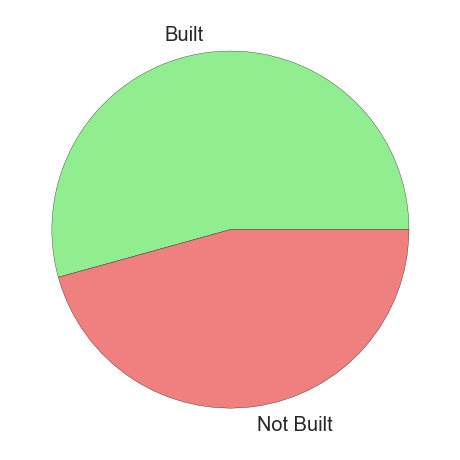

In [132]:
pier.plot(kind='pie', figsize=(8,8), fontsize=20, colors=('lightgreen', 'lightcoral')) # title='August 2013 Newly Permitted Construction')

#### August 2013&mdash;June 2016 newly permitted construction completion times

When did buildings with construction permits issued in August of 2013 actually complete?

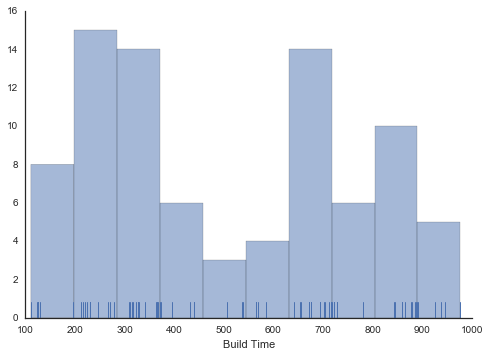

In [131]:
sns.set_style('white')
sns.distplot(sample['Build Time'][sample['Build Time'].notnull()].map(lambda t: t.days),
             bins=10,
             kde=False,
             rug=True,
             hist_kws={'alpha': 0.5},
            )
sns.despine()

The lack of a discernable pattern in this data is surprising, but may simply be the result of a small sample size (with 86 data point in 10 bins, there are just 8.6 observations per bin). To take this further, a larger sample or a full run must be taken.

#### Archiving the data

In [140]:
deduped_new_building_permits.to_csv("new_building_permits.csv")
sample.to_csv("august_2013_sample.csv")

## Briefly&mdash;Site Fill

The following data looks interesting. Perhaps it should be the target of further analysis?

In [135]:
deduped_new_building_permits['Site Fill'].value_counts()

ON-SITE                                     3615
USE UNDER 300 CU.YD                         1805
OFF-SITE                                     701
NONE                                          15
Name: Site Fill, dtype: int64

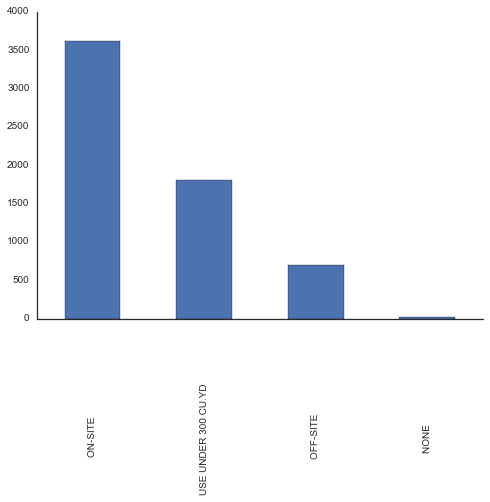

In [138]:
deduped_new_building_permits['Site Fill'].value_counts().plot(kind='bar')
sns.despine()

## Reading Certificate of Occupation Data&mdash;Partial Run

The full algorithm takes over a day to run, so I broke it up into intermediate nightly steps.

The run was ammended into a partial one partway through.

### Briefly&mdash;Examining Yearly Counts

In [1]:
import pandas as pd
import seaborn as sns
import arrow
%matplotlib inline

In [2]:
deduped_new_building_permits = pd.read_csv("new_building_permits.csv")

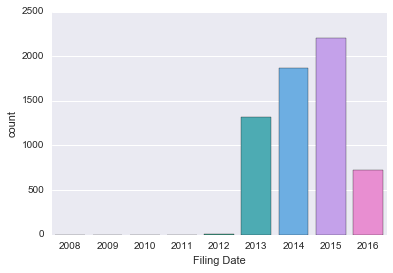

In [9]:
years = deduped_new_building_permits['Filing Date'].map(lambda x: arrow.get(x,"MM/DD/YYYY").year)
sns.countplot(years)

In [7]:
deduped_new_building_permits['Year'] = deduped_new_building_permits['Filing Date'].map(lambda x: arrow.get(x,"MM/DD/YYYY").year)

In [7]:
deduped_new_building_permits[deduped_new_building_permits['Year'] == 2008]

,Unnamed: 0,BOROUGH,Bin #,House #,Street Name,Job #,Job doc. #,Job Type,Self_Cert,Block,...,Owner's First Name,Owner's Last Name,Owner's House #,Owner's House Street Name,Owner’s House City,Owner’s House State,Owner’s House Zip Code,Owner's Phone #,DOBRunDate,Year
4078,336988,BROOKLYN,3855241.0,12749,FLATLANDS AVENUE,302322948.0,1.0,NB,Y,4566.0,...,JOHN,O'CONNELL,85-25,68 ROAD,REGO PARK,NY,11374.0,9.175778e+09,04/30/2015 12:00:00 AM,2008


This entry exhibits that the leading years in the dataset are for permits which had an extremely long lag time between filing and issuance, for unknown reasons.

### Algorithm

In [3]:
from tqdm import tqdm
import numpy as np
import co_reader

In [4]:
def co_run(df):
    borough_map = {
        'BROOKLYN': 'B',
        'QUEENS': 'Q',
        'STATEN ISLAND': 'R',
        'BRONX': 'X',
        'MANHATTAN': 'M'
    }
    c_of_o_dict = dict()
    counter = 0
    for ind in tqdm((df).iterrows()):
        print("On loop {0}...".format(counter + 1))
        boro = ind[1]['BOROUGH']
        bin = ind[1]['Bin #']
        boro_code = borough_map[boro]
        c_of_o_dict[bin] = co_reader.get_co_date(bin, boro_code)
        counter += 1
    sample = df.copy()
    sample['Certificate Date'] = sample['Bin #'].map(lambda x: c_of_o_dict[x]).values
    sample['Filing Date'] = sample['Filing Date'].map(lambda x: np.datetime64(arrow.get(x,"MM/DD/YYYY").datetime))
    sample['Build Time'] = sample.apply(lambda srs: srs['Certificate Date'] - srs['Filing Date'], axis='columns')
    return sample

In [17]:
# test_run_result = co_run(permits_2008_to_2013.sample(2))

In [18]:
# test_run_result

### Diversion&mdash;`co_reader` Redesign

When I ran the `co_reader` algorithm on the test set it exhibited one kind of behavior. When I ran it again a week later on the real thing, with an estimated leg time of 6 hours for the first set (permits issued prior to 2013), it exhibited another entirely.

The issue&mdash;which appeared to be present at the time of the previous run as well&mdash;is that the `subprocess.Popen` calls that I make inside of my code spawn `python2.7` child processes, which in turn spawn `tesseract` child processes. These processes finish their actual jobs very quickly, as expected, but do not finish running very quickly, hanging around instead as [zombie processes](https://en.wikipedia.org/wiki/Zombie_process).

Waiting for them to quit using `Popen.wait` forces wait times in excess of two minutes per document, a completely unacceptable state of affairs. If I were to run the entire dataset through at that speed I could expect a month's wait for it to finish executing!

The only way to force these threads to die, really die, if we do not wait for them explicitly, is to restart the entire computer. No program or Python module can force them to quit because they can only be killed by killing their live root parent, and their live root parent is the original Python execution&mdash;this notebook's process. In other words the only way to kill the zombie army is to terminate the executing notebook's own kernel!

The test run appears to have been successful only because the number of subprocesses spawned did not exceed my computer's inherent thread limit, due to the small size of the sample.

Amazingly, however, another thing also seems to have changed. The original implementation of the algorithm required running the PDFs through an OCR processer because the files themselves were read-locked. However, when the algo is run again a week later it appears that the read-locking has been removed.

Thus I can avoid all of the issues above by simply not using OCR in the first place.

It's all very strange. But it works.

In [8]:
permits_2008_to_2013 = deduped_new_building_permits[deduped_new_building_permits['Year'] <= 2013]
permits_2014 = deduped_new_building_permits[deduped_new_building_permits['Year'] == 2014]
permits_2015 = deduped_new_building_permits[deduped_new_building_permits['Year'] == 2015]
permits_2016 = deduped_new_building_permits[deduped_new_building_permits['Year'] == 2016]

In [13]:
len(permits_2008_to_2013), len(permits_2014), len(permits_2015), len(permits_2016)

(1332, 1869, 2207, 728)

### Leg 1&mdash;2008 to 2013

This leg was successfully run overnight on July 2/3, 2016.

In [9]:
leg_2008_to_2013 = co_run(permits_2008_to_2013)

0it [00:00, ?it/s]

On loop 1...
Requested BIN 2818049.0 data from BIS, awaiting response...
Got a response.
Discovered 8 Certificates of Occupancy.
Scanning X000000627.PDF...
PDF Certificate of Occupancy 'X000000627.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000004013.PDF...
PDF Certificate of Occupancy 'X000004013.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000027982.PDF...
After some delay, PDF Certificate of Occupancy 'X000027982.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000037234.PDF...
PDF Certificate of Occupancy 'X000037234.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 220177350F.PDF...
PDF Certificate of Occupancy '220177350F.PDF' retrieved.
Copying text usin

1it [00:20, 20.09s/it]

['07/01/2015', '09/29/2015']
Date(s) found!
On loop 2...
Requested BIN 1015907.0 data from BIS, awaiting response...
Got a response.
Discovered 6 Certificates of Occupancy.
Scanning M000005305.PDF...
PDF Certificate of Occupancy 'M000005305.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M00005305A.PDF...
Error attempting to retrieve PDF Certificate of Occupancy 'M00005305A.PDF'!
This is a serious but non-fatal error indicating an error in our filename reverse engineering.
Scanning 121182479-03.PDF...
PDF Certificate of Occupancy '121182479-03.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/11/2016', '05/11/2016']
Date(s) found!
Scanning 121182479T001.PDF...
PDF Certificate of Occupancy '121182479T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 121182479-04.PDF...
PDF Certificat

2it [00:37, 19.21s/it]

['11/17/2015', '02/15/2016', '11/17/2015']
Date(s) found!
On loop 3...
Requested BIN 3244288.0 data from BIS, awaiting response...


3it [00:48, 16.82s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 4...
Requested BIN 4292874.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420236159.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420236159.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420236159.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/01/2016']
Date(s) found!
Scanning 420236168.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420236168.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420236168.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


4it [01:12, 19.06s/it]

['02/01/2016']
Date(s) found!
On loop 5...
Requested BIN 4096357.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning Q000107335.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000107335.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000107335.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420795802F.PDF...
PDF Certificate of Occupancy '420795802F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/04/2015']
Date(s) found!
Scanning 420795107F.PDF...
PDF Certificate of Occupancy '420795107F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/04/2015']
Date(s) found!
Scanning 420795107.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420795107.PDF' again in five seconds...


5it [01:46, 23.56s/it]

After some delay, PDF Certificate of Occupancy '420795107.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 6...
Requested BIN 3834224.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000117613.PDF...
PDF Certificate of Occupancy 'B000117613.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320761733.PDF...
PDF Certificate of Occupancy '320761733.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


6it [01:59, 20.16s/it]

['05/11/2015']
Date(s) found!
On loop 7...
Requested BIN 3178893.0 data from BIS, awaiting response...


7it [02:10, 17.41s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 8...
Requested BIN 3834363.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320784111.PDF...
PDF Certificate of Occupancy '320784111.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


8it [02:21, 15.77s/it]

['12/15/2015', '12/15/2015']
Date(s) found!
On loop 9...
Requested BIN 3839417.0 data from BIS, awaiting response...


9it [02:33, 14.43s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 10...
Requested BIN 2097766.0 data from BIS, awaiting response...
Got a response.
Discovered 15 Certificates of Occupancy.
Scanning X000002720.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'X000002720.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'X000002720.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000002717.PDF...
PDF Certificate of Occupancy 'X000002717.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000002717-25.PDF...
PDF Certificate of Occupancy 'X000002717-25.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000002718.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'X000002718.PD

10it [03:17, 23.48s/it]

['10/06/2014', '01/04/2015']
Date(s) found!
On loop 11...
Requested BIN 2818701.0 data from BIS, awaiting response...
Got a response.
Discovered 8 Certificates of Occupancy.
Scanning X000000392.PDF...
PDF Certificate of Occupancy 'X000000392.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000000287.PDF...
PDF Certificate of Occupancy 'X000000287.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000000287-23.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'X000000287-23.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'X000000287-23.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000047474.PDF...
PDF Certificate of Occupancy 'X000047474.PDF' retrieved.
Copying text using optical character r

11it [04:06, 31.15s/it]

['02/09/2015']
Date(s) found!
On loop 12...
Requested BIN 3179162.0 data from BIS, awaiting response...


12it [04:17, 24.99s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 13...
Requested BIN 5860124.0 data from BIS, awaiting response...


13it [04:28, 20.65s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 14...
Requested BIN 5860125.0 data from BIS, awaiting response...


14it [04:39, 17.74s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 15...
Requested BIN 4162303.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning Q000214797.PDF...
PDF Certificate of Occupancy 'Q000214797.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000085427.PDF...
PDF Certificate of Occupancy 'Q000085427.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420825673.PDF...
After some delay, PDF Certificate of Occupancy '420825673.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420825263.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420825263.PDF' again in five seconds...


15it [04:59, 18.41s/it]

After some delay, PDF Certificate of Occupancy '420825263.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 16...
Requested BIN 1082214.0 data from BIS, awaiting response...


16it [05:10, 16.24s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 17...
Requested BIN 4129670.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420370681F.PDF...
PDF Certificate of Occupancy '420370681F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


17it [05:22, 14.97s/it]

['08/14/2014']
Date(s) found!
On loop 18...
Requested BIN 5047261.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520147984F.PDF...
PDF Certificate of Occupancy '520147984F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


18it [05:33, 13.85s/it]

['04/15/2015']
Date(s) found!
On loop 19...
Requested BIN 4129758.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420814346F.PDF...
PDF Certificate of Occupancy '420814346F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420840576F.PDF...
PDF Certificate of Occupancy '420840576F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


19it [05:45, 13.28s/it]

[]
No date found. Continuing...
On loop 20...
Requested BIN 3245159.0 data from BIS, awaiting response...
Got a response.
Discovered 48 Certificates of Occupancy.
Scanning B000104367.PDF...
PDF Certificate of Occupancy 'B000104367.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000112138.PDF...
PDF Certificate of Occupancy 'B000112138.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000105114.PDF...
PDF Certificate of Occupancy 'B000105114.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000117316.PDF...
PDF Certificate of Occupancy 'B000117316.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000101399.PDF...
Got the wait page. Trying to retrieve the PDF Certificate 

20it [08:47, 63.98s/it]

['12/14/2015', '03/13/2016', '12/14/2015']
Date(s) found!
On loop 21...
Requested BIN 1017014.0 data from BIS, awaiting response...
Got a response.
Discovered 14 Certificates of Occupancy.
Scanning M000027411.PDF...
PDF Certificate of Occupancy 'M000027411.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000004382.PDF...
PDF Certificate of Occupancy 'M000004382.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000004571.PDF...
PDF Certificate of Occupancy 'M000004571.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 121331291-06.PDF...
PDF Certificate of Occupancy '121331291-06.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/09/2016', '05/09/2016']
Date(s) found!
Scanning 121331291T004.PDF...
PDF Certifica

21it [09:21, 55.08s/it]

['06/22/2016', '09/20/2016']
Date(s) found!
On loop 22...
Requested BIN 1803540.0 data from BIS, awaiting response...


22it [09:32, 41.86s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 23...
Requested BIN 5080464.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 510003381F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '510003381F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '510003381F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


23it [09:50, 34.65s/it]

['03/26/2013']
Date(s) found!
On loop 24...
Requested BIN 4031902.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420779116.PDF...
PDF Certificate of Occupancy '420779116.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


24it [10:01, 27.53s/it]

[]
No date found. Continuing...
On loop 25...
Requested BIN 3048981.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 320763615.PDF...
PDF Certificate of Occupancy '320763615.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/21/2015']
Date(s) found!
Scanning 320763615-02.PDF...
PDF Certificate of Occupancy '320763615-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320763615-01.PDF...
PDF Certificate of Occupancy '320763615-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


25it [10:15, 23.27s/it]

[]
No date found. Continuing...
On loop 26...
Requested BIN 5047941.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning R000009684.PDF...
PDF Certificate of Occupancy 'R000009684.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520129076F.PDF...
PDF Certificate of Occupancy '520129076F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


26it [10:28, 20.36s/it]

['11/13/2014', '11/13/2014']
Date(s) found!
On loop 27...
Requested BIN 1083034.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 121182530-02.PDF...
PDF Certificate of Occupancy '121182530-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/07/2016', '07/06/2016']
Date(s) found!
Scanning 121182530-03.PDF...
PDF Certificate of Occupancy '121182530-03.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/29/2016', '09/27/2016']
Date(s) found!
Scanning 121182530T001.PDF...


27it [10:44, 18.94s/it]

PDF Certificate of Occupancy '121182530T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 28...
Requested BIN 3409567.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320786020.PDF...
PDF Certificate of Occupancy '320786020.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


28it [10:56, 16.92s/it]

['10/16/2015', '10/16/2015']
Date(s) found!
On loop 29...
Requested BIN 2000570.0 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning 220192887F.PDF...
PDF Certificate of Occupancy '220192887F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/07/2015']
Date(s) found!
Scanning 220192887T002.PDF...
PDF Certificate of Occupancy '220192887T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/08/2014', '03/08/2015']
Date(s) found!
Scanning 220192887.PDF...
PDF Certificate of Occupancy '220192887.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/07/2015']
Date(s) found!
Scanning 220192887T001.PDF...
PDF Certificate of Occupancy '220192887T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/16/2014', '12/15/2014']
Date(s) found!
Scanning 220192887T003.PDF...
PDF Certificat

29it [11:11, 16.29s/it]

['03/09/2015', '06/07/2015']
Date(s) found!
On loop 30...
Requested BIN 4163267.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning Q000099222.PDF...
PDF Certificate of Occupancy 'Q000099222.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420857969F.PDF...
PDF Certificate of Occupancy '420857969F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['08/03/2015']
Date(s) found!
Scanning 420857950T1.PDF...
PDF Certificate of Occupancy '420857950T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/24/2015', '10/22/2015']
Date(s) found!
Scanning 420857950F.PDF...
PDF Certificate of Occupancy '420857950F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


30it [11:24, 15.34s/it]

['08/03/2015']
Date(s) found!
On loop 31...
Requested BIN 3245817.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000128873.PDF...
PDF Certificate of Occupancy 'B000128873.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320617971.PDF...
PDF Certificate of Occupancy '320617971.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


31it [11:38, 15.02s/it]

['07/08/2015']
Date(s) found!
On loop 32...
Requested BIN 4163356.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000069056.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000069056.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000069056.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420835788F.PDF...
PDF Certificate of Occupancy '420835788F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420860223.PDF...


32it [12:00, 17.07s/it]

PDF Certificate of Occupancy '420860223.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 33...
Requested BIN 4163402.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000069030.PDF...
PDF Certificate of Occupancy 'Q000069030.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420302292.PDF...
PDF Certificate of Occupancy '420302292.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/21/2015']
Date(s) found!
Scanning 420319916F.PDF...
PDF Certificate of Occupancy '420319916F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


33it [12:14, 16.25s/it]

['04/21/2015']
Date(s) found!
On loop 34...
Requested BIN 4163416.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000115527.PDF...
PDF Certificate of Occupancy 'Q000115527.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420849336T1.PDF...
PDF Certificate of Occupancy '420849336T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/17/2015', '10/15/2015']
Date(s) found!
Scanning 420849345F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420849345F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420849345F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


34it [12:34, 17.35s/it]

['07/14/2015']
Date(s) found!
On loop 35...
Requested BIN 4163419.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning Q000066135.PDF...
PDF Certificate of Occupancy 'Q000066135.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q401265251.PDF...
PDF Certificate of Occupancy 'Q401265251.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420806328F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420806328F.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420806328F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420806328F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/06/2016']
Date(s) found!
Scanning 420808530F.PDF...
PDF Cer

35it [13:00, 19.75s/it]

['06/06/2016']
Date(s) found!
On loop 36...
Requested BIN 4163489.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000097895.PDF...
PDF Certificate of Occupancy 'Q000097895.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420840781.PDF...
PDF Certificate of Occupancy '420840781.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['10/21/2015', '10/21/2015']
Date(s) found!
Scanning 420823014.PDF...
PDF Certificate of Occupancy '420823014.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


36it [13:13, 17.73s/it]

['10/30/2015', '10/30/2015']
Date(s) found!
On loop 37...
Requested BIN 4163490.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000097936.PDF...
PDF Certificate of Occupancy 'Q000097936.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420839123F.PDF...
PDF Certificate of Occupancy '420839123F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


37it [13:25, 16.09s/it]

['10/15/2015', '10/15/2015']
Date(s) found!
On loop 38...
Requested BIN 4163744.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000073072.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000073072.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000073072.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420810590F.PDF...
PDF Certificate of Occupancy '420810590F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/04/2013']
Date(s) found!
Scanning 420820605F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420820605F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420820605F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


38it [13:54, 20.00s/it]

['09/13/2013']
Date(s) found!
On loop 39...
Requested BIN 3180705.0 data from BIS, awaiting response...


39it [14:06, 17.67s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 40...
Requested BIN 2829340.0 data from BIS, awaiting response...


40it [14:18, 16.00s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 41...
Requested BIN 5048543.0 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning R000001584.PDF...
PDF Certificate of Occupancy 'R000001584.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520140516F.PDF...
PDF Certificate of Occupancy '520140516F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/17/2014']
Date(s) found!
Scanning 520140525F.PDF...
PDF Certificate of Occupancy '520140525F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/30/2014']
Date(s) found!
Scanning 520140525T001.PDF...
PDF Certificate of Occupancy '520140525T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/17/2014', '04/21/2014']
Date(s) found!
Scanning 520140516F.PDF...
PDF Certificate of Oc

41it [14:36, 16.43s/it]

['03/17/2014']
Date(s) found!
On loop 42...
Requested BIN 3049717.0 data from BIS, awaiting response...


42it [14:48, 15.18s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 43...
Requested BIN 4163841.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420861482F.PDF...
PDF Certificate of Occupancy '420861482F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/15/2015']
Date(s) found!
Scanning 420861491.PDF...
PDF Certificate of Occupancy '420861491.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


43it [15:01, 14.43s/it]

['04/15/2015']
Date(s) found!
On loop 44...
Requested BIN 3413721.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320778681.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320778681.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320778681.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320778681.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


44it [15:24, 17.12s/it]

['09/11/2015']
Date(s) found!
On loop 45...
Requested BIN 4163885.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000073748.PDF...
PDF Certificate of Occupancy 'Q000073748.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420871453F.PDF...
PDF Certificate of Occupancy '420871453F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/16/2014']
Date(s) found!
Scanning 420871444F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420871444F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420871444F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


45it [15:45, 18.25s/it]

['05/16/2014']
Date(s) found!
On loop 46...
Requested BIN 3410228.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320719585.PDF...
PDF Certificate of Occupancy '320719585.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


46it [15:58, 16.51s/it]

['09/09/2015']
Date(s) found!
On loop 47...
Requested BIN 5081397.0 data from BIS, awaiting response...


47it [16:09, 14.94s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 48...
Requested BIN 4000064.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420822523.PDF...
PDF Certificate of Occupancy '420822523.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/15/2015']
Date(s) found!
Scanning 420822523T2.PDF...
PDF Certificate of Occupancy '420822523T2.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


48it [16:22, 14.38s/it]

['05/26/2015', '08/24/2015']
Date(s) found!
On loop 49...
Requested BIN 2820433.0 data from BIS, awaiting response...


49it [16:33, 13.43s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 50...
Requested BIN 4000093.0 data from BIS, awaiting response...


50it [16:44, 12.80s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 51...
Requested BIN 2829381.0 data from BIS, awaiting response...


51it [16:55, 12.27s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 52...
Requested BIN 1083810.0 data from BIS, awaiting response...
Got a response.
Discovered 197 Certificates of Occupancy.
Scanning M000048796.PDF...
PDF Certificate of Occupancy 'M000048796.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000075366.PDF...
PDF Certificate of Occupancy 'M000075366.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000075988.PDF...
PDF Certificate of Occupancy 'M000075988.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000076582.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000076582.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'M000076582.PDF' retrieved.
Copying text using optical charac

52it [23:37, 129.09s/it]

['04/28/2016', '07/27/2016']
Date(s) found!
On loop 53...
Requested BIN 5015995.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520165678F.PDF...
PDF Certificate of Occupancy '520165678F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


53it [23:49, 93.82s/it] 

['12/10/2014', '12/10/2014']
Date(s) found!
On loop 54...
Requested BIN 3049952.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000073625.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000073625.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000073625.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


54it [24:16, 73.87s/it]

[]
No date found. Continuing...
On loop 55...
Requested BIN 4000332.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 420821757T003.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420821757T003.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420821757T003.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420821757T003.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/22/2015', '03/21/2016', '12/22/2015']
Date(s) found!
Scanning 420821757.PDF...
PDF Certificate of Occupancy '420821757.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/30/2016']
Date(s) found!
Scanning 420821757TCO2.PDF...
PDF Certificate of Occupancy '420821757TCO2.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/28/2015', '11/27/

55it [24:42, 59.48s/it]

['06/24/2015', '09/22/2015']
Date(s) found!
On loop 56...
Requested BIN 4262566.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000060286.PDF...
PDF Certificate of Occupancy 'Q000060286.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420539251F.PDF...
PDF Certificate of Occupancy '420539251F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/02/2012']
Date(s) found!
Scanning 420813454F.PDF...
PDF Certificate of Occupancy '420813454F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


56it [24:55, 45.62s/it]

['01/16/2014']
Date(s) found!
On loop 57...
Requested BIN 4000428.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000001517.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000001517.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000001517.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000148803.PDF...
PDF Certificate of Occupancy 'Q000148803.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000178707.PDF...


57it [25:18, 38.79s/it]

PDF Certificate of Occupancy 'Q000178707.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 58...
Requested BIN 5802686.0 data from BIS, awaiting response...


58it [25:29, 30.46s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 59...
Requested BIN 3168034.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning B000141052.PDF...
PDF Certificate of Occupancy 'B000141052.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320711761.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320711761.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320711761.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/29/2015', '12/29/2015']
Date(s) found!
Scanning 320711761-01.PDF...
PDF Certificate of Occupancy '320711761-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


59it [25:48, 27.09s/it]

['12/21/2015', '03/20/2016', '12/21/2015']
Date(s) found!
On loop 60...
Requested BIN 4000492.0 data from BIS, awaiting response...


60it [25:59, 22.15s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 61...
Requested BIN 3148562.0 data from BIS, awaiting response...


61it [26:09, 18.66s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 62...
Requested BIN 5049160.0 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning R000024527.PDF...
PDF Certificate of Occupancy 'R000024527.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 500800626F.PDF...
PDF Certificate of Occupancy '500800626F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520122563F.PDF...
PDF Certificate of Occupancy '520122563F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/03/2014']
Date(s) found!
Scanning 500800626F.PDF...
PDF Certificate of Occupancy '500800626F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520122563F.PDF...
PDF Certificate of Occupancy '5201225

62it [26:23, 17.12s/it]

['09/03/2014']
Date(s) found!
On loop 63...
Requested BIN 3345230.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000004811.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000004811.PDF' again in five seconds...


63it [26:41, 17.29s/it]

After some delay, PDF Certificate of Occupancy 'B000004811.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 64...
Requested BIN 3836860.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320723080.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320723080.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320723080.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/08/2016']
Date(s) found!
Scanning 320723080-01.PDF...
PDF Certificate of Occupancy '320723080-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


64it [27:00, 17.94s/it]

['12/22/2015', '03/21/2016', '12/22/2015']
Date(s) found!
On loop 65...
Requested BIN 4197313.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420626549.PDF...
PDF Certificate of Occupancy '420626549.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


65it [27:11, 15.89s/it]

[]
No date found. Continuing...
On loop 66...
Requested BIN 4099028.0 data from BIS, awaiting response...
Got a response.
Discovered 11 Certificates of Occupancy.
Scanning Q000195409.PDF...
PDF Certificate of Occupancy 'Q000195409.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420628057TCO3.PDF...
PDF Certificate of Occupancy '420628057TCO3.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/03/2015', '01/31/2016']
Date(s) found!
Scanning 420628057T1.PDF...
PDF Certificate of Occupancy '420628057T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['10/02/2015', '11/04/2015']
Date(s) found!
Scanning 420628057TCO05.PDF...
PDF Certificate of Occupancy '420628057TCO05.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/03/2016', '09/01/2016']
Date(s) found!
Scanning 420628057TCO4.PDF...
PDF

66it [27:54, 23.95s/it]

['10/02/2015', '11/04/2015']
Date(s) found!
On loop 67...
Requested BIN 3397464.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000220316.PDF...
PDF Certificate of Occupancy 'B000220316.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000220547.PDF...


67it [28:09, 21.16s/it]

PDF Certificate of Occupancy 'B000220547.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 68...
Requested BIN 3402927.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320517794.PDF...
PDF Certificate of Occupancy '320517794.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


68it [28:21, 18.55s/it]

['11/19/2014', '11/19/2014']
Date(s) found!
On loop 69...
Requested BIN 3181610.0 data from BIS, awaiting response...
Got a response.
Discovered 6 Certificates of Occupancy.
Scanning B000172184.PDF...
PDF Certificate of Occupancy 'B000172184.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000029697.PDF...
PDF Certificate of Occupancy 'B000029697.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000029789.PDF...
PDF Certificate of Occupancy 'B000029789.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320561806.PDF...
PDF Certificate of Occupancy '320561806.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/16/2015']
Date(s) found!
Scanning 320561806-02.PDF...
PDF Certificate of Occupancy '320561806-02.PDF' r

69it [28:37, 17.90s/it]

PDF Certificate of Occupancy '320561806-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 70...
Requested BIN 1051691.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 121600963-02.PDF...
PDF Certificate of Occupancy '121600963-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/02/2016', '05/02/2016']
Date(s) found!
Scanning 121600963-01.PDF...
PDF Certificate of Occupancy '121600963-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/06/2015', '02/04/2016']
Date(s) found!
Scanning 121600963-03.PDF...
PDF Certificate of Occupancy '121600963-03.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


70it [28:51, 16.62s/it]

['05/02/2016', '07/31/2016']
Date(s) found!
On loop 71...
Requested BIN 5049452.0 data from BIS, awaiting response...


71it [29:02, 14.79s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 72...
Requested BIN 4263053.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000059469.PDF...
PDF Certificate of Occupancy 'Q000059469.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 402105066F.PDF...


72it [29:14, 14.05s/it]

PDF Certificate of Occupancy '402105066F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 73...
Requested BIN 2821268.0 data from BIS, awaiting response...


73it [29:25, 13.08s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 74...
Requested BIN 4590750.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 420881424F.PDF...
PDF Certificate of Occupancy '420881424F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/09/2015']
Date(s) found!
Scanning 420881424.PDF...
PDF Certificate of Occupancy '420881424.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420881442.PDF...
PDF Certificate of Occupancy '420881442.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


74it [29:37, 12.82s/it]

[]
No date found. Continuing...
On loop 75...
Requested BIN 1805476.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning M000058753.PDF...


75it [29:48, 12.38s/it]

PDF Certificate of Occupancy 'M000058753.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 76...
Requested BIN 3804338.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning B000235129.PDF...
PDF Certificate of Occupancy 'B000235129.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320375768-02.PDF...
PDF Certificate of Occupancy '320375768-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320375768-01.PDF...
PDF Certificate of Occupancy '320375768-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320375768.PDF...
PDF Certificate of Occupancy '320375768.PDF' retrieved.
Copying text using optical character recognition...
Har

76it [30:01, 12.44s/it]

['09/11/2015']
Date(s) found!
On loop 77...
Requested BIN 1084666.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 121235289T001.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '121235289T001.PDF' again in five seconds...


77it [30:19, 14.10s/it]

After some delay, PDF Certificate of Occupancy '121235289T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 78...
Requested BIN 5082384.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 520075846F.PDF...
PDF Certificate of Occupancy '520075846F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/11/2015']
Date(s) found!
Scanning 520075855F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520075855F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520075855F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/11/2015', '12/11/2015']
Date(s) found!
Scanning 520075846F.PDF...
PDF Certificate of Occupancy '520075846F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


78it [30:39, 16.06s/it]

['12/11/2015']
Date(s) found!
On loop 79...
Requested BIN 4020105.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420859636.PDF...


79it [30:51, 14.61s/it]

PDF Certificate of Occupancy '420859636.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 80...
Requested BIN 5082441.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning R000002022.PDF...
PDF Certificate of Occupancy 'R000002022.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520162939F.PDF...
PDF Certificate of Occupancy '520162939F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


80it [31:04, 14.16s/it]

['02/04/2015']
Date(s) found!
On loop 81...
Requested BIN 5016934.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning R000020710.PDF...
PDF Certificate of Occupancy 'R000020710.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520085764F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520085764F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520085764F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


81it [31:23, 15.60s/it]

['01/13/2015']
Date(s) found!
On loop 82...
Requested BIN 5082704.0 data from BIS, awaiting response...


82it [31:34, 14.18s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 83...
Requested BIN 3411555.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 320514626-02.PDF...
PDF Certificate of Occupancy '320514626-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['08/17/2015', '11/15/2015']
Date(s) found!
Scanning 320514626.PDF...
After some delay, PDF Certificate of Occupancy '320514626.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320514626-01.PDF...


83it [31:48, 14.23s/it]

PDF Certificate of Occupancy '320514626-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 84...
Requested BIN 3411556.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 320514617-01.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320514617-01.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320514617-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320514617-02.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320514617-02.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320514617-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['08/17/2015', '11/15/2015']
Date(s) found!
Scanning 320514617.PDF...
PDF Certificate of 

84it [32:13, 17.44s/it]

['09/11/2015']
Date(s) found!
On loop 85...
Requested BIN 3411557.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 320514608-01.PDF...
PDF Certificate of Occupancy '320514608-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320514608.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320514608.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320514608.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/03/2015']
Date(s) found!
Scanning 320514608-02.PDF...
PDF Certificate of Occupancy '320514608-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


85it [32:32, 17.86s/it]

['08/17/2015', '11/15/2015']
Date(s) found!
On loop 86...
Requested BIN 5082919.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520126676F.PDF...
PDF Certificate of Occupancy '520126676F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


86it [32:44, 16.08s/it]

['10/06/2014']
Date(s) found!
On loop 87...
Requested BIN 3247917.0 data from BIS, awaiting response...
Got a response.
Discovered 13 Certificates of Occupancy.
Scanning B000177090.PDF...
PDF Certificate of Occupancy 'B000177090.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000177780.PDF...
PDF Certificate of Occupancy 'B000177780.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000179968.PDF...
PDF Certificate of Occupancy 'B000179968.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000181358.PDF...
PDF Certificate of Occupancy 'B000181358.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320266564.PDF...
PDF Certificate of Occupancy '320266564.PDF' retrieved.
Copyi

87it [33:01, 16.44s/it]

['11/17/2011', '02/15/2012', '11/17/2011']
Date(s) found!
On loop 88...
Requested BIN 3247990.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320692899.PDF...
PDF Certificate of Occupancy '320692899.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


88it [33:13, 15.19s/it]

['10/16/2014', '10/16/2014']
Date(s) found!
On loop 89...
Requested BIN 5083035.0 data from BIS, awaiting response...


89it [33:25, 14.06s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 90...
Requested BIN 4001778.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 410075270TCO1.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '410075270TCO1.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '410075270TCO1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/21/2016', '06/20/2016']
Date(s) found!
Scanning 410075270TCO02.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '410075270TCO02.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '410075270TCO02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


90it [33:51, 17.61s/it]

['06/14/2016', '09/12/2016']
Date(s) found!
On loop 91...
Requested BIN 5148711.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 510064261F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '510064261F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '510064261F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


91it [34:08, 17.59s/it]

['07/09/2015']
Date(s) found!
On loop 92...
Requested BIN 5148712.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 510064298F.PDF...
PDF Certificate of Occupancy '510064298F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


92it [34:19, 15.72s/it]

['07/08/2015']
Date(s) found!
On loop 93...
Requested BIN 5148713.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 510064305F.PDF...
PDF Certificate of Occupancy '510064305F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


93it [34:33, 14.95s/it]

['07/08/2015']
Date(s) found!
On loop 94...
Requested BIN 5148714.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 510064314F.PDF...
PDF Certificate of Occupancy '510064314F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


94it [34:44, 13.77s/it]

['07/08/2015']
Date(s) found!
On loop 95...
Requested BIN 5148716.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 510062799F.PDF...
PDF Certificate of Occupancy '510062799F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


95it [34:55, 13.16s/it]

['06/23/2015']
Date(s) found!
On loop 96...
Requested BIN 5148717.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 510062780F.PDF...
PDF Certificate of Occupancy '510062780F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


96it [35:06, 12.51s/it]

['06/23/2015']
Date(s) found!
On loop 97...
Requested BIN 5148718.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 510062575F.PDF...
PDF Certificate of Occupancy '510062575F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


97it [35:19, 12.46s/it]

['06/23/2015']
Date(s) found!
On loop 98...
Requested BIN 5148719.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 510062806F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '510062806F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '510062806F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


98it [35:37, 14.15s/it]

['03/26/2015']
Date(s) found!
On loop 99...
Requested BIN 5148720.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 510062815F.PDF...
PDF Certificate of Occupancy '510062815F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


99it [35:49, 13.47s/it]

['03/26/2015']
Date(s) found!
On loop 100...
Requested BIN 5148721.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 510062824F.PDF...
PDF Certificate of Occupancy '510062824F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


100it [36:01, 13.04s/it]

['09/25/2014']
Date(s) found!
On loop 101...
Requested BIN 5148722.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 510062833F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '510062833F.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '510062833F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '510062833F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


101it [36:23, 15.90s/it]

['09/25/2014']
Date(s) found!
On loop 102...
Requested BIN 5148723.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 510062842F.PDF...
PDF Certificate of Occupancy '510062842F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


102it [36:35, 14.64s/it]

['09/25/2014']
Date(s) found!
On loop 103...
Requested BIN 5148724.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 510062851F.PDF...
PDF Certificate of Occupancy '510062851F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


103it [36:47, 13.82s/it]

['09/24/2014']
Date(s) found!
On loop 104...
Requested BIN 5148725.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 510062860F.PDF...
PDF Certificate of Occupancy '510062860F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


104it [36:59, 13.21s/it]

['09/24/2014']
Date(s) found!
On loop 105...
Requested BIN 5148726.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 510062879F.PDF...
PDF Certificate of Occupancy '510062879F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


105it [37:10, 12.65s/it]

['09/25/2014']
Date(s) found!
On loop 106...
Requested BIN 1806431.0 data from BIS, awaiting response...


106it [37:21, 12.01s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 107...
Requested BIN 3018891.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 320377285-02.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320377285-02.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320377285-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['10/29/2015', '01/27/2016', '10/29/2015']
Date(s) found!
Scanning 320377285.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320377285.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320377285.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


107it [37:45, 15.63s/it]

['11/16/2015', '11/16/2015']
Date(s) found!
Scanning 320377285-01.PDF...
After some delay, PDF Certificate of Occupancy '320377285-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 108...
Requested BIN 5050525.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520128861F.PDF...
PDF Certificate of Occupancy '520128861F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


108it [37:56, 14.49s/it]

['07/09/2015']
Date(s) found!
On loop 109...
Requested BIN 4460717.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420833101F.PDF...
PDF Certificate of Occupancy '420833101F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


109it [38:08, 13.70s/it]

['06/08/2015']
Date(s) found!
On loop 110...
Requested BIN 3805383.0 data from BIS, awaiting response...


110it [38:19, 12.83s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 111...
Requested BIN 5116284.0 data from BIS, awaiting response...


111it [38:30, 12.19s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 112...
Requested BIN 4592042.0 data from BIS, awaiting response...


112it [38:41, 11.85s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 113...
Requested BIN 1020369.0 data from BIS, awaiting response...
Got a response.
Discovered 9 Certificates of Occupancy.
Scanning M000029105.PDF...
PDF Certificate of Occupancy 'M000029105.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000064428.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000064428.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'M000064428.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000029105.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000029105.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'M000029105.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. C

113it [39:19, 19.86s/it]

[]
No date found. Continuing...
On loop 114...
Requested BIN 1085940.0 data from BIS, awaiting response...


114it [39:30, 17.05s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 115...
Requested BIN 3805740.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320703002.PDF...
PDF Certificate of Occupancy '320703002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


115it [39:42, 15.49s/it]

['11/05/2015']
Date(s) found!
On loop 116...
Requested BIN 4100690.0 data from BIS, awaiting response...


116it [39:53, 14.11s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 117...
Requested BIN 2003585.0 data from BIS, awaiting response...
Got a response.
Discovered 21 Certificates of Occupancy.
Scanning X000000840.PDF...
PDF Certificate of Occupancy 'X000000840.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000000065-38.PDF...
PDF Certificate of Occupancy 'X000000065-38.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000000065-33A.PDF...
PDF Certificate of Occupancy 'X000000065-33A.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000000065.PDF...
PDF Certificate of Occupancy 'X000000065.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000002339.PDF...
PDF Certificate of 

117it [40:33, 21.86s/it]

['08/03/2015', '11/01/2015']
Date(s) found!
On loop 118...
Requested BIN 3052197.0 data from BIS, awaiting response...


118it [40:43, 18.54s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 119...
Requested BIN 4297455.0 data from BIS, awaiting response...


119it [40:54, 16.18s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 120...
Requested BIN 3053695.0 data from BIS, awaiting response...


120it [41:05, 14.56s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 121...
Requested BIN 4133634.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000082772.PDF...


121it [41:17, 13.81s/it]

PDF Certificate of Occupancy 'Q000082772.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 122...
Requested BIN 1807107.0 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning M000047650.PDF...
PDF Certificate of Occupancy 'M000047650.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 121359519-02.PDF...
PDF Certificate of Occupancy '121359519-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/18/2015', '02/16/2016', '11/18/2015']
Date(s) found!
Scanning 121359519T001.PDF...
PDF Certificate of Occupancy '121359519T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 121359519-03.PDF...
PDF Certificate of Occupancy '121359519-03.PDF' retrieved.
Copying text using o

122it [41:37, 15.56s/it]

After some delay, PDF Certificate of Occupancy '121359519.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 123...
Requested BIN 4100899.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000147961.PDF...
PDF Certificate of Occupancy 'Q000147961.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q401390785.PDF...


123it [41:53, 15.88s/it]

PDF Certificate of Occupancy 'Q401390785.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 124...
Requested BIN 3807374.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000000790.PDF...
PDF Certificate of Occupancy 'B000000790.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320491115.PDF...
PDF Certificate of Occupancy '320491115.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


124it [42:05, 14.62s/it]

['05/20/2016']
Date(s) found!
On loop 125...
Requested BIN 5860844.0 data from BIS, awaiting response...


125it [42:16, 13.47s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 126...
Requested BIN 3173871.0 data from BIS, awaiting response...


126it [42:27, 12.72s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 127...
Requested BIN 2047127.0 data from BIS, awaiting response...
Got a response.
Discovered 32 Certificates of Occupancy.
Scanning X000043187.PDF...
PDF Certificate of Occupancy 'X000043187.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 220178787T009.PDF...
PDF Certificate of Occupancy '220178787T009.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/15/2015', '08/14/2015']
Date(s) found!
Scanning 220178787T016.PDF...
PDF Certificate of Occupancy '220178787T016.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/20/2016', '09/18/2016']
Date(s) found!
Scanning 220178787T002.PDF...
PDF Certificate of Occupancy '220178787T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/22/2014', '10/20/2014']
Date(s) found!
Scanni

127it [43:46, 32.75s/it]

['03/15/2016', '06/01/2016']
Date(s) found!
On loop 128...
Requested BIN 1808539.0 data from BIS, awaiting response...


128it [44:00, 27.13s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 129...
Requested BIN 4101069.0 data from BIS, awaiting response...


129it [44:12, 22.66s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 130...
Requested BIN 4101093.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000152898.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000152898.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000152898.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420856229.PDF...
PDF Certificate of Occupancy '420856229.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


130it [44:46, 25.89s/it]

[]
No date found. Continuing...
On loop 131...
Requested BIN 4166646.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000056208.PDF...
PDF Certificate of Occupancy 'Q000056208.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420823032F.PDF...
PDF Certificate of Occupancy '420823032F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/09/2014']
Date(s) found!
Scanning 420873086F.PDF...
PDF Certificate of Occupancy '420873086F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


131it [45:00, 22.40s/it]

['12/04/2014']
Date(s) found!
On loop 132...
Requested BIN 1053711.0 data from BIS, awaiting response...


132it [45:12, 19.31s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 133...
Requested BIN 4101236.0 data from BIS, awaiting response...


133it [45:25, 17.26s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 134...
Requested BIN 5051509.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning R000004424.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'R000004424.PDF' again in five seconds...


134it [45:48, 19.04s/it]

After some delay, PDF Certificate of Occupancy 'R000004424.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 135...
Requested BIN 3397823.0 data from BIS, awaiting response...


135it [46:00, 17.03s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 136...
Requested BIN 5018780.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning R000014390.PDF...
PDF Certificate of Occupancy 'R000014390.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520165151F.PDF...
PDF Certificate of Occupancy '520165151F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


136it [46:16, 16.57s/it]

['05/22/2014']
Date(s) found!
On loop 137...
Requested BIN 4461756.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q4P0011772.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q4P0011772.PDF' again in five seconds...


137it [46:36, 17.78s/it]

After some delay, PDF Certificate of Occupancy 'Q4P0011772.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 138...
Requested BIN 3806487.0 data from BIS, awaiting response...


138it [46:48, 15.96s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 139...
Requested BIN 5161862.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 520128362F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520128362F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520128362F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/04/2014']
Date(s) found!
Scanning 520128353F.PDF...
PDF Certificate of Occupancy '520128353F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/15/2014']
Date(s) found!
Scanning 520128362F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520128362F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520128362F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


139it [47:14, 19.09s/it]

['04/04/2014']
Date(s) found!
On loop 140...
Requested BIN 2065289.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 220150805F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220150805F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '220150805F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/27/2014']
Date(s) found!
Scanning 220150912F.PDF...
PDF Certificate of Occupancy '220150912F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


140it [47:34, 19.27s/it]

['01/24/2014']
Date(s) found!
On loop 141...
Requested BIN 2004285.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 220150841T004.PDF...
PDF Certificate of Occupancy '220150841T004.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/26/2016', '08/24/2016']
Date(s) found!
Scanning 220150841T001.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220150841T001.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '220150841T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/08/2015', '01/08/2016']
Date(s) found!
Scanning 220150841T002.PDF...
PDF Certificate of Occupancy '220150841T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/21/2015', '02/20/2016', '12/21/2015']
Date(s) found!
Scanning 220150841T003.PDF...
PDF Certificate of Occupancy '220150841T003

141it [47:56, 20.05s/it]

['02/18/2016', '05/18/2016']
Date(s) found!
On loop 142...
Requested BIN 3839378.0 data from BIS, awaiting response...


142it [48:09, 17.91s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 143...
Requested BIN 3020273.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000180789.PDF...
PDF Certificate of Occupancy 'B000180789.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B300551702.PDF...


143it [48:25, 17.32s/it]

PDF Certificate of Occupancy 'B300551702.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 144...
Requested BIN 1807861.0 data from BIS, awaiting response...
Got a response.
Discovered 6 Certificates of Occupancy.
Scanning M000049937.PDF...
PDF Certificate of Occupancy 'M000049937.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000059102.PDF...
PDF Certificate of Occupancy 'M000059102.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 121092094-03.PDF...
PDF Certificate of Occupancy '121092094-03.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/01/2016', '05/01/2016']
Date(s) found!
Scanning 121092094-04.PDF...
PDF Certificate of Occupancy '121092094-04.PDF' retrieved.
Copying text using optical character rec

144it [48:41, 17.06s/it]

[]
No date found. Continuing...
On loop 145...
Requested BIN 3413514.0 data from BIS, awaiting response...


145it [48:55, 16.12s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 146...
Requested BIN 5084685.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520081027F.PDF...
PDF Certificate of Occupancy '520081027F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


146it [49:09, 15.47s/it]

['11/20/2014', '11/20/2014']
Date(s) found!
On loop 147...
Requested BIN 3184172.0 data from BIS, awaiting response...


147it [49:20, 14.26s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 148...
Requested BIN 3348042.0 data from BIS, awaiting response...
Got a response.
Discovered 17 Certificates of Occupancy.
Scanning B000107803.PDF...
PDF Certificate of Occupancy 'B000107803.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000073130.PDF...
PDF Certificate of Occupancy 'B000073130.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000068105.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000068105.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000068105.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000068105.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scan

148it [50:25, 29.22s/it]

[]
No date found. Continuing...
On loop 149...
Requested BIN 3413679.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320517320.PDF...
PDF Certificate of Occupancy '320517320.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


149it [50:39, 24.67s/it]

['03/30/2015']
Date(s) found!
On loop 150...
Requested BIN 3413699.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 320576818-03.PDF...
PDF Certificate of Occupancy '320576818-03.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/27/2016']
Date(s) found!
Scanning 320576818-01.PDF...
PDF Certificate of Occupancy '320576818-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['10/21/2015', '01/19/2016', '10/21/2015']
Date(s) found!
Scanning 320576818-02.PDF...
PDF Certificate of Occupancy '320576818-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


150it [50:55, 22.25s/it]

['01/14/2016', '04/13/2016']
Date(s) found!
On loop 151...
Requested BIN 3413700.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320779109.PDF...
PDF Certificate of Occupancy '320779109.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


151it [51:09, 19.73s/it]

['03/11/2016']
Date(s) found!
On loop 152...
Requested BIN 3413701.0 data from BIS, awaiting response...


152it [51:22, 17.77s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 153...
Requested BIN 3413821.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320876628.PDF...
PDF Certificate of Occupancy '320876628.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


153it [51:37, 16.89s/it]

['07/28/2015']
Date(s) found!
On loop 154...
Requested BIN 4134721.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000072936.PDF...
PDF Certificate of Occupancy 'Q000072936.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000133291.PDF...


154it [51:53, 16.52s/it]

PDF Certificate of Occupancy 'Q000133291.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 155...
Requested BIN 4593529.0 data from BIS, awaiting response...


155it [52:05, 15.28s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 156...
Requested BIN 4593536.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420881978F.PDF...
PDF Certificate of Occupancy '420881978F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/11/2014']
Date(s) found!
Scanning 420881987F.PDF...
PDF Certificate of Occupancy '420881987F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


156it [52:23, 16.16s/it]

['09/11/2014']
Date(s) found!
On loop 157...
Requested BIN 4593538.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420882021F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420882021F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420882021F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


157it [52:43, 17.13s/it]

['09/11/2014']
Date(s) found!
On loop 158...
Requested BIN 4134801.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420629270F.PDF...
PDF Certificate of Occupancy '420629270F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/13/2015']
Date(s) found!
Scanning 420814596F.PDF...
PDF Certificate of Occupancy '420814596F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


158it [52:57, 16.15s/it]

['11/06/2015']
Date(s) found!
On loop 159...
Requested BIN 1087452.0 data from BIS, awaiting response...
Got a response.
Discovered 7 Certificates of Occupancy.
Scanning 121324030-02.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '121324030-02.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '121324030-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/18/2015', '08/16/2015']
Date(s) found!
Scanning 121324030-06.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '121324030-06.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '121324030-06.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '121324030-06.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '121324030-06.PDF' retrieved.
Copying text using optical character recognition...

159it [53:39, 23.87s/it]

['08/11/2015', '11/09/2015']
Date(s) found!
On loop 160...
Requested BIN 5861035.0 data from BIS, awaiting response...


160it [53:51, 20.46s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 161...
Requested BIN 3206830.0 data from BIS, awaiting response...


161it [54:05, 18.50s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 162...
Requested BIN 5861042.0 data from BIS, awaiting response...


162it [54:19, 17.29s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 163...
Requested BIN 4560974.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420843573F.PDF...
PDF Certificate of Occupancy '420843573F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/27/2015']
Date(s) found!
Scanning 420880746F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420880746F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420880746F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


163it [54:40, 18.23s/it]

['03/27/2015']
Date(s) found!
On loop 164...
Requested BIN 3807337.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320707767.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320707767.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320707767.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


164it [55:01, 19.12s/it]

['02/22/2016']
Date(s) found!
On loop 165...
Requested BIN 5019785.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning R000083992.PDF...


165it [55:18, 18.58s/it]

PDF Certificate of Occupancy 'R000083992.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 166...
Requested BIN 4593965.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420821025F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420821025F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420821025F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


166it [55:40, 19.59s/it]

['04/25/2014']
Date(s) found!
On loop 167...
Requested BIN 3829476.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320517641-02.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320517641-02.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320517641-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/16/2015', '02/14/2016', '11/16/2015']
Date(s) found!
Scanning 320517641.PDF...
PDF Certificate of Occupancy '320517641.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


167it [56:02, 20.26s/it]

['01/28/2016']
Date(s) found!
On loop 168...
Requested BIN 5151097.0 data from BIS, awaiting response...
Got a response.
Discovered 6 Certificates of Occupancy.
Scanning 520119899T006.PDF...
PDF Certificate of Occupancy '520119899T006.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/26/2016', '08/24/2016']
Date(s) found!
Scanning 520119899T001.PDF...
PDF Certificate of Occupancy '520119899T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/08/2015', '08/06/2015']
Date(s) found!
Scanning 520119899T004.PDF...
PDF Certificate of Occupancy '520119899T004.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/09/2015', '02/07/2016']
Date(s) found!
Scanning 520119899T002.PDF...
PDF Certificate of Occupancy '520119899T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/22/2015', '08/20/2015']
Date(s) found!
Scanning 520119

168it [56:21, 19.96s/it]

['02/18/2016', '05/18/2016']
Date(s) found!
On loop 169...
Requested BIN 4594078.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420900467F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420900467F.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420900467F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420900467F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


169it [56:48, 22.04s/it]

['07/06/2015']
Date(s) found!
On loop 170...
Requested BIN 4594149.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420814989F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420814989F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420814989F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


170it [57:10, 22.00s/it]

['10/21/2014', '10/21/2014']
Date(s) found!
On loop 171...
Requested BIN 4594150.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420814998F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420814998F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420814998F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


171it [57:30, 21.42s/it]

['10/21/2014', '10/21/2014']
Date(s) found!
On loop 172...
Requested BIN 1087977.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning M000046240.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000046240.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'M000046240.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000054300.PDF...


172it [57:57, 23.13s/it]

PDF Certificate of Occupancy 'M000054300.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 173...
Requested BIN 3185157.0 data from BIS, awaiting response...


173it [58:11, 20.19s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 174...
Requested BIN 3840544.0 data from BIS, awaiting response...


174it [58:26, 18.77s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 175...
Requested BIN 4102702.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning Q000002074-32.PDF...
PDF Certificate of Occupancy 'Q000002074-32.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000002074.PDF...
PDF Certificate of Occupancy 'Q000002074.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000002074-31.PDF...
PDF Certificate of Occupancy 'Q000002074-31.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000002074-21.PDF...


175it [58:42, 17.89s/it]

PDF Certificate of Occupancy 'Q000002074-21.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 176...
Requested BIN 1022567.0 data from BIS, awaiting response...
Got a response.
Discovered 23 Certificates of Occupancy.
Scanning M000069212.PDF...
PDF Certificate of Occupancy 'M000069212.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 102540706.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '102540706.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '102540706.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M102540706T4.PDF...
PDF Certificate of Occupancy 'M102540706T4.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning

176it [1:01:34, 64.10s/it]

[]
No date found. Continuing...
On loop 177...
Requested BIN 3807912.0 data from BIS, awaiting response...


177it [1:01:48, 49.10s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 178...
Requested BIN 4201139.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 401014291.PDF...
PDF Certificate of Occupancy '401014291.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420831951.PDF...


178it [1:02:04, 39.17s/it]

PDF Certificate of Occupancy '420831951.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 179...
Requested BIN 4168374.0 data from BIS, awaiting response...


179it [1:02:17, 31.38s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 180...
Requested BIN 3152618.0 data from BIS, awaiting response...


180it [1:02:30, 25.83s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 181...
Requested BIN 3087087.0 data from BIS, awaiting response...


181it [1:02:47, 23.01s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 182...
Requested BIN 4463394.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q401095934.PDF...


182it [1:03:01, 20.38s/it]

PDF Certificate of Occupancy 'Q401095934.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 183...
Requested BIN 1088291.0 data from BIS, awaiting response...
Got a response.
Discovered 8 Certificates of Occupancy.
Scanning 104904016T002.PDF...
PDF Certificate of Occupancy '104904016T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 104904016T013.PDF...
PDF Certificate of Occupancy '104904016T013.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 104904016T001.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '104904016T001.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '104904016T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Contin

183it [1:03:30, 23.10s/it]

['03/24/2016', '06/22/2016']
Date(s) found!
Scanning 120062831T001.PDF...
After some delay, PDF Certificate of Occupancy '120062831T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 184...
Requested BIN 3840807.0 data from BIS, awaiting response...


184it [1:03:43, 20.13s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 185...
Requested BIN 4004803.0 data from BIS, awaiting response...


185it [1:03:57, 18.14s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 186...
Requested BIN 4266955.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000168362.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000168362.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000168362.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 410013131F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '410013131F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '410013131F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


186it [1:04:27, 21.69s/it]

['02/25/2015', '04/12/2021']
Date(s) found!
On loop 187...
Requested BIN 4135974.0 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning Q400229016.PDF...
PDF Certificate of Occupancy 'Q400229016.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q400697073.PDF...
PDF Certificate of Occupancy 'Q400697073.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000067696.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000067696.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000067696.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q400697073.PDF...
PDF Certificate of Occupancy 'Q400697073.PDF' retrieved.
Copying text using optical character recogniti

187it [1:04:56, 23.83s/it]

PDF Certificate of Occupancy 'Q400229016.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 188...
Requested BIN 4004953.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000029501.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000029501.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000029501.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000168574.PDF...


188it [1:05:19, 23.69s/it]

PDF Certificate of Occupancy 'Q000168574.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 189...
Requested BIN 2016443.0 data from BIS, awaiting response...
Got a response.
Discovered 6 Certificates of Occupancy.
Scanning X000035629.PDF...
PDF Certificate of Occupancy 'X000035629.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000043237.PDF...
PDF Certificate of Occupancy 'X000043237.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 220232166T002.PDF...
PDF Certificate of Occupancy '220232166T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/11/2015', '09/09/2015']
Date(s) found!
Scanning 220232166T003.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220232166T003.PDF' again

189it [1:05:54, 26.97s/it]

['02/29/2016', '05/29/2016']
Date(s) found!
On loop 190...
Requested BIN 4004976.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000032765.PDF...
PDF Certificate of Occupancy 'Q000032765.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000082516.PDF...


190it [1:06:18, 26.09s/it]

PDF Certificate of Occupancy 'Q000082516.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 191...
Requested BIN 3398163.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320469729-01.PDF...
PDF Certificate of Occupancy '320469729-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/04/2015', '02/02/2016']
Date(s) found!
Scanning 320469729.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320469729.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320469729.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


191it [1:06:51, 28.28s/it]

['12/30/2015', '12/30/2015']
Date(s) found!
On loop 192...
Requested BIN 1088645.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning M000021414.PDF...


192it [1:07:11, 25.84s/it]

PDF Certificate of Occupancy 'M000021414.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 193...
Requested BIN 5807277.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning R000011231.PDF...
PDF Certificate of Occupancy 'R000011231.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


193it [1:07:30, 23.65s/it]

[]
No date found. Continuing...
On loop 194...
Requested BIN 3808447.0 data from BIS, awaiting response...


194it [1:07:48, 21.96s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 195...
Requested BIN 3808448.0 data from BIS, awaiting response...


195it [1:08:05, 20.57s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 196...
Requested BIN 3808449.0 data from BIS, awaiting response...


196it [1:08:21, 19.14s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 197...
Requested BIN 2825439.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220211107F.PDF...
PDF Certificate of Occupancy '220211107F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


197it [1:08:37, 18.22s/it]

['05/12/2016']
Date(s) found!
On loop 198...
Requested BIN 1088767.0 data from BIS, awaiting response...


198it [1:08:55, 18.00s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 199...
Requested BIN 4005132.0 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning 420795900TCO5.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420795900TCO5.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420795900TCO5.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420795900TCO5.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420795900TCO5.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/21/2016', '09/19/2016']
Date(s) found!
Scanning 420795900TCO3.PDF...
PDF Certificate of Occupancy '420795900TCO3.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/10/2015', '02/08/2016', '11/10/2015']
Date(s) found!
Scanning 420795900TCO

199it [1:09:36, 25.04s/it]

['04/14/2015', '07/13/2015']
Date(s) found!
On loop 200...
Requested BIN 1088827.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning M000022700.PDF...
PDF Certificate of Occupancy 'M000022700.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M102488005.PDF...


200it [1:09:53, 22.54s/it]

PDF Certificate of Occupancy 'M102488005.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 201...
Requested BIN 1088829.0 data from BIS, awaiting response...


201it [1:10:08, 20.49s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 202...
Requested BIN 3054910.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320508688.PDF...
PDF Certificate of Occupancy '320508688.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


202it [1:10:24, 18.91s/it]

['03/19/2015']
Date(s) found!
On loop 203...
Requested BIN 1088852.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 121324049-03.PDF...
PDF Certificate of Occupancy '121324049-03.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/10/2016', '06/08/2016']
Date(s) found!
Scanning 121324049-02.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '121324049-02.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '121324049-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/21/2015', '03/20/2016', '12/21/2015']
Date(s) found!
Scanning 121324049-01.PDF...
PDF Certificate of Occupancy '121324049-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/30/2015', '12/29/2015']
Date(s) found!
Scanning 121324049-04.PDF...
PDF Certificate of Occupancy '121324049-04.PDF' ret

203it [1:10:47, 20.38s/it]

['06/09/2016', '09/07/2016']
Date(s) found!
On loop 204...
Requested BIN 1088861.0 data from BIS, awaiting response...
Got a response.
Discovered 7 Certificates of Occupancy.
Scanning 121446195-05.PDF...
PDF Certificate of Occupancy '121446195-05.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/29/2015', '12/28/2015']
Date(s) found!
Scanning 121446195-04.PDF...
PDF Certificate of Occupancy '121446195-04.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/21/2015', '12/20/2015']
Date(s) found!
Scanning 121446195-02.PDF...
PDF Certificate of Occupancy '121446195-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['08/18/2015', '11/16/2015']
Date(s) found!
Scanning 121446195-03.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '121446195-03.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '121446195-03.PDF' ret

204it [1:11:12, 21.66s/it]

[]
No date found. Continuing...
On loop 205...
Requested BIN 1088870.0 data from BIS, awaiting response...


205it [1:11:26, 19.22s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 206...
Requested BIN 1088871.0 data from BIS, awaiting response...


206it [1:11:39, 17.45s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 207...
Requested BIN 1088896.0 data from BIS, awaiting response...


207it [1:11:52, 15.99s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 208...
Requested BIN 1088982.0 data from BIS, awaiting response...
Got a response.
Discovered 6 Certificates of Occupancy.
Scanning M000022685.PDF...
PDF Certificate of Occupancy 'M000022685.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000057302.PDF...
PDF Certificate of Occupancy 'M000057302.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 121326207-04.PDF...
PDF Certificate of Occupancy '121326207-04.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/13/2016', '09/11/2016']
Date(s) found!
Scanning 121326207-03.PDF...
PDF Certificate of Occupancy '121326207-03.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/09/2016', '09/07/2016']
Date(s) found!
Scanning 121326207T001.PDF...

208it [1:12:08, 16.11s/it]

['05/31/2016', '08/29/2016']
Date(s) found!
On loop 209...
Requested BIN 3055110.0 data from BIS, awaiting response...


209it [1:12:21, 15.09s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 210...
Requested BIN 4464150.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420913532F.PDF...
PDF Certificate of Occupancy '420913532F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


210it [1:12:32, 14.07s/it]

['12/07/2015']
Date(s) found!
On loop 211...
Requested BIN 3816363.0 data from BIS, awaiting response...


211it [1:12:44, 13.30s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 212...
Requested BIN 4464294.0 data from BIS, awaiting response...


212it [1:12:56, 12.97s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 213...
Requested BIN 1089236.0 data from BIS, awaiting response...


213it [1:13:09, 13.01s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 214...
Requested BIN 4529910.0 data from BIS, awaiting response...


214it [1:13:22, 12.86s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 215...
Requested BIN 4136699.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000129314.PDF...
PDF Certificate of Occupancy 'Q000129314.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420842823.PDF...
PDF Certificate of Occupancy '420842823.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


215it [1:13:37, 13.58s/it]

[]
No date found. Continuing...
On loop 216...
Requested BIN 4529940.0 data from BIS, awaiting response...


216it [1:13:49, 13.08s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 217...
Requested BIN 1089321.0 data from BIS, awaiting response...


217it [1:14:02, 13.01s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 218...
Requested BIN 4431666.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420610271.PDF...
PDF Certificate of Occupancy '420610271.PDF' retrieved.


218it [1:14:15, 13.06s/it]

Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 219...
Requested BIN 4464467.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420887927.PDF...
PDF Certificate of Occupancy '420887927.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


219it [1:14:27, 12.84s/it]

[]
No date found. Continuing...
On loop 220...
Requested BIN 3088244.0 data from BIS, awaiting response...
Got a response.
Discovered 11 Certificates of Occupancy.
Scanning B000218282.PDF...
PDF Certificate of Occupancy 'B000218282.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000121583.PDF...
PDF Certificate of Occupancy 'B000121583.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000204812.PDF...
PDF Certificate of Occupancy 'B000204812.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000225341.PDF...
PDF Certificate of Occupancy 'B000225341.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 300768916F.PDF...
PDF Certificate of Occupancy '300768916F.PDF' retrieved.


220it [1:14:48, 15.33s/it]

['06/10/2016', '09/08/2016']
Date(s) found!
On loop 221...
Requested BIN 5152634.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520079851F.PDF...
PDF Certificate of Occupancy '520079851F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


221it [1:15:06, 16.00s/it]

['03/28/2016']
Date(s) found!
On loop 222...
Requested BIN 5152636.0 data from BIS, awaiting response...


222it [1:15:19, 15.14s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 223...
Requested BIN 2072454.0 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning X000044109.PDF...
PDF Certificate of Occupancy 'X000044109.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000044157.PDF...
PDF Certificate of Occupancy 'X000044157.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 220243528T003.PDF...
PDF Certificate of Occupancy '220243528T003.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/27/2016', '07/26/2016']
Date(s) found!
Scanning 220243528T001.PDF...
PDF Certificate of Occupancy '220243528T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['10/14/2015', '01/12/2016', '10/14/2015']
Date(s) found!
Scanning 22

223it [1:15:37, 15.91s/it]

['01/22/2016', '04/21/2016']
Date(s) found!
On loop 224...
Requested BIN 4038642.0 data from BIS, awaiting response...


224it [1:15:49, 14.92s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 225...
Requested BIN 4005884.0 data from BIS, awaiting response...


225it [1:16:03, 14.67s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 226...
Requested BIN 4464703.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420796794F.PDF...
PDF Certificate of Occupancy '420796794F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


226it [1:16:17, 14.49s/it]

['03/13/2015']
Date(s) found!
On loop 227...
Requested BIN 4464712.0 data from BIS, awaiting response...


227it [1:16:30, 13.77s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 228...
Requested BIN 3022971.0 data from BIS, awaiting response...


228it [1:16:40, 12.85s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 229...
Requested BIN 4464769.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420881031F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420881031F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420881031F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


229it [1:16:59, 14.47s/it]

['02/18/2016']
Date(s) found!
On loop 230...
Requested BIN 2072716.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 220205524F.PDF...
PDF Certificate of Occupancy '220205524F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/13/2013', '11/13/2013']
Date(s) found!
Scanning 220224308F.PDF...
PDF Certificate of Occupancy '220224308F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


230it [1:17:12, 14.08s/it]

['11/13/2013', '11/13/2013']
Date(s) found!
On loop 231...
Requested BIN 3851635.0 data from BIS, awaiting response...


231it [1:17:23, 13.33s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 232...
Requested BIN 4464831.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420896515.PDF...
PDF Certificate of Occupancy '420896515.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


232it [1:17:36, 13.23s/it]

['04/14/2015']
Date(s) found!
On loop 233...
Requested BIN 2072797.0 data from BIS, awaiting response...


233it [1:17:47, 12.47s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 234...
Requested BIN 3061991.0 data from BIS, awaiting response...


234it [1:17:59, 12.33s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 235...
Requested BIN 4464987.0 data from BIS, awaiting response...


235it [1:18:10, 11.88s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 236...
Requested BIN 4465012.0 data from BIS, awaiting response...


236it [1:18:20, 11.49s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 237...
Requested BIN 4006289.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000020788.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000020788.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000020788.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000110626.PDF...
PDF Certificate of Occupancy 'Q000110626.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420598785T1.PDF...
PDF Certificate of Occupancy '420598785T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


237it [1:18:40, 14.05s/it]

['06/24/2015', '09/22/2015']
Date(s) found!
On loop 238...
Requested BIN 3023295.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320514653.PDF...
PDF Certificate of Occupancy '320514653.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


238it [1:18:53, 13.56s/it]

['05/26/2016']
Date(s) found!
On loop 239...
Requested BIN 5153278.0 data from BIS, awaiting response...


239it [1:19:04, 12.72s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 240...
Requested BIN 4465232.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420788419F.PDF...
PDF Certificate of Occupancy '420788419F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


240it [1:19:15, 12.46s/it]

['11/20/2014', '11/20/2014']
Date(s) found!
On loop 241...
Requested BIN 3398417.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320514234.PDF...
PDF Certificate of Occupancy '320514234.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


241it [1:19:28, 12.48s/it]

['04/06/2016']
Date(s) found!
On loop 242...
Requested BIN 3252841.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning B000012542.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000012542.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000012542.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000012542.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000006207.PDF...
PDF Certificate of Occupancy 'B000006207.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320173254.PDF...
PDF Certificate of Occupancy '320173254.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


242it [1:19:55, 16.84s/it]

['06/02/2015']
Date(s) found!
On loop 243...
Requested BIN 3398419.0 data from BIS, awaiting response...


243it [1:20:06, 15.16s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 244...
Requested BIN 3809949.0 data from BIS, awaiting response...


244it [1:20:17, 13.82s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 245...
Requested BIN 4465313.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420861954F.PDF...
PDF Certificate of Occupancy '420861954F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


245it [1:20:35, 14.97s/it]

['08/15/2014']
Date(s) found!
On loop 246...
Requested BIN 5055204.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning R000006340.PDF...
PDF Certificate of Occupancy 'R000006340.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning R5P0009390.PDF...
PDF Certificate of Occupancy 'R5P0009390.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520147804F.PDF...
PDF Certificate of Occupancy '520147804F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


246it [1:20:49, 14.67s/it]

['07/16/2015']
Date(s) found!
On loop 247...
Requested BIN 5087975.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning R000009422.PDF...
PDF Certificate of Occupancy 'R000009422.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning R000082955.PDF...
PDF Certificate of Occupancy 'R000082955.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520143737F.PDF...
PDF Certificate of Occupancy '520143737F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/16/2015']
Date(s) found!
Scanning 520143728F.PDF...
PDF Certificate of Occupancy '520143728F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


247it [1:21:05, 15.27s/it]

['04/29/2015']
Date(s) found!
On loop 248...
Requested BIN 3056362.0 data from BIS, awaiting response...


248it [1:21:18, 14.54s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 249...
Requested BIN 4465392.0 data from BIS, awaiting response...


249it [1:21:30, 13.71s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 250...
Requested BIN 5022542.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning R000024799.PDF...
PDF Certificate of Occupancy 'R000024799.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


250it [1:21:43, 13.43s/it]

[]
No date found. Continuing...
On loop 251...
Requested BIN 4105039.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420594654.PDF...
PDF Certificate of Occupancy '420594654.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420626512.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420626512.PDF' again in five seconds...


251it [1:22:01, 14.78s/it]

After some delay, PDF Certificate of Occupancy '420626512.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 252...
Requested BIN 4105050.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000052026.PDF...
PDF Certificate of Occupancy 'Q000052026.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420606366F.PDF...
PDF Certificate of Occupancy '420606366F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/13/2014']
Date(s) found!
Scanning 420605991F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420605991F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420605991F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


252it [1:22:21, 16.49s/it]

['03/07/2014']
Date(s) found!
On loop 253...
Requested BIN 4105051.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000068306.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000068306.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000068306.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420636627F.PDF...
PDF Certificate of Occupancy '420636627F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/24/2014']
Date(s) found!
Scanning 420857111F.PDF...
PDF Certificate of Occupancy '420857111F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


253it [1:22:42, 17.96s/it]

[]
No date found. Continuing...
On loop 254...
Requested BIN 3187550.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320498751.PDF...
PDF Certificate of Occupancy '320498751.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


254it [1:22:54, 16.11s/it]

['08/17/2015']
Date(s) found!
On loop 255...
Requested BIN 4558802.0 data from BIS, awaiting response...


255it [1:23:06, 14.95s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 256...
Requested BIN 4465564.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420910438F.PDF...
PDF Certificate of Occupancy '420910438F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


256it [1:23:18, 13.98s/it]

['05/20/2015']
Date(s) found!
On loop 257...
Requested BIN 4465571.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420905319F.PDF...
PDF Certificate of Occupancy '420905319F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


257it [1:23:29, 13.18s/it]

['07/10/2014']
Date(s) found!
On loop 258...
Requested BIN 4465596.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420899219.PDF...


258it [1:23:42, 12.93s/it]

PDF Certificate of Occupancy '420899219.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 259...
Requested BIN 4465597.0 data from BIS, awaiting response...


259it [1:23:53, 12.33s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 260...
Requested BIN 1811391.0 data from BIS, awaiting response...


260it [1:24:04, 11.88s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 261...
Requested BIN 4465625.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420830998F.PDF...
PDF Certificate of Occupancy '420830998F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


261it [1:24:16, 11.97s/it]

['12/15/2014', '11/17/2015']
Date(s) found!
On loop 262...
Requested BIN 4465653.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420903829F.PDF...
PDF Certificate of Occupancy '420903829F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


262it [1:24:27, 11.70s/it]

['07/21/2014']
Date(s) found!
On loop 263...
Requested BIN 4465654.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420912757.PDF...
PDF Certificate of Occupancy '420912757.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


263it [1:24:38, 11.50s/it]

[]
No date found. Continuing...
On loop 264...
Requested BIN 4465670.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420889658.PDF...
PDF Certificate of Occupancy '420889658.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


264it [1:24:49, 11.45s/it]

[]
No date found. Continuing...
On loop 265...
Requested BIN 1025052.0 data from BIS, awaiting response...


265it [1:25:01, 11.53s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 266...
Requested BIN 4465717.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420878946.PDF...


266it [1:25:13, 11.62s/it]

PDF Certificate of Occupancy '420878946.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 267...
Requested BIN 3810425.0 data from BIS, awaiting response...


267it [1:25:24, 11.38s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 268...
Requested BIN 4465794.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420897113F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420897113F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420897113F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


268it [1:25:41, 13.14s/it]

['06/16/2014']
Date(s) found!
On loop 269...
Requested BIN 4465816.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420829759.PDF...
PDF Certificate of Occupancy '420829759.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


269it [1:25:52, 12.49s/it]

[]
No date found. Continuing...
On loop 270...
Requested BIN 4465824.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420884760F.PDF...
PDF Certificate of Occupancy '420884760F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


270it [1:26:03, 12.20s/it]

['05/21/2014']
Date(s) found!
On loop 271...
Requested BIN 3155120.0 data from BIS, awaiting response...


271it [1:26:14, 11.67s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 272...
Requested BIN 4465850.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420870454.PDF...


272it [1:26:26, 11.69s/it]

PDF Certificate of Occupancy '420870454.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 273...
Requested BIN 4465858.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420901778.PDF...
PDF Certificate of Occupancy '420901778.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


273it [1:26:38, 11.79s/it]

['11/24/2015', '11/24/2015']
Date(s) found!
On loop 274...
Requested BIN 5055711.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning R500335167.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'R500335167.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'R500335167.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


274it [1:26:56, 13.83s/it]

[]
No date found. Continuing...
On loop 275...
Requested BIN 4465907.0 data from BIS, awaiting response...


275it [1:27:07, 12.84s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 276...
Requested BIN 3810562.0 data from BIS, awaiting response...


276it [1:27:19, 12.78s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 277...
Requested BIN 4105481.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000109578.PDF...
PDF Certificate of Occupancy 'Q000109578.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420805588.PDF...
PDF Certificate of Occupancy '420805588.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/01/2015']
Date(s) found!
Scanning 400186641F.PDF...
PDF Certificate of Occupancy '400186641F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


277it [1:27:33, 13.05s/it]

['03/12/2013', '11/08/1991']
Date(s) found!
On loop 278...
Requested BIN 4465933.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420869634.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420869634.PDF' again in five seconds...


278it [1:27:50, 14.20s/it]

After some delay, PDF Certificate of Occupancy '420869634.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 279...
Requested BIN 4105521.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420866236F.PDF...
PDF Certificate of Occupancy '420866236F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['10/21/2014', '10/21/2014']
Date(s) found!
Scanning 420866619F.PDF...
PDF Certificate of Occupancy '420866619F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


279it [1:28:02, 13.59s/it]

['10/21/2014', '10/21/2014']
Date(s) found!
On loop 280...
Requested BIN 4465988.0 data from BIS, awaiting response...


280it [1:28:14, 12.98s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 281...
Requested BIN 4465989.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420895712.PDF...
PDF Certificate of Occupancy '420895712.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


281it [1:28:27, 12.98s/it]

['07/08/2015']
Date(s) found!
On loop 282...
Requested BIN 4466024.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420920454F.PDF...
PDF Certificate of Occupancy '420920454F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


282it [1:28:39, 12.71s/it]

['10/08/2014']
Date(s) found!
On loop 283...
Requested BIN 4466025.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420880201F.PDF...
PDF Certificate of Occupancy '420880201F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


283it [1:28:51, 12.64s/it]

['11/05/2015']
Date(s) found!
On loop 284...
Requested BIN 4466050.0 data from BIS, awaiting response...


284it [1:29:02, 12.04s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 285...
Requested BIN 4466054.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420905328F.PDF...
PDF Certificate of Occupancy '420905328F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


285it [1:29:14, 12.23s/it]

['09/12/2014']
Date(s) found!
On loop 286...
Requested BIN 4119449.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000007122.PDF...


286it [1:29:26, 12.18s/it]

PDF Certificate of Occupancy 'Q000007122.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 287...
Requested BIN 4171171.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000107203.PDF...
PDF Certificate of Occupancy 'Q000107203.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420805613F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420805613F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420805613F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/04/2015']
Date(s) found!
Scanning 420812099F.PDF...
PDF Certificate of Occupancy '420812099F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


287it [1:29:46, 14.35s/it]

['12/04/2015']
Date(s) found!
On loop 288...
Requested BIN 4859303.0 data from BIS, awaiting response...


288it [1:29:57, 13.47s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 289...
Requested BIN 4859306.0 data from BIS, awaiting response...


289it [1:30:09, 12.83s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 290...
Requested BIN 4466104.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 401446440.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '401446440.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '401446440.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420877858F.PDF...
PDF Certificate of Occupancy '420877858F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


290it [1:30:28, 14.93s/it]

['04/14/2015']
Date(s) found!
On loop 291...
Requested BIN 3810754.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning B000024830.PDF...
PDF Certificate of Occupancy 'B000024830.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000119235.PDF...
PDF Certificate of Occupancy 'B000119235.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000159330.PDF...
PDF Certificate of Occupancy 'B000159330.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320514822.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320514822.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320514822.PDF' retrieved.
Copying text using optical character recognition...
Harvesting 

291it [1:30:49, 16.59s/it]

['12/29/2014', '12/29/2014']
Date(s) found!
On loop 292...
Requested BIN 4466171.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420864363.PDF...
PDF Certificate of Occupancy '420864363.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


292it [1:31:01, 15.20s/it]

['07/29/2015']
Date(s) found!
On loop 293...
Requested BIN 4466176.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420885714F.PDF...
PDF Certificate of Occupancy '420885714F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


293it [1:31:12, 14.12s/it]

['05/22/2014']
Date(s) found!
On loop 294...
Requested BIN 4466184.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420905300.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420905300.PDF' again in five seconds...


294it [1:31:29, 14.87s/it]

After some delay, PDF Certificate of Occupancy '420905300.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 295...
Requested BIN 4466188.0 data from BIS, awaiting response...


295it [1:31:40, 13.70s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 296...
Requested BIN 4466219.0 data from BIS, awaiting response...


296it [1:31:51, 12.81s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 297...
Requested BIN 4466232.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420891832.PDF...
PDF Certificate of Occupancy '420891832.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


297it [1:32:03, 12.64s/it]

['07/31/2015']
Date(s) found!
On loop 298...
Requested BIN 5088828.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 520162859F.PDF...
PDF Certificate of Occupancy '520162859F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/13/2014']
Date(s) found!
Scanning 500077436F.PDF...
PDF Certificate of Occupancy '500077436F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/17/2014']
Date(s) found!
Scanning 520162859F.PDF...
PDF Certificate of Occupancy '520162859F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


298it [1:32:17, 13.06s/it]

['01/13/2014']
Date(s) found!
On loop 299...
Requested BIN 3810881.0 data from BIS, awaiting response...
Got a response.
Discovered 7 Certificates of Occupancy.
Scanning B000183459.PDF...
PDF Certificate of Occupancy 'B000183459.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000015572.PDF...
PDF Certificate of Occupancy 'B000015572.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000197837.PDF...
PDF Certificate of Occupancy 'B000197837.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000215962.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000215962.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000215962.PDF' retrieved.
Copying text using optical character recognition...
Harvesti

299it [1:32:41, 16.31s/it]

['05/26/2016']
Date(s) found!
On loop 300...
Requested BIN 4171330.0 data from BIS, awaiting response...


300it [1:32:52, 14.61s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 301...
Requested BIN 3253874.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320515812.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320515812.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320515812.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320515812.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


301it [1:33:15, 17.17s/it]

['10/05/2015']
Date(s) found!
On loop 302...
Requested BIN 4466299.0 data from BIS, awaiting response...


302it [1:33:26, 15.37s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 303...
Requested BIN 1812114.0 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning 121325413-01.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '121325413-01.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '121325413-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/27/2015', '10/25/2015']
Date(s) found!
Scanning 121325413-05.PDF...
PDF Certificate of Occupancy '121325413-05.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/21/2016', '09/19/2016']
Date(s) found!
Scanning 121325413-02.PDF...
PDF Certificate of Occupancy '121325413-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['10/22/2015', '01/20/2016', '10/22/2015']
Date(s) found!
Scanning 121325413-04.PDF...
PDF Certificate of Occupa

303it [1:33:54, 19.03s/it]

['01/21/2016', '04/20/2016']
Date(s) found!
On loop 304...
Requested BIN 3810978.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320377383.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320377383.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320377383.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/11/2015']
Date(s) found!
Scanning 320377383-01.PDF...
PDF Certificate of Occupancy '320377383-01.PDF' retrieved.


304it [1:34:12, 18.85s/it]

Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 305...
Requested BIN 4466348.0 data from BIS, awaiting response...


305it [1:34:22, 16.33s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 306...
Requested BIN 4171474.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420549179F.PDF...
PDF Certificate of Occupancy '420549179F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['08/13/2015']
Date(s) found!
Scanning 420561323F.PDF...
PDF Certificate of Occupancy '420561323F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


306it [1:34:36, 15.59s/it]

['08/13/2015']
Date(s) found!
On loop 307...
Requested BIN 4466407.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420866575F.PDF...
PDF Certificate of Occupancy '420866575F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


307it [1:34:48, 14.45s/it]

['04/21/2014']
Date(s) found!
On loop 308...
Requested BIN 4466411.0 data from BIS, awaiting response...


308it [1:34:59, 13.40s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 309...
Requested BIN 4466428.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420894394F.PDF...
PDF Certificate of Occupancy '420894394F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


309it [1:35:10, 12.79s/it]

['05/22/2014']
Date(s) found!
On loop 310...
Requested BIN 4466437.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420905471F.PDF...
PDF Certificate of Occupancy '420905471F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


310it [1:35:23, 12.63s/it]

['09/12/2014']
Date(s) found!
On loop 311...
Requested BIN 3811101.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000213959.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000213959.PDF' again in five seconds...


311it [1:35:42, 14.78s/it]

After some delay, PDF Certificate of Occupancy 'B000213959.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 312...
Requested BIN 4466499.0 data from BIS, awaiting response...


312it [1:35:53, 13.57s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 313...
Requested BIN 2074441.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning X000042226.PDF...
PDF Certificate of Occupancy 'X000042226.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


313it [1:36:05, 13.07s/it]

[]
No date found. Continuing...
On loop 314...
Requested BIN 4466510.0 data from BIS, awaiting response...


314it [1:36:16, 12.52s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 315...
Requested BIN 4466513.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000170483.PDF...


315it [1:36:29, 12.65s/it]

PDF Certificate of Occupancy 'Q000170483.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 316...
Requested BIN 4466517.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420897104.PDF...


316it [1:36:41, 12.47s/it]

PDF Certificate of Occupancy '420897104.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 317...
Requested BIN 4859735.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420779134F.PDF...
PDF Certificate of Occupancy '420779134F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/18/2013', '11/18/2013']
Date(s) found!
Scanning 420812829F.PDF...
PDF Certificate of Occupancy '420812829F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


317it [1:36:55, 12.73s/it]

['11/19/2013', '11/19/2013']
Date(s) found!
On loop 318...
Requested BIN 4106112.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000044881.PDF...
PDF Certificate of Occupancy 'Q000044881.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420822934.PDF...


318it [1:37:07, 12.64s/it]

PDF Certificate of Occupancy '420822934.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 319...
Requested BIN 4466636.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420858414.PDF...
PDF Certificate of Occupancy '420858414.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


319it [1:37:21, 12.94s/it]

['07/20/2015']
Date(s) found!
On loop 320...
Requested BIN 4466643.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420858423F.PDF...
PDF Certificate of Occupancy '420858423F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


320it [1:37:33, 12.82s/it]

['03/03/2015']
Date(s) found!
On loop 321...
Requested BIN 4466646.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420903400F.PDF...
PDF Certificate of Occupancy '420903400F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


321it [1:37:46, 12.80s/it]

['11/13/2014', '11/13/2014']
Date(s) found!
On loop 322...
Requested BIN 4466652.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420882824.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420882824.PDF' again in five seconds...


322it [1:38:04, 14.26s/it]

After some delay, PDF Certificate of Occupancy '420882824.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 323...
Requested BIN 4466659.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420887909.PDF...
PDF Certificate of Occupancy '420887909.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


323it [1:38:15, 13.48s/it]

[]
No date found. Continuing...
On loop 324...
Requested BIN 4466672.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420629537F.PDF...
PDF Certificate of Occupancy '420629537F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


324it [1:38:27, 13.06s/it]

['10/07/2015']
Date(s) found!
On loop 325...
Requested BIN 4466726.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420853473TCO1.PDF...
PDF Certificate of Occupancy '420853473TCO1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420853473.PDF...


325it [1:38:40, 12.93s/it]

PDF Certificate of Occupancy '420853473.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 326...
Requested BIN 4466751.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420847757F.PDF...
PDF Certificate of Occupancy '420847757F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


326it [1:38:53, 12.81s/it]

['06/22/2015']
Date(s) found!
On loop 327...
Requested BIN 4008028.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 420795820T002.PDF...
PDF Certificate of Occupancy '420795820T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/07/2016', '04/06/2016']
Date(s) found!
Scanning 420795820.PDF...
PDF Certificate of Occupancy '420795820.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/25/2016']
Date(s) found!
Scanning 420795820T1.PDF...
PDF Certificate of Occupancy '420795820T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


327it [1:39:06, 13.02s/it]

['10/13/2015', '01/11/2016', '10/13/2015']
Date(s) found!
On loop 328...
Requested BIN 4565110.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420838972F.PDF...
PDF Certificate of Occupancy '420838972F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/15/2015']
Date(s) found!
Scanning 420838838F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420838838F.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420838838F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420838838F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


328it [1:39:29, 16.11s/it]

['01/15/2015']
Date(s) found!
On loop 329...
Requested BIN 4565111.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420838963F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420838963F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420838963F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/14/2015']
Date(s) found!
Scanning 420838829F.PDF...
PDF Certificate of Occupancy '420838829F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


329it [1:39:47, 16.67s/it]

['01/14/2015']
Date(s) found!
On loop 330...
Requested BIN 4466810.0 data from BIS, awaiting response...


330it [1:39:59, 15.09s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 331...
Requested BIN 4565115.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420605303.PDF...
PDF Certificate of Occupancy '420605303.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420605303TCO1.PDF...
PDF Certificate of Occupancy '420605303TCO1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


331it [1:40:12, 14.58s/it]

[]
No date found. Continuing...
On loop 332...
Requested BIN 4466836.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420916245.PDF...
PDF Certificate of Occupancy '420916245.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


332it [1:40:26, 14.36s/it]

['09/02/2015']
Date(s) found!
On loop 333...
Requested BIN 4466837.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420841334F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420841334F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420841334F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


333it [1:40:45, 15.81s/it]

['06/17/2015']
Date(s) found!
On loop 334...
Requested BIN 4466868.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420905462F.PDF...
PDF Certificate of Occupancy '420905462F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


334it [1:40:58, 14.81s/it]

['08/01/2014']
Date(s) found!
On loop 335...
Requested BIN 4466893.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420883841.PDF...
PDF Certificate of Occupancy '420883841.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


335it [1:41:11, 14.47s/it]

['02/03/2016']
Date(s) found!
On loop 336...
Requested BIN 4466907.0 data from BIS, awaiting response...


336it [1:41:23, 13.58s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 337...
Requested BIN 4040944.0 data from BIS, awaiting response...


337it [1:41:37, 13.80s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 338...
Requested BIN 4466972.0 data from BIS, awaiting response...


338it [1:41:51, 13.95s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 339...
Requested BIN 4303138.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420819653F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420819653F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420819653F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


339it [1:42:13, 16.36s/it]

['12/11/2014']
Date(s) found!
On loop 340...
Requested BIN 3131104.0 data from BIS, awaiting response...


340it [1:42:27, 15.62s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 341...
Requested BIN 4106574.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000081871.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000081871.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000081871.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420894795F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420894795F.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420894795F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420894795F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/29/2015']
Date(s) found!
Scanning 420926957F.PDF...
PDF Certificate of Occupancy '4209269

341it [1:43:07, 22.95s/it]

['05/29/2015']
Date(s) found!
On loop 342...
Requested BIN 4106584.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000094409.PDF...
PDF Certificate of Occupancy 'Q000094409.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420804936.PDF...
PDF Certificate of Occupancy '420804936.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420806435.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420806435.PDF' again in five seconds...


342it [1:43:30, 22.81s/it]

After some delay, PDF Certificate of Occupancy '420806435.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 343...
Requested BIN 4467037.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420868216T1.PDF...
PDF Certificate of Occupancy '420868216T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/16/2014', '10/14/2014']
Date(s) found!
Scanning 420868216.PDF...
PDF Certificate of Occupancy '420868216.PDF' retrieved.


343it [1:43:44, 20.20s/it]

Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 344...
Requested BIN 4467055.0 data from BIS, awaiting response...


344it [1:43:58, 18.22s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 345...
Requested BIN 4467086.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420840852.PDF...
PDF Certificate of Occupancy '420840852.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


345it [1:44:12, 17.10s/it]

['10/15/2015', '10/15/2015']
Date(s) found!
On loop 346...
Requested BIN 3404185.0 data from BIS, awaiting response...


346it [1:44:24, 15.64s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 347...
Requested BIN 4467117.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000029207.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000029207.PDF' again in five seconds...


347it [1:44:45, 17.09s/it]

After some delay, PDF Certificate of Occupancy 'Q000029207.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 348...
Requested BIN 4467130.0 data from BIS, awaiting response...


348it [1:44:57, 15.53s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 349...
Requested BIN 4467131.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420905499.PDF...


349it [1:45:10, 14.77s/it]

PDF Certificate of Occupancy '420905499.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 350...
Requested BIN 5056960.0 data from BIS, awaiting response...


350it [1:45:22, 14.02s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 351...
Requested BIN 4139482.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420854695F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420854695F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420854695F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


351it [1:45:40, 15.27s/it]

['04/29/2015']
Date(s) found!
On loop 352...
Requested BIN 4467216.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420579662F.PDF...
PDF Certificate of Occupancy '420579662F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


352it [1:45:56, 15.39s/it]

['12/31/2015', '12/31/2015']
Date(s) found!
On loop 353...
Requested BIN 4467226.0 data from BIS, awaiting response...


353it [1:46:10, 14.92s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 354...
Requested BIN 1059364.0 data from BIS, awaiting response...


354it [1:46:24, 14.71s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 355...
Requested BIN 4106807.0 data from BIS, awaiting response...


355it [1:46:37, 14.20s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 356...
Requested BIN 4467256.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420880210F.PDF...
PDF Certificate of Occupancy '420880210F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


356it [1:46:52, 14.52s/it]

['08/17/2015']
Date(s) found!
On loop 357...
Requested BIN 4008506.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000198673.PDF...
PDF Certificate of Occupancy 'Q000198673.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000198677.PDF...
PDF Certificate of Occupancy 'Q000198677.PDF' retrieved.


357it [1:47:07, 14.66s/it]

Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 358...
Requested BIN 4008542.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 420540846T002.PDF...
PDF Certificate of Occupancy '420540846T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/30/2015', '03/29/2016', '12/30/2015']
Date(s) found!
Scanning 420540846TCO1.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420540846TCO1.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420540846TCO1.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420540846TCO1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['10/01/2015', '12/30/2015', '10/29/2015']
Date(s) found!
Scanning 420540846F.PDF...
PDF Certificate of Occupancy '420540846F.PDF' re

358it [1:47:35, 18.53s/it]

['01/08/2016']
Date(s) found!
On loop 359...
Requested BIN 3123808.0 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning B000036115.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000036115.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000036115.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000036116.PDF...
PDF Certificate of Occupancy 'B000036116.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000156507.PDF...
PDF Certificate of Occupancy 'B000156507.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000193047.PDF...
PDF Certificate of Occupancy 'B000193047.PDF' retrieved.
Copying text using optical character recognition...
Harvesti

359it [1:47:59, 20.11s/it]

PDF Certificate of Occupancy 'B000214813.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 360...
Requested BIN 2825318.0 data from BIS, awaiting response...


360it [1:48:11, 17.90s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 361...
Requested BIN 5856372.0 data from BIS, awaiting response...


361it [1:48:26, 16.82s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 362...
Requested BIN 4104105.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000207139.PDF...
PDF Certificate of Occupancy 'Q000207139.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420808503.PDF...
PDF Certificate of Occupancy '420808503.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


362it [1:48:41, 16.45s/it]

['11/10/2015', '11/10/2015']
Date(s) found!
On loop 363...
Requested BIN 4542200.0 data from BIS, awaiting response...
Got a response.
Discovered 6 Certificates of Occupancy.
Scanning Q000127475.PDF...
PDF Certificate of Occupancy 'Q000127475.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000045495.PDF...
PDF Certificate of Occupancy 'Q000045495.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000033826.PDF...
PDF Certificate of Occupancy 'Q000033826.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000033826-27.PDF...
PDF Certificate of Occupancy 'Q000033826-27.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420595449TCO1.PDF...
PDF Certificate of Occupancy '4205954

363it [1:48:57, 16.33s/it]

['02/26/2016', '04/21/2016']
Date(s) found!
On loop 364...
Requested BIN 3124035.0 data from BIS, awaiting response...
Got a response.
Discovered 8 Certificates of Occupancy.
Scanning B000117970.PDF...
PDF Certificate of Occupancy 'B000117970.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000048592.PDF...
PDF Certificate of Occupancy 'B000048592.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000043251.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000043251.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000043251.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320382224-03.PDF...
PDF Certificate of Occupancy '320382224-03.PDF' retrieved.
Copying text using optical character recog

364it [1:49:42, 24.96s/it]

['10/06/2015', '01/04/2016']
Date(s) found!
On loop 365...
Requested BIN 1813362.0 data from BIS, awaiting response...


365it [1:49:54, 20.89s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 366...
Requested BIN 4172669.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420863177F.PDF...
PDF Certificate of Occupancy '420863177F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['08/05/2014']
Date(s) found!
Scanning 420848649F.PDF...
PDF Certificate of Occupancy '420848649F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


366it [1:50:06, 18.44s/it]

['08/01/2014']
Date(s) found!
On loop 367...
Requested BIN 1813376.0 data from BIS, awaiting response...


367it [1:50:20, 16.85s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 368...
Requested BIN 2042801.0 data from BIS, awaiting response...


368it [1:50:32, 15.60s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 369...
Requested BIN 1813452.0 data from BIS, awaiting response...


369it [1:50:44, 14.52s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 370...
Requested BIN 4140033.0 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning Q000066900.PDF...
PDF Certificate of Occupancy 'Q000066900.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000070804.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000070804.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000070804.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000188681.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000188681.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000188681.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. C

370it [1:51:18, 20.38s/it]

['04/08/2016']
Date(s) found!
On loop 371...
Requested BIN 2829339.0 data from BIS, awaiting response...


371it [1:51:32, 18.44s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 372...
Requested BIN 4172828.0 data from BIS, awaiting response...


372it [1:51:44, 16.53s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 373...
Requested BIN 2829341.0 data from BIS, awaiting response...


373it [1:51:57, 15.29s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 374...
Requested BIN 2829342.0 data from BIS, awaiting response...


374it [1:52:08, 14.16s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 375...
Requested BIN 2829372.0 data from BIS, awaiting response...


375it [1:52:20, 13.37s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 376...
Requested BIN 2829373.0 data from BIS, awaiting response...


376it [1:52:32, 13.17s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 377...
Requested BIN 2829374.0 data from BIS, awaiting response...


377it [1:52:45, 12.98s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 378...
Requested BIN 2829375.0 data from BIS, awaiting response...


378it [1:52:57, 12.59s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 379...
Requested BIN 2829376.0 data from BIS, awaiting response...


379it [1:53:09, 12.45s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 380...
Requested BIN 2829377.0 data from BIS, awaiting response...


380it [1:53:21, 12.28s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 381...
Requested BIN 2829378.0 data from BIS, awaiting response...


381it [1:53:34, 12.70s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 382...
Requested BIN 2829379.0 data from BIS, awaiting response...


382it [1:53:45, 12.03s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 383...
Requested BIN 2829380.0 data from BIS, awaiting response...


383it [1:53:58, 12.47s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 384...
Requested BIN 4172869.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420813249F.PDF...
PDF Certificate of Occupancy '420813249F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420813258F.PDF...
PDF Certificate of Occupancy '420813258F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


384it [1:54:13, 13.07s/it]

['11/25/2014', '11/25/2014']
Date(s) found!
On loop 385...
Requested BIN 2829382.0 data from BIS, awaiting response...


385it [1:54:26, 13.12s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 386...
Requested BIN 2829383.0 data from BIS, awaiting response...


386it [1:54:42, 13.84s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 387...
Requested BIN 2829384.0 data from BIS, awaiting response...


387it [1:54:55, 13.77s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 388...
Requested BIN 2829385.0 data from BIS, awaiting response...


388it [1:55:08, 13.43s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 389...
Requested BIN 3124301.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning B000117817.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000117817.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000117817.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320376099-01.PDF...
PDF Certificate of Occupancy '320376099-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['10/08/2015', '01/06/2016']
Date(s) found!
Scanning 320376099.PDF...
PDF Certificate of Occupancy '320376099.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/07/2016']
Date(s) found!
Scanning 320376099-02.PDF...
PDF Certificate of Occupancy '320376099-02.PDF' retrieved.
Copying text using

389it [1:55:32, 16.77s/it]

['12/23/2015', '03/22/2016', '12/23/2015']
Date(s) found!
On loop 390...
Requested BIN 2829391.0 data from BIS, awaiting response...


390it [1:55:44, 15.34s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 391...
Requested BIN 2829392.0 data from BIS, awaiting response...


391it [1:55:56, 14.31s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 392...
Requested BIN 2829393.0 data from BIS, awaiting response...


392it [1:56:09, 13.80s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 393...
Requested BIN 2829394.0 data from BIS, awaiting response...


393it [1:56:23, 13.87s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 394...
Requested BIN 2829395.0 data from BIS, awaiting response...


394it [1:56:36, 13.52s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 395...
Requested BIN 2829396.0 data from BIS, awaiting response...


395it [1:56:49, 13.39s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 396...
Requested BIN 2829397.0 data from BIS, awaiting response...


396it [1:57:02, 13.37s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 397...
Requested BIN 2829398.0 data from BIS, awaiting response...


397it [1:57:15, 13.35s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 398...
Requested BIN 2829399.0 data from BIS, awaiting response...


398it [1:57:31, 13.97s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 399...
Requested BIN 2829400.0 data from BIS, awaiting response...


399it [1:57:45, 14.08s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 400...
Requested BIN 4566288.0 data from BIS, awaiting response...


400it [1:57:59, 14.06s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 401...
Requested BIN 4173105.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000104055.PDF...
PDF Certificate of Occupancy 'Q000104055.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


401it [1:58:14, 14.28s/it]

[]
No date found. Continuing...
On loop 402...
Requested BIN 5811516.0 data from BIS, awaiting response...


402it [1:58:27, 13.97s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 403...
Requested BIN 5844287.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520145254F.PDF...
PDF Certificate of Occupancy '520145254F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


403it [1:58:41, 13.91s/it]

['01/29/2015']
Date(s) found!
On loop 404...
Requested BIN 4861254.0 data from BIS, awaiting response...


404it [1:58:54, 13.61s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 405...
Requested BIN 4042132.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420632952.PDF...
PDF Certificate of Occupancy '420632952.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420809165.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420809165.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420809165.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


405it [1:59:13, 15.30s/it]

[]
No date found. Continuing...
On loop 406...
Requested BIN 5090769.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520120823F.PDF...
PDF Certificate of Occupancy '520120823F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


406it [1:59:26, 14.46s/it]

['09/25/2015']
Date(s) found!
On loop 407...
Requested BIN 4304432.0 data from BIS, awaiting response...


407it [1:59:38, 13.76s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 408...
Requested BIN 4304433.0 data from BIS, awaiting response...


408it [1:59:50, 13.21s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 409...
Requested BIN 4107920.0 data from BIS, awaiting response...


409it [2:00:02, 12.91s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 410...
Requested BIN 4113552.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning Q000004224.PDF...
PDF Certificate of Occupancy 'Q000004224.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q400509366.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q400509366.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q400509366.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000102890.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000102890.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000102890.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certifi

410it [2:00:53, 24.52s/it]

PDF Certificate of Occupancy 'Q400509366.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 411...
Requested BIN 4042512.0 data from BIS, awaiting response...


411it [2:01:05, 20.80s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 412...
Requested BIN 4173712.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000071709.PDF...
PDF Certificate of Occupancy 'Q000071709.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000123086.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000123086.PDF' again in five seconds...


412it [2:01:30, 22.01s/it]

After some delay, PDF Certificate of Occupancy 'Q000123086.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 413...
Requested BIN 3813266.0 data from BIS, awaiting response...


413it [2:01:44, 19.43s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 414...
Requested BIN 3830444.0 data from BIS, awaiting response...


414it [2:01:56, 17.38s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 415...
Requested BIN 3125305.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000130714.PDF...
PDF Certificate of Occupancy 'B000130714.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000179210.PDF...


415it [2:02:10, 16.26s/it]

PDF Certificate of Occupancy 'B000179210.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 416...
Requested BIN 4010057.0 data from BIS, awaiting response...


416it [2:02:23, 15.29s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 417...
Requested BIN 5058668.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning R000006148.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'R000006148.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'R000006148.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520140179F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520140179F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520140179F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


417it [2:02:52, 19.30s/it]

['02/11/2014']
Date(s) found!
On loop 418...
Requested BIN 3059847.0 data from BIS, awaiting response...
Got a response.
Discovered 6 Certificates of Occupancy.
Scanning B000006958.PDF...
PDF Certificate of Occupancy 'B000006958.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000053941.PDF...
PDF Certificate of Occupancy 'B000053941.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000054813.PDF...
After some delay, PDF Certificate of Occupancy 'B000054813.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000061478.PDF...
PDF Certificate of Occupancy 'B000061478.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000095462.PDF...
PDF Certificate of Occupancy 'B000095462.P

418it [2:03:09, 18.63s/it]

PDF Certificate of Occupancy 'B000194311.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 419...
Requested BIN 3398347.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320425143.PDF...
PDF Certificate of Occupancy '320425143.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


419it [2:03:22, 17.14s/it]

['04/16/2015']
Date(s) found!
On loop 420...
Requested BIN 4862668.0 data from BIS, awaiting response...


420it [2:03:37, 16.50s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 421...
Requested BIN 3846412.0 data from BIS, awaiting response...


421it [2:03:50, 15.37s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 422...
Requested BIN 3158340.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320716686-01.PDF...
PDF Certificate of Occupancy '320716686-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320716686.PDF...
PDF Certificate of Occupancy '320716686.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


422it [2:04:04, 14.87s/it]

['01/21/2015']
Date(s) found!
On loop 423...
Requested BIN 3322262.0 data from BIS, awaiting response...


423it [2:04:17, 14.29s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 424...
Requested BIN 3223988.0 data from BIS, awaiting response...


424it [2:04:28, 13.40s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 425...
Requested BIN 4010457.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000211111.PDF...
PDF Certificate of Occupancy 'Q000211111.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420549240F.PDF...
PDF Certificate of Occupancy '420549240F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/15/2015', '12/15/2015']
Date(s) found!
Scanning 420549240TCO1.PDF...
PDF Certificate of Occupancy '420549240TCO1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


425it [2:04:42, 13.40s/it]

['11/04/2015', '02/02/2016']
Date(s) found!
On loop 426...
Requested BIN 4010462.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000002234.PDF...


426it [2:04:55, 13.32s/it]

PDF Certificate of Occupancy 'Q000002234.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 427...
Requested BIN 4305516.0 data from BIS, awaiting response...


427it [2:05:06, 12.76s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 428...
Requested BIN 3137429.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320719594.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320719594.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320719594.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


428it [2:05:26, 14.78s/it]

['09/09/2015', '11/10/2015']
Date(s) found!
On loop 429...
Requested BIN 3322525.0 data from BIS, awaiting response...


429it [2:05:37, 13.77s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 430...
Requested BIN 3125923.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning B000101236.PDF...
PDF Certificate of Occupancy 'B000101236.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320710209-01.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320710209-01.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320710209-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/14/2015', '12/13/2015']
Date(s) found!
Scanning 320710209-02.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320710209-02.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320710209-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting date

430it [2:06:08, 18.85s/it]

['01/20/2016']
Date(s) found!
On loop 431...
Requested BIN 3814071.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320753797-01.PDF...
PDF Certificate of Occupancy '320753797-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['08/31/2015', '11/29/2015']
Date(s) found!
Scanning 320753797.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320753797.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320753797.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


431it [2:06:26, 18.63s/it]

['10/20/2015', '10/20/2015']
Date(s) found!
On loop 432...
Requested BIN 4141752.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000086127.PDF...


432it [2:06:39, 16.99s/it]

PDF Certificate of Occupancy 'Q000086127.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 433...
Requested BIN 4223775.0 data from BIS, awaiting response...


433it [2:06:50, 15.14s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 434...
Requested BIN 3322632.0 data from BIS, awaiting response...


434it [2:07:02, 14.34s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 435...
Requested BIN 2011925.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 220254766T001.PDF...
PDF Certificate of Occupancy '220254766T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['10/24/2014', '01/22/2015', '10/24/2014']
Date(s) found!
Scanning 220254766F.PDF...
PDF Certificate of Occupancy '220254766F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


435it [2:07:17, 14.38s/it]

['12/08/2014']
Date(s) found!
On loop 436...
Requested BIN 3191640.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000189008.PDF...
PDF Certificate of Occupancy 'B000189008.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


436it [2:07:31, 14.29s/it]

[]
No date found. Continuing...
On loop 437...
Requested BIN 2012032.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 220320702T003.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220320702T003.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220320702T003.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220320702T003.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220320702T003.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '220320702T003.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/09/2016', '09/07/2016']
Date(s) found!
Scanning 220320702T001.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220320702T001.PDF' again in five seconds...
Aft

437it [2:08:12, 22.49s/it]

['03/21/2016', '06/19/2016']
Date(s) found!
On loop 438...
Requested BIN 2831362.0 data from BIS, awaiting response...


438it [2:08:24, 19.14s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 439...
Requested BIN 4863018.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420891976F.PDF...
PDF Certificate of Occupancy '420891976F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


439it [2:08:37, 17.50s/it]

['12/08/2015']
Date(s) found!
On loop 440...
Requested BIN 4273204.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000018842.PDF...
PDF Certificate of Occupancy 'Q000018842.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000020238.PDF...


440it [2:08:50, 16.06s/it]

PDF Certificate of Occupancy 'Q000020238.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 441...
Requested BIN 5157985.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520101693F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520101693F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520101693F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


441it [2:09:11, 17.60s/it]

['05/05/2016']
Date(s) found!
On loop 442...
Requested BIN 4306051.0 data from BIS, awaiting response...


442it [2:09:24, 16.23s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 443...
Requested BIN 4207807.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000033230.PDF...


443it [2:09:39, 15.81s/it]

PDF Certificate of Occupancy 'Q000033230.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 444...
Requested BIN 3398231.0 data from BIS, awaiting response...


444it [2:09:51, 14.49s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 445...
Requested BIN 3847533.0 data from BIS, awaiting response...


445it [2:10:03, 13.91s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 446...
Requested BIN 4568433.0 data from BIS, awaiting response...


446it [2:10:17, 13.99s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 447...
Requested BIN 3388794.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320576391.PDF...


447it [2:10:30, 13.66s/it]

PDF Certificate of Occupancy '320576391.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 448...
Requested BIN 5158280.0 data from BIS, awaiting response...


448it [2:10:43, 13.27s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 449...
Requested BIN 4863372.0 data from BIS, awaiting response...


449it [2:10:55, 13.11s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 450...
Requested BIN 4306387.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000096706.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000096706.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000096706.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420862016.PDF...
PDF Certificate of Occupancy '420862016.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/22/2015']
Date(s) found!
Scanning 420862016F.PDF...
PDF Certificate of Occupancy '420862016F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


450it [2:11:25, 18.15s/it]

['04/22/2015']
Date(s) found!
On loop 451...
Requested BIN 5158393.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 520183710F.PDF...
PDF Certificate of Occupancy '520183710F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/13/2014', '11/13/2014']
Date(s) found!
Scanning 520141418F.PDF...
PDF Certificate of Occupancy '520141418F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/12/2014', '11/12/2014']
Date(s) found!
Scanning 520183710F.PDF...
PDF Certificate of Occupancy '520183710F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/13/2014', '11/13/2014']
Date(s) found!
Scanning 520141418F.PDF...
PDF Certificate of Occupancy '520141418F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


451it [2:11:40, 17.12s/it]

['11/12/2014', '11/12/2014']
Date(s) found!
On loop 452...
Requested BIN 4437498.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000088200.PDF...


452it [2:11:53, 15.97s/it]

PDF Certificate of Occupancy 'Q000088200.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 453...
Requested BIN 5158470.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520020398F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520020398F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520020398F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


453it [2:12:12, 16.74s/it]

['05/13/2015']
Date(s) found!
On loop 454...
Requested BIN 3061323.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000109941.PDF...
PDF Certificate of Occupancy 'B000109941.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000142449.PDF...


454it [2:12:26, 15.83s/it]

PDF Certificate of Occupancy 'B000142449.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 455...
Requested BIN 5158554.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520125588F.PDF...
PDF Certificate of Occupancy '520125588F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


455it [2:12:37, 14.63s/it]

['09/10/2015']
Date(s) found!
On loop 456...
Requested BIN 5158555.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520125604F.PDF...
PDF Certificate of Occupancy '520125604F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


456it [2:12:49, 13.87s/it]

['09/03/2015']
Date(s) found!
On loop 457...
Requested BIN 5158556.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning R000001922.PDF...
PDF Certificate of Occupancy 'R000001922.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning R000001482.PDF...
PDF Certificate of Occupancy 'R000001482.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520125613F.PDF...
PDF Certificate of Occupancy '520125613F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


457it [2:13:06, 14.72s/it]

['09/03/2015']
Date(s) found!
On loop 458...
Requested BIN 4011728.0 data from BIS, awaiting response...


458it [2:13:18, 13.86s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 459...
Requested BIN 5158647.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520091329F.PDF...
PDF Certificate of Occupancy '520091329F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


459it [2:13:32, 13.80s/it]

['10/01/2015']
Date(s) found!
On loop 460...
Requested BIN 4863747.0 data from BIS, awaiting response...


460it [2:13:43, 13.03s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 461...
Requested BIN 5158693.0 data from BIS, awaiting response...


461it [2:13:53, 12.22s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 462...
Requested BIN 5158694.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520088146F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520088146F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520088146F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


462it [2:14:12, 14.22s/it]

['07/17/2014']
Date(s) found!
On loop 463...
Requested BIN 5158695.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520084649F.PDF...
PDF Certificate of Occupancy '520084649F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


463it [2:14:25, 13.86s/it]

['07/29/2014']
Date(s) found!
On loop 464...
Requested BIN 5158709.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 520100532F.PDF...
PDF Certificate of Occupancy '520100532F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/19/2015']
Date(s) found!
Scanning 520100514F.PDF...
PDF Certificate of Occupancy '520100514F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/20/2015']
Date(s) found!
Scanning 520100532F.PDF...
PDF Certificate of Occupancy '520100532F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


464it [2:14:38, 13.53s/it]

['05/19/2015']
Date(s) found!
On loop 465...
Requested BIN 5158715.0 data from BIS, awaiting response...


465it [2:14:49, 12.81s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 466...
Requested BIN 5158738.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520161556F.PDF...
PDF Certificate of Occupancy '520161556F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


466it [2:15:01, 12.63s/it]

['09/25/2014']
Date(s) found!
On loop 467...
Requested BIN 5158739.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 520161547F.PDF...
PDF Certificate of Occupancy '520161547F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/03/2014']
Date(s) found!
Scanning 520161565F.PDF...
PDF Certificate of Occupancy '520161565F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


467it [2:15:13, 12.51s/it]

['09/03/2014']
Date(s) found!
On loop 468...
Requested BIN 5158740.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 520161538F.PDF...
PDF Certificate of Occupancy '520161538F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/14/2014', '11/14/2014']
Date(s) found!
Scanning 520161529F.PDF...
PDF Certificate of Occupancy '520161529F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/18/2014', '11/18/2014']
Date(s) found!
Scanning 520161538F.PDF...
PDF Certificate of Occupancy '520161538F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/14/2014', '11/14/2014']
Date(s) found!
Scanning 520161529F.PDF...
PDF Certificate of Occupancy '520161529F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


468it [2:15:27, 12.79s/it]

['11/18/2014', '11/18/2014']
Date(s) found!
On loop 469...
Requested BIN 3061593.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000207174.PDF...


469it [2:15:40, 12.83s/it]

PDF Certificate of Occupancy 'B000207174.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 470...
Requested BIN 5158767.0 data from BIS, awaiting response...


470it [2:15:51, 12.32s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 471...
Requested BIN 4306818.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420830097F.PDF...
PDF Certificate of Occupancy '420830097F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


471it [2:16:03, 12.19s/it]

['05/20/2015']
Date(s) found!
On loop 472...
Requested BIN 5158839.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520146431F.PDF...
PDF Certificate of Occupancy '520146431F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


472it [2:16:16, 12.49s/it]

['01/12/2015']
Date(s) found!
On loop 473...
Requested BIN 5158847.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520143746F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520143746F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520143746F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


473it [2:16:34, 14.23s/it]

['12/03/2014']
Date(s) found!
On loop 474...
Requested BIN 5158848.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 520143755F.PDF...
PDF Certificate of Occupancy '520143755F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/26/2014']
Date(s) found!
Scanning 520143764F.PDF...
PDF Certificate of Occupancy '520143764F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/27/2014']
Date(s) found!
Scanning 520143755F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520143755F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520143755F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


474it [2:16:54, 15.74s/it]

['06/26/2014']
Date(s) found!
On loop 475...
Requested BIN 4044745.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420824255.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420824255.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420824255.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


475it [2:17:11, 16.36s/it]

['08/28/2015']
Date(s) found!
On loop 476...
Requested BIN 3192896.0 data from BIS, awaiting response...


476it [2:17:22, 14.73s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 477...
Requested BIN 5158981.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520110273F.PDF...
PDF Certificate of Occupancy '520110273F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


477it [2:17:34, 13.91s/it]

['02/26/2015']
Date(s) found!
On loop 478...
Requested BIN 5158983.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520166908F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520166908F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520166908F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


478it [2:17:52, 14.93s/it]

['08/12/2014']
Date(s) found!
On loop 479...
Requested BIN 5158984.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520166917F.PDF...
PDF Certificate of Occupancy '520166917F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


479it [2:18:04, 14.15s/it]

['09/26/2014']
Date(s) found!
On loop 480...
Requested BIN 5158985.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520166926F.PDF...
PDF Certificate of Occupancy '520166926F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


480it [2:18:16, 13.46s/it]

['09/26/2014']
Date(s) found!
On loop 481...
Requested BIN 5158986.0 data from BIS, awaiting response...


481it [2:18:28, 13.07s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 482...
Requested BIN 5158989.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113840F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520113840F.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520113840F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520113840F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


482it [2:18:51, 16.16s/it]

['04/30/2014']
Date(s) found!
On loop 483...
Requested BIN 5158991.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520142355F.PDF...
PDF Certificate of Occupancy '520142355F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


483it [2:19:04, 15.03s/it]

['06/02/2014']
Date(s) found!
On loop 484...
Requested BIN 5158992.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520142346F.PDF...
PDF Certificate of Occupancy '520142346F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


484it [2:19:16, 14.16s/it]

['06/02/2014']
Date(s) found!
On loop 485...
Requested BIN 5158993.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520142337F.PDF...
PDF Certificate of Occupancy '520142337F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


485it [2:19:28, 13.64s/it]

['06/02/2014']
Date(s) found!
On loop 486...
Requested BIN 5159033.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520119130F.PDF...
PDF Certificate of Occupancy '520119130F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


486it [2:19:40, 13.07s/it]

['03/06/2015']
Date(s) found!
On loop 487...
Requested BIN 5159034.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520119167F.PDF...
PDF Certificate of Occupancy '520119167F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


487it [2:19:52, 12.83s/it]

['01/30/2015']
Date(s) found!
On loop 488...
Requested BIN 5159037.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520164615F.PDF...
PDF Certificate of Occupancy '520164615F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


488it [2:20:05, 12.76s/it]

['09/17/2015']
Date(s) found!
On loop 489...
Requested BIN 5159054.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520147813F.PDF...
PDF Certificate of Occupancy '520147813F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


489it [2:20:17, 12.71s/it]

['07/13/2015']
Date(s) found!
On loop 490...
Requested BIN 5159056.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113546F.PDF...
After some delay, PDF Certificate of Occupancy '520113546F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


490it [2:20:29, 12.39s/it]

[]
No date found. Continuing...
On loop 491...
Requested BIN 5159058.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113528F.PDF...
PDF Certificate of Occupancy '520113528F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


491it [2:20:41, 12.20s/it]

['01/14/2014']
Date(s) found!
On loop 492...
Requested BIN 5159059.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113519F.PDF...
PDF Certificate of Occupancy '520113519F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


492it [2:20:52, 11.91s/it]

['01/14/2014']
Date(s) found!
On loop 493...
Requested BIN 5159060.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113500F.PDF...
PDF Certificate of Occupancy '520113500F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


493it [2:21:04, 12.01s/it]

['12/31/2013', '12/31/2013']
Date(s) found!
On loop 494...
Requested BIN 5159061.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113494F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520113494F.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520113494F.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520113494F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520113494F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


494it [2:21:32, 16.71s/it]

['01/14/2014']
Date(s) found!
On loop 495...
Requested BIN 5159063.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113476F.PDF...
PDF Certificate of Occupancy '520113476F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


495it [2:21:44, 15.16s/it]

['01/10/2014']
Date(s) found!
On loop 496...
Requested BIN 5159064.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113467F.PDF...
PDF Certificate of Occupancy '520113467F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


496it [2:21:56, 14.21s/it]

['01/10/2014']
Date(s) found!
On loop 497...
Requested BIN 5159065.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113458F.PDF...
PDF Certificate of Occupancy '520113458F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


497it [2:22:07, 13.35s/it]

['01/10/2014']
Date(s) found!
On loop 498...
Requested BIN 5159066.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113449F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520113449F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520113449F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


498it [2:22:25, 14.73s/it]

['01/10/2014']
Date(s) found!
On loop 499...
Requested BIN 5159067.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113430F.PDF...
PDF Certificate of Occupancy '520113430F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


499it [2:22:37, 13.94s/it]

['01/10/2014']
Date(s) found!
On loop 500...
Requested BIN 5159068.0 data from BIS, awaiting response...


500it [2:22:47, 12.91s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 501...
Requested BIN 5159069.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113412F.PDF...
PDF Certificate of Occupancy '520113412F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


501it [2:23:00, 12.69s/it]

['01/09/2014']
Date(s) found!
On loop 502...
Requested BIN 5159070.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113403F.PDF...
PDF Certificate of Occupancy '520113403F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


502it [2:23:11, 12.33s/it]

['01/09/2014']
Date(s) found!
On loop 503...
Requested BIN 5159071.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113396F.PDF...
PDF Certificate of Occupancy '520113396F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


503it [2:23:23, 12.08s/it]

['01/08/2014']
Date(s) found!
On loop 504...
Requested BIN 5159072.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113387F.PDF...
PDF Certificate of Occupancy '520113387F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


504it [2:23:35, 12.17s/it]

['01/08/2014']
Date(s) found!
On loop 505...
Requested BIN 5159073.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113378F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520113378F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520113378F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


505it [2:23:52, 13.61s/it]

['01/08/2014']
Date(s) found!
On loop 506...
Requested BIN 5159074.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113369F.PDF...
PDF Certificate of Occupancy '520113369F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


506it [2:24:04, 13.06s/it]

['01/09/2014']
Date(s) found!
On loop 507...
Requested BIN 5159075.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113350F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520113350F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520113350F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


507it [2:24:21, 14.21s/it]

['12/31/2013', '12/31/2013']
Date(s) found!
On loop 508...
Requested BIN 5159078.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113323F.PDF...
PDF Certificate of Occupancy '520113323F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


508it [2:24:32, 13.41s/it]

['12/30/2013', '12/30/2013']
Date(s) found!
On loop 509...
Requested BIN 5159079.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113314F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520113314F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520113314F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


509it [2:24:50, 14.59s/it]

['12/30/2013', '12/30/2013']
Date(s) found!
On loop 510...
Requested BIN 5159080.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113305F.PDF...
PDF Certificate of Occupancy '520113305F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


510it [2:25:02, 13.83s/it]

['12/31/2013', '12/31/2013']
Date(s) found!
On loop 511...
Requested BIN 5159086.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113243F.PDF...
PDF Certificate of Occupancy '520113243F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


511it [2:25:13, 13.24s/it]

['02/18/2015']
Date(s) found!
On loop 512...
Requested BIN 5159087.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113957F.PDF...
PDF Certificate of Occupancy '520113957F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


512it [2:25:25, 12.82s/it]

['07/11/2014']
Date(s) found!
On loop 513...
Requested BIN 5159088.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113948F.PDF...
PDF Certificate of Occupancy '520113948F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


513it [2:25:36, 12.28s/it]

['07/11/2014']
Date(s) found!
On loop 514...
Requested BIN 5159089.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113939F.PDF...
PDF Certificate of Occupancy '520113939F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


514it [2:25:48, 12.16s/it]

['07/14/2014']
Date(s) found!
On loop 515...
Requested BIN 5159090.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113920F.PDF...
PDF Certificate of Occupancy '520113920F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


515it [2:25:59, 11.81s/it]

['07/10/2014']
Date(s) found!
On loop 516...
Requested BIN 5159091.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113911F.PDF...
PDF Certificate of Occupancy '520113911F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


516it [2:26:11, 11.70s/it]

['07/10/2014']
Date(s) found!
On loop 517...
Requested BIN 5159092.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113902F.PDF...
PDF Certificate of Occupancy '520113902F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


517it [2:26:22, 11.58s/it]

['06/12/2014']
Date(s) found!
On loop 518...
Requested BIN 5159093.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113895F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520113895F.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520113895F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520113895F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


518it [2:26:44, 14.86s/it]

['06/05/2014']
Date(s) found!
On loop 519...
Requested BIN 5159094.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113886F.PDF...
PDF Certificate of Occupancy '520113886F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


519it [2:26:56, 13.91s/it]

['06/05/2014']
Date(s) found!
On loop 520...
Requested BIN 5159096.0 data from BIS, awaiting response...


520it [2:27:07, 12.95s/it]

Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113868F.PDF...
After some delay, PDF Certificate of Occupancy '520113868F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 521...
Requested BIN 5159097.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113859F.PDF...
PDF Certificate of Occupancy '520113859F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


521it [2:27:19, 12.61s/it]

['06/05/2014']
Date(s) found!
On loop 522...
Requested BIN 5159108.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520114046F.PDF...
PDF Certificate of Occupancy '520114046F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


522it [2:27:30, 12.32s/it]

['09/04/2014']
Date(s) found!
On loop 523...
Requested BIN 5159109.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520114037F.PDF...
PDF Certificate of Occupancy '520114037F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


523it [2:27:43, 12.30s/it]

['08/12/2014']
Date(s) found!
On loop 524...
Requested BIN 5159111.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520114028F.PDF...
PDF Certificate of Occupancy '520114028F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


524it [2:27:55, 12.32s/it]

['08/28/2014']
Date(s) found!
On loop 525...
Requested BIN 5159112.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520114019F.PDF...
PDF Certificate of Occupancy '520114019F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


525it [2:28:06, 12.07s/it]

['08/21/2014']
Date(s) found!
On loop 526...
Requested BIN 5159113.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520114000F.PDF...
PDF Certificate of Occupancy '520114000F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


526it [2:28:19, 12.13s/it]

['08/21/2014']
Date(s) found!
On loop 527...
Requested BIN 5159114.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113993F.PDF...
PDF Certificate of Occupancy '520113993F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


527it [2:28:31, 12.18s/it]

['08/18/2014']
Date(s) found!
On loop 528...
Requested BIN 5159115.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113984F.PDF...
PDF Certificate of Occupancy '520113984F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


528it [2:28:43, 11.99s/it]

['07/30/2014']
Date(s) found!
On loop 529...
Requested BIN 5159116.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113975F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520113975F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520113975F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


529it [2:29:02, 14.13s/it]

['07/31/2014']
Date(s) found!
On loop 530...
Requested BIN 5159117.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113966F.PDF...
PDF Certificate of Occupancy '520113966F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


530it [2:29:15, 13.82s/it]

['07/31/2014']
Date(s) found!
On loop 531...
Requested BIN 5159118.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113831F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520113831F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520113831F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


531it [2:29:33, 15.21s/it]

['04/30/2014']
Date(s) found!
On loop 532...
Requested BIN 5159119.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113822F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520113822F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520113822F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


532it [2:29:52, 16.35s/it]

['04/30/2014']
Date(s) found!
On loop 533...
Requested BIN 5159120.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113813F.PDF...
PDF Certificate of Occupancy '520113813F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


533it [2:30:05, 15.33s/it]

['04/30/2014']
Date(s) found!
On loop 534...
Requested BIN 5159121.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520122689F.PDF...
PDF Certificate of Occupancy '520122689F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


534it [2:30:17, 14.37s/it]

['07/09/2014']
Date(s) found!
On loop 535...
Requested BIN 5159122.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520122705F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520122705F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520122705F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


535it [2:30:36, 15.66s/it]

['06/27/2014']
Date(s) found!
On loop 536...
Requested BIN 4864211.0 data from BIS, awaiting response...


536it [2:30:47, 14.24s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 537...
Requested BIN 5159129.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113804F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520113804F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520113804F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


537it [2:31:05, 15.43s/it]

['06/05/2014']
Date(s) found!
On loop 538...
Requested BIN 5159130.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113797F.PDF...
PDF Certificate of Occupancy '520113797F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


538it [2:31:18, 14.65s/it]

['04/30/2014']
Date(s) found!
On loop 539...
Requested BIN 5159131.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113788F.PDF...
PDF Certificate of Occupancy '520113788F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


539it [2:31:31, 14.17s/it]

['04/17/2014']
Date(s) found!
On loop 540...
Requested BIN 5159132.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113779F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520113779F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520113779F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


540it [2:31:49, 15.47s/it]

['04/16/2014']
Date(s) found!
On loop 541...
Requested BIN 5159133.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113760F.PDF...
PDF Certificate of Occupancy '520113760F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


541it [2:32:03, 14.93s/it]

['04/11/2014']
Date(s) found!
On loop 542...
Requested BIN 5159134.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113751F.PDF...
PDF Certificate of Occupancy '520113751F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


542it [2:32:15, 14.11s/it]

['04/15/2014']
Date(s) found!
On loop 543...
Requested BIN 5159150.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113617F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520113617F.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520113617F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520113617F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


543it [2:32:39, 16.88s/it]

['10/06/2014']
Date(s) found!
On loop 544...
Requested BIN 5159151.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113608F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520113608F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520113608F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


544it [2:32:58, 17.72s/it]

['10/03/2014']
Date(s) found!
On loop 545...
Requested BIN 5159152.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113591F.PDF...
PDF Certificate of Occupancy '520113591F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


545it [2:33:11, 16.10s/it]

['11/19/2014', '11/19/2014']
Date(s) found!
On loop 546...
Requested BIN 5159153.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113582F.PDF...
PDF Certificate of Occupancy '520113582F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


546it [2:33:24, 15.28s/it]

['09/30/2014']
Date(s) found!
On loop 547...
Requested BIN 5159154.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113573F.PDF...
PDF Certificate of Occupancy '520113573F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


547it [2:33:37, 14.53s/it]

['09/29/2014']
Date(s) found!
On loop 548...
Requested BIN 5159155.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113564F.PDF...
PDF Certificate of Occupancy '520113564F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


548it [2:33:49, 13.86s/it]

['09/19/2014']
Date(s) found!
On loop 549...
Requested BIN 5159156.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113555F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520113555F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520113555F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


549it [2:34:07, 14.95s/it]

['09/19/2014']
Date(s) found!
On loop 550...
Requested BIN 3062015.0 data from BIS, awaiting response...
Got a response.
Discovered 7 Certificates of Occupancy.
Scanning B000239118.PDF...
PDF Certificate of Occupancy 'B000239118.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320513244.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320513244.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320513244.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/05/2016']
Date(s) found!
Scanning 320513244-04.PDF...
PDF Certificate of Occupancy '320513244-04.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320513244-06.PDF...
PDF Certificate of Occupancy '320513244-06.PDF' retrieved.
Copying text using optical character recognition...
Harve

550it [2:34:40, 20.40s/it]

PDF Certificate of Occupancy '320513244-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 551...
Requested BIN 5159204.0 data from BIS, awaiting response...


551it [2:34:51, 17.69s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 552...
Requested BIN 5159205.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520120529F.PDF...
PDF Certificate of Occupancy '520120529F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


552it [2:35:03, 16.03s/it]

['06/13/2014']
Date(s) found!
On loop 553...
Requested BIN 5159211.0 data from BIS, awaiting response...


553it [2:35:14, 14.58s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 554...
Requested BIN 5159212.0 data from BIS, awaiting response...


554it [2:35:26, 13.63s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 555...
Requested BIN 5159213.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520117105F.PDF...
After some delay, PDF Certificate of Occupancy '520117105F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


555it [2:35:38, 13.12s/it]

[]
No date found. Continuing...
On loop 556...
Requested BIN 5159214.0 data from BIS, awaiting response...


556it [2:35:49, 12.54s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 557...
Requested BIN 4864341.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420783888F.PDF...
PDF Certificate of Occupancy '420783888F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/24/2015']
Date(s) found!
Scanning 420783655F.PDF...
PDF Certificate of Occupancy '420783655F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


557it [2:36:02, 12.75s/it]

['04/24/2015']
Date(s) found!
On loop 558...
Requested BIN 5159316.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520125891F.PDF...
PDF Certificate of Occupancy '520125891F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


558it [2:36:15, 12.64s/it]

['01/13/2016']
Date(s) found!
On loop 559...
Requested BIN 5159317.0 data from BIS, awaiting response...


559it [2:36:26, 12.20s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 560...
Requested BIN 2800123.0 data from BIS, awaiting response...


560it [2:36:37, 11.91s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 561...
Requested BIN 5159434.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 520127755F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520127755F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520127755F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/16/2014']
Date(s) found!
Scanning 520127764F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520127764F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520127764F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/17/2014']
Date(s) found!
Scanning 520127755F.PDF...
PDF Certificate of Occupancy '520127755F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


561it [2:37:03, 16.00s/it]

['04/16/2014']
Date(s) found!
On loop 562...
Requested BIN 5159435.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 520127782F.PDF...
PDF Certificate of Occupancy '520127782F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/24/2014']
Date(s) found!
Scanning 520127773F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520127773F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520127773F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/29/2014']
Date(s) found!
Scanning 520127782F.PDF...
PDF Certificate of Occupancy '520127782F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/24/2014']
Date(s) found!
Scanning 520127773F.PDF...
PDF Certificate of Occupancy '520127773F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dat

562it [2:37:22, 17.18s/it]

['04/29/2014']
Date(s) found!
On loop 563...
Requested BIN 4864530.0 data from BIS, awaiting response...


563it [2:37:34, 15.39s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 564...
Requested BIN 5028373.0 data from BIS, awaiting response...
Got a response.
Discovered 7 Certificates of Occupancy.
Scanning R000007019.PDF...
PDF Certificate of Occupancy 'R000007019.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning R000015006.PDF...
PDF Certificate of Occupancy 'R000015006.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning R000015508.PDF...
PDF Certificate of Occupancy 'R000015508.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning R000015901.PDF...
PDF Certificate of Occupancy 'R000015901.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning R000019991.PDF...
PDF Certificate of Occupancy 'R000

564it [2:37:52, 16.17s/it]

PDF Certificate of Occupancy 'R000083103.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 565...
Requested BIN 5159458.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520120164F.PDF...
PDF Certificate of Occupancy '520120164F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


565it [2:38:04, 14.97s/it]

['02/13/2015']
Date(s) found!
On loop 566...
Requested BIN 5159459.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520120182F.PDF...
PDF Certificate of Occupancy '520120182F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


566it [2:38:16, 14.06s/it]

['12/11/2014', '12/11/2014']
Date(s) found!
On loop 567...
Requested BIN 5159479.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520120191F.PDF...
PDF Certificate of Occupancy '520120191F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


567it [2:38:28, 13.48s/it]

['12/11/2014', '12/11/2014']
Date(s) found!
On loop 568...
Requested BIN 5159516.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520180009F.PDF...
PDF Certificate of Occupancy '520180009F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


568it [2:38:39, 12.89s/it]

['07/08/2014']
Date(s) found!
On loop 569...
Requested BIN 4864608.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420606286F.PDF...
PDF Certificate of Occupancy '420606286F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


569it [2:38:52, 12.68s/it]

['10/29/2014', '10/29/2014']
Date(s) found!
On loop 570...
Requested BIN 2046564.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220244395F.PDF...
PDF Certificate of Occupancy '220244395F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


570it [2:39:04, 12.71s/it]

['09/03/2014']
Date(s) found!
On loop 571...
Requested BIN 3062376.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320545362.PDF...
PDF Certificate of Occupancy '320545362.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


571it [2:39:17, 12.60s/it]

['09/11/2015']
Date(s) found!
On loop 572...
Requested BIN 4536941.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420880988F.PDF...
PDF Certificate of Occupancy '420880988F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


572it [2:39:28, 12.28s/it]

['06/15/2015']
Date(s) found!
On loop 573...
Requested BIN 5159541.0 data from BIS, awaiting response...


573it [2:39:40, 11.98s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 574...
Requested BIN 4864641.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420792896F.PDF...
PDF Certificate of Occupancy '420792896F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


574it [2:39:52, 12.13s/it]

[]
No date found. Continuing...
On loop 575...
Requested BIN 2013863.0 data from BIS, awaiting response...


575it [2:40:03, 11.91s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 576...
Requested BIN 5159614.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 500520117F.PDF...
PDF Certificate of Occupancy '500520117F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/01/2011']
Date(s) found!
Scanning 500520117F.PDF...
PDF Certificate of Occupancy '500520117F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


576it [2:40:16, 12.03s/it]

['06/01/2011']
Date(s) found!
On loop 577...
Requested BIN 4864765.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420606133F.PDF...
PDF Certificate of Occupancy '420606133F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


577it [2:40:28, 11.99s/it]

['07/14/2015']
Date(s) found!
On loop 578...
Requested BIN 2013961.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning X000048583.PDF...
PDF Certificate of Occupancy 'X000048583.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000063962.PDF...
PDF Certificate of Occupancy 'X000063962.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X200150102.PDF...
PDF Certificate of Occupancy 'X200150102.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


578it [2:40:42, 12.68s/it]

[]
No date found. Continuing...
On loop 579...
Requested BIN 1063714.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning M000016781.PDF...
PDF Certificate of Occupancy 'M000016781.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000028742.PDF...
PDF Certificate of Occupancy 'M000028742.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000040815.PDF...


579it [2:40:55, 12.68s/it]

PDF Certificate of Occupancy 'M000040815.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 580...
Requested BIN 3062607.0 data from BIS, awaiting response...


580it [2:41:06, 12.21s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 581...
Requested BIN 4211340.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000000933.PDF...


581it [2:41:19, 12.42s/it]

PDF Certificate of Occupancy 'Q000000933.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 582...
Requested BIN 3062795.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320618471-01.PDF...
PDF Certificate of Occupancy '320618471-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/11/2015', '03/10/2016', '12/11/2015']
Date(s) found!
Scanning 320618471-02.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320618471-02.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320618471-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


582it [2:41:37, 14.15s/it]

['06/23/2016']
Date(s) found!
On loop 583...
Requested BIN 2800654.0 data from BIS, awaiting response...


583it [2:41:48, 13.23s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 584...
Requested BIN 3324975.0 data from BIS, awaiting response...


584it [2:41:59, 12.65s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 585...
Requested BIN 4045909.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420617693T1.PDF...
PDF Certificate of Occupancy '420617693T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/04/2015', '06/02/2015']
Date(s) found!
Scanning 420617693F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420617693F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420617693F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


585it [2:42:18, 14.46s/it]

['05/21/2015']
Date(s) found!
On loop 586...
Requested BIN 4865118.0 data from BIS, awaiting response...


586it [2:42:30, 13.63s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 587...
Requested BIN 2800767.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220246240T001.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220246240T001.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220246240T001.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '220246240T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


587it [2:42:53, 16.46s/it]

['05/19/2016', '08/17/2016']
Date(s) found!
On loop 588...
Requested BIN 5029058.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning R000004536.PDF...
PDF Certificate of Occupancy 'R000004536.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520160361F.PDF...
PDF Certificate of Occupancy '520160361F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/15/2014', '12/15/2014']
Date(s) found!
Scanning 520160352F.PDF...
PDF Certificate of Occupancy '520160352F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


588it [2:43:06, 15.50s/it]

['12/15/2014', '12/15/2014']
Date(s) found!
On loop 589...
Requested BIN 4439257.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 402885179TCO3.PDF...
PDF Certificate of Occupancy '402885179TCO3.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/22/2016', '05/22/2016']
Date(s) found!
Scanning 402885179TCO04.PDF...
PDF Certificate of Occupancy '402885179TCO04.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/25/2016', '08/23/2016']
Date(s) found!
Scanning 402885179T1.PDF...
PDF Certificate of Occupancy '402885179T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['08/28/2015', '11/26/2015']
Date(s) found!
Scanning 402885179T002.PDF...
PDF Certificate of Occupancy '402885179T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


589it [2:43:20, 15.13s/it]

['11/24/2015', '02/22/2016', '11/24/2015']
Date(s) found!
On loop 590...
Requested BIN 4865320.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420792887.PDF...


590it [2:43:32, 14.19s/it]

PDF Certificate of Occupancy '420792887.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 591...
Requested BIN 4570410.0 data from BIS, awaiting response...


591it [2:43:43, 13.29s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 592...
Requested BIN 3849523.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320515402.PDF...
PDF Certificate of Occupancy '320515402.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


592it [2:43:56, 13.03s/it]

['06/29/2016']
Date(s) found!
On loop 593...
Requested BIN 4865346.0 data from BIS, awaiting response...
Got a response.
Discovered 7 Certificates of Occupancy.
Scanning Q000000044.PDF...
PDF Certificate of Occupancy 'Q000000044.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000113656.PDF...
PDF Certificate of Occupancy 'Q000113656.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000031467.PDF...
PDF Certificate of Occupancy 'Q000031467.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000036462.PDF...
PDF Certificate of Occupancy 'Q000036462.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420026670T001.PDF...
PDF Certificate of Occupancy '420026670T001.PDF' retrieve

593it [2:44:33, 20.36s/it]

['06/15/2016', '09/13/2016']
Date(s) found!
On loop 594...
Requested BIN 4865373.0 data from BIS, awaiting response...


594it [2:44:44, 17.59s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 595...
Requested BIN 4865392.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420138611.PDF...
PDF Certificate of Occupancy '420138611.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


595it [2:44:57, 16.15s/it]

['05/10/2016']
Date(s) found!
On loop 596...
Requested BIN 4865393.0 data from BIS, awaiting response...


596it [2:45:08, 14.66s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 597...
Requested BIN 4865394.0 data from BIS, awaiting response...


597it [2:45:19, 13.53s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 598...
Requested BIN 4865395.0 data from BIS, awaiting response...


598it [2:45:30, 12.73s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 599...
Requested BIN 4865396.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420035474.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420035474.PDF' again in five seconds...


599it [2:45:47, 14.13s/it]

After some delay, PDF Certificate of Occupancy '420035474.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 600...
Requested BIN 4865399.0 data from BIS, awaiting response...


600it [2:45:59, 13.25s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 601...
Requested BIN 4865460.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420291534.PDF...
PDF Certificate of Occupancy '420291534.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


601it [2:46:10, 12.79s/it]

['01/19/2016']
Date(s) found!
On loop 602...
Requested BIN 4865462.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420291525.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420291525.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420291525.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


602it [2:46:28, 14.10s/it]

['01/21/2016']
Date(s) found!
On loop 603...
Requested BIN 4046265.0 data from BIS, awaiting response...


603it [2:46:42, 14.28s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 604...
Requested BIN 5054374.0 data from BIS, awaiting response...


604it [2:46:56, 14.18s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 605...
Requested BIN 3849725.0 data from BIS, awaiting response...


605it [2:47:10, 13.95s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 606...
Requested BIN 4111894.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000052460.PDF...
PDF Certificate of Occupancy 'Q000052460.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000070940.PDF...
PDF Certificate of Occupancy 'Q000070940.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q400678922.PDF...


606it [2:47:25, 14.37s/it]

PDF Certificate of Occupancy 'Q400678922.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 607...
Requested BIN 5160473.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 520160389T001.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520160389T001.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520160389T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['10/29/2014', '12/31/2014', '10/29/2014']
Date(s) found!
Scanning 520160370F.PDF...
PDF Certificate of Occupancy '520160370F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['10/29/2014', '10/29/2014']
Date(s) found!
Scanning 520160389T001.PDF...
After some delay, PDF Certificate of Occupancy '520160389T001.PDF' retrieved.
Copying text using optical character recogniti

607it [2:47:46, 16.36s/it]

['10/29/2014', '10/29/2014']
Date(s) found!
On loop 608...
Requested BIN 5160478.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 520129575F.PDF...
PDF Certificate of Occupancy '520129575F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/25/2014']
Date(s) found!
Scanning 520129566F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520129566F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520129566F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/29/2014']
Date(s) found!
Scanning 520129575F.PDF...
PDF Certificate of Occupancy '520129575F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


608it [2:48:08, 18.07s/it]

['09/25/2014']
Date(s) found!
On loop 609...
Requested BIN 5029411.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520145325F.PDF...
PDF Certificate of Occupancy '520145325F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


609it [2:48:22, 16.87s/it]

['09/12/2014']
Date(s) found!
On loop 610...
Requested BIN 5029412.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520145334F.PDF...
PDF Certificate of Occupancy '520145334F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


610it [2:48:35, 15.71s/it]

['09/11/2014']
Date(s) found!
On loop 611...
Requested BIN 3063353.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320375651.PDF...
PDF Certificate of Occupancy '320375651.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


611it [2:48:48, 14.84s/it]

['05/07/2015']
Date(s) found!
On loop 612...
Requested BIN 4177479.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000054266.PDF...


612it [2:49:00, 14.09s/it]

PDF Certificate of Occupancy 'Q000054266.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 613...
Requested BIN 3817125.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000139773.PDF...


613it [2:49:12, 13.27s/it]

PDF Certificate of Occupancy 'B000139773.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 614...
Requested BIN 5095108.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning R000072615.PDF...
PDF Certificate of Occupancy 'R000072615.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 500604241F.PDF...
PDF Certificate of Occupancy '500604241F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


614it [2:49:25, 13.20s/it]

[]
No date found. Continuing...
On loop 615...
Requested BIN 4538134.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420534372.PDF...
PDF Certificate of Occupancy '420534372.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['10/16/2015', '10/16/2015']
Date(s) found!
Scanning 420534372T1.PDF...
PDF Certificate of Occupancy '420534372T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


615it [2:49:37, 13.10s/it]

['07/01/2015', '09/29/2015']
Date(s) found!
On loop 616...
Requested BIN 4538167.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420778741F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420778741F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420778741F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


616it [2:49:55, 14.56s/it]

['04/03/2015']
Date(s) found!
On loop 617...
Requested BIN 4112184.0 data from BIS, awaiting response...


617it [2:50:08, 14.08s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 618...
Requested BIN 5848958.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 520112592F.PDF...
PDF Certificate of Occupancy '520112592F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/29/2014']
Date(s) found!
Scanning 520182070F.PDF...
PDF Certificate of Occupancy '520182070F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


618it [2:50:22, 13.82s/it]

['05/20/2015']
Date(s) found!
On loop 619...
Requested BIN 5816196.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 520144567F.PDF...
PDF Certificate of Occupancy '520144567F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/26/2016']
Date(s) found!
Scanning 520180740F.PDF...
PDF Certificate of Occupancy '520180740F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


619it [2:50:34, 13.48s/it]

['01/25/2016']
Date(s) found!
On loop 620...
Requested BIN 5160857.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 520129977F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520129977F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520129977F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/22/2014']
Date(s) found!
Scanning 520129067F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520129067F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520129067F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/22/2014']
Date(s) found!
Scanning 520129977F.PDF...
PDF Certificate of Occupancy '520129977F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/22/2014']
Date(s) found!
Scanning 520129067F

620it [2:51:00, 17.22s/it]

['07/22/2014']
Date(s) found!
On loop 621...
Requested BIN 3325861.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning B000214031.PDF...
PDF Certificate of Occupancy 'B000214031.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000113318.PDF...
PDF Certificate of Occupancy 'B000113318.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000214031.PDF...
PDF Certificate of Occupancy 'B000214031.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


621it [2:51:14, 16.27s/it]

[]
No date found. Continuing...
On loop 622...
Requested BIN 5160874.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520143513F.PDF...
PDF Certificate of Occupancy '520143513F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


622it [2:51:26, 15.03s/it]

['04/15/2014']
Date(s) found!
On loop 623...
Requested BIN 5160875.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520143504F.PDF...
PDF Certificate of Occupancy '520143504F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


623it [2:51:39, 14.32s/it]

['04/15/2014']
Date(s) found!
On loop 624...
Requested BIN 5160876.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520143522F.PDF...
PDF Certificate of Occupancy '520143522F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


624it [2:51:51, 13.72s/it]

['04/17/2014']
Date(s) found!
On loop 625...
Requested BIN 5160949.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520126140F.PDF...
PDF Certificate of Occupancy '520126140F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


625it [2:52:05, 13.59s/it]

['01/21/2014']
Date(s) found!
On loop 626...
Requested BIN 5160950.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520126131F.PDF...
PDF Certificate of Occupancy '520126131F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


626it [2:52:17, 13.22s/it]

['01/24/2014']
Date(s) found!
On loop 627...
Requested BIN 5160951.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520126122F.PDF...
PDF Certificate of Occupancy '520126122F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


627it [2:52:30, 13.02s/it]

['01/24/2014']
Date(s) found!
On loop 628...
Requested BIN 5062667.0 data from BIS, awaiting response...


628it [2:52:42, 12.69s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 629...
Requested BIN 5160993.0 data from BIS, awaiting response...
Got a response.
Discovered 8 Certificates of Occupancy.
Scanning 520140491F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520140491F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520140491F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/05/2014']
Date(s) found!
Scanning 520140491T001.PDF...
PDF Certificate of Occupancy '520140491T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/31/2014', '02/15/2014']
Date(s) found!
Scanning 520140507T001.PDF...
PDF Certificate of Occupancy '520140507T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/31/2014', '02/15/2014']
Date(s) found!
Scanning 520140507F.PDF...
PDF Certificate of Occupancy '520140507F.PDF' retrieved.


629it [2:53:03, 15.34s/it]

['03/04/2014']
Date(s) found!
On loop 630...
Requested BIN 4210723.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420352451.PDF...
PDF Certificate of Occupancy '420352451.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/09/2015']
Date(s) found!
Scanning 420543488.PDF...
PDF Certificate of Occupancy '420543488.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


630it [2:53:17, 14.78s/it]

['06/09/2015']
Date(s) found!
On loop 631...
Requested BIN 1064996.0 data from BIS, awaiting response...
Got a response.
Discovered 6 Certificates of Occupancy.
Scanning M000013632.PDF...
PDF Certificate of Occupancy 'M000013632.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 121328009-04.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '121328009-04.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '121328009-04.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '121328009-04.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/25/2016', '05/25/2016']
Date(s) found!
Scanning 121328009T003.PDF...
PDF Certificate of Occupancy '121328009T003.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scann

631it [2:53:56, 22.08s/it]

['05/16/2016', '08/14/2016']
Date(s) found!
On loop 632...
Requested BIN 4538523.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 421203361F.PDF...
PDF Certificate of Occupancy '421203361F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/25/2016']
Date(s) found!
Scanning 420601735.PDF...
PDF Certificate of Occupancy '420601735.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/30/2015']
Date(s) found!
Scanning 420601735TCO001.PDF...
PDF Certificate of Occupancy '420601735TCO001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


632it [2:54:10, 19.73s/it]

['07/29/2015', '10/27/2015']
Date(s) found!
On loop 633...
Requested BIN 3064031.0 data from BIS, awaiting response...


633it [2:54:21, 17.26s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 634...
Requested BIN 1032433.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 120658877T001.PDF...


634it [2:54:33, 15.55s/it]

PDF Certificate of Occupancy '120658877T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 635...
Requested BIN 3162373.0 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning B000151514.PDF...
PDF Certificate of Occupancy 'B000151514.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000197591.PDF...
PDF Certificate of Occupancy 'B000197591.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000214836.PDF...
PDF Certificate of Occupancy 'B000214836.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000222351.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000222351.PDF' again in five seconds...
A

635it [2:55:07, 21.07s/it]

['12/12/2014', '12/12/2014']
Date(s) found!
On loop 636...
Requested BIN 5161229.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520128852F.PDF...
PDF Certificate of Occupancy '520128852F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


636it [2:55:20, 18.57s/it]

['07/09/2015']
Date(s) found!
On loop 637...
Requested BIN 5161230.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520128843F.PDF...
PDF Certificate of Occupancy '520128843F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


637it [2:55:32, 16.58s/it]

['07/09/2015']
Date(s) found!
On loop 638...
Requested BIN 3129666.0 data from BIS, awaiting response...


638it [2:55:42, 14.84s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 639...
Requested BIN 4866423.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 402619779TCO01.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '402619779TCO01.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '402619779TCO01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/28/2016', '06/26/2016']
Date(s) found!
Scanning 402619779F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '402619779F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '402619779F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


639it [2:56:06, 17.58s/it]

['06/22/2016']
Date(s) found!
On loop 640...
Requested BIN 2028952.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning X000030624.PDF...
PDF Certificate of Occupancy 'X000030624.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 220327812F.PDF...
PDF Certificate of Occupancy '220327812F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


640it [2:56:20, 16.39s/it]

['10/10/2014', '10/10/2014']
Date(s) found!
On loop 641...
Requested BIN 4571598.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420856336F.PDF...
PDF Certificate of Occupancy '420856336F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/11/2014']
Date(s) found!
Scanning 420856121F.PDF...
PDF Certificate of Occupancy '420856121F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


641it [2:56:33, 15.26s/it]

['06/11/2014']
Date(s) found!
On loop 642...
Requested BIN 5816800.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520121886F.PDF...
PDF Certificate of Occupancy '520121886F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


642it [2:56:46, 14.67s/it]

['12/16/2013', '12/16/2013']
Date(s) found!
On loop 643...
Requested BIN 4541180.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 420516463T01.PDF...
PDF Certificate of Occupancy '420516463T01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['10/19/2015', '12/19/2015', '10/19/2015']
Date(s) found!
Scanning 420516463T002.PDF...
PDF Certificate of Occupancy '420516463T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/25/2016', '05/23/2016']
Date(s) found!
Scanning 420516463T003.PDF...
PDF Certificate of Occupancy '420516463T003.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


643it [2:57:00, 14.38s/it]

['05/17/2016', '07/15/2016']
Date(s) found!
On loop 644...
Requested BIN 3064433.0 data from BIS, awaiting response...


644it [2:57:11, 13.57s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 645...
Requested BIN 2802302.0 data from BIS, awaiting response...


645it [2:57:23, 13.01s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 646...
Requested BIN 4178571.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000112848.PDF...
PDF Certificate of Occupancy 'Q000112848.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


646it [2:57:35, 12.82s/it]

[]
No date found. Continuing...
On loop 647...
Requested BIN 3818213.0 data from BIS, awaiting response...


647it [2:57:46, 12.25s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 648...
Requested BIN 4113129.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420850993.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420850993.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420850993.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420818878.PDF...


648it [2:58:05, 14.09s/it]

PDF Certificate of Occupancy '420818878.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 649...
Requested BIN 3850987.0 data from BIS, awaiting response...


649it [2:58:15, 13.08s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 650...
Requested BIN 4047673.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420618923F.PDF...
PDF Certificate of Occupancy '420618923F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


650it [2:58:28, 12.97s/it]

['04/14/2014']
Date(s) found!
On loop 651...
Requested BIN 4047674.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420618941F.PDF...
PDF Certificate of Occupancy '420618941F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


651it [2:58:40, 12.78s/it]

['04/14/2014']
Date(s) found!
On loop 652...
Requested BIN 4539233.0 data from BIS, awaiting response...


652it [2:58:52, 12.27s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 653...
Requested BIN 3405287.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320591472.PDF...
PDF Certificate of Occupancy '320591472.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


653it [2:59:04, 12.45s/it]

['12/30/2014', '12/30/2014']
Date(s) found!
On loop 654...
Requested BIN 5161869.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520128736F.PDF...
PDF Certificate of Occupancy '520128736F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


654it [2:59:17, 12.44s/it]

['08/24/2015']
Date(s) found!
On loop 655...
Requested BIN 2016152.0 data from BIS, awaiting response...


655it [2:59:28, 12.19s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 656...
Requested BIN 5161884.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520121877F.PDF...
PDF Certificate of Occupancy '520121877F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


656it [2:59:40, 12.11s/it]

['12/17/2013', '12/17/2013']
Date(s) found!
On loop 657...
Requested BIN 5161894.0 data from BIS, awaiting response...


657it [2:59:52, 11.90s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 658...
Requested BIN 4047799.0 data from BIS, awaiting response...


658it [3:00:04, 11.94s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 659...
Requested BIN 2802623.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning X000000073.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'X000000073.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'X000000073.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 220228723F.PDF...
PDF Certificate of Occupancy '220228723F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


659it [3:00:23, 14.01s/it]

['11/12/2014', '11/12/2014']
Date(s) found!
On loop 660...
Requested BIN 3851222.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320529530.PDF...
PDF Certificate of Occupancy '320529530.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


660it [3:00:35, 13.55s/it]

['03/17/2016']
Date(s) found!
On loop 661...
Requested BIN 4539525.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420549115F.PDF...
PDF Certificate of Occupancy '420549115F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['08/21/2014']
Date(s) found!
Scanning 420469692.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420469692.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420469692.PDF' again in five seconds...


661it [3:00:59, 16.58s/it]

After some delay, PDF Certificate of Occupancy '420469692.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 662...
Requested BIN 2016441.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 220232175T001.PDF...
PDF Certificate of Occupancy '220232175T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/02/2015', '05/31/2015']
Date(s) found!
Scanning 220232175T003.PDF...
PDF Certificate of Occupancy '220232175T003.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/06/2015', '02/04/2016']
Date(s) found!
Scanning 220232175T004.PDF...
PDF Certificate of Occupancy '220232175T004.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


662it [3:01:13, 15.77s/it]

['02/29/2016', '05/29/2016']
Date(s) found!
Scanning 220232175T002.PDF...
After some delay, PDF Certificate of Occupancy '220232175T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 663...
Requested BIN 5162170.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520148386F.PDF...
PDF Certificate of Occupancy '520148386F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


663it [3:01:24, 14.60s/it]

['09/25/2014']
Date(s) found!
On loop 664...
Requested BIN 5162171.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520148395F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520148395F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520148395F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


664it [3:01:44, 16.07s/it]

['07/17/2014']
Date(s) found!
On loop 665...
Requested BIN 2016444.0 data from BIS, awaiting response...
Got a response.
Discovered 8 Certificates of Occupancy.
Scanning X000000185.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'X000000185.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'X000000185.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000000185-26A.PDF...
PDF Certificate of Occupancy 'X000000185-26A.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000000327.PDF...
PDF Certificate of Occupancy 'X000000327.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 220232157T005.PDF...
PDF Certificate of Occupancy '220232157T005.PDF' retrieved.
Copying text using optical character recogniti

665it [3:02:11, 19.41s/it]

['11/06/2015', '02/04/2016']
Date(s) found!
On loop 666...
Requested BIN 5162176.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520144193F.PDF...
PDF Certificate of Occupancy '520144193F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


666it [3:02:24, 17.51s/it]

['05/02/2014']
Date(s) found!
On loop 667...
Requested BIN 5162177.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520140222F.PDF...
PDF Certificate of Occupancy '520140222F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


667it [3:02:37, 16.00s/it]

['02/04/2014']
Date(s) found!
On loop 668...
Requested BIN 5162197.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520140231F.PDF...
PDF Certificate of Occupancy '520140231F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


668it [3:02:50, 15.10s/it]

['12/30/2013', '12/30/2013']
Date(s) found!
On loop 669...
Requested BIN 5162207.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520148402F.PDF...
PDF Certificate of Occupancy '520148402F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


669it [3:03:02, 14.32s/it]

['08/07/2014']
Date(s) found!
On loop 670...
Requested BIN 5162208.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520148411F.PDF...
PDF Certificate of Occupancy '520148411F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


670it [3:03:16, 14.24s/it]

['09/12/2014']
Date(s) found!
On loop 671...
Requested BIN 5162210.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520146057F.PDF...
PDF Certificate of Occupancy '520146057F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


671it [3:03:29, 13.78s/it]

['02/04/2014']
Date(s) found!
On loop 672...
Requested BIN 5162211.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520146066F.PDF...
PDF Certificate of Occupancy '520146066F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


672it [3:03:42, 13.63s/it]

['04/18/2014']
Date(s) found!
On loop 673...
Requested BIN 5162242.0 data from BIS, awaiting response...


673it [3:03:54, 13.16s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 674...
Requested BIN 5162243.0 data from BIS, awaiting response...


674it [3:04:07, 12.94s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 675...
Requested BIN 5162244.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520161958F.PDF...
PDF Certificate of Occupancy '520161958F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


675it [3:04:20, 13.16s/it]

['02/26/2015']
Date(s) found!
On loop 676...
Requested BIN 5162258.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520140794F.PDF...
PDF Certificate of Occupancy '520140794F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


676it [3:04:33, 13.13s/it]

['04/15/2014']
Date(s) found!
On loop 677...
Requested BIN 5162259.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520140785F.PDF...
PDF Certificate of Occupancy '520140785F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


677it [3:04:47, 13.33s/it]

['04/21/2014']
Date(s) found!
On loop 678...
Requested BIN 5162268.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 520129753F.PDF...
PDF Certificate of Occupancy '520129753F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/06/2014']
Date(s) found!
Scanning 520129744F.PDF...
PDF Certificate of Occupancy '520129744F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


678it [3:05:01, 13.30s/it]

['11/06/2014']
Date(s) found!
On loop 679...
Requested BIN 5162322.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 520164107F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520164107F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520164107F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['08/11/2014']
Date(s) found!
Scanning 520164116F.PDF...
PDF Certificate of Occupancy '520164116F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['08/20/2014']
Date(s) found!
Scanning 520164107F.PDF...
PDF Certificate of Occupancy '520164107F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['08/11/2014']
Date(s) found!
Scanning 520164116F.PDF...
PDF Certificate of Occupancy '520164116F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dat

679it [3:05:21, 15.59s/it]

['08/20/2014']
Date(s) found!
On loop 680...
Requested BIN 5162323.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 520164018F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520164018F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520164018F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['08/11/2014']
Date(s) found!
Scanning 520164009F.PDF...
PDF Certificate of Occupancy '520164009F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['08/20/2014']
Date(s) found!
Scanning 520164018F.PDF...
PDF Certificate of Occupancy '520164018F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


680it [3:05:45, 18.01s/it]

['08/11/2014']
Date(s) found!
On loop 681...
Requested BIN 5162324.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520142676F.PDF...
PDF Certificate of Occupancy '520142676F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


681it [3:05:59, 16.86s/it]

['07/09/2014']
Date(s) found!
On loop 682...
Requested BIN 5162334.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520147305F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520147305F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520147305F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


682it [3:06:18, 17.54s/it]

['03/25/2014']
Date(s) found!
On loop 683...
Requested BIN 4539815.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420352709.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420352709.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420352709.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


683it [3:06:37, 17.88s/it]

['03/02/2016']
Date(s) found!
On loop 684...
Requested BIN 4539828.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420358080.PDF...
PDF Certificate of Occupancy '420358080.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


684it [3:06:50, 16.44s/it]

['06/01/2016']
Date(s) found!
On loop 685...
Requested BIN 4310514.0 data from BIS, awaiting response...
Got a response.
Discovered 21 Certificates of Occupancy.
Scanning Q000011060.PDF...
PDF Certificate of Occupancy 'Q000011060.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000120612.PDF...
PDF Certificate of Occupancy 'Q000120612.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000155964.PDF...
PDF Certificate of Occupancy 'Q000155964.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000194935.PDF...
After some delay, PDF Certificate of Occupancy 'Q000194935.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000056267.PDF...
PDF Certificate of Occupancy 'Q000056267.

685it [3:07:18, 19.89s/it]

['11/24/2015', '02/22/2016', '11/24/2015']
Date(s) found!
On loop 686...
Requested BIN 4245016.0 data from BIS, awaiting response...


686it [3:07:31, 17.71s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 687...
Requested BIN 5162529.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 520145290F.PDF...
PDF Certificate of Occupancy '520145290F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/20/2014', '11/20/2014']
Date(s) found!
Scanning 520145307F.PDF...
PDF Certificate of Occupancy '520145307F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/20/2014', '11/20/2014']
Date(s) found!
Scanning 520145290F.PDF...
PDF Certificate of Occupancy '520145290F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/20/2014', '11/20/2014']
Date(s) found!
Scanning 520145307F.PDF...
PDF Certificate of Occupancy '520145307F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


687it [3:07:45, 16.55s/it]

['11/20/2014', '11/20/2014']
Date(s) found!
On loop 688...
Requested BIN 4310629.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420787134.PDF...


688it [3:07:57, 15.37s/it]

PDF Certificate of Occupancy '420787134.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 689...
Requested BIN 3819111.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000089988.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000089988.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000089988.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320529549.PDF...
PDF Certificate of Occupancy '320529549.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


689it [3:08:20, 17.58s/it]

['06/24/2015']
Date(s) found!
On loop 690...
Requested BIN 3131005.0 data from BIS, awaiting response...


690it [3:08:32, 15.81s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 691...
Requested BIN 4540075.0 data from BIS, awaiting response...


691it [3:08:43, 14.60s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 692...
Requested BIN 3000027.0 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning B000208492.PDF...
PDF Certificate of Occupancy 'B000208492.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320514582-04.PDF...
PDF Certificate of Occupancy '320514582-04.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/14/2016']
Date(s) found!
Scanning 320514582-01.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320514582-01.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320514582-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/01/2015', '10/31/2015']
Date(s) found!
Scanning 320514582-02.PDF...
PDF Certificate of Occupancy '320514582-02.PDF' retrieved.
Copying te

692it [3:09:04, 16.34s/it]

['01/21/2016', '04/20/2016']
Date(s) found!
On loop 693...
Requested BIN 3408283.0 data from BIS, awaiting response...


693it [3:09:15, 14.78s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 694...
Requested BIN 3131134.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000211963.PDF...
PDF Certificate of Occupancy 'B000211963.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320723473.PDF...
PDF Certificate of Occupancy '320723473.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


694it [3:09:29, 14.71s/it]

['02/16/2016']
Date(s) found!
On loop 695...
Requested BIN 1001255.0 data from BIS, awaiting response...


695it [3:09:40, 13.48s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 696...
Requested BIN 4048706.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000171079.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000171079.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000171079.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


696it [3:10:04, 16.57s/it]

[]
No date found. Continuing...
On loop 697...
Requested BIN 3131211.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320713037.PDF...
PDF Certificate of Occupancy '320713037.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


697it [3:10:16, 15.25s/it]

['02/23/2016']
Date(s) found!
On loop 698...
Requested BIN 3131212.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320713046.PDF...
PDF Certificate of Occupancy '320713046.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/17/2016']
Date(s) found!
Scanning 320713046-01.PDF...
PDF Certificate of Occupancy '320713046-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


698it [3:10:29, 14.56s/it]

['11/18/2015', '01/17/2016', '11/18/2015']
Date(s) found!
On loop 699...
Requested BIN 2803574.0 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning X000000919.PDF...
PDF Certificate of Occupancy 'X000000919.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000000919-1920.PDF...
PDF Certificate of Occupancy 'X000000919-1920.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 220331200T003.PDF...
PDF Certificate of Occupancy '220331200T003.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/28/2016', '05/27/2016']
Date(s) found!
Scanning 220331200T002.PDF...
PDF Certificate of Occupancy '220331200T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/06/2016', '04/05/2016']
Date(s) found!
Scanning 2203

699it [3:10:50, 16.64s/it]

['10/08/2015', '01/06/2016']
Date(s) found!
On loop 700...
Requested BIN 3131277.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning B000220212.PDF...
PDF Certificate of Occupancy 'B000220212.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000239100.PDF...
PDF Certificate of Occupancy 'B000239100.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320710432.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320710432.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320710432.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


700it [3:11:09, 17.30s/it]

['06/15/2015']
Date(s) found!
On loop 701...
Requested BIN 5162895.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520145076F.PDF...
PDF Certificate of Occupancy '520145076F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


701it [3:11:21, 15.77s/it]

['02/20/2014']
Date(s) found!
On loop 702...
Requested BIN 5857603.0 data from BIS, awaiting response...


702it [3:11:32, 14.30s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 703...
Requested BIN 3000295.0 data from BIS, awaiting response...
Got a response.
Discovered 16 Certificates of Occupancy.
Scanning B000051145.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000051145.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000051145.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000051402.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000051402.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000051402.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000000009-16.PDF...
PDF Certificate of Occupancy 'B000000009-16.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date f

703it [3:12:14, 22.37s/it]

['02/02/2016', '05/02/2016']
Date(s) found!
On loop 704...
Requested BIN 4540402.0 data from BIS, awaiting response...
Got a response.
Discovered 6 Certificates of Occupancy.
Scanning 402887195T6.PDF...
PDF Certificate of Occupancy '402887195T6.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/08/2015', '03/07/2016']
Date(s) found!
Scanning 402887195TCO08.PDF...
PDF Certificate of Occupancy '402887195TCO08.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/14/2016', '09/12/2016']
Date(s) found!
Scanning 402887195T3.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '402887195T3.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '402887195T3.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '402887195T3.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/09/201

704it [3:12:41, 24.02s/it]

[]
No date found. Continuing...
On loop 705...
Requested BIN 4540403.0 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning Q000030930.PDF...
PDF Certificate of Occupancy 'Q000030930.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000031999.PDF...
PDF Certificate of Occupancy 'Q000031999.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000162247.PDF...
PDF Certificate of Occupancy 'Q000162247.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420490908T1.PDF...
PDF Certificate of Occupancy '420490908T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/01/2015', '09/29/2015']
Date(s) found!
Scanning 420490908T002.PDF...
PDF Certificate of Occupancy '420490908T0

705it [3:12:56, 21.23s/it]

['02/17/2016', '05/17/2016']
Date(s) found!
On loop 706...
Requested BIN 4540407.0 data from BIS, awaiting response...
Got a response.
Discovered 45 Certificates of Occupancy.
Scanning Q000014975.PDF...
PDF Certificate of Occupancy 'Q000014975.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000015494.PDF...
PDF Certificate of Occupancy 'Q000015494.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 402584048T20.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '402584048T20.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '402584048T20.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 402584048T33.PDF...
PDF Certificate of Occupancy '402584048T33.PDF' retrieved.
Copying text using optical characte

706it [3:14:31, 43.20s/it]

['09/02/2015', '10/08/2015']
Date(s) found!
On loop 707...
Requested BIN 5163003.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520164642F.PDF...
PDF Certificate of Occupancy '520164642F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


707it [3:14:43, 33.94s/it]

['10/08/2014']
Date(s) found!
On loop 708...
Requested BIN 4212792.0 data from BIS, awaiting response...


708it [3:14:54, 26.99s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 709...
Requested BIN 3251829.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320449341.PDF...
PDF Certificate of Occupancy '320449341.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/12/2016']
Date(s) found!
Scanning 320449341-01.PDF...
PDF Certificate of Occupancy '320449341-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


709it [3:15:07, 22.84s/it]

['01/29/2016', '04/28/2016']
Date(s) found!
On loop 710...
Requested BIN 5016594.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning R000013087.PDF...
PDF Certificate of Occupancy 'R000013087.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520126104F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520126104F.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520126104F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520126104F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/27/2016']
Date(s) found!
Scanning 520126104T002.PDF...
PDF Certificate of Occupancy '520126104T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/03/2016', '03/23/2016']
Date(s) found!
S

710it [3:15:32, 23.39s/it]

['01/21/2016', '02/23/2016']
Date(s) found!
On loop 711...
Requested BIN 5163143.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520149740F.PDF...
PDF Certificate of Occupancy '520149740F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


711it [3:15:43, 19.73s/it]

['11/05/2014']
Date(s) found!
On loop 712...
Requested BIN 5163144.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520149759F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520149759F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520149759F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


712it [3:16:01, 19.18s/it]

['09/18/2014']
Date(s) found!
On loop 713...
Requested BIN 5163145.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520149768F.PDF...
PDF Certificate of Occupancy '520149768F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


713it [3:16:12, 16.88s/it]

['09/11/2014']
Date(s) found!
On loop 714...
Requested BIN 4442276.0 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning Q000193710.PDF...
PDF Certificate of Occupancy 'Q000193710.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420603644TCO1.PDF...
PDF Certificate of Occupancy '420603644TCO1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/08/2014', '03/08/2015']
Date(s) found!
Scanning 420603644T004.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420603644T004.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420603644T004.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420603644T004.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/16/2016', '08/14/2016']
Date

714it [3:16:50, 23.27s/it]

['02/11/2016', '05/11/2016']
Date(s) found!
On loop 715...
Requested BIN 5163219.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 520149250F.PDF...
PDF Certificate of Occupancy '520149250F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/23/2015']
Date(s) found!
Scanning 520149250T001.PDF...
PDF Certificate of Occupancy '520149250T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


715it [3:17:02, 19.92s/it]

['04/03/2015', '07/02/2015']
Date(s) found!
On loop 716...
Requested BIN 3061456.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000010863.PDF...
PDF Certificate of Occupancy 'B000010863.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320523046-01.PDF...
PDF Certificate of Occupancy '320523046-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


716it [3:17:19, 18.83s/it]

['06/10/2016', '09/08/2016']
Date(s) found!
On loop 717...
Requested BIN 4114660.0 data from BIS, awaiting response...


717it [3:17:31, 16.92s/it]

Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420807997F.PDF...
After some delay, PDF Certificate of Occupancy '420807997F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 718...
Requested BIN 3098902.0 data from BIS, awaiting response...


718it [3:17:44, 15.71s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 719...
Requested BIN 4114728.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000174386.PDF...


719it [3:17:58, 15.10s/it]

PDF Certificate of Occupancy 'Q000174386.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 720...
Requested BIN 3000634.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning B000115640.PDF...
PDF Certificate of Occupancy 'B000115640.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000194265.PDF...
PDF Certificate of Occupancy 'B000194265.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320375991-01.PDF...
PDF Certificate of Occupancy '320375991-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


720it [3:18:13, 15.16s/it]

['05/25/2016', '07/25/2016']
Date(s) found!
On loop 721...
Requested BIN 2017653.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 220223425F.PDF...
PDF Certificate of Occupancy '220223425F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['08/21/2014']
Date(s) found!
Scanning 220223425T001.PDF...
PDF Certificate of Occupancy '220223425T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


721it [3:18:26, 14.64s/it]

['05/19/2014', '08/17/2014']
Date(s) found!
On loop 722...
Requested BIN 2083214.0 data from BIS, awaiting response...
Got a response.
Discovered 8 Certificates of Occupancy.
Scanning X000006377.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'X000006377.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'X000006377.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000019408.PDF...
PDF Certificate of Occupancy 'X000019408.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000023312.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'X000023312.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'X000023312.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...

722it [3:19:21, 26.68s/it]

['12/31/2015', '02/15/2016', '12/31/2015']
Date(s) found!
On loop 723...
Requested BIN 2083225.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220245802F.PDF...
PDF Certificate of Occupancy '220245802F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


723it [3:19:34, 22.39s/it]

['04/30/2015']
Date(s) found!
On loop 724...
Requested BIN 5163451.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520147993F.PDF...
PDF Certificate of Occupancy '520147993F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


724it [3:19:45, 19.22s/it]

['04/15/2015']
Date(s) found!
On loop 725...
Requested BIN 4541524.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420534381F.PDF...
PDF Certificate of Occupancy '420534381F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['10/15/2015', '10/21/2015']
Date(s) found!
Scanning 420534381T1.PDF...
PDF Certificate of Occupancy '420534381T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


725it [3:19:59, 17.45s/it]

['07/01/2015', '09/29/2015']
Date(s) found!
On loop 726...
Requested BIN 4114998.0 data from BIS, awaiting response...


726it [3:20:10, 15.51s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 727...
Requested BIN 2832138.0 data from BIS, awaiting response...


727it [3:20:24, 15.03s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 728...
Requested BIN 1034837.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning M000020871.PDF...
PDF Certificate of Occupancy 'M000020871.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000023701.PDF...
PDF Certificate of Occupancy 'M000023701.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000068259.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000068259.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'M000068259.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000008003.PDF...


728it [3:20:46, 17.07s/it]

PDF Certificate of Occupancy 'M000008003.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 729...
Requested BIN 4541540.0 data from BIS, awaiting response...
Got a response.
Discovered 6 Certificates of Occupancy.
Scanning Q000113243.PDF...
PDF Certificate of Occupancy 'Q000113243.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000180114.PDF...
PDF Certificate of Occupancy 'Q000180114.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420570938F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420570938F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420570938F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/27/2014']
Date(s) found!
Scanning 420570

729it [3:21:14, 20.55s/it]

['02/06/2014', '03/03/2014']
Date(s) found!
On loop 730...
Requested BIN 3000930.0 data from BIS, awaiting response...
Got a response.
Discovered 9 Certificates of Occupancy.
Scanning B000214627.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000214627.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000214627.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000159684.PDF...
PDF Certificate of Occupancy 'B000159684.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000214625.PDF...
PDF Certificate of Occupancy 'B000214625.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000215090.PDF...
PDF Certificate of Occupancy 'B000215090.PDF' retrieved.
Copying text using optical character recogniti

730it [3:21:37, 21.32s/it]

[]
No date found. Continuing...
On loop 731...
Requested BIN 4115096.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000208870.PDF...


731it [3:21:50, 18.64s/it]

PDF Certificate of Occupancy 'Q000208870.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 732...
Requested BIN 4147893.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 420847221T1.PDF...
PDF Certificate of Occupancy '420847221T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/13/2015', '07/12/2015']
Date(s) found!
Scanning 420847221F.PDF...
PDF Certificate of Occupancy '420847221F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/19/2015']
Date(s) found!
Scanning 420864728F.PDF...
PDF Certificate of Occupancy '420864728F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


732it [3:22:04, 17.26s/it]

['05/19/2015']
Date(s) found!
On loop 733...
Requested BIN 1002169.0 data from BIS, awaiting response...
Got a response.
Discovered 11 Certificates of Occupancy.
Scanning M000037693.PDF...
PDF Certificate of Occupancy 'M000037693.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000019435.PDF...
PDF Certificate of Occupancy 'M000019435.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000037693.PDF...
After some delay, PDF Certificate of Occupancy 'M000037693.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000064012.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000064012.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'M000064012.PDF' retrieved.
Copying text using optical character reco

733it [3:22:28, 19.37s/it]

['04/18/2016', '07/17/2016']
Date(s) found!
On loop 734...
Requested BIN 4049601.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420797114TCO1.PDF...
PDF Certificate of Occupancy '420797114TCO1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/15/2015', '03/14/2016', '12/15/2015']
Date(s) found!
Scanning 420797114TCO2.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420797114TCO2.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420797114TCO2.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


734it [3:22:48, 19.62s/it]

['05/17/2016', '08/15/2016']
Date(s) found!
On loop 735...
Requested BIN 4180675.0 data from BIS, awaiting response...


735it [3:23:01, 17.54s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 736...
Requested BIN 4147964.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000106792.PDF...
PDF Certificate of Occupancy 'Q000106792.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420804972F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420804972F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420804972F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420804981F.PDF...
PDF Certificate of Occupancy '420804981F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


736it [3:23:22, 18.58s/it]

['10/15/2013', '10/15/2013']
Date(s) found!
On loop 737...
Requested BIN 4541230.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000147874.PDF...
PDF Certificate of Occupancy 'Q000147874.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420516454TCO1.PDF...
PDF Certificate of Occupancy '420516454TCO1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/01/2016', '06/30/2016']
Date(s) found!
Scanning 420516454TCO2.PDF...
PDF Certificate of Occupancy '420516454TCO2.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


737it [3:23:38, 17.80s/it]

['06/29/2016', '09/27/2016']
Date(s) found!
On loop 738...
Requested BIN 4541244.0 data from BIS, awaiting response...


738it [3:23:51, 16.34s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 739...
Requested BIN 3820353.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320513217.PDF...
PDF Certificate of Occupancy '320513217.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


739it [3:24:09, 17.01s/it]

['07/21/2015']
Date(s) found!
On loop 740...
Requested BIN 2804626.0 data from BIS, awaiting response...
Got a response.
Discovered 7 Certificates of Occupancy.
Scanning 220150574F.PDF...
PDF Certificate of Occupancy '220150574F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/05/2016']
Date(s) found!
Scanning 220150574T004.PDF...
PDF Certificate of Occupancy '220150574T004.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/06/2016', '04/05/2016']
Date(s) found!
Scanning 220150574T005.PDF...
PDF Certificate of Occupancy '220150574T005.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/17/2016', '06/15/2016']
Date(s) found!
Scanning 220150574T006.PDF...
PDF Certificate of Occupancy '220150574T006.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/05/2016', '08/03/2016']
Date(s) found!
Scanning 220150574T002.PDF...
PDF C

740it [3:24:35, 19.66s/it]

['10/15/2015', '01/13/2016', '10/15/2015']
Date(s) found!
On loop 741...
Requested BIN 4541341.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420528986F.PDF...
PDF Certificate of Occupancy '420528986F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


741it [3:24:55, 19.56s/it]

['03/31/2016']
Date(s) found!
On loop 742...
Requested BIN 4541342.0 data from BIS, awaiting response...


742it [3:25:07, 17.48s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 743...
Requested BIN 3820470.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320514369-01.PDF...
PDF Certificate of Occupancy '320514369-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


743it [3:25:21, 16.52s/it]

['03/29/2016', '06/27/2016']
Date(s) found!
On loop 744...
Requested BIN 4541381.0 data from BIS, awaiting response...
Got a response.
Discovered 7 Certificates of Occupancy.
Scanning 402886935TCO08.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '402886935TCO08.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '402886935TCO08.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/13/2016', '09/11/2016']
Date(s) found!
Scanning 402886935TCO1.PDF...
PDF Certificate of Occupancy '402886935TCO1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 402886935T5.PDF...
PDF Certificate of Occupancy '402886935T5.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['08/31/2015', '11/29/2015']
Date(s) found!
Scanning 402886935T006.PDF...
Got the wait page. Trying to retrieve the PDF Certificat

744it [3:26:08, 25.52s/it]

['06/13/2016', '09/11/2016']
Date(s) found!
On loop 745...
Requested BIN 3820491.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320377604-02.PDF...
PDF Certificate of Occupancy '320377604-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/04/2016', '06/02/2016']
Date(s) found!
Scanning 320377604-01.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320377604-01.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320377604-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


745it [3:26:30, 24.46s/it]

['04/15/2016']
Date(s) found!
On loop 746...
Requested BIN 4541402.0 data from BIS, awaiting response...


746it [3:26:43, 20.87s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 747...
Requested BIN 4049904.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning Q000206147.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000206147.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000206147.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000206147.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420796446F.PDF...
PDF Certificate of Occupancy '420796446F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/02/2016']
Date(s) found!
Scanning 420796446T001.PDF...
PDF Certificate of Occupancy '420796446T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/17/2015', '10/15/2015']
Date

747it [3:27:17, 25.10s/it]

['10/14/2015', '01/12/2016', '10/14/2015']
Date(s) found!
On loop 748...
Requested BIN 3394547.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320449298.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320449298.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320449298.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


748it [3:27:43, 25.24s/it]

['03/06/2015']
Date(s) found!
On loop 749...
Requested BIN 4541428.0 data from BIS, awaiting response...


749it [3:28:02, 23.41s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 750...
Requested BIN 5164082.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520145343F.PDF...
PDF Certificate of Occupancy '520145343F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


750it [3:28:18, 21.06s/it]

['09/11/2014']
Date(s) found!
On loop 751...
Requested BIN 5164090.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520165160F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520165160F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520165160F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


751it [3:28:37, 20.48s/it]

['05/22/2014']
Date(s) found!
On loop 752...
Requested BIN 5164091.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520146324F.PDF...
PDF Certificate of Occupancy '520146324F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


752it [3:28:51, 18.61s/it]

['07/16/2014']
Date(s) found!
On loop 753...
Requested BIN 5164092.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520146333F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520146333F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520146333F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


753it [3:29:11, 18.87s/it]

['08/11/2014']
Date(s) found!
On loop 754...
Requested BIN 5164093.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520146342F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520146342F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520146342F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


754it [3:29:32, 19.60s/it]

['08/01/2014']
Date(s) found!
On loop 755...
Requested BIN 5164111.0 data from BIS, awaiting response...


755it [3:29:45, 17.77s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 756...
Requested BIN 5164112.0 data from BIS, awaiting response...


756it [3:29:59, 16.37s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 757...
Requested BIN 5164113.0 data from BIS, awaiting response...


757it [3:30:12, 15.39s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 758...
Requested BIN 5164114.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 520165981F.PDF...
PDF Certificate of Occupancy '520165981F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/02/2014']
Date(s) found!
Scanning 520164394F.PDF...
PDF Certificate of Occupancy '520164394F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/04/2014']
Date(s) found!
Scanning 520165981F.PDF...
PDF Certificate of Occupancy '520165981F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/02/2014']
Date(s) found!
Scanning 520164394F.PDF...
PDF Certificate of Occupancy '520164394F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


758it [3:30:28, 15.65s/it]

['12/04/2014']
Date(s) found!
On loop 759...
Requested BIN 5164115.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520164401F.PDF...
PDF Certificate of Occupancy '520164401F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


759it [3:30:43, 15.37s/it]

['07/23/2014']
Date(s) found!
On loop 760...
Requested BIN 5164116.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520164429F.PDF...
PDF Certificate of Occupancy '520164429F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


760it [3:30:57, 14.99s/it]

['12/03/2014']
Date(s) found!
On loop 761...
Requested BIN 5164117.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520168381F.PDF...
PDF Certificate of Occupancy '520168381F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


761it [3:31:12, 14.99s/it]

['04/08/2015']
Date(s) found!
On loop 762...
Requested BIN 5164118.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 520164410F.PDF...
PDF Certificate of Occupancy '520164410F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/03/2014']
Date(s) found!
Scanning 520165990F.PDF...
PDF Certificate of Occupancy '520165990F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/03/2014']
Date(s) found!
Scanning 520164410F.PDF...
PDF Certificate of Occupancy '520164410F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/03/2014']
Date(s) found!
Scanning 520165990F.PDF...
PDF Certificate of Occupancy '520165990F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


762it [3:31:28, 15.35s/it]

['07/03/2014']
Date(s) found!
On loop 763...
Requested BIN 4541547.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420544762.PDF...
PDF Certificate of Occupancy '420544762.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


763it [3:31:42, 14.96s/it]

['01/28/2016']
Date(s) found!
On loop 764...
Requested BIN 4541548.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420544771.PDF...
PDF Certificate of Occupancy '420544771.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


764it [3:31:57, 15.08s/it]

['01/28/2016']
Date(s) found!
On loop 765...
Requested BIN 4541549.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420544780.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420544780.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420544780.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


765it [3:32:19, 16.98s/it]

['01/28/2016']
Date(s) found!
On loop 766...
Requested BIN 4541550.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420544922.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420544922.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420544922.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


766it [3:32:39, 17.98s/it]

['01/29/2016']
Date(s) found!
On loop 767...
Requested BIN 4541551.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420544931.PDF...
PDF Certificate of Occupancy '420544931.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


767it [3:32:55, 17.27s/it]

['01/28/2016']
Date(s) found!
On loop 768...
Requested BIN 4541571.0 data from BIS, awaiting response...


768it [3:33:08, 16.23s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 769...
Requested BIN 4541577.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000192971.PDF...


769it [3:33:26, 16.66s/it]

PDF Certificate of Occupancy 'Q000192971.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 770...
Requested BIN 4541600.0 data from BIS, awaiting response...
Got a response.
Discovered 6 Certificates of Occupancy.
Scanning 420557891F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420557891F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420557891F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/14/2016']
Date(s) found!
Scanning 420557891TCO1.PDF...
PDF Certificate of Occupancy '420557891TCO1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420557891T1.PDF...
PDF Certificate of Occupancy '420557891T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['10/06/2014', '01/04/2015']
Date(s) fo

770it [3:33:55, 20.45s/it]

['01/14/2016']
Date(s) found!
On loop 771...
Requested BIN 4541603.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 420570885F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420570885F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420570885F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/27/2014']
Date(s) found!
Scanning 420570867.PDF...
PDF Certificate of Occupancy '420570867.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420570867T1.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420570867T1.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420570867T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


771it [3:34:27, 23.77s/it]

['02/06/2014', '03/03/2014']
Date(s) found!
On loop 772...
Requested BIN 4541623.0 data from BIS, awaiting response...


772it [3:34:37, 19.75s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 773...
Requested BIN 4541630.0 data from BIS, awaiting response...


773it [3:34:54, 18.81s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 774...
Requested BIN 5164240.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520148377F.PDF...
PDF Certificate of Occupancy '520148377F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


774it [3:35:12, 18.67s/it]

['07/17/2014']
Date(s) found!
On loop 775...
Requested BIN 3820768.0 data from BIS, awaiting response...


775it [3:35:23, 16.21s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 776...
Requested BIN 5158783.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520143924F.PDF...
PDF Certificate of Occupancy '520143924F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


776it [3:35:39, 16.30s/it]

['11/27/2013', '11/27/2013']
Date(s) found!
On loop 777...
Requested BIN 3853611.0 data from BIS, awaiting response...


777it [3:35:53, 15.64s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 778...
Requested BIN 2018614.0 data from BIS, awaiting response...
Got a response.
Discovered 6 Certificates of Occupancy.
Scanning X000000296.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'X000000296.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'X000000296.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000002658.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'X000002658.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'X000002658.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000004309.PDF...
PDF Certificate of Occupancy 'X000004309.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. C

778it [3:36:34, 23.16s/it]

PDF Certificate of Occupancy 'X000047786.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 779...
Requested BIN 1002819.0 data from BIS, awaiting response...
Got a response.
Discovered 8 Certificates of Occupancy.
Scanning M000027561.PDF...
PDF Certificate of Occupancy 'M000027561.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000000686.PDF...
PDF Certificate of Occupancy 'M000000686.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000069566.PDF...
PDF Certificate of Occupancy 'M000069566.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 120081614-02.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '120081614-02.PDF' again in five seconds...


779it [3:37:14, 28.15s/it]

['12/11/2015', '03/10/2016', '12/11/2015']
Date(s) found!
On loop 780...
Requested BIN 4541820.0 data from BIS, awaiting response...


780it [3:37:28, 23.88s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 781...
Requested BIN 2805144.0 data from BIS, awaiting response...


781it [3:37:40, 20.44s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 782...
Requested BIN 4541873.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420631640TCO2.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420631640TCO2.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420631640TCO2.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


782it [3:38:00, 20.37s/it]

['06/16/2016', '09/14/2016']
Date(s) found!
On loop 783...
Requested BIN 2116868.0 data from BIS, awaiting response...


783it [3:38:13, 18.19s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 784...
Requested BIN 4542024.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420593600T1.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420593600T1.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420593600T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/10/2015', '08/08/2015']
Date(s) found!
Scanning 420593600F.PDF...
PDF Certificate of Occupancy '420593600F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


784it [3:38:35, 19.19s/it]

['07/02/2015']
Date(s) found!
On loop 785...
Requested BIN 2117197.0 data from BIS, awaiting response...


785it [3:38:48, 17.33s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 786...
Requested BIN 4542034.0 data from BIS, awaiting response...
Got a response.
Discovered 7 Certificates of Occupancy.
Scanning 420048629TCO4.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420048629TCO4.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420048629TCO4.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420048629TCO1.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420048629TCO1.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420048629TCO1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420048629T007.PDF...
PDF Certificate of Occupancy '420048629T007.PDF' retrieved.
Copying text using optical character recognition...
Harvesting date

786it [3:39:17, 20.98s/it]

['06/24/2015', '09/22/2015']
Date(s) found!
On loop 787...
Requested BIN 4050554.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000120267.PDF...


787it [3:39:33, 19.27s/it]

PDF Certificate of Occupancy 'Q000120267.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 788...
Requested BIN 4542112.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 420583684T1.PDF...
PDF Certificate of Occupancy '420583684T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/26/2014', '05/27/2014']
Date(s) found!
Scanning 420583684F.PDF...
PDF Certificate of Occupancy '420583684F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/14/2014']
Date(s) found!
Scanning 420601682F.PDF...
PDF Certificate of Occupancy '420601682F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


788it [3:39:48, 17.93s/it]

['03/14/2014']
Date(s) found!
On loop 789...
Requested BIN 4542113.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 420601673.PDF...
PDF Certificate of Occupancy '420601673.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420583693.PDF...
PDF Certificate of Occupancy '420583693.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420583693T1.PDF...
PDF Certificate of Occupancy '420583693T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


789it [3:40:03, 17.15s/it]

['02/26/2014', '05/27/2014']
Date(s) found!
On loop 790...
Requested BIN 5000875.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520123214F.PDF...
PDF Certificate of Occupancy '520123214F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


790it [3:40:16, 15.96s/it]

['06/27/2014']
Date(s) found!
On loop 791...
Requested BIN 4050607.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000010501.PDF...
PDF Certificate of Occupancy 'Q000010501.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000010502.PDF...
PDF Certificate of Occupancy 'Q000010502.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000010503.PDF...
PDF Certificate of Occupancy 'Q000010503.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


791it [3:40:31, 15.54s/it]

[]
No date found. Continuing...
On loop 792...
Requested BIN 4148948.0 data from BIS, awaiting response...


792it [3:40:41, 14.00s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 793...
Requested BIN 3002104.0 data from BIS, awaiting response...
Got a response.
Discovered 8 Certificates of Occupancy.
Scanning B000080149.PDF...
PDF Certificate of Occupancy 'B000080149.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000084767.PDF...
PDF Certificate of Occupancy 'B000084767.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000109267.PDF...
PDF Certificate of Occupancy 'B000109267.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000109485.PDF...
PDF Certificate of Occupancy 'B000109485.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000112707.PDF...
PDF Certificate of Occupancy 'B000

793it [3:41:10, 18.54s/it]

['12/04/2015', '03/03/2016']
Date(s) found!
On loop 794...
Requested BIN 4542231.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420619664F.PDF...
PDF Certificate of Occupancy '420619664F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


794it [3:41:25, 17.49s/it]

['06/17/2014']
Date(s) found!
On loop 795...
Requested BIN 3395384.0 data from BIS, awaiting response...


795it [3:41:38, 16.08s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 796...
Requested BIN 3395385.0 data from BIS, awaiting response...


796it [3:41:51, 15.28s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 797...
Requested BIN 3395386.0 data from BIS, awaiting response...


797it [3:42:05, 14.86s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 798...
Requested BIN 3395387.0 data from BIS, awaiting response...


798it [3:42:21, 14.98s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 799...
Requested BIN 4542348.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420604714TCO1.PDF...
PDF Certificate of Occupancy '420604714TCO1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420604714.PDF...
PDF Certificate of Occupancy '420604714.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


799it [3:42:37, 15.31s/it]

[]
No date found. Continuing...
On loop 800...
Requested BIN 4312824.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420899200F.PDF...
PDF Certificate of Occupancy '420899200F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


800it [3:42:51, 15.04s/it]

['08/01/2014']
Date(s) found!
On loop 801...
Requested BIN 4542350.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420604732TCO1.PDF...


801it [3:43:06, 14.98s/it]

PDF Certificate of Occupancy '420604732TCO1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 802...
Requested BIN 4280359.0 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning Q000052366.PDF...
PDF Certificate of Occupancy 'Q000052366.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420565258T1.PDF...
PDF Certificate of Occupancy '420565258T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['10/06/2014', '01/04/2015']
Date(s) found!
Scanning 420565258.PDF...
PDF Certificate of Occupancy '420565258.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/14/2016']
Date(s) found!
Scanning 420556801.PDF...
PDF Certificate of Occupancy '420556801.PDF' retrieved.
Copying text using optical character recognition.

802it [3:43:24, 15.78s/it]

['10/03/2014', '01/01/2015']
Date(s) found!
On loop 803...
Requested BIN 4541788.0 data from BIS, awaiting response...


803it [3:43:36, 14.88s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 804...
Requested BIN 3133489.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000119129.PDF...


804it [3:43:52, 15.06s/it]

PDF Certificate of Occupancy 'B000119129.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 805...
Requested BIN 3330120.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320611469.PDF...


805it [3:44:06, 14.90s/it]

PDF Certificate of Occupancy '320611469.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 806...
Requested BIN 4542592.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420606017F.PDF...
PDF Certificate of Occupancy '420606017F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/12/2014']
Date(s) found!
Scanning 420606348F.PDF...
PDF Certificate of Occupancy '420606348F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


806it [3:44:22, 15.08s/it]

['03/12/2014']
Date(s) found!
On loop 807...
Requested BIN 4542593.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420606008F.PDF...
PDF Certificate of Occupancy '420606008F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/12/2014']
Date(s) found!
Scanning 420606357F.PDF...
PDF Certificate of Occupancy '420606357F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


807it [3:44:36, 14.79s/it]

['03/12/2014']
Date(s) found!
On loop 808...
Requested BIN 3068062.0 data from BIS, awaiting response...


808it [3:44:49, 14.34s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 809...
Requested BIN 1003693.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning M000039461.PDF...


809it [3:45:03, 14.29s/it]

PDF Certificate of Occupancy 'M000039461.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 810...
Requested BIN 2117807.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 220119592T002.PDF...
PDF Certificate of Occupancy '220119592T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/06/2016', '07/05/2016']
Date(s) found!
Scanning 220119592T001.PDF...
PDF Certificate of Occupancy '220119592T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/28/2015', '03/27/2016', '12/28/2015']
Date(s) found!
Scanning 220119592T003.PDF...
PDF Certificate of Occupancy '220119592T003.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


810it [3:45:18, 14.46s/it]

['06/30/2016', '09/28/2016']
Date(s) found!
On loop 811...
Requested BIN 4214980.0 data from BIS, awaiting response...


811it [3:45:31, 14.10s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 812...
Requested BIN 4214981.0 data from BIS, awaiting response...


812it [3:45:44, 13.77s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 813...
Requested BIN 4542663.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 420605651TCO3.PDF...
PDF Certificate of Occupancy '420605651TCO3.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/03/2015', '03/02/2016']
Date(s) found!
Scanning 420605651T1.PDF...
PDF Certificate of Occupancy '420605651T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/15/2015', '12/14/2015']
Date(s) found!
Scanning 420605651T006.PDF...
PDF Certificate of Occupancy '420605651T006.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/24/2016', '09/22/2016']
Date(s) found!
Scanning 420605651T005.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420605651T005.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certifi

813it [3:46:14, 18.37s/it]

['05/26/2016', '08/24/2016']
Date(s) found!
On loop 814...
Requested BIN 4542666.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420605919TCO04.PDF...
PDF Certificate of Occupancy '420605919TCO04.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


814it [3:46:27, 16.87s/it]

['06/13/2016', '09/11/2016']
Date(s) found!
Scanning 420605919TCO3.PDF...
After some delay, PDF Certificate of Occupancy '420605919TCO3.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 815...
Requested BIN 4542669.0 data from BIS, awaiting response...


815it [3:46:39, 15.48s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 816...
Requested BIN 4247758.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning Q000000006.PDF...
PDF Certificate of Occupancy 'Q000000006.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000189002.PDF...
PDF Certificate of Occupancy 'Q000189002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000190659.PDF...
PDF Certificate of Occupancy 'Q000190659.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420607141F.PDF...
PDF Certificate of Occupancy '420607141F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


816it [3:46:55, 15.61s/it]

['06/30/2014']
Date(s) found!
On loop 817...
Requested BIN 4542671.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420635940F.PDF...
PDF Certificate of Occupancy '420635940F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


817it [3:47:09, 15.24s/it]

['06/24/2015']
Date(s) found!
On loop 818...
Requested BIN 4542681.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420792556F.PDF...
PDF Certificate of Occupancy '420792556F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/25/2014']
Date(s) found!
Scanning 420784324.PDF...


818it [3:47:24, 15.02s/it]

PDF Certificate of Occupancy '420784324.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 819...
Requested BIN 4542682.0 data from BIS, awaiting response...


819it [3:47:37, 14.38s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 820...
Requested BIN 4542710.0 data from BIS, awaiting response...


820it [3:47:50, 13.97s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 821...
Requested BIN 4542763.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420791110F.PDF...
PDF Certificate of Occupancy '420791110F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/07/2014']
Date(s) found!
Scanning 4207911101.PDF...


821it [3:48:03, 13.80s/it]

PDF Certificate of Occupancy '4207911101.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 822...
Requested BIN 4542766.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420605688F.PDF...
PDF Certificate of Occupancy '420605688F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/08/2014']
Date(s) found!
Scanning 420605697F.PDF...
PDF Certificate of Occupancy '420605697F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


822it [3:48:18, 14.06s/it]

['01/08/2014']
Date(s) found!
On loop 823...
Requested BIN 4542767.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420802108T001.PDF...
PDF Certificate of Occupancy '420802108T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


823it [3:48:32, 14.03s/it]

['06/13/2016', '09/11/2016']
Date(s) found!
On loop 824...
Requested BIN 3035454.0 data from BIS, awaiting response...
Got a response.
Discovered 42 Certificates of Occupancy.
Scanning B000032509.PDF...
PDF Certificate of Occupancy 'B000032509.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000105632.PDF...
PDF Certificate of Occupancy 'B000105632.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000051153.PDF...
PDF Certificate of Occupancy 'B000051153.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000162096.PDF...
PDF Certificate of Occupancy 'B000162096.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000051153.PDF...
PDF Certificate of Occupancy 'B000051153.PDF'

824it [3:50:13, 40.19s/it]

[]
No date found. Continuing...
On loop 825...
Requested BIN 4542847.0 data from BIS, awaiting response...


825it [3:50:25, 31.77s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 826...
Requested BIN 5158980.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520110291F.PDF...
PDF Certificate of Occupancy '520110291F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


826it [3:50:39, 26.27s/it]

['07/31/2014']
Date(s) found!
On loop 827...
Requested BIN 4542912.0 data from BIS, awaiting response...


827it [3:50:50, 21.85s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 828...
Requested BIN 3068364.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning B000185788.PDF...
PDF Certificate of Occupancy 'B000185788.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000210849.PDF...
PDF Certificate of Occupancy 'B000210849.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320441456.PDF...
PDF Certificate of Occupancy '320441456.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


828it [3:51:06, 20.10s/it]

['02/05/2015']
Date(s) found!
On loop 829...
Requested BIN 1003997.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning M000072880.PDF...
After some delay, PDF Certificate of Occupancy 'M000072880.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


829it [3:51:19, 17.80s/it]

[]
No date found. Continuing...
On loop 830...
Requested BIN 3035657.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320727861.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320727861.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320727861.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


830it [3:51:36, 17.79s/it]

['09/03/2015']
Date(s) found!
On loop 831...
Requested BIN 4543076.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420804730F.PDF...
PDF Certificate of Occupancy '420804730F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/18/2014']
Date(s) found!
Scanning 420805098F.PDF...
PDF Certificate of Occupancy '420805098F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


831it [3:51:50, 16.41s/it]

['07/18/2014']
Date(s) found!
On loop 832...
Requested BIN 4543078.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420804749.PDF...
PDF Certificate of Occupancy '420804749.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420805089.PDF...
PDF Certificate of Occupancy '420805089.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


832it [3:52:02, 15.27s/it]

[]
No date found. Continuing...
On loop 833...
Requested BIN 1004139.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning M000035784.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000035784.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'M000035784.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000055223.PDF...
PDF Certificate of Occupancy 'M000055223.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 121330005-02.PDF...
PDF Certificate of Occupancy '121330005-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/18/2016', '07/17/2016']
Date(s) found!
Scanning 121330005-01.PDF...
PDF Certificate of Occupancy '121330005-01.PDF' retrieved.
Copying text using optical character r

833it [3:52:24, 17.10s/it]

['01/11/2016', '04/10/2016']
Date(s) found!
On loop 834...
Requested BIN 5067407.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 520105626F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520105626F.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520105626F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520105626F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/01/2015']
Date(s) found!
Scanning 520105617F.PDF...
PDF Certificate of Occupancy '520105617F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


834it [3:52:48, 19.33s/it]

['11/27/2015']
Date(s) found!
On loop 835...
Requested BIN 4543144.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420874049.PDF...
PDF Certificate of Occupancy '420874049.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


835it [3:53:01, 17.52s/it]

['02/03/2016']
Date(s) found!
On loop 836...
Requested BIN 5067470.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 520166720F.PDF...
PDF Certificate of Occupancy '520166720F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['08/22/2014']
Date(s) found!
Scanning 520165589F.PDF...
PDF Certificate of Occupancy '520165589F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['08/21/2014']
Date(s) found!
Scanning 520166720F.PDF...
PDF Certificate of Occupancy '520166720F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


836it [3:53:16, 16.50s/it]

['08/22/2014']
Date(s) found!
On loop 837...
Requested BIN 2118388.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 220125326F.PDF...
PDF Certificate of Occupancy '220125326F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/20/2016']
Date(s) found!
Scanning 220125326T001.PDF...
PDF Certificate of Occupancy '220125326T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/10/2016', '05/10/2016']
Date(s) found!
Scanning 220147142F.PDF...
PDF Certificate of Occupancy '220147142F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


837it [3:53:30, 15.78s/it]

['04/20/2016']
Date(s) found!
On loop 838...
Requested BIN 3166969.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320513413.PDF...
PDF Certificate of Occupancy '320513413.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/15/2015', '12/15/2015']
Date(s) found!
Scanning 320513413-01.PDF...
PDF Certificate of Occupancy '320513413-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


838it [3:53:43, 14.99s/it]

['10/26/2015', '01/24/2016', '10/26/2015']
Date(s) found!
On loop 839...
Requested BIN 3167024.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000012234.PDF...
PDF Certificate of Occupancy 'B000012234.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


839it [3:53:55, 14.29s/it]

[]
No date found. Continuing...
On loop 840...
Requested BIN 4543281.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420811795.PDF...
PDF Certificate of Occupancy '420811795.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420812847F.PDF...
PDF Certificate of Occupancy '420812847F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


840it [3:54:10, 14.47s/it]

['12/20/2013', '12/20/2013']
Date(s) found!
On loop 841...
Requested BIN 4543284.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420811811.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420811811.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420811811.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420812516F.PDF...
PDF Certificate of Occupancy '420812516F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


841it [3:54:29, 15.80s/it]

['12/20/2013', '12/20/2013']
Date(s) found!
On loop 842...
Requested BIN 5067573.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning R000002300.PDF...


842it [3:54:41, 14.66s/it]

PDF Certificate of Occupancy 'R000002300.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 843...
Requested BIN 3003211.0 data from BIS, awaiting response...
Got a response.
Discovered 10 Certificates of Occupancy.
Scanning B000097426.PDF...
PDF Certificate of Occupancy 'B000097426.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000066298.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000066298.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000066298.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000225497.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000225497.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000225497.P

843it [3:55:22, 22.41s/it]

['06/30/2015', '09/28/2015']
Date(s) found!
On loop 844...
Requested BIN 5159057.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113537F.PDF...
PDF Certificate of Occupancy '520113537F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


844it [3:55:35, 19.65s/it]

['01/14/2014']
Date(s) found!
On loop 845...
Requested BIN 3855218.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320447799.PDF...
PDF Certificate of Occupancy '320447799.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


845it [3:55:47, 17.40s/it]

['08/12/2015']
Date(s) found!
On loop 846...
Requested BIN 3855219.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320447780.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320447780.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320447780.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


846it [3:56:05, 17.67s/it]

['08/12/2015']
Date(s) found!
On loop 847...
Requested BIN 4019071.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420598482TCO1.PDF...
PDF Certificate of Occupancy '420598482TCO1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


847it [3:56:17, 15.79s/it]

['05/18/2016', '08/16/2016']
Date(s) found!
On loop 848...
Requested BIN 5159062.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113485F.PDF...
PDF Certificate of Occupancy '520113485F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


848it [3:56:29, 14.65s/it]

['01/15/2014']
Date(s) found!
On loop 849...
Requested BIN 3855241.0 data from BIS, awaiting response...


849it [3:56:40, 13.54s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 850...
Requested BIN 3127454.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000116828.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000116828.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000116828.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320518061.PDF...
PDF Certificate of Occupancy '320518061.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


850it [3:57:02, 16.00s/it]

['12/10/2015', '12/10/2015']
Date(s) found!
On loop 851...
Requested BIN 4084665.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 420804678T2.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420804678T2.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420804678T2.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/10/2015', '09/08/2015']
Date(s) found!
Scanning 420804678TCO1.PDF...
PDF Certificate of Occupancy '420804678TCO1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/13/2015', '06/11/2015']
Date(s) found!
Scanning 420804678F.PDF...
PDF Certificate of Occupancy '420804678F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


851it [3:57:22, 17.25s/it]

['07/06/2015']
Date(s) found!
On loop 852...
Requested BIN 4543420.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420606053TCO1.PDF...
PDF Certificate of Occupancy '420606053TCO1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/10/2016', '08/08/2016']
Date(s) found!
Scanning 420606053TCO2.PDF...
PDF Certificate of Occupancy '420606053TCO2.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


852it [3:57:36, 16.35s/it]

['06/02/2016', '08/31/2016']
Date(s) found!
On loop 853...
Requested BIN 4576190.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420848195.PDF...
PDF Certificate of Occupancy '420848195.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


853it [3:57:49, 15.44s/it]

[]
No date found. Continuing...
On loop 854...
Requested BIN 4576191.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420848202.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420848202.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420848202.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


854it [3:58:08, 16.48s/it]

[]
No date found. Continuing...
On loop 855...
Requested BIN 4543424.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420865120F.PDF...
PDF Certificate of Occupancy '420865120F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/09/2014']
Date(s) found!
Scanning 420812133F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420812133F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420812133F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


855it [3:58:29, 17.69s/it]

['12/09/2014']
Date(s) found!
On loop 856...
Requested BIN 4576194.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420848220F.PDF...
PDF Certificate of Occupancy '420848220F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


856it [3:58:42, 16.43s/it]

['03/28/2016']
Date(s) found!
On loop 857...
Requested BIN 4576195.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420848211F.PDF...
PDF Certificate of Occupancy '420848211F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


857it [3:58:56, 15.56s/it]

['03/22/2016']
Date(s) found!
On loop 858...
Requested BIN 2118602.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 220167432F.PDF...
PDF Certificate of Occupancy '220167432F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['08/20/2015']
Date(s) found!
Scanning 220146795T001.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220146795T001.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220146795T001.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '220146795T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/01/2014', '03/01/2015']
Date(s) found!
Scanning 220146795T002.PDF...
PDF Certificate of Occupancy '220146795T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/25/2015', '05/26/2015']
Date(s

858it [3:59:23, 19.02s/it]

['09/02/2015']
Date(s) found!
On loop 859...
Requested BIN 4117462.0 data from BIS, awaiting response...


859it [3:59:36, 17.34s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 860...
Requested BIN 5159076.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113341F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520113341F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520113341F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


860it [3:59:56, 18.00s/it]

['12/23/2013', '12/23/2013']
Date(s) found!
On loop 861...
Requested BIN 5159077.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113332F.PDF...
PDF Certificate of Occupancy '520113332F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


861it [4:00:08, 16.17s/it]

['01/07/2014']
Date(s) found!
On loop 862...
Requested BIN 3855345.0 data from BIS, awaiting response...


862it [4:00:21, 15.29s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 863...
Requested BIN 4805686.0 data from BIS, awaiting response...


863it [4:00:33, 14.42s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 864...
Requested BIN 5159095.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113877F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520113877F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520113877F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


864it [4:00:53, 16.08s/it]

['06/12/2014']
Date(s) found!
On loop 865...
Requested BIN 1030346.0 data from BIS, awaiting response...
Got a response.
Discovered 17 Certificates of Occupancy.
Scanning M000062196.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000062196.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'M000062196.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000062410.PDF...
PDF Certificate of Occupancy 'M000062410.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000062838.PDF...
PDF Certificate of Occupancy 'M000062838.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000063150.PDF...
PDF Certificate of Occupancy 'M000063150.PDF' retrieved.
Copying text using optical character recognition...
Harvest

865it [4:01:58, 30.72s/it]

[]
No date found. Continuing...
On loop 866...
Requested BIN 3400565.0 data from BIS, awaiting response...


866it [4:02:10, 24.99s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 867...
Requested BIN 4543773.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420840594F.PDF...
PDF Certificate of Occupancy '420840594F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/18/2015']
Date(s) found!
Scanning 420814364F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420814364F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420814364F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


867it [4:02:29, 23.40s/it]

['06/18/2015']
Date(s) found!
On loop 868...
Requested BIN 4543774.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420814355F.PDF...
PDF Certificate of Occupancy '420814355F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


868it [4:02:42, 20.27s/it]

['06/15/2015']
Date(s) found!
On loop 869...
Requested BIN 4314447.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000208749.PDF...
PDF Certificate of Occupancy 'Q000208749.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000050742.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000050742.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000050742.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 401412057T001.PDF...
PDF Certificate of Occupancy '401412057T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


869it [4:03:05, 21.12s/it]

['05/24/2016', '08/22/2016']
Date(s) found!
On loop 870...
Requested BIN 3134808.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning B000007881.PDF...
PDF Certificate of Occupancy 'B000007881.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000076137.PDF...
PDF Certificate of Occupancy 'B000076137.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320485097.PDF...
PDF Certificate of Occupancy '320485097.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


870it [4:03:20, 19.26s/it]

['06/20/2016']
Date(s) found!
On loop 871...
Requested BIN 2119001.0 data from BIS, awaiting response...


871it [4:03:32, 16.84s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 872...
Requested BIN 1004907.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning M000011343.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000011343.PDF' again in five seconds...


872it [4:03:51, 17.71s/it]

After some delay, PDF Certificate of Occupancy 'M000011343.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 873...
Requested BIN 3167645.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320711770.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320711770.PDF' again in five seconds...


873it [4:04:09, 17.67s/it]

After some delay, PDF Certificate of Occupancy '320711770.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 874...
Requested BIN 3821128.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320517071-01.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320517071-01.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320517071-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320517071.PDF...
PDF Certificate of Occupancy '320517071.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


874it [4:04:27, 17.91s/it]

['03/19/2015']
Date(s) found!
On loop 875...
Requested BIN 3855872.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320596878.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320596878.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320596878.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


875it [4:04:46, 18.26s/it]

['06/09/2016']
Date(s) found!
On loop 876...
Requested BIN 3397151.0 data from BIS, awaiting response...
Got a response.
Discovered 8 Certificates of Occupancy.
Scanning 320404255.PDF...
PDF Certificate of Occupancy '320404255.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/03/2015']
Date(s) found!
Scanning 320404255-01.PDF...
PDF Certificate of Occupancy '320404255-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320404255-07.PDF...
PDF Certificate of Occupancy '320404255-07.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['10/07/2015', '01/05/2016']
Date(s) found!
Scanning 320404255-05.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320404255-05.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320404255-05.PDF' again in five seconds...


876it [4:05:20, 22.81s/it]

[]
No date found. Continuing...
On loop 877...
Requested BIN 3397153.0 data from BIS, awaiting response...
Got a response.
Discovered 7 Certificates of Occupancy.
Scanning 320785487-04.PDF...
PDF Certificate of Occupancy '320785487-04.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320785487-06.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320785487-06.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320785487-06.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['10/19/2015', '01/17/2016', '10/19/2015']
Date(s) found!
Scanning 320785487-05.PDF...
PDF Certificate of Occupancy '320785487-05.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/20/2015', '10/18/2015']
Date(s) found!
Scanning 320785487.PDF...
PDF Certificate of Occupancy '320785487.PDF' retrieved.
Copying 

877it [4:05:40, 22.12s/it]

[]
No date found. Continuing...
On loop 878...
Requested BIN 3397203.0 data from BIS, awaiting response...


878it [4:05:51, 18.80s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 879...
Requested BIN 4150873.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420818930F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420818930F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420818930F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['10/03/2014']
Date(s) found!
Scanning 420818921F.PDF...
PDF Certificate of Occupancy '420818921F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


879it [4:06:10, 18.76s/it]

['10/03/2014']
Date(s) found!
On loop 880...
Requested BIN 5022669.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning R000012698.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'R000012698.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'R000012698.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning R000068500.PDF...
PDF Certificate of Occupancy 'R000068500.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520166604F.PDF...
PDF Certificate of Occupancy '520166604F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


880it [4:06:35, 20.60s/it]

['07/29/2015']
Date(s) found!
On loop 881...
Requested BIN 2119432.0 data from BIS, awaiting response...


881it [4:06:46, 17.70s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 882...
Requested BIN 3397426.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320300189.PDF...
PDF Certificate of Occupancy '320300189.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


882it [4:06:59, 16.34s/it]

['04/15/2016']
Date(s) found!
On loop 883...
Requested BIN 3397427.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000115739.PDF...
PDF Certificate of Occupancy 'B000115739.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000149350.PDF...


883it [4:07:12, 15.25s/it]

PDF Certificate of Occupancy 'B000149350.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 884...
Requested BIN 3397428.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320300214.PDF...
PDF Certificate of Occupancy '320300214.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


884it [4:07:24, 14.38s/it]

['03/30/2016']
Date(s) found!
On loop 885...
Requested BIN 3397429.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320300205.PDF...
PDF Certificate of Occupancy '320300205.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


885it [4:07:36, 13.53s/it]

['03/30/2016']
Date(s) found!
On loop 886...
Requested BIN 2119487.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 220203401T002.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220203401T002.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '220203401T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/05/2016', '07/04/2016']
Date(s) found!
Scanning 220203401T001.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220203401T001.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '220203401T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


886it [4:08:01, 16.97s/it]

['12/30/2015', '03/29/2016', '12/30/2015']
Date(s) found!
On loop 887...
Requested BIN 3397506.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320589948.PDF...
PDF Certificate of Occupancy '320589948.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


887it [4:08:13, 15.63s/it]

['09/11/2015']
Date(s) found!
On loop 888...
Requested BIN 1005445.0 data from BIS, awaiting response...


888it [4:08:24, 14.30s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 889...
Requested BIN 3856333.0 data from BIS, awaiting response...


889it [4:08:35, 13.31s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 890...
Requested BIN 3856335.0 data from BIS, awaiting response...


890it [4:08:46, 12.55s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 891...
Requested BIN 3856336.0 data from BIS, awaiting response...


891it [4:08:57, 12.18s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 892...
Requested BIN 3856360.0 data from BIS, awaiting response...


892it [4:09:08, 11.68s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 893...
Requested BIN 2119686.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 220150422T002.PDF...
PDF Certificate of Occupancy '220150422T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/16/2015', '10/14/2015']
Date(s) found!
Scanning 220150422T001.PDF...
After some delay, PDF Certificate of Occupancy '220150422T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 220150422F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220150422F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '220150422F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


893it [4:09:27, 13.86s/it]

['09/21/2015']
Date(s) found!
On loop 894...
Requested BIN 2119713.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 220194144F.PDF...
PDF Certificate of Occupancy '220194144F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/13/2013', '11/13/2013']
Date(s) found!
Scanning 220224282F.PDF...
PDF Certificate of Occupancy '220224282F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


894it [4:09:39, 13.38s/it]

['11/13/2013', '11/13/2013']
Date(s) found!
On loop 895...
Requested BIN 2119744.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 220150814F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220150814F.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220150814F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '220150814F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/27/2014']
Date(s) found!
Scanning 220150921F.PDF...
PDF Certificate of Occupancy '220150921F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


895it [4:10:03, 16.53s/it]

['01/24/2014']
Date(s) found!
On loop 896...
Requested BIN 3856473.0 data from BIS, awaiting response...


896it [4:10:14, 14.90s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 897...
Requested BIN 4544604.0 data from BIS, awaiting response...


897it [4:10:26, 13.93s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 898...
Requested BIN 3856505.0 data from BIS, awaiting response...


898it [4:10:36, 12.93s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 899...
Requested BIN 3397820.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320344999.PDF...
PDF Certificate of Occupancy '320344999.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


899it [4:10:49, 12.93s/it]

['07/23/2015']
Date(s) found!
On loop 900...
Requested BIN 3397821.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320345006.PDF...
PDF Certificate of Occupancy '320345006.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


900it [4:11:01, 12.63s/it]

['07/23/2015']
Date(s) found!
On loop 901...
Requested BIN 3397824.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320345033.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320345033.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320345033.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


901it [4:11:19, 14.29s/it]

['07/23/2015']
Date(s) found!
On loop 902...
Requested BIN 3397825.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320345042.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320345042.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320345042.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


902it [4:11:38, 15.61s/it]

['07/24/2015']
Date(s) found!
On loop 903...
Requested BIN 3397826.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320345051.PDF...
PDF Certificate of Occupancy '320345051.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


903it [4:11:50, 14.59s/it]

['07/24/2015']
Date(s) found!
On loop 904...
Requested BIN 3397858.0 data from BIS, awaiting response...
Got a response.
Discovered 6 Certificates of Occupancy.
Scanning 320516606.PDF...
PDF Certificate of Occupancy '320516606.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/14/2016']
Date(s) found!
Scanning 320516606-04.PDF...
PDF Certificate of Occupancy '320516606-04.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/17/2015', '12/16/2015']
Date(s) found!
Scanning 320516606-01.PDF...
PDF Certificate of Occupancy '320516606-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320516606-02.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320516606-02.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320516606-02.PDF' retrieved.
Copying text using optical character r

904it [4:12:11, 16.51s/it]

[]
No date found. Continuing...
On loop 905...
Requested BIN 2119955.0 data from BIS, awaiting response...
Got a response.
Discovered 11 Certificates of Occupancy.
Scanning 220249684T006.PDF...
PDF Certificate of Occupancy '220249684T006.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/09/2015', '02/07/2016']
Date(s) found!
Scanning 220249684T004.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220249684T004.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '220249684T004.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 220249684T005.PDF...
PDF Certificate of Occupancy '220249684T005.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['08/12/2015', '11/10/2015']
Date(s) found!
Scanning 220249684T008.PDF...
PDF Certificate of Occupancy '220249684T008.PDF' retrieved.
Copyin

905it [4:12:40, 20.22s/it]

['02/18/2016', '04/01/2016']
Date(s) found!
On loop 906...
Requested BIN 3398000.0 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning B000075355.PDF...
PDF Certificate of Occupancy 'B000075355.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000127029.PDF...
PDF Certificate of Occupancy 'B000127029.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000116191.PDF...
PDF Certificate of Occupancy 'B000116191.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320279382-01.PDF...
PDF Certificate of Occupancy '320279382-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/06/2015', '10/04/2015']
Date(s) found!
Scanning 320279382.PDF...
PDF Certificate of Occupancy '3

906it [4:12:55, 18.45s/it]

['08/05/2015']
Date(s) found!
On loop 907...
Requested BIN 3398034.0 data from BIS, awaiting response...


907it [4:13:05, 16.15s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 908...
Requested BIN 2120087.0 data from BIS, awaiting response...


908it [4:13:17, 14.72s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 909...
Requested BIN 2120106.0 data from BIS, awaiting response...
Got a response.
Discovered 6 Certificates of Occupancy.
Scanning X000041454.PDF...
PDF Certificate of Occupancy 'X000041454.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 220150976T005.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220150976T005.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220150976T005.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220150976T005.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '220150976T005.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/30/2016', '09/28/2016']
Date(s) found!
Scanning 220150976T002.PDF...
PDF Certificate of Occu

909it [4:13:48, 19.68s/it]

['06/30/2015', '09/28/2015']
Date(s) found!
On loop 910...
Requested BIN 3398073.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320373984.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320373984.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320373984.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


910it [4:14:06, 19.10s/it]

['09/30/2014']
Date(s) found!
On loop 911...
Requested BIN 3398074.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320373993.PDF...
PDF Certificate of Occupancy '320373993.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


911it [4:14:17, 16.75s/it]

['12/04/2014']
Date(s) found!
On loop 912...
Requested BIN 3398103.0 data from BIS, awaiting response...


912it [4:14:27, 14.88s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 913...
Requested BIN 3398116.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 320462478-01.PDF...
PDF Certificate of Occupancy '320462478-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320462478-02.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320462478-02.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320462478-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['08/19/2015', '11/17/2015']
Date(s) found!
Scanning 320462478.PDF...
PDF Certificate of Occupancy '320462478.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


913it [4:14:48, 16.63s/it]

['11/13/2015', '11/13/2015']
Date(s) found!
On loop 914...
Requested BIN 3398118.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320513191.PDF...
PDF Certificate of Occupancy '320513191.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


914it [4:15:00, 15.15s/it]

['06/24/2014']
Date(s) found!
On loop 915...
Requested BIN 4545016.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420883538F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420883538F.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420883538F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420883538F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


915it [4:15:23, 17.48s/it]

['06/23/2014']
Date(s) found!
On loop 916...
Requested BIN 2808339.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 220210395T003.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220210395T003.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220210395T003.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '220210395T003.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/23/2015', '03/22/2016', '12/23/2015']
Date(s) found!
Scanning 220210395F.PDF...
PDF Certificate of Occupancy '220210395F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/12/2016']
Date(s) found!
Scanning 220210395T001.PDF...
PDF Certificate of Occupancy '220210395T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/02/2015', '09/30

916it [4:15:48, 19.92s/it]

['10/01/2015', '12/30/2015']
Date(s) found!
On loop 917...
Requested BIN 4593335.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420891182.PDF...


917it [4:16:00, 17.37s/it]

PDF Certificate of Occupancy '420891182.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 918...
Requested BIN 3398205.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320375223-02.PDF...
PDF Certificate of Occupancy '320375223-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/15/2016', '09/13/2016']
Date(s) found!
Scanning 320375223-01.PDF...
PDF Certificate of Occupancy '320375223-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


918it [4:16:12, 15.96s/it]

['03/25/2016', '06/23/2016']
Date(s) found!
On loop 919...
Requested BIN 2120269.0 data from BIS, awaiting response...


919it [4:16:24, 14.58s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 920...
Requested BIN 2120271.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 220251297T001.PDF...
PDF Certificate of Occupancy '220251297T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/21/2015', '07/20/2015']
Date(s) found!
Scanning 220251297F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220251297F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '220251297F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


920it [4:16:44, 16.16s/it]

['07/23/2015']
Date(s) found!
On loop 921...
Requested BIN 2120272.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220150967T001.PDF...
PDF Certificate of Occupancy '220150967T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


921it [4:16:56, 14.86s/it]

['02/24/2016', '05/24/2016']
Date(s) found!
On loop 922...
Requested BIN 3398226.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320703039.PDF...
PDF Certificate of Occupancy '320703039.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


922it [4:17:08, 14.05s/it]

['08/18/2015']
Date(s) found!
On loop 923...
Requested BIN 2120275.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220228652F.PDF...
PDF Certificate of Occupancy '220228652F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


923it [4:17:20, 13.46s/it]

['05/12/2014']
Date(s) found!
On loop 924...
Requested BIN 5159353.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520140160F.PDF...
PDF Certificate of Occupancy '520140160F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


924it [4:17:33, 13.35s/it]

['01/29/2014']
Date(s) found!
On loop 925...
Requested BIN 3398232.0 data from BIS, awaiting response...


925it [4:17:44, 12.58s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 926...
Requested BIN 2120282.0 data from BIS, awaiting response...


926it [4:17:55, 12.13s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 927...
Requested BIN 3398258.0 data from BIS, awaiting response...


927it [4:18:06, 11.98s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 928...
Requested BIN 2120353.0 data from BIS, awaiting response...


928it [4:18:17, 11.65s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 929...
Requested BIN 2120359.0 data from BIS, awaiting response...
Got a response.
Discovered 6 Certificates of Occupancy.
Scanning 220234226T005.PDF...
PDF Certificate of Occupancy '220234226T005.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/29/2015', '10/27/2015']
Date(s) found!
Scanning 220234226T003.PDF...
PDF Certificate of Occupancy '220234226T003.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/04/2015', '05/05/2015']
Date(s) found!
Scanning 220234226T004.PDF...
PDF Certificate of Occupancy '220234226T004.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/01/2015', '07/30/2015']
Date(s) found!
Scanning 220234226T006.PDF...
PDF Certificate of Occupancy '220234226T006.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/06/2015', '02/04/2016']
Date

929it [4:18:39, 14.63s/it]

['07/30/2014', '10/28/2014']
Date(s) found!
On loop 930...
Requested BIN 3398332.0 data from BIS, awaiting response...


930it [4:18:50, 13.51s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 931...
Requested BIN 3398334.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320490152.PDF...
PDF Certificate of Occupancy '320490152.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/26/2016']
Date(s) found!
Scanning 320490152-01.PDF...
PDF Certificate of Occupancy '320490152-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


931it [4:19:02, 13.08s/it]

[]
No date found. Continuing...
On loop 932...
Requested BIN 4053697.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000067617.PDF...


932it [4:19:13, 12.60s/it]

PDF Certificate of Occupancy 'Q000067617.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 933...
Requested BIN 3398338.0 data from BIS, awaiting response...


933it [4:19:24, 12.12s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 934...
Requested BIN 3168975.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320760495.PDF...


934it [4:19:36, 12.13s/it]

PDF Certificate of Occupancy '320760495.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 935...
Requested BIN 3398353.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320537807.PDF...
PDF Certificate of Occupancy '320537807.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/09/2015']
Date(s) found!
Scanning 320537807-01.PDF...
PDF Certificate of Occupancy '320537807-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


935it [4:19:49, 12.25s/it]

['07/23/2015', '10/21/2015']
Date(s) found!
On loop 936...
Requested BIN 3398354.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 320514010-04.PDF...
PDF Certificate of Occupancy '320514010-04.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/22/2016', '09/20/2016']
Date(s) found!
Scanning 320514010-03.PDF...
PDF Certificate of Occupancy '320514010-03.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/11/2016', '06/09/2016']
Date(s) found!
Scanning 320514010-02.PDF...
PDF Certificate of Occupancy '320514010-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/01/2016', '05/30/2016']
Date(s) found!
Scanning 320514010-01.PDF...
PDF Certificate of Occupancy '320514010-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


936it [4:20:04, 13.04s/it]

['02/16/2016', '05/16/2016']
Date(s) found!
On loop 937...
Requested BIN 3398362.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320376703.PDF...
PDF Certificate of Occupancy '320376703.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/22/2015']
Date(s) found!
Scanning 320376703-01.PDF...
PDF Certificate of Occupancy '320376703-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


937it [4:20:16, 12.82s/it]

[]
No date found. Continuing...
On loop 938...
Requested BIN 3398363.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320376712.PDF...
PDF Certificate of Occupancy '320376712.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


938it [4:20:28, 12.56s/it]

['05/07/2015']
Date(s) found!
On loop 939...
Requested BIN 3398364.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320376696.PDF...
PDF Certificate of Occupancy '320376696.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


939it [4:20:40, 12.46s/it]

['05/07/2015']
Date(s) found!
On loop 940...
Requested BIN 3398365.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 320618060-01.PDF...
PDF Certificate of Occupancy '320618060-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320618060-02.PDF...
PDF Certificate of Occupancy '320618060-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320618060.PDF...
PDF Certificate of Occupancy '320618060.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


940it [4:20:54, 12.77s/it]

['07/27/2015']
Date(s) found!
On loop 941...
Requested BIN 3398368.0 data from BIS, awaiting response...
Got a response.
Discovered 11 Certificates of Occupancy.
Scanning B000116300.PDF...
PDF Certificate of Occupancy 'B000116300.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000038280.PDF...
PDF Certificate of Occupancy 'B000038280.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000129802.PDF...
PDF Certificate of Occupancy 'B000129802.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000202083.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000202083.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000202083.PDF' retrieved.
Copying text using optical character recognition...
Harvest

941it [4:21:33, 20.59s/it]

['01/06/2016']
Date(s) found!
On loop 942...
Requested BIN 3398369.0 data from BIS, awaiting response...


942it [4:21:44, 17.86s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 943...
Requested BIN 3398371.0 data from BIS, awaiting response...


943it [4:21:55, 15.77s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 944...
Requested BIN 3398372.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320507796.PDF...
PDF Certificate of Occupancy '320507796.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/25/2016']
Date(s) found!
Scanning 320507796-01.PDF...
PDF Certificate of Occupancy '320507796-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


944it [4:22:08, 15.06s/it]

['01/07/2016', '04/06/2016']
Date(s) found!
On loop 945...
Requested BIN 3398373.0 data from BIS, awaiting response...


945it [4:22:20, 14.00s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 946...
Requested BIN 3398374.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320507778.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320507778.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320507778.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320507778.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/25/2016']
Date(s) found!
Scanning 320507778-01.PDF...
PDF Certificate of Occupancy '320507778-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


946it [4:22:44, 16.92s/it]

['01/07/2016', '04/06/2016']
Date(s) found!
On loop 947...
Requested BIN 3398375.0 data from BIS, awaiting response...


947it [4:22:55, 15.27s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 948...
Requested BIN 3398377.0 data from BIS, awaiting response...


948it [4:23:06, 13.93s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 949...
Requested BIN 3398378.0 data from BIS, awaiting response...


949it [4:23:18, 13.30s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 950...
Requested BIN 3398379.0 data from BIS, awaiting response...


950it [4:23:29, 12.76s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 951...
Requested BIN 3398380.0 data from BIS, awaiting response...


951it [4:23:41, 12.35s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 952...
Requested BIN 3398381.0 data from BIS, awaiting response...


952it [4:23:53, 12.21s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 953...
Requested BIN 3398382.0 data from BIS, awaiting response...


953it [4:24:04, 12.03s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 954...
Requested BIN 3398383.0 data from BIS, awaiting response...


954it [4:24:16, 11.84s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 955...
Requested BIN 3398384.0 data from BIS, awaiting response...


955it [4:24:28, 11.89s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 956...
Requested BIN 3398385.0 data from BIS, awaiting response...


956it [4:24:39, 11.83s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 957...
Requested BIN 3398386.0 data from BIS, awaiting response...


957it [4:24:50, 11.58s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 958...
Requested BIN 3398387.0 data from BIS, awaiting response...


958it [4:25:02, 11.53s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 959...
Requested BIN 3398390.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320513618-01.PDF...
PDF Certificate of Occupancy '320513618-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


959it [4:25:14, 11.78s/it]

['05/02/2016', '07/31/2016']
Date(s) found!
On loop 960...
Requested BIN 3398394.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320513654-01.PDF...
PDF Certificate of Occupancy '320513654-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


960it [4:25:27, 12.01s/it]

['05/03/2016', '08/01/2016']
Date(s) found!
On loop 961...
Requested BIN 3406296.0 data from BIS, awaiting response...


961it [4:25:37, 11.68s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 962...
Requested BIN 3398428.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320467945.PDF...
PDF Certificate of Occupancy '320467945.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


962it [4:25:50, 11.99s/it]

['04/20/2016']
Date(s) found!
On loop 963...
Requested BIN 3398429.0 data from BIS, awaiting response...


963it [4:26:02, 11.93s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 964...
Requested BIN 3398430.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 320377668-04.PDF...
PDF Certificate of Occupancy '320377668-04.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/23/2016', '09/21/2016']
Date(s) found!
Scanning 320377668-03.PDF...
PDF Certificate of Occupancy '320377668-03.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/23/2016', '06/21/2016']
Date(s) found!
Scanning 320377668-02.PDF...
PDF Certificate of Occupancy '320377668-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/30/2015', '03/29/2016', '12/30/2015']
Date(s) found!
Scanning 320377668-01.PDF...
PDF Certificate of Occupancy '320377668-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


964it [4:26:16, 12.67s/it]

['10/01/2015', '12/30/2015']
Date(s) found!
On loop 965...
Requested BIN 3398442.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320377597.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320377597.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320377597.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


965it [4:26:34, 14.18s/it]

['03/25/2016']
Date(s) found!
On loop 966...
Requested BIN 3398443.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320377828.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320377828.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320377828.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


966it [4:26:52, 15.34s/it]

['04/26/2016']
Date(s) found!
On loop 967...
Requested BIN 3398444.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320377588.PDF...
PDF Certificate of Occupancy '320377588.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


967it [4:27:04, 14.33s/it]

['05/26/2016']
Date(s) found!
On loop 968...
Requested BIN 3398448.0 data from BIS, awaiting response...


968it [4:27:16, 13.48s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 969...
Requested BIN 3398449.0 data from BIS, awaiting response...


969it [4:27:27, 12.91s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 970...
Requested BIN 3398451.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320493364.PDF...
PDF Certificate of Occupancy '320493364.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


970it [4:27:39, 12.68s/it]

['12/10/2014', '12/10/2014']
Date(s) found!
On loop 971...
Requested BIN 3398452.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320491829.PDF...
PDF Certificate of Occupancy '320491829.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


971it [4:27:51, 12.26s/it]

['12/09/2014']
Date(s) found!
On loop 972...
Requested BIN 3398485.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320377150.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320377150.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320377150.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


972it [4:28:08, 13.96s/it]

['11/24/2014', '11/24/2014']
Date(s) found!
On loop 973...
Requested BIN 3398492.0 data from BIS, awaiting response...


973it [4:28:22, 13.77s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 974...
Requested BIN 3398503.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 320377542-01.PDF...
PDF Certificate of Occupancy '320377542-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['10/23/2015', '01/21/2016', '10/23/2015']
Date(s) found!
Scanning 320377542-02.PDF...
PDF Certificate of Occupancy '320377542-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/22/2016', '04/21/2016']
Date(s) found!
Scanning 320377542-03.PDF...
PDF Certificate of Occupancy '320377542-03.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


974it [4:28:35, 13.64s/it]

['06/30/2016']
Date(s) found!
On loop 975...
Requested BIN 3398508.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320514537-01.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320514537-01.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320514537-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320514537.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320514537.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320514537.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320514537.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


975it [4:29:05, 18.43s/it]

['12/18/2014', '12/18/2014']
Date(s) found!
On loop 976...
Requested BIN 3398509.0 data from BIS, awaiting response...


976it [4:29:16, 16.14s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 977...
Requested BIN 3398510.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320514555.PDF...
PDF Certificate of Occupancy '320514555.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


977it [4:29:29, 15.22s/it]

['01/12/2015']
Date(s) found!
On loop 978...
Requested BIN 3398511.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320514528-01.PDF...
PDF Certificate of Occupancy '320514528-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320514528.PDF...
PDF Certificate of Occupancy '320514528.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


978it [4:29:42, 14.74s/it]

['12/18/2014', '12/18/2014']
Date(s) found!
On loop 979...
Requested BIN 3136391.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320833390.PDF...
PDF Certificate of Occupancy '320833390.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


979it [4:29:55, 14.09s/it]

['03/01/2016']
Date(s) found!
On loop 980...
Requested BIN 3398544.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320752173.PDF...
PDF Certificate of Occupancy '320752173.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


980it [4:30:08, 13.72s/it]

['04/23/2015']
Date(s) found!
On loop 981...
Requested BIN 3398549.0 data from BIS, awaiting response...
Got a response.
Discovered 8 Certificates of Occupancy.
Scanning B000100342.PDF...
PDF Certificate of Occupancy 'B000100342.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000120990.PDF...
PDF Certificate of Occupancy 'B000120990.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000007626.PDF...
PDF Certificate of Occupancy 'B000007626.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000125072.PDF...
PDF Certificate of Occupancy 'B000125072.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000125073.PDF...
PDF Certificate of Occupancy 'B000125073.PDF' retrieved.
Cop

981it [4:30:24, 14.52s/it]

['12/15/2015', '12/15/2015']
Date(s) found!
On loop 982...
Requested BIN 3398550.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320456877.PDF...
PDF Certificate of Occupancy '320456877.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


982it [4:30:37, 13.96s/it]

['04/28/2015']
Date(s) found!
On loop 983...
Requested BIN 3136424.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning B000001658.PDF...
PDF Certificate of Occupancy 'B000001658.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000000005.PDF...
PDF Certificate of Occupancy 'B000000005.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320729547.PDF...
PDF Certificate of Occupancy '320729547.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


983it [4:30:50, 13.70s/it]

['10/21/2014', '10/21/2014']
Date(s) found!
On loop 984...
Requested BIN 3398574.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning B000183106.PDF...
PDF Certificate of Occupancy 'B000183106.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320515457-01.PDF...
PDF Certificate of Occupancy '320515457-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['10/20/2015', '01/18/2016', '10/20/2015']
Date(s) found!
Scanning 320515457.PDF...
PDF Certificate of Occupancy '320515457.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


984it [4:31:04, 13.90s/it]

['11/13/2015', '11/13/2015']
Date(s) found!
On loop 985...
Requested BIN 3398576.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320513967-01.PDF...
PDF Certificate of Occupancy '320513967-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


985it [4:31:16, 13.39s/it]

['06/23/2016']
Date(s) found!
On loop 986...
Requested BIN 3398579.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 320515652.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320515652.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320515652.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/11/2016']
Date(s) found!
Scanning 320515652-01.PDF...
PDF Certificate of Occupancy '320515652-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/01/2015', '10/31/2015']
Date(s) found!
Scanning 320515652-02.PDF...
PDF Certificate of Occupancy '320515652-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/20/2015', '12/20/2015', '11/20/2015']
Date(s) found!
Scanning 320515652-03.PDF...
PDF Certificate of Occupancy '320515652-03.PDF' retrieved.
Copying text us

986it [4:31:37, 15.41s/it]

['12/22/2015', '02/20/2016', '12/22/2015']
Date(s) found!
On loop 987...
Requested BIN 3398599.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320708935.PDF...
PDF Certificate of Occupancy '320708935.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


987it [4:31:49, 14.50s/it]

['09/25/2014']
Date(s) found!
On loop 988...
Requested BIN 3398608.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320492631.PDF...
PDF Certificate of Occupancy '320492631.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


988it [4:32:02, 14.21s/it]

['12/16/2015', '12/16/2015']
Date(s) found!
On loop 989...
Requested BIN 4578296.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420874021.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420874021.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420874021.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


989it [4:32:21, 15.47s/it]

['02/04/2016']
Date(s) found!
On loop 990...
Requested BIN 3071068.0 data from BIS, awaiting response...
Got a response.
Discovered 9 Certificates of Occupancy.
Scanning B000007408.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000007408.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000007408.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000115289.PDF...
PDF Certificate of Occupancy 'B000115289.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B301506458T2.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B301506458T2.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B301506458T2.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scannin

990it [4:33:01, 23.01s/it]

['08/20/2015']
Date(s) found!
On loop 991...
Requested BIN 3398769.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320710441.PDF...
PDF Certificate of Occupancy '320710441.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


991it [4:33:14, 19.74s/it]

['06/15/2015']
Date(s) found!
On loop 992...
Requested BIN 5856373.0 data from BIS, awaiting response...


992it [4:33:26, 17.58s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 993...
Requested BIN 5856374.0 data from BIS, awaiting response...


993it [4:33:37, 15.60s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 994...
Requested BIN 5856376.0 data from BIS, awaiting response...


994it [4:33:49, 14.64s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 995...
Requested BIN 5856377.0 data from BIS, awaiting response...


995it [4:34:01, 13.60s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 996...
Requested BIN 5856378.0 data from BIS, awaiting response...


996it [4:34:12, 13.06s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 997...
Requested BIN 5856379.0 data from BIS, awaiting response...


997it [4:34:25, 12.86s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 998...
Requested BIN 3171520.0 data from BIS, awaiting response...
Got a response.
Discovered 6 Certificates of Occupancy.
Scanning B000119978.PDF...
PDF Certificate of Occupancy 'B000119978.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000211738.PDF...
PDF Certificate of Occupancy 'B000211738.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B300423717.PDF...
PDF Certificate of Occupancy 'B300423717.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000225859.PDF...
PDF Certificate of Occupancy 'B000225859.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000225860.PDF...
PDF Certificate of Occupancy 'B000

998it [4:34:41, 13.77s/it]

PDF Certificate of Occupancy 'B300423717.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 999...
Requested BIN 5856392.0 data from BIS, awaiting response...


999it [4:34:53, 13.25s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1000...
Requested BIN 5856393.0 data from BIS, awaiting response...


1000it [4:35:05, 12.93s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1001...
Requested BIN 4185229.0 data from BIS, awaiting response...


1001it [4:35:17, 12.59s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1002...
Requested BIN 3398798.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320725907.PDF...
PDF Certificate of Occupancy '320725907.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1002it [4:35:30, 12.71s/it]

['10/24/2014', '10/24/2014']
Date(s) found!
On loop 1003...
Requested BIN 3398800.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320725916.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320725916.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320725916.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1003it [4:35:47, 14.07s/it]

['11/19/2014', '11/19/2014']
Date(s) found!
On loop 1004...
Requested BIN 3398821.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320514378-01.PDF...
PDF Certificate of Occupancy '320514378-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1004it [4:36:00, 13.69s/it]

['03/29/2016', '06/27/2016']
Date(s) found!
On loop 1005...
Requested BIN 3136695.0 data from BIS, awaiting response...


1005it [4:36:11, 13.03s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1006...
Requested BIN 3398866.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320377490.PDF...
PDF Certificate of Occupancy '320377490.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1006it [4:36:25, 13.17s/it]

['11/13/2014', '11/13/2014']
Date(s) found!
On loop 1007...
Requested BIN 1039598.0 data from BIS, awaiting response...


1007it [4:36:37, 12.96s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1008...
Requested BIN 4545849.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420829081F.PDF...
PDF Certificate of Occupancy '420829081F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['10/29/2014', '10/29/2014']
Date(s) found!
Scanning 420829081T1.PDF...
PDF Certificate of Occupancy '420829081T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1008it [4:36:51, 13.26s/it]

['08/11/2014', '11/09/2014']
Date(s) found!
On loop 1009...
Requested BIN 3398972.0 data from BIS, awaiting response...


1009it [4:37:03, 12.91s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1010...
Requested BIN 3398973.0 data from BIS, awaiting response...


1010it [4:37:15, 12.61s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1011...
Requested BIN 2121023.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 220254490T001.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220254490T001.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '220254490T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/22/2015', '03/21/2016', '12/22/2015']
Date(s) found!
Scanning 220254490T002.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220254490T002.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '220254490T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1011it [4:37:42, 17.02s/it]

['05/05/2016', '06/29/2016']
Date(s) found!
On loop 1012...
Requested BIN 3324471.0 data from BIS, awaiting response...


1012it [4:37:55, 15.76s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1013...
Requested BIN 4542349.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420604723TCO1.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420604723TCO1.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420604723TCO1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420604723.PDF...


1013it [4:38:15, 16.84s/it]

PDF Certificate of Occupancy '420604723.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1014...
Requested BIN 4545887.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420597241.PDF...
PDF Certificate of Occupancy '420597241.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1014it [4:38:27, 15.63s/it]

[]
No date found. Continuing...
On loop 1015...
Requested BIN 4545888.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420597232.PDF...


1015it [4:38:42, 15.23s/it]

PDF Certificate of Occupancy '420597232.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1016...
Requested BIN 3826923.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320514886.PDF...
PDF Certificate of Occupancy '320514886.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1016it [4:38:54, 14.47s/it]

['01/04/2016']
Date(s) found!
On loop 1017...
Requested BIN 3399053.0 data from BIS, awaiting response...


1017it [4:39:07, 13.89s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1018...
Requested BIN 3399056.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 320515625-02.PDF...
PDF Certificate of Occupancy '320515625-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/08/2015', '02/06/2016']
Date(s) found!
Scanning 320515625.PDF...
PDF Certificate of Occupancy '320515625.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/21/2016']
Date(s) found!
Scanning 320515625-01.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320515625-01.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320515625-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1018it [4:39:28, 16.00s/it]

['09/08/2015', '12/07/2015']
Date(s) found!
On loop 1019...
Requested BIN 3399061.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320537380.PDF...
PDF Certificate of Occupancy '320537380.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/26/2015']
Date(s) found!
Scanning 320537380-01.PDF...


1019it [4:39:41, 15.25s/it]

PDF Certificate of Occupancy '320537380-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1020...
Requested BIN 2121111.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220255514F.PDF...
PDF Certificate of Occupancy '220255514F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1020it [4:39:54, 14.52s/it]

['08/27/2014']
Date(s) found!
On loop 1021...
Requested BIN 3399064.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320516465.PDF...
PDF Certificate of Occupancy '320516465.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1021it [4:40:07, 14.03s/it]

['08/20/2015']
Date(s) found!
On loop 1022...
Requested BIN 3399065.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320516492.PDF...
PDF Certificate of Occupancy '320516492.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1022it [4:40:20, 13.72s/it]

['08/28/2015']
Date(s) found!
On loop 1023...
Requested BIN 3399066.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320516483.PDF...
PDF Certificate of Occupancy '320516483.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1023it [4:40:33, 13.60s/it]

['08/20/2015']
Date(s) found!
On loop 1024...
Requested BIN 3399067.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320516474.PDF...
PDF Certificate of Occupancy '320516474.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1024it [4:40:47, 13.48s/it]

['08/27/2015']
Date(s) found!
On loop 1025...
Requested BIN 3399068.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320515778-01.PDF...
PDF Certificate of Occupancy '320515778-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['08/03/2015', '11/01/2015']
Date(s) found!
Scanning 320515778.PDF...
PDF Certificate of Occupancy '320515778.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1025it [4:41:00, 13.40s/it]

['11/09/2015']
Date(s) found!
On loop 1026...
Requested BIN 3399069.0 data from BIS, awaiting response...


1026it [4:41:11, 12.86s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1027...
Requested BIN 3399073.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320583962.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320583962.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320583962.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1027it [4:41:31, 14.79s/it]

[]
No date found. Continuing...
On loop 1028...
Requested BIN 3399074.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320583971.PDF...
PDF Certificate of Occupancy '320583971.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1028it [4:41:43, 14.17s/it]

['03/30/2015']
Date(s) found!
On loop 1029...
Requested BIN 3399079.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320583908.PDF...
PDF Certificate of Occupancy '320583908.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/27/2015']
Date(s) found!
Scanning 320583908-01.PDF...


1029it [4:41:57, 13.99s/it]

PDF Certificate of Occupancy '320583908-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1030...
Requested BIN 2121169.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220255079F.PDF...
PDF Certificate of Occupancy '220255079F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1030it [4:42:10, 13.61s/it]

['03/10/2015']
Date(s) found!
On loop 1031...
Requested BIN 3137013.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320762590.PDF...
PDF Certificate of Occupancy '320762590.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1031it [4:42:22, 13.30s/it]

['05/18/2015']
Date(s) found!
On loop 1032...
Requested BIN 4152834.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000003623.PDF...
PDF Certificate of Occupancy 'Q000003623.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420808772F.PDF...
PDF Certificate of Occupancy '420808772F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/02/2015', '10/27/2014']
Date(s) found!
Scanning 420838259F.PDF...
PDF Certificate of Occupancy '420838259F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1032it [4:42:36, 13.44s/it]

['05/28/2015']
Date(s) found!
On loop 1033...
Requested BIN 3399274.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320544238.PDF...
PDF Certificate of Occupancy '320544238.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1033it [4:42:51, 13.88s/it]

['03/26/2015']
Date(s) found!
On loop 1034...
Requested BIN 3399275.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320438273.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320438273.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320438273.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1034it [4:43:10, 15.49s/it]

['03/19/2015']
Date(s) found!
On loop 1035...
Requested BIN 2055853.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning X000041777.PDF...


1035it [4:43:23, 14.61s/it]

PDF Certificate of Occupancy 'X000041777.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1036...
Requested BIN 3399386.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320722456-02.PDF...
PDF Certificate of Occupancy '320722456-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320722456.PDF...
PDF Certificate of Occupancy '320722456.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1036it [4:43:36, 14.28s/it]

['11/16/2015', '11/16/2015']
Date(s) found!
On loop 1037...
Requested BIN 3399417.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320515581.PDF...
PDF Certificate of Occupancy '320515581.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/12/2015']
Date(s) found!
Scanning 320515581-01.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320515581-01.PDF' again in five seconds...


1037it [4:43:56, 15.87s/it]

After some delay, PDF Certificate of Occupancy '320515581-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1038...
Requested BIN 4120329.0 data from BIS, awaiting response...


1038it [4:44:09, 15.05s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1039...
Requested BIN 4466806.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420883850F.PDF...
PDF Certificate of Occupancy '420883850F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1039it [4:44:23, 14.63s/it]

['10/29/2015', '11/17/2015']
Date(s) found!
On loop 1040...
Requested BIN 2056091.0 data from BIS, awaiting response...


1040it [4:44:34, 13.63s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1041...
Requested BIN 3182609.0 data from BIS, awaiting response...


1041it [4:44:46, 13.02s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1042...
Requested BIN 3137716.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000150687.PDF...


1042it [4:45:00, 13.34s/it]

PDF Certificate of Occupancy 'B000150687.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1043...
Requested BIN 3072202.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320517222.PDF...
PDF Certificate of Occupancy '320517222.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1043it [4:45:13, 13.21s/it]

['07/29/2015']
Date(s) found!
On loop 1044...
Requested BIN 3399936.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320516660.PDF...
PDF Certificate of Occupancy '320516660.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1044it [4:45:26, 13.35s/it]

['07/06/2015']
Date(s) found!
On loop 1045...
Requested BIN 5148715.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 510062753F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '510062753F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '510062753F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1045it [4:45:45, 15.08s/it]

['06/23/2015']
Date(s) found!
On loop 1046...
Requested BIN 5857593.0 data from BIS, awaiting response...


1046it [4:45:57, 14.03s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1047...
Requested BIN 5857594.0 data from BIS, awaiting response...


1047it [4:46:08, 13.15s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1048...
Requested BIN 5857595.0 data from BIS, awaiting response...


1048it [4:46:20, 12.78s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1049...
Requested BIN 5857596.0 data from BIS, awaiting response...


1049it [4:46:31, 12.14s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1050...
Requested BIN 5857597.0 data from BIS, awaiting response...


1050it [4:46:43, 12.09s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1051...
Requested BIN 5857598.0 data from BIS, awaiting response...


1051it [4:46:55, 12.33s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1052...
Requested BIN 5857599.0 data from BIS, awaiting response...


1052it [4:47:08, 12.30s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1053...
Requested BIN 5857600.0 data from BIS, awaiting response...


1053it [4:47:19, 12.09s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1054...
Requested BIN 5857601.0 data from BIS, awaiting response...


1054it [4:47:32, 12.18s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1055...
Requested BIN 5857602.0 data from BIS, awaiting response...


1055it [4:47:44, 12.31s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1056...
Requested BIN 2810179.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 220252447T001.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220252447T001.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '220252447T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/27/2015', '10/25/2015']
Date(s) found!
Scanning 220252447T003.PDF...
PDF Certificate of Occupancy '220252447T003.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/12/2016', '05/12/2016']
Date(s) found!
Scanning 220252447T004.PDF...
After some delay, PDF Certificate of Occupancy '220252447T004.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 220252447T002.PDF...
PDF Certificate of Occup

1056it [4:48:06, 14.99s/it]

['10/26/2015', '01/24/2016', '10/26/2015']
Date(s) found!
On loop 1057...
Requested BIN 5857605.0 data from BIS, awaiting response...


1057it [4:48:18, 14.18s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1058...
Requested BIN 5857606.0 data from BIS, awaiting response...


1058it [4:48:30, 13.68s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1059...
Requested BIN 3400076.0 data from BIS, awaiting response...


1059it [4:48:43, 13.27s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1060...
Requested BIN 3826133.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000183572.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000183572.PDF' again in five seconds...


1060it [4:49:04, 15.66s/it]

After some delay, PDF Certificate of Occupancy 'B000183572.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1061...
Requested BIN 3400161.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 320724221-02.PDF...
PDF Certificate of Occupancy '320724221-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['10/07/2015', '01/05/2016']
Date(s) found!
Scanning 320724221-01.PDF...
PDF Certificate of Occupancy '320724221-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/15/2015', '10/13/2015']
Date(s) found!
Scanning 320724221.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320724221.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320724221.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates.

1061it [4:49:24, 16.94s/it]

['10/20/2015', '10/20/2015']
Date(s) found!
On loop 1062...
Requested BIN 4859304.0 data from BIS, awaiting response...


1062it [4:49:35, 15.16s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1063...
Requested BIN 4859305.0 data from BIS, awaiting response...


1063it [4:49:47, 14.15s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1064...
Requested BIN 4171178.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000067959.PDF...
PDF Certificate of Occupancy 'Q000067959.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420819804.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420819804.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420819804.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420819804.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420860955.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420860955.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate 

1064it [4:50:32, 23.64s/it]

After some delay, PDF Certificate of Occupancy '420860955.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1065...
Requested BIN 3400217.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320514813.PDF...
PDF Certificate of Occupancy '320514813.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1065it [4:50:45, 20.43s/it]

['12/29/2014', '12/29/2014']
Date(s) found!
On loop 1066...
Requested BIN 3400218.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320514252.PDF...
PDF Certificate of Occupancy '320514252.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1066it [4:51:00, 18.61s/it]

['10/05/2015']
Date(s) found!
On loop 1067...
Requested BIN 3170887.0 data from BIS, awaiting response...


1067it [4:51:13, 17.02s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1068...
Requested BIN 4547155.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 410028312.PDF...
PDF Certificate of Occupancy '410028312.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 410028312T1.PDF...
PDF Certificate of Occupancy '410028312T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/18/2014', '09/16/2014']
Date(s) found!
Scanning 420817147.PDF...


1068it [4:51:30, 17.01s/it]

PDF Certificate of Occupancy '420817147.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1069...
Requested BIN 4547156.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 410028303F.PDF...
PDF Certificate of Occupancy '410028303F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['08/12/2014']
Date(s) found!
Scanning 410028303TCO1.PDF...
PDF Certificate of Occupancy '410028303TCO1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420817138F.PDF...
PDF Certificate of Occupancy '420817138F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1069it [4:51:46, 16.74s/it]

['08/12/2014']
Date(s) found!
On loop 1070...
Requested BIN 3170921.0 data from BIS, awaiting response...


1070it [4:51:59, 15.49s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1071...
Requested BIN 4121278.0 data from BIS, awaiting response...


1071it [4:52:11, 14.68s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1072...
Requested BIN 4121279.0 data from BIS, awaiting response...


1072it [4:52:24, 14.11s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1073...
Requested BIN 3400384.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320587156.PDF...
PDF Certificate of Occupancy '320587156.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1073it [4:52:39, 14.32s/it]

['06/23/2014']
Date(s) found!
On loop 1074...
Requested BIN 4302283.0 data from BIS, awaiting response...


1074it [4:52:52, 13.85s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1075...
Requested BIN 3400428.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning B000072544.PDF...
PDF Certificate of Occupancy 'B000072544.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000222556.PDF...
PDF Certificate of Occupancy 'B000222556.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320783256.PDF...
PDF Certificate of Occupancy '320783256.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1075it [4:53:08, 14.48s/it]

['10/20/2015', '10/20/2015']
Date(s) found!
On loop 1076...
Requested BIN 4121353.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420809664.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420809664.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420809664.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420827181.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420827181.PDF' again in five seconds...


1076it [4:53:33, 17.80s/it]

After some delay, PDF Certificate of Occupancy '420827181.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1077...
Requested BIN 2810662.0 data from BIS, awaiting response...


1077it [4:53:47, 16.70s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1078...
Requested BIN 3220959.0 data from BIS, awaiting response...


1078it [4:54:01, 15.87s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1079...
Requested BIN 4040160.0 data from BIS, awaiting response...


1079it [4:54:15, 15.28s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1080...
Requested BIN 5858114.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520094576F.PDF...
PDF Certificate of Occupancy '520094576F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1080it [4:54:31, 15.39s/it]

['10/16/2014', '10/16/2014']
Date(s) found!
On loop 1081...
Requested BIN 5858115.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520094585F.PDF...
PDF Certificate of Occupancy '520094585F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1081it [4:54:47, 15.47s/it]

['02/05/2015']
Date(s) found!
On loop 1082...
Requested BIN 5858116.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520094594F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520094594F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520094594F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1082it [4:55:08, 17.14s/it]

['03/30/2015']
Date(s) found!
On loop 1083...
Requested BIN 5858124.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520094558F.PDF...
PDF Certificate of Occupancy '520094558F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1083it [4:55:21, 16.14s/it]

['06/03/2014']
Date(s) found!
On loop 1084...
Requested BIN 5858125.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520094549F.PDF...
PDF Certificate of Occupancy '520094549F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1084it [4:55:36, 15.75s/it]

['06/03/2014']
Date(s) found!
On loop 1085...
Requested BIN 5858126.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520094530F.PDF...
PDF Certificate of Occupancy '520094530F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1085it [4:55:50, 15.19s/it]

['05/29/2014']
Date(s) found!
On loop 1086...
Requested BIN 5858127.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520094521F.PDF...
PDF Certificate of Occupancy '520094521F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1086it [4:56:06, 15.27s/it]

['06/03/2014']
Date(s) found!
On loop 1087...
Requested BIN 5858128.0 data from BIS, awaiting response...


1087it [4:56:18, 14.42s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1088...
Requested BIN 5858129.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520094497F.PDF...
PDF Certificate of Occupancy '520094497F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1088it [4:56:32, 14.26s/it]

['03/10/2014']
Date(s) found!
On loop 1089...
Requested BIN 5858130.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520094488F.PDF...
PDF Certificate of Occupancy '520094488F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1089it [4:56:47, 14.35s/it]

['03/20/2014']
Date(s) found!
On loop 1090...
Requested BIN 1008501.0 data from BIS, awaiting response...
Got a response.
Discovered 9 Certificates of Occupancy.
Scanning M000055739.PDF...
PDF Certificate of Occupancy 'M000055739.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000060834.PDF...
PDF Certificate of Occupancy 'M000060834.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000078502.PDF...
PDF Certificate of Occupancy 'M000078502.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 121183316-06.PDF...
PDF Certificate of Occupancy '121183316-06.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/29/2016', '09/27/2016']
Date(s) found!
Scanning 121183316-01.PDF...
Got the wait page. Trying to retrieve the

1090it [4:57:11, 17.31s/it]

['09/18/2015', '12/17/2015']
Date(s) found!
On loop 1091...
Requested BIN 3400568.0 data from BIS, awaiting response...


1091it [4:57:23, 15.88s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1092...
Requested BIN 3400571.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 320516759-02.PDF...
PDF Certificate of Occupancy '320516759-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/25/2016', '05/25/2016']
Date(s) found!
Scanning 320516759-03.PDF...
PDF Certificate of Occupancy '320516759-03.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/18/2016', '08/16/2016']
Date(s) found!
Scanning 320516759-01.PDF...
PDF Certificate of Occupancy '320516759-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1092it [4:57:39, 15.78s/it]

['12/03/2015', '03/02/2016']
Date(s) found!
On loop 1093...
Requested BIN 3400572.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 320516740-02.PDF...
PDF Certificate of Occupancy '320516740-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/02/2016', '05/02/2016']
Date(s) found!
Scanning 320516740-01.PDF...
PDF Certificate of Occupancy '320516740-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/12/2015', '02/10/2016', '11/12/2015']
Date(s) found!
Scanning 320516740-03.PDF...
PDF Certificate of Occupancy '320516740-03.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1093it [4:57:53, 15.19s/it]

['05/17/2016', '08/15/2016']
Date(s) found!
On loop 1094...
Requested BIN 5034136.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning R000033235.PDF...
PDF Certificate of Occupancy 'R000033235.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning R500380483.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'R500380483.PDF' again in five seconds...


1094it [4:58:15, 17.23s/it]

After some delay, PDF Certificate of Occupancy 'R500380483.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1095...
Requested BIN 5858216.0 data from BIS, awaiting response...


1095it [4:58:27, 15.64s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1096...
Requested BIN 3068060.0 data from BIS, awaiting response...


1096it [4:58:38, 14.33s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1097...
Requested BIN 3826618.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000004964.PDF...
PDF Certificate of Occupancy 'B000004964.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320576809-01.PDF...
PDF Certificate of Occupancy '320576809-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1097it [4:58:52, 14.22s/it]

['04/22/2016', '07/21/2016']
Date(s) found!
On loop 1098...
Requested BIN 3400675.0 data from BIS, awaiting response...


1098it [4:59:03, 13.31s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1099...
Requested BIN 4542634.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420553332.PDF...


1099it [4:59:16, 13.29s/it]

PDF Certificate of Occupancy '420553332.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1100...
Requested BIN 4121723.0 data from BIS, awaiting response...


1100it [4:59:29, 13.18s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1101...
Requested BIN 4121724.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420843127F.PDF...
PDF Certificate of Occupancy '420843127F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/06/2015']
Date(s) found!
Scanning 420886697F.PDF...
PDF Certificate of Occupancy '420886697F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1101it [4:59:44, 13.57s/it]

['05/26/2015']
Date(s) found!
On loop 1102...
Requested BIN 2057427.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 220258922T002.PDF...
PDF Certificate of Occupancy '220258922T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/01/2016', '09/29/2016']
Date(s) found!
Scanning 220258922T001.PDF...
PDF Certificate of Occupancy '220258922T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1102it [4:59:59, 14.06s/it]

['03/24/2016', '06/22/2016']
Date(s) found!
On loop 1103...
Requested BIN 3400999.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320736209.PDF...
PDF Certificate of Occupancy '320736209.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1103it [5:00:11, 13.50s/it]

['04/22/2014']
Date(s) found!
On loop 1104...
Requested BIN 3073439.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning B000002622.PDF...
PDF Certificate of Occupancy 'B000002622.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000141309.PDF...
PDF Certificate of Occupancy 'B000141309.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320313380.PDF...
PDF Certificate of Occupancy '320313380.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1104it [5:00:24, 13.42s/it]

['12/08/2015']
Date(s) found!
On loop 1105...
Requested BIN 2024870.0 data from BIS, awaiting response...
Got a response.
Discovered 12 Certificates of Occupancy.
Scanning X000022627.PDF...
PDF Certificate of Occupancy 'X000022627.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000027097.PDF...
PDF Certificate of Occupancy 'X000027097.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000047283.PDF...
PDF Certificate of Occupancy 'X000047283.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000053402.PDF...
PDF Certificate of Occupancy 'X000053402.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000066098.PDF...
PDF Certificate of Occupancy 'X000066098.PDF' retrieved.
C

1105it [5:00:41, 14.45s/it]

['07/30/2015']
Date(s) found!
On loop 1106...
Requested BIN 3827132.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320756151.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320756151.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320756151.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320756151.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1106it [5:01:04, 17.10s/it]

['08/12/2014']
Date(s) found!
On loop 1107...
Requested BIN 3204657.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320750317.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320750317.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320750317.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/17/2014', '12/17/2014']
Date(s) found!
Scanning 320735674.PDF...
PDF Certificate of Occupancy '320735674.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1107it [5:01:24, 17.85s/it]

['12/17/2014', '12/17/2014']
Date(s) found!
On loop 1108...
Requested BIN 1003794.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning M000010496.PDF...
PDF Certificate of Occupancy 'M000010496.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000000472.PDF...
PDF Certificate of Occupancy 'M000000472.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000063783.PDF...


1108it [5:01:38, 16.68s/it]

PDF Certificate of Occupancy 'M000063783.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1109...
Requested BIN 3401332.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320514831.PDF...
PDF Certificate of Occupancy '320514831.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1109it [5:01:50, 15.34s/it]

['12/29/2014', '12/29/2014']
Date(s) found!
On loop 1110...
Requested BIN 3827386.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000000005.PDF...
PDF Certificate of Occupancy 'B000000005.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320513994.PDF...
PDF Certificate of Occupancy '320513994.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1110it [5:02:03, 14.54s/it]

['08/22/2014']
Date(s) found!
On loop 1111...
Requested BIN 5007065.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning R000008529.PDF...
PDF Certificate of Occupancy 'R000008529.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520145067F.PDF...
PDF Certificate of Occupancy '520145067F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1111it [5:02:16, 14.19s/it]

['02/20/2014']
Date(s) found!
On loop 1112...
Requested BIN 2057994.0 data from BIS, awaiting response...


1112it [5:02:28, 13.40s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1113...
Requested BIN 5859111.0 data from BIS, awaiting response...


1113it [5:02:39, 12.86s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1114...
Requested BIN 4105868.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000057699.PDF...
PDF Certificate of Occupancy 'Q000057699.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420805597F.PDF...
PDF Certificate of Occupancy '420805597F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1114it [5:02:53, 13.03s/it]

['08/20/2015']
Date(s) found!
On loop 1115...
Requested BIN 4548435.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420818869.PDF...


1115it [5:03:05, 12.84s/it]

PDF Certificate of Occupancy '420818869.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1116...
Requested BIN 3401579.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320740089.PDF...
PDF Certificate of Occupancy '320740089.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1116it [5:03:18, 12.90s/it]

['03/02/2016']
Date(s) found!
On loop 1117...
Requested BIN 3827576.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320784308-01.PDF...
PDF Certificate of Occupancy '320784308-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1117it [5:03:31, 12.97s/it]

['06/07/2016', '09/05/2016']
Date(s) found!
On loop 1118...
Requested BIN 3106768.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320545077.PDF...


1118it [5:03:43, 12.62s/it]

PDF Certificate of Occupancy '320545077.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1119...
Requested BIN 2123731.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 220291538F.PDF...
PDF Certificate of Occupancy '220291538F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/25/2015']
Date(s) found!
Scanning 220306719F.PDF...
PDF Certificate of Occupancy '220306719F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1119it [5:03:58, 13.15s/it]

['11/12/2015', '11/12/2015']
Date(s) found!
On loop 1120...
Requested BIN 2123732.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220291529F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220291529F.PDF' again in five seconds...


1120it [5:04:37, 21.08s/it]

After some delay, PDF Certificate of Occupancy '220291529F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1121...
Requested BIN 3401722.0 data from BIS, awaiting response...


1121it [5:04:49, 18.24s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1122...
Requested BIN 4024379.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420605731.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420605731.PDF' again in five seconds...


1122it [5:05:07, 18.36s/it]

After some delay, PDF Certificate of Occupancy '420605731.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1123...
Requested BIN 3041446.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320377141.PDF...
PDF Certificate of Occupancy '320377141.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1123it [5:05:20, 16.62s/it]

['01/14/2015']
Date(s) found!
On loop 1124...
Requested BIN 2123949.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220307656F.PDF...
PDF Certificate of Occupancy '220307656F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1124it [5:05:33, 15.56s/it]

['11/09/2015']
Date(s) found!
On loop 1125...
Requested BIN 2831113.0 data from BIS, awaiting response...


1125it [5:05:45, 14.59s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1126...
Requested BIN 3107027.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320513510.PDF...
PDF Certificate of Occupancy '320513510.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1126it [5:05:59, 14.41s/it]

['04/24/2015']
Date(s) found!
On loop 1127...
Requested BIN 2058525.0 data from BIS, awaiting response...


1127it [5:06:12, 13.78s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1128...
Requested BIN 5859614.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520119185F.PDF...
PDF Certificate of Occupancy '520119185F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1128it [5:06:25, 13.58s/it]

['05/21/2015']
Date(s) found!
On loop 1129...
Requested BIN 5859615.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520119176F.PDF...
After some delay, PDF Certificate of Occupancy '520119176F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1129it [5:06:37, 13.07s/it]

[]
No date found. Continuing...
On loop 1130...
Requested BIN 5859616.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520119158F.PDF...


1130it [5:06:55, 14.60s/it]

After some delay, PDF Certificate of Occupancy '520119158F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1131...
Requested BIN 3140067.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000094805.PDF...
PDF Certificate of Occupancy 'B000094805.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320742381.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320742381.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320742381.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320742381.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1131it [5:07:22, 18.45s/it]

['07/21/2015']
Date(s) found!
On loop 1132...
Requested BIN 2025972.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning X000030780.PDF...
PDF Certificate of Occupancy 'X000030780.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000031299.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'X000031299.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'X000031299.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000047492.PDF...
PDF Certificate of Occupancy 'X000047492.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000049364.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'X000049364.PDF' again in five seconds...
Got

1132it [5:08:08, 26.64s/it]

After some delay, PDF Certificate of Occupancy 'X000049364.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1133...
Requested BIN 2025997.0 data from BIS, awaiting response...


1133it [5:08:20, 22.14s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1134...
Requested BIN 3828258.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 320514083-03.PDF...
After some delay, PDF Certificate of Occupancy '320514083-03.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320514083-02.PDF...
PDF Certificate of Occupancy '320514083-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['08/07/2015', '09/06/2015']
Date(s) found!
Scanning 320514083-01.PDF...
After some delay, PDF Certificate of Occupancy '320514083-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320514083.PDF...
PDF Certificate of Occupancy '320514083.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1134it [5:08:37, 20.65s/it]

['10/19/2015', '10/19/2015']
Date(s) found!
On loop 1135...
Requested BIN 3402323.0 data from BIS, awaiting response...


1135it [5:08:47, 17.61s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1136...
Requested BIN 2124373.0 data from BIS, awaiting response...
Got a response.
Discovered 7 Certificates of Occupancy.
Scanning X000044009.PDF...
PDF Certificate of Occupancy 'X000044009.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000051000.PDF...
PDF Certificate of Occupancy 'X000051000.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000052131.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'X000052131.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'X000052131.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 220285938T002.PDF...
PDF Certificate of Occupancy '220285938T002.PDF' retrieved.
Copying text using optical 

1136it [5:09:13, 20.10s/it]

['05/01/2015', '07/30/2015']
Date(s) found!
On loop 1137...
Requested BIN 4221547.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000088592.PDF...


1137it [5:09:29, 18.74s/it]

PDF Certificate of Occupancy 'Q000088592.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1138...
Requested BIN 2124396.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220327803F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220327803F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '220327803F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1138it [5:09:47, 18.59s/it]

['10/10/2014', '10/10/2014']
Date(s) found!
On loop 1139...
Requested BIN 2124405.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 220329909F.PDF...
PDF Certificate of Occupancy '220329909F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['10/27/2015', '10/27/2015']
Date(s) found!
Scanning 220329909T002.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220329909T002.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '220329909T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/23/2015', '09/21/2015']
Date(s) found!
Scanning 220329909T001.PDF...
PDF Certificate of Occupancy '220329909T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/06/2015', '07/05/2015']
Date(s) found!
Scanning 220329909T003.PDF...
PDF Certificate of Occupancy '220329909T003.PDF'

1139it [5:10:08, 19.31s/it]

['09/24/2015', '12/23/2015']
Date(s) found!
On loop 1140...
Requested BIN 2124406.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 220329918T003.PDF...
PDF Certificate of Occupancy '220329918T003.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/24/2015', '12/23/2015']
Date(s) found!
Scanning 220329918T001.PDF...
PDF Certificate of Occupancy '220329918T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/06/2015', '07/05/2015']
Date(s) found!
Scanning 220329918T002.PDF...
PDF Certificate of Occupancy '220329918T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/23/2015', '09/21/2015']
Date(s) found!
Scanning 220329918F.PDF...
PDF Certificate of Occupancy '220329918F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1140it [5:10:22, 17.69s/it]

['10/27/2015', '10/27/2015']
Date(s) found!
On loop 1141...
Requested BIN 2124407.0 data from BIS, awaiting response...


1141it [5:10:34, 16.01s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1142...
Requested BIN 4057744.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420871514F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420871514F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420871514F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1142it [5:10:53, 16.84s/it]

['08/21/2014']
Date(s) found!
On loop 1143...
Requested BIN 4057745.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000186565.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000186565.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000186565.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420871239.PDF...
PDF Certificate of Occupancy '420871239.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1143it [5:11:16, 18.66s/it]

[]
No date found. Continuing...
On loop 1144...
Requested BIN 4156170.0 data from BIS, awaiting response...


1144it [5:11:28, 16.85s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1145...
Requested BIN 5860122.0 data from BIS, awaiting response...


1145it [5:11:40, 15.21s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1146...
Requested BIN 5860123.0 data from BIS, awaiting response...


1146it [5:11:52, 14.23s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1147...
Requested BIN 3107718.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000230624.PDF...
After some delay, PDF Certificate of Occupancy 'B000230624.PDF' retrieved.


1147it [5:12:05, 13.87s/it]

Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1148...
Requested BIN 3107777.0 data from BIS, awaiting response...


1148it [5:12:17, 13.40s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1149...
Requested BIN 3402712.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320517348-01.PDF...
PDF Certificate of Occupancy '320517348-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/15/2016']
Date(s) found!
Scanning 320517348-02.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320517348-02.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320517348-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1149it [5:12:37, 15.30s/it]

['03/04/2016', '06/02/2016']
Date(s) found!
On loop 1150...
Requested BIN 3402813.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320588333.PDF...
PDF Certificate of Occupancy '320588333.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1150it [5:12:49, 14.50s/it]

['03/02/2016']
Date(s) found!
On loop 1151...
Requested BIN 3402814.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320691195.PDF...
PDF Certificate of Occupancy '320691195.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1151it [5:13:02, 13.97s/it]

['05/01/2014']
Date(s) found!
On loop 1152...
Requested BIN 4451403.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000047875.PDF...
PDF Certificate of Occupancy 'Q000047875.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420610422.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420610422.PDF' again in five seconds...


1152it [5:13:20, 15.01s/it]

After some delay, PDF Certificate of Occupancy '420610422.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1153...
Requested BIN 3075151.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320774355.PDF...
PDF Certificate of Occupancy '320774355.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1153it [5:13:32, 14.25s/it]

['07/21/2015']
Date(s) found!
On loop 1154...
Requested BIN 3828843.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 320377249-01.PDF...
PDF Certificate of Occupancy '320377249-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/10/2015', '11/09/2015']
Date(s) found!
Scanning 320377249-02.PDF...
PDF Certificate of Occupancy '320377249-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/16/2015', '01/15/2016', '11/16/2015']
Date(s) found!
Scanning 320377249-03.PDF...
PDF Certificate of Occupancy '320377249-03.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/10/2016', '05/10/2016']
Date(s) found!
Scanning 320377249-04.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320377249-04.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320377249-04.PDF' re

1154it [5:13:51, 15.63s/it]

['06/22/2016', '09/20/2016']
Date(s) found!
On loop 1155...
Requested BIN 5860463.0 data from BIS, awaiting response...


1155it [5:14:02, 14.18s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1156...
Requested BIN 5860465.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520101684F.PDF...
PDF Certificate of Occupancy '520101684F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1156it [5:14:14, 13.51s/it]

['04/27/2016']
Date(s) found!
On loop 1157...
Requested BIN 5860466.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520101700F.PDF...
PDF Certificate of Occupancy '520101700F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1157it [5:14:25, 12.88s/it]

['04/29/2016']
Date(s) found!
On loop 1158...
Requested BIN 5860467.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520101719F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520101719F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520101719F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1158it [5:14:44, 14.62s/it]

['04/27/2016']
Date(s) found!
On loop 1159...
Requested BIN 5860484.0 data from BIS, awaiting response...


1159it [5:14:54, 13.43s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1160...
Requested BIN 5860485.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520101755F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520101755F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520101755F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1160it [5:15:12, 14.57s/it]

['04/27/2016']
Date(s) found!
On loop 1161...
Requested BIN 5860486.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520101728F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520101728F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520101728F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1161it [5:15:29, 15.52s/it]

['04/27/2016']
Date(s) found!
On loop 1162...
Requested BIN 5860487.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520101737F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520101737F.PDF' again in five seconds...


1162it [5:15:46, 15.96s/it]

After some delay, PDF Certificate of Occupancy '520101737F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1163...
Requested BIN 5860488.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520101746F.PDF...
PDF Certificate of Occupancy '520101746F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1163it [5:15:59, 14.88s/it]

['04/27/2016']
Date(s) found!
On loop 1164...
Requested BIN 3402929.0 data from BIS, awaiting response...


1164it [5:16:10, 13.72s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1165...
Requested BIN 3009723.0 data from BIS, awaiting response...


1165it [5:16:20, 12.80s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1166...
Requested BIN 3402993.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320756160.PDF...
PDF Certificate of Occupancy '320756160.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1166it [5:16:32, 12.48s/it]

[]
No date found. Continuing...
On loop 1167...
Requested BIN 3402994.0 data from BIS, awaiting response...


1167it [5:16:43, 12.06s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1168...
Requested BIN 3140865.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320271219.PDF...
PDF Certificate of Occupancy '320271219.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1168it [5:16:56, 12.21s/it]

['11/16/2015', '11/16/2015']
Date(s) found!
On loop 1169...
Requested BIN 5106963.0 data from BIS, awaiting response...
Got a response.
Discovered 8 Certificates of Occupancy.
Scanning R000029641.PDF...
PDF Certificate of Occupancy 'R000029641.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning R000042469.PDF...
PDF Certificate of Occupancy 'R000042469.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning R000078580.PDF...
PDF Certificate of Occupancy 'R000078580.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning R000082207.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'R000082207.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'R000082207.PDF' retrieved.
Copying text using optical character recognit

1169it [5:17:37, 20.96s/it]

After some delay, PDF Certificate of Occupancy 'R500358490.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1170...
Requested BIN 5860704.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520094503F.PDF...
PDF Certificate of Occupancy '520094503F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1170it [5:17:51, 18.75s/it]

['03/21/2014']
Date(s) found!
On loop 1171...
Requested BIN 3829164.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000052710.PDF...
PDF Certificate of Occupancy 'B000052710.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320725890.PDF...
PDF Certificate of Occupancy '320725890.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1171it [5:18:04, 17.09s/it]

['10/24/2014', '10/24/2014']
Date(s) found!
On loop 1172...
Requested BIN 5860840.0 data from BIS, awaiting response...


1172it [5:18:16, 15.59s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1173...
Requested BIN 5860843.0 data from BIS, awaiting response...


1173it [5:18:27, 14.24s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1174...
Requested BIN 5860845.0 data from BIS, awaiting response...


1174it [5:18:38, 13.23s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1175...
Requested BIN 5860846.0 data from BIS, awaiting response...


1175it [5:18:49, 12.48s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1176...
Requested BIN 5860847.0 data from BIS, awaiting response...


1176it [5:19:00, 12.06s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1177...
Requested BIN 4255225.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420844153F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420844153F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420844153F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/27/2015']
Date(s) found!
Scanning 420873905F.PDF...
PDF Certificate of Occupancy '420873905F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1177it [5:19:19, 14.08s/it]

['03/27/2015']
Date(s) found!
On loop 1178...
Requested BIN 4550148.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420831372F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420831372F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420831372F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1178it [5:19:38, 15.76s/it]

['03/12/2015']
Date(s) found!
On loop 1179...
Requested BIN 5041671.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520146351F.PDF...
PDF Certificate of Occupancy '520146351F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1179it [5:19:50, 14.59s/it]

['09/17/2014']
Date(s) found!
On loop 1180...
Requested BIN 1076772.0 data from BIS, awaiting response...
Got a response.
Discovered 14 Certificates of Occupancy.
Scanning M000010002.PDF...
PDF Certificate of Occupancy 'M000010002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000020384.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000020384.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'M000020384.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000021387.PDF...
PDF Certificate of Occupancy 'M000021387.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000029614.PDF...
PDF Certificate of Occupancy 'M000029614.PDF' retrieved.
Copying text using optical character recognition...
Harves

1180it [5:20:22, 19.73s/it]

[]
No date found. Continuing...
On loop 1181...
Requested BIN 3173934.0 data from BIS, awaiting response...


1181it [5:20:34, 17.51s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1182...
Requested BIN 2092605.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning X000014942.PDF...
PDF Certificate of Occupancy 'X000014942.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000016433.PDF...


1182it [5:20:47, 16.07s/it]

PDF Certificate of Occupancy 'X000016433.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1183...
Requested BIN 3173960.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000011693.PDF...
PDF Certificate of Occupancy 'B000011693.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000010953.PDF...
PDF Certificate of Occupancy 'B000010953.PDF' retrieved.


1183it [5:21:00, 15.16s/it]

Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1184...
Requested BIN 4550260.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420589410.PDF...
PDF Certificate of Occupancy '420589410.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1184it [5:21:13, 14.44s/it]

['02/04/2016']
Date(s) found!
On loop 1185...
Requested BIN 3075738.0 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning B000021533.PDF...
PDF Certificate of Occupancy 'B000021533.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000129898.PDF...
PDF Certificate of Occupancy 'B000129898.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000225678.PDF...
PDF Certificate of Occupancy 'B000225678.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320421085-01.PDF...
PDF Certificate of Occupancy '320421085-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320421085.PDF...
PDF Certificate of Occupancy '320421085.PDF' retrieved.


1185it [5:21:28, 14.69s/it]

['04/24/2015']
Date(s) found!
On loop 1186...
Requested BIN 5861033.0 data from BIS, awaiting response...


1186it [5:21:40, 13.83s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1187...
Requested BIN 5861034.0 data from BIS, awaiting response...


1187it [5:21:51, 13.07s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1188...
Requested BIN 5041835.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning R000012567.PDF...
PDF Certificate of Occupancy 'R000012567.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning R000018081.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'R000018081.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'R000018081.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520126113F.PDF...
PDF Certificate of Occupancy '520126113F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1188it [5:22:17, 16.90s/it]

['02/24/2014']
Date(s) found!
On loop 1189...
Requested BIN 5861036.0 data from BIS, awaiting response...


1189it [5:22:28, 15.10s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1190...
Requested BIN 5861038.0 data from BIS, awaiting response...


1190it [5:22:39, 13.95s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1191...
Requested BIN 5861039.0 data from BIS, awaiting response...


1191it [5:22:50, 13.15s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1192...
Requested BIN 5861040.0 data from BIS, awaiting response...


1192it [5:23:01, 12.51s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1193...
Requested BIN 5861041.0 data from BIS, awaiting response...


1193it [5:23:13, 12.33s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1194...
Requested BIN 5861043.0 data from BIS, awaiting response...


1194it [5:23:25, 12.07s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1195...
Requested BIN 5861044.0 data from BIS, awaiting response...


1195it [5:24:21, 25.20s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1196...
Requested BIN 5861089.0 data from BIS, awaiting response...


1196it [5:24:32, 20.96s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1197...
Requested BIN 5861090.0 data from BIS, awaiting response...


1197it [5:24:43, 18.01s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1198...
Requested BIN 5861091.0 data from BIS, awaiting response...


1198it [5:24:54, 15.96s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1199...
Requested BIN 5861097.0 data from BIS, awaiting response...


1199it [5:25:05, 14.47s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1200...
Requested BIN 5861098.0 data from BIS, awaiting response...


1200it [5:25:16, 13.36s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1201...
Requested BIN 5861099.0 data from BIS, awaiting response...


1201it [5:25:26, 12.50s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1202...
Requested BIN 5861100.0 data from BIS, awaiting response...


1202it [5:25:37, 11.92s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1203...
Requested BIN 5861101.0 data from BIS, awaiting response...


1203it [5:25:47, 11.52s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1204...
Requested BIN 5861102.0 data from BIS, awaiting response...


1204it [5:25:58, 11.27s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1205...
Requested BIN 1044224.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning M000028970.PDF...
PDF Certificate of Occupancy 'M000028970.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000112362.PDF...


1205it [5:26:10, 11.54s/it]

PDF Certificate of Occupancy 'M000112362.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1206...
Requested BIN 5041922.0 data from BIS, awaiting response...


1206it [5:26:21, 11.23s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1207...
Requested BIN 2123736.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 220288962T003.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220288962T003.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '220288962T003.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/11/2015', '09/09/2015']
Date(s) found!
Scanning 220288962T002.PDF...
PDF Certificate of Occupancy '220288962T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/11/2015', '06/09/2015']
Date(s) found!
Scanning 220288962F.PDF...
PDF Certificate of Occupancy '220288962F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['08/05/2015']
Date(s) found!
Scanning 220288962T001.PDF...
PDF Certificate of Occupancy '220288962T001.PDF' r

1207it [5:26:39, 13.41s/it]

['12/16/2014', '03/16/2015', '12/16/2014']
Date(s) found!
On loop 1208...
Requested BIN 5861163.0 data from BIS, awaiting response...


1208it [5:26:50, 12.59s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1209...
Requested BIN 5861164.0 data from BIS, awaiting response...


1209it [5:27:00, 11.97s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1210...
Requested BIN 5861165.0 data from BIS, awaiting response...


1210it [5:27:11, 11.53s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1211...
Requested BIN 5861166.0 data from BIS, awaiting response...


1211it [5:27:21, 11.25s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1212...
Requested BIN 5861167.0 data from BIS, awaiting response...


1212it [5:27:32, 11.08s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1213...
Requested BIN 5861169.0 data from BIS, awaiting response...


1213it [5:27:43, 11.08s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1214...
Requested BIN 5861171.0 data from BIS, awaiting response...


1214it [5:27:54, 10.96s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1215...
Requested BIN 5861173.0 data from BIS, awaiting response...


1215it [5:28:05, 11.00s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1216...
Requested BIN 5861174.0 data from BIS, awaiting response...


1216it [5:28:16, 10.85s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1217...
Requested BIN 5861175.0 data from BIS, awaiting response...


1217it [5:28:26, 10.78s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1218...
Requested BIN 5861192.0 data from BIS, awaiting response...


1218it [5:28:37, 10.84s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1219...
Requested BIN 5861196.0 data from BIS, awaiting response...


1219it [5:28:48, 10.91s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1220...
Requested BIN 5861198.0 data from BIS, awaiting response...


1220it [5:29:01, 11.33s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1221...
Requested BIN 5861199.0 data from BIS, awaiting response...


1221it [5:29:12, 11.24s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1222...
Requested BIN 5861201.0 data from BIS, awaiting response...


1222it [5:29:22, 11.01s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1223...
Requested BIN 5861204.0 data from BIS, awaiting response...


1223it [5:29:32, 10.82s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1224...
Requested BIN 4452200.0 data from BIS, awaiting response...


1224it [5:29:43, 10.78s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1225...
Requested BIN 5042046.0 data from BIS, awaiting response...


1225it [5:29:53, 10.66s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1226...
Requested BIN 3338237.0 data from BIS, awaiting response...


1226it [5:30:04, 10.62s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1227...
Requested BIN 3829896.0 data from BIS, awaiting response...


1227it [5:30:15, 10.77s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1228...
Requested BIN 5861559.0 data from BIS, awaiting response...


1228it [5:30:26, 10.71s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1229...
Requested BIN 4256008.0 data from BIS, awaiting response...


1229it [5:30:36, 10.65s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1230...
Requested BIN 5861663.0 data from BIS, awaiting response...


1230it [5:30:47, 10.56s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1231...
Requested BIN 1807072.0 data from BIS, awaiting response...


1231it [5:30:57, 10.54s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1232...
Requested BIN 3404184.0 data from BIS, awaiting response...


1232it [5:31:08, 10.58s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1233...
Requested BIN 3830201.0 data from BIS, awaiting response...


1233it [5:31:19, 10.74s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1234...
Requested BIN 3830202.0 data from BIS, awaiting response...


1234it [5:31:29, 10.69s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1235...
Requested BIN 3830203.0 data from BIS, awaiting response...


1235it [5:31:40, 10.63s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1236...
Requested BIN 1012287.0 data from BIS, awaiting response...
Got a response.
Discovered 12 Certificates of Occupancy.
Scanning M000026360.PDF...
PDF Certificate of Occupancy 'M000026360.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000076827.PDF...
PDF Certificate of Occupancy 'M000076827.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000094695.PDF...
PDF Certificate of Occupancy 'M000094695.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000115172.PDF...
PDF Certificate of Occupancy 'M000115172.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000115529.PDF...
Got the wait page. Trying to ret

1236it [5:32:05, 14.99s/it]

['06/02/2016', '08/31/2016']
Date(s) found!
On loop 1237...
Requested BIN 2028139.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220255505F.PDF...
PDF Certificate of Occupancy '220255505F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1237it [5:32:17, 14.17s/it]

['08/27/2014']
Date(s) found!
On loop 1238...
Requested BIN 2814645.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning X000000253.PDF...
PDF Certificate of Occupancy 'X000000253.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000000234.PDF...


1238it [5:32:29, 13.30s/it]

PDF Certificate of Occupancy 'X000000234.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1239...
Requested BIN 4223677.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 420790914T002.PDF...
PDF Certificate of Occupancy '420790914T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/24/2015', '02/22/2016', '11/24/2015']
Date(s) found!
Scanning 420790914.PDF...
PDF Certificate of Occupancy '420790914.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/29/2016']
Date(s) found!
Scanning 420790914TCO1.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420790914TCO1.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420790914TCO1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1239it [5:32:48, 15.01s/it]

['08/20/2015', '11/18/2015']
Date(s) found!
On loop 1240...
Requested BIN 2119954.0 data from BIS, awaiting response...
Got a response.
Discovered 7 Certificates of Occupancy.
Scanning 220258174F.PDF...
PDF Certificate of Occupancy '220258174F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/17/2015']
Date(s) found!
Scanning 220258174T003.PDF...
PDF Certificate of Occupancy '220258174T003.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/12/2014', '01/10/2015', '11/12/2014']
Date(s) found!
Scanning 220258174T002.PDF...
PDF Certificate of Occupancy '220258174T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/24/2014', '11/18/2014']
Date(s) found!
Scanning 220258174T006.PDF...
PDF Certificate of Occupancy '220258174T006.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/02/2015', '05/03/2015']
Date(s) found!
Scanni

1240it [5:33:05, 15.59s/it]

['05/08/2015', '07/29/2015']
Date(s) found!
On loop 1241...
Requested BIN 5042935.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 520100523F.PDF...
PDF Certificate of Occupancy '520100523F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/19/2015']
Date(s) found!
Scanning 520100505F.PDF...
PDF Certificate of Occupancy '520100505F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/20/2015']
Date(s) found!
Scanning 520100523F.PDF...
PDF Certificate of Occupancy '520100523F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1241it [5:33:17, 14.65s/it]

['05/19/2015']
Date(s) found!
On loop 1242...
Requested BIN 1012480.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning M000021764.PDF...
PDF Certificate of Occupancy 'M000021764.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M102728577.PDF...


1242it [5:33:30, 14.14s/it]

PDF Certificate of Occupancy 'M102728577.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1243...
Requested BIN 4158239.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000087873.PDF...
After some delay, PDF Certificate of Occupancy 'Q000087873.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1243it [5:33:41, 13.28s/it]

[]
No date found. Continuing...
On loop 1244...
Requested BIN 1045285.0 data from BIS, awaiting response...
Got a response.
Discovered 11 Certificates of Occupancy.
Scanning M000037574.PDF...
PDF Certificate of Occupancy 'M000037574.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000040982.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000040982.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'M000040982.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000053865.PDF...
PDF Certificate of Occupancy 'M000053865.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000054099.PDF...
PDF Certificate of Occupancy 'M000054099.PDF' retrieved.
Copying text using optical character recognition...
Harv

1244it [5:34:33, 24.75s/it]

['02/02/2016', '05/02/2016']
Date(s) found!
On loop 1245...
Requested BIN 2028358.0 data from BIS, awaiting response...
Got a response.
Discovered 7 Certificates of Occupancy.
Scanning X000041170.PDF...
PDF Certificate of Occupancy 'X000041170.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000003725.PDF...
PDF Certificate of Occupancy 'X000003725.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000010053.PDF...
PDF Certificate of Occupancy 'X000010053.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000020985.PDF...
PDF Certificate of Occupancy 'X000020985.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000021401.PDF...
PDF Certificate of Occupancy 'X000021401.PDF'

1245it [5:34:47, 21.69s/it]

PDF Certificate of Occupancy 'X000052542.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1246...
Requested BIN 5862231.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520119149F.PDF...
PDF Certificate of Occupancy '520119149F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1246it [5:34:59, 18.64s/it]

['02/03/2015']
Date(s) found!
On loop 1247...
Requested BIN 5862232.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520119121F.PDF...
PDF Certificate of Occupancy '520119121F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1247it [5:36:06, 33.22s/it]

['12/07/2015']
Date(s) found!
On loop 1248...
Requested BIN 5862233.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520119112F.PDF...
PDF Certificate of Occupancy '520119112F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1248it [5:36:18, 26.94s/it]

['09/16/2015']
Date(s) found!
On loop 1249...
Requested BIN 1078240.0 data from BIS, awaiting response...
Got a response.
Discovered 7 Certificates of Occupancy.
Scanning M000012721.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000012721.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'M000012721.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000014373.PDF...
PDF Certificate of Occupancy 'M000014373.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000014638.PDF...
PDF Certificate of Occupancy 'M000014638.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000029865.PDF...
PDF Certificate of Occupancy 'M000029865.PDF' retrieved.
Copying text using optical character recognition...
Harvest

1249it [5:36:49, 28.12s/it]

After some delay, PDF Certificate of Occupancy 'M000029865.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1250...
Requested BIN 5862375.0 data from BIS, awaiting response...


1250it [5:37:01, 23.10s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1251...
Requested BIN 5862378.0 data from BIS, awaiting response...


1251it [5:37:11, 19.41s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1252...
Requested BIN 5862379.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 520140623T001.PDF...
PDF Certificate of Occupancy '520140623T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/14/2015', '10/12/2015']
Date(s) found!
Scanning 520140623T003.PDF...
PDF Certificate of Occupancy '520140623T003.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/28/2016', '04/27/2016']
Date(s) found!
Scanning 520140623T002.PDF...
PDF Certificate of Occupancy '520140623T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1252it [5:37:25, 17.71s/it]

['10/05/2015', '01/03/2016']
Date(s) found!
On loop 1253...
Requested BIN 4155560.0 data from BIS, awaiting response...


1253it [5:37:36, 15.64s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1254...
Requested BIN 3404863.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 320514092-02.PDF...
PDF Certificate of Occupancy '320514092-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['08/07/2015', '09/06/2015']
Date(s) found!
Scanning 320514092-03.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320514092-03.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320514092-03.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/10/2015', '12/09/2015']
Date(s) found!
Scanning 320514092.PDF...
PDF Certificate of Occupancy '320514092.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['10/19/2015', '10/19/2015']
Date(s) found!
Scanning 320514092-01.PDF...
PDF Certificate of Occupancy '320514092-01.P

1254it [5:37:56, 16.86s/it]

['07/10/2015', '10/08/2015']
Date(s) found!
On loop 1255...
Requested BIN 4224102.0 data from BIS, awaiting response...


1255it [5:38:07, 15.07s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1256...
Requested BIN 5862566.0 data from BIS, awaiting response...


1256it [5:38:19, 14.24s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1257...
Requested BIN 4256943.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000050974.PDF...
PDF Certificate of Occupancy 'Q000050974.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000185495.PDF...


1257it [5:38:31, 13.69s/it]

PDF Certificate of Occupancy 'Q000185495.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1258...
Requested BIN 1078487.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning M000029312.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000029312.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'M000029312.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 120898751.PDF...


1258it [5:38:52, 15.78s/it]

PDF Certificate of Occupancy '120898751.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1259...
Requested BIN 4027657.0 data from BIS, awaiting response...


1259it [5:39:03, 14.28s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1260...
Requested BIN 3831059.0 data from BIS, awaiting response...


1260it [5:39:13, 13.17s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1261...
Requested BIN 3405082.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320590491.PDF...
PDF Certificate of Occupancy '320590491.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1261it [5:39:25, 12.72s/it]

['08/11/2015']
Date(s) found!
On loop 1262...
Requested BIN 2815404.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 220210509T002.PDF...
PDF Certificate of Occupancy '220210509T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/29/2015', '12/28/2015']
Date(s) found!
Scanning 220210509F.PDF...
PDF Certificate of Occupancy '220210509F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['10/26/2015', '10/26/2015']
Date(s) found!
Scanning 220210509T001.PDF...
PDF Certificate of Occupancy '220210509T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1262it [5:39:37, 12.63s/it]

['07/01/2015', '09/29/2015']
Date(s) found!
On loop 1263...
Requested BIN 4257201.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000050657.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000050657.PDF' again in five seconds...


1263it [5:39:58, 15.08s/it]

After some delay, PDF Certificate of Occupancy 'Q000050657.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1264...
Requested BIN 3405238.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320516385.PDF...
PDF Certificate of Occupancy '320516385.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1264it [5:40:10, 14.13s/it]

['12/01/2015']
Date(s) found!
On loop 1265...
Requested BIN 2094591.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning X000015582.PDF...
PDF Certificate of Occupancy 'X000015582.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000048935.PDF...
PDF Certificate of Occupancy 'X000048935.PDF' retrieved.


1265it [5:40:22, 13.37s/it]

Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1266...
Requested BIN 4305514.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000129166.PDF...
PDF Certificate of Occupancy 'Q000129166.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000165250.PDF...


1266it [5:40:34, 12.96s/it]

PDF Certificate of Occupancy 'Q000165250.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1267...
Requested BIN 3405329.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320715927.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320715927.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320715927.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1267it [5:40:51, 14.24s/it]

['01/06/2016']
Date(s) found!
On loop 1268...
Requested BIN 4027932.0 data from BIS, awaiting response...


1268it [5:41:02, 13.36s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1269...
Requested BIN 4847207.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420793546F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420793546F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420793546F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1269it [5:41:20, 14.67s/it]

['06/16/2014']
Date(s) found!
On loop 1270...
Requested BIN 4576188.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420848186.PDF...
PDF Certificate of Occupancy '420848186.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1270it [5:41:31, 13.70s/it]

[]
No date found. Continuing...
On loop 1271...
Requested BIN 5863019.0 data from BIS, awaiting response...


1271it [5:41:42, 12.80s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1272...
Requested BIN 4576192.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420848239F.PDF...
PDF Certificate of Occupancy '420848239F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1272it [5:41:54, 12.45s/it]

['03/28/2016']
Date(s) found!
On loop 1273...
Requested BIN 5863056.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520094601F.PDF...
PDF Certificate of Occupancy '520094601F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1273it [5:42:05, 12.19s/it]

['04/01/2015']
Date(s) found!
On loop 1274...
Requested BIN 2118601.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 220167593F.PDF...
PDF Certificate of Occupancy '220167593F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/24/2015']
Date(s) found!
Scanning 220146777F.PDF...
PDF Certificate of Occupancy '220146777F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/24/2015']
Date(s) found!
Scanning 220146777T001.PDF...
PDF Certificate of Occupancy '220146777T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/01/2014', '03/01/2015']
Date(s) found!
Scanning 220146777T002.PDF...
PDF Certificate of Occupancy '220146777T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1274it [5:42:19, 12.55s/it]

['02/25/2015', '05/26/2015']
Date(s) found!
On loop 1275...
Requested BIN 4454075.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420901117.PDF...
PDF Certificate of Occupancy '420901117.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1275it [5:42:30, 12.15s/it]

[]
No date found. Continuing...
On loop 1276...
Requested BIN 3405545.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000007202.PDF...
PDF Certificate of Occupancy 'B000007202.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320777744.PDF...
PDF Certificate of Occupancy '320777744.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1276it [5:42:43, 12.33s/it]

['01/26/2015']
Date(s) found!
On loop 1277...
Requested BIN 3405546.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000193123.PDF...
PDF Certificate of Occupancy 'B000193123.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320777753.PDF...
PDF Certificate of Occupancy '320777753.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1277it [5:42:55, 12.22s/it]

['01/26/2015']
Date(s) found!
On loop 1278...
Requested BIN 2094828.0 data from BIS, awaiting response...
Got a response.
Discovered 6 Certificates of Occupancy.
Scanning X000052021.PDF...
PDF Certificate of Occupancy 'X000052021.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000067105.PDF...
PDF Certificate of Occupancy 'X000067105.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X2003583807T.PDF...
PDF Certificate of Occupancy 'X2003583807T.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X200358380T8.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'X200358380T8.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'X200358380T8.PDF' retrieved.
Copying text using optical character recognition.

1278it [5:43:15, 14.64s/it]

PDF Certificate of Occupancy 'X200358380T5.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1279...
Requested BIN 3405549.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320777762.PDF...
PDF Certificate of Occupancy '320777762.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1279it [5:43:26, 13.63s/it]

['02/02/2015']
Date(s) found!
On loop 1280...
Requested BIN 5863155.0 data from BIS, awaiting response...


1280it [5:43:37, 12.78s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1281...
Requested BIN 3208952.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 310216959.PDF...
PDF Certificate of Occupancy '310216959.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320691079.PDF...


1281it [5:43:49, 12.52s/it]

PDF Certificate of Occupancy '320691079.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1282...
Requested BIN 4060925.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000013232.PDF...


1282it [5:44:00, 12.25s/it]

PDF Certificate of Occupancy 'Q000013232.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1283...
Requested BIN 4466989.0 data from BIS, awaiting response...


1283it [5:44:12, 12.07s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1284...
Requested BIN 1013571.0 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning M000038170.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000038170.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'M000038170.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000045730.PDF...
PDF Certificate of Occupancy 'M000045730.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 121330167-02.PDF...
PDF Certificate of Occupancy '121330167-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/04/2016', '05/04/2016']
Date(s) found!
Scanning 121330167-01.PDF...
PDF Certificate of Occupancy '121330167-01.PDF' retrieved.
Copying text 

1284it [5:44:36, 15.68s/it]

['04/29/2016', '07/28/2016']
Date(s) found!
On loop 1285...
Requested BIN 4465922.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420903810.PDF...
PDF Certificate of Occupancy '420903810.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1285it [5:44:49, 14.67s/it]

[]
No date found. Continuing...
On loop 1286...
Requested BIN 1013645.0 data from BIS, awaiting response...
Got a response.
Discovered 7 Certificates of Occupancy.
Scanning M000013960.PDF...
PDF Certificate of Occupancy 'M000013960.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000015078.PDF...
PDF Certificate of Occupancy 'M000015078.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000030419.PDF...
PDF Certificate of Occupancy 'M000030419.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 121327340T001.PDF...
PDF Certificate of Occupancy '121327340T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 121327340-02.PDF...
PDF Certificate of Occupancy '121327340-02.PDF' r

1286it [5:45:04, 14.85s/it]

['03/11/2016', '06/09/2016']
Date(s) found!
On loop 1287...
Requested BIN 4454347.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q4P0008607.PDF...
PDF Certificate of Occupancy 'Q4P0008607.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1287it [5:45:16, 14.04s/it]

[]
No date found. Continuing...
On loop 1288...
Requested BIN 5044235.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520125597F.PDF...
PDF Certificate of Occupancy '520125597F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1288it [5:45:29, 13.61s/it]

['09/03/2015']
Date(s) found!
On loop 1289...
Requested BIN 5863444.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520140801F.PDF...
PDF Certificate of Occupancy '520140801F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1289it [5:45:40, 13.10s/it]

['07/31/2014']
Date(s) found!
On loop 1290...
Requested BIN 1079439.0 data from BIS, awaiting response...


1290it [5:45:52, 12.59s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1291...
Requested BIN 4159655.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000005353.PDF...
PDF Certificate of Occupancy 'Q000005353.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420817496.PDF...
PDF Certificate of Occupancy '420817496.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1291it [5:46:04, 12.58s/it]

['08/27/2015']
Date(s) found!
On loop 1292...
Requested BIN 5077181.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 520143014F.PDF...
PDF Certificate of Occupancy '520143014F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/22/2015']
Date(s) found!
Scanning 520142783F.PDF...
PDF Certificate of Occupancy '520142783F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1292it [5:46:17, 12.60s/it]

['07/01/2015']
Date(s) found!
On loop 1293...
Requested BIN 1079560.0 data from BIS, awaiting response...


1293it [5:46:29, 12.30s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1294...
Requested BIN 5863696.0 data from BIS, awaiting response...


1294it [5:46:40, 12.06s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1295...
Requested BIN 5863699.0 data from BIS, awaiting response...


1295it [5:46:51, 11.67s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1296...
Requested BIN 3406107.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320777815.PDF...
PDF Certificate of Occupancy '320777815.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1296it [5:47:03, 11.86s/it]

['01/23/2015']
Date(s) found!
On loop 1297...
Requested BIN 3406110.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320777842.PDF...
PDF Certificate of Occupancy '320777842.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1297it [5:47:16, 12.00s/it]

['01/23/2015']
Date(s) found!
On loop 1298...
Requested BIN 4159853.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420621456F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420621456F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420621456F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1298it [5:47:34, 13.85s/it]

['07/15/2014']
Date(s) found!
On loop 1299...
Requested BIN 3406232.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320728478.PDF...
PDF Certificate of Occupancy '320728478.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1299it [5:47:46, 13.31s/it]

['02/02/2015']
Date(s) found!
On loop 1300...
Requested BIN 1046976.0 data from BIS, awaiting response...
Got a response.
Discovered 6 Certificates of Occupancy.
Scanning M000068345.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000068345.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'M000068345.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000091725.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000091725.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'M000091725.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 121441653-03.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '121441653-03.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '12144165

1300it [5:48:27, 21.65s/it]

PDF Certificate of Occupancy '121441653T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1301...
Requested BIN 3406297.0 data from BIS, awaiting response...


1301it [5:48:40, 18.94s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1302...
Requested BIN 3406373.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000072463.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000072463.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000072463.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000072463.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1302it [5:49:08, 21.80s/it]

[]
No date found. Continuing...
On loop 1303...
Requested BIN 4225594.0 data from BIS, awaiting response...


1303it [5:49:20, 18.80s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1304...
Requested BIN 4225623.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420575149F.PDF...
PDF Certificate of Occupancy '420575149F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1304it [5:49:32, 16.82s/it]

['07/30/2015']
Date(s) found!
On loop 1305...
Requested BIN 3406534.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320779467-01.PDF...
PDF Certificate of Occupancy '320779467-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/23/2016', '06/21/2016']
Date(s) found!
Scanning 320779467-02.PDF...
PDF Certificate of Occupancy '320779467-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1305it [5:49:44, 15.50s/it]

['06/15/2016', '09/13/2016']
Date(s) found!
On loop 1306...
Requested BIN 3406535.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320779476-02.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320779476-02.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320779476-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/15/2016', '09/13/2016']
Date(s) found!
Scanning 320779476-01.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320779476-01.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320779476-01.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320779476-01.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320779476-01.PDF' retrieved.
Copying text using optical character

1306it [5:50:21, 21.77s/it]

['03/23/2016', '06/21/2016']
Date(s) found!
On loop 1307...
Requested BIN 3406536.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320779458-01.PDF...
PDF Certificate of Occupancy '320779458-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1307it [5:50:33, 19.03s/it]

['05/31/2016', '08/29/2016']
Date(s) found!
On loop 1308...
Requested BIN 3406537.0 data from BIS, awaiting response...


1308it [5:50:45, 16.89s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1309...
Requested BIN 5045160.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520122698F.PDF...
PDF Certificate of Occupancy '520122698F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1309it [5:50:58, 15.59s/it]

['07/23/2014']
Date(s) found!
On loop 1310...
Requested BIN 3406777.0 data from BIS, awaiting response...


1310it [5:51:10, 14.42s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1311...
Requested BIN 1080294.0 data from BIS, awaiting response...
Got a response.
Discovered 8 Certificates of Occupancy.
Scanning M000015424.PDF...
PDF Certificate of Occupancy 'M000015424.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000049552.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000049552.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'M000049552.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 121328045.PDF...
PDF Certificate of Occupancy '121328045.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 121328045-06.PDF...
PDF Certificate of Occupancy '121328045-06.PDF' retrieved.
Copying text using optical char

1311it [5:51:35, 17.81s/it]

['12/05/2014', '03/05/2015']
Date(s) found!
On loop 1312...
Requested BIN 3210215.0 data from BIS, awaiting response...


1312it [5:51:46, 15.79s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1313...
Requested BIN 1080297.0 data from BIS, awaiting response...
Got a response.
Discovered 20 Certificates of Occupancy.
Scanning M000028122.PDF...
PDF Certificate of Occupancy 'M000028122.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000029293.PDF...
PDF Certificate of Occupancy 'M000029293.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000031755.PDF...
PDF Certificate of Occupancy 'M000031755.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000037755.PDF...
PDF Certificate of Occupancy 'M000037755.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000061844.PDF...
PDF Certificate of Occupancy 'M0

1313it [5:52:49, 29.69s/it]

['04/18/2016', '07/17/2016']
Date(s) found!
On loop 1314...
Requested BIN 3407702.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320729538.PDF...
PDF Certificate of Occupancy '320729538.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1314it [5:53:02, 24.76s/it]

['10/21/2014', '10/21/2014']
Date(s) found!
On loop 1315...
Requested BIN 5864469.0 data from BIS, awaiting response...


1315it [5:53:13, 20.75s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1316...
Requested BIN 4127801.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000059567.PDF...
PDF Certificate of Occupancy 'Q000059567.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420312539.PDF...
PDF Certificate of Occupancy '420312539.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1316it [5:53:26, 18.45s/it]

['11/15/2012', '11/15/2012']
Date(s) found!
On loop 1317...
Requested BIN 1015024.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning M000048700.PDF...


1317it [5:53:40, 16.94s/it]

PDF Certificate of Occupancy 'M000048700.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1318...
Requested BIN 5045710.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 500224731F.PDF...
PDF Certificate of Occupancy '500224731F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520145245F.PDF...
PDF Certificate of Occupancy '520145245F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1318it [5:53:53, 15.77s/it]

['01/29/2015']
Date(s) found!
On loop 1319...
Requested BIN 3407337.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 320591043-02.PDF...
PDF Certificate of Occupancy '320591043-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/21/2016', '04/20/2016']
Date(s) found!
Scanning 320591043-03.PDF...
PDF Certificate of Occupancy '320591043-03.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/15/2016', '07/14/2016']
Date(s) found!
Scanning 320591043-01.PDF...
PDF Certificate of Occupancy '320591043-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1319it [5:54:06, 15.17s/it]

['12/23/2015', '01/22/2016', '12/23/2015']
Date(s) found!
On loop 1320...
Requested BIN 1080831.0 data from BIS, awaiting response...
Got a response.
Discovered 6 Certificates of Occupancy.
Scanning M000074762.PDF...
PDF Certificate of Occupancy 'M000074762.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 121325495-02.PDF...
PDF Certificate of Occupancy '121325495-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/10/2015', '12/09/2015']
Date(s) found!
Scanning 121325495-05.PDF...
PDF Certificate of Occupancy '121325495-05.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/16/2016', '08/14/2016']
Date(s) found!
Scanning 121325495-04.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '121325495-04.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '121325495-04.PDF' retr

1320it [5:54:32, 18.26s/it]

['12/01/2015', '02/29/2016']
Date(s) found!
On loop 1321...
Requested BIN 4467296.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420920463F.PDF...
PDF Certificate of Occupancy '420920463F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1321it [5:54:44, 16.55s/it]

['07/30/2014']
Date(s) found!
On loop 1322...
Requested BIN 3833413.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320739313-01.PDF...
PDF Certificate of Occupancy '320739313-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/09/2015', '02/07/2016']
Date(s) found!
Scanning 320739313-02.PDF...
PDF Certificate of Occupancy '320739313-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1322it [5:54:58, 15.76s/it]

['02/19/2016', '05/19/2016']
Date(s) found!
On loop 1323...
Requested BIN 3079751.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000091340.PDF...
PDF Certificate of Occupancy 'B000091340.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000208011.PDF...


1323it [5:55:12, 15.19s/it]

PDF Certificate of Occupancy 'B000208011.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1324...
Requested BIN 4177847.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000064144.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000064144.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000064144.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420506740F.PDF...


1324it [5:55:34, 17.26s/it]

PDF Certificate of Occupancy '420506740F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1325...
Requested BIN 3833609.0 data from BIS, awaiting response...


1325it [5:55:46, 15.47s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1326...
Requested BIN 4587328.0 data from BIS, awaiting response...


1326it [5:55:57, 14.15s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1327...
Requested BIN 4587333.0 data from BIS, awaiting response...


1327it [5:56:08, 13.31s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1328...
Requested BIN 2124433.0 data from BIS, awaiting response...


1328it [5:56:19, 12.74s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1329...
Requested BIN 4259688.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420820133.PDF...
PDF Certificate of Occupancy '420820133.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420820142.PDF...


1329it [5:56:32, 12.70s/it]

PDF Certificate of Occupancy '420820142.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1330...
Requested BIN 3833730.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 320590785-03.PDF...
PDF Certificate of Occupancy '320590785-03.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/05/2016', '08/03/2016']
Date(s) found!
Scanning 320590785-02.PDF...
PDF Certificate of Occupancy '320590785-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/04/2016', '05/04/2016']
Date(s) found!
Scanning 320590785.PDF...
PDF Certificate of Occupancy '320590785.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1330it [5:56:47, 13.43s/it]

['12/01/2015', '02/01/2016']
Date(s) found!
On loop 1331...
Requested BIN 3211173.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000073652.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000073652.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000073652.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000099366.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000099366.PDF' again in five seconds...


1331it [5:57:22, 19.73s/it]

After some delay, PDF Certificate of Occupancy 'B000099366.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1332...
Requested BIN 4292579.0 data from BIS, awaiting response...
Got a response.
Discovered 6 Certificates of Occupancy.
Scanning Q000199057.PDF...
PDF Certificate of Occupancy 'Q000199057.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000132971.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000132971.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000132971.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000132971.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000199017.PDF...
Got the wait page. Trying to retrieve the 

1332it [5:58:25, 32.76s/it]

['10/17/2013', '10/17/2013']
Date(s) found!



/Users/Honors/anaconda/envs/nyc-construction-timelines/lib/python2.7/site-packages/ipykernel/__main__.py:20: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


In [15]:
# leg_2008_to_2013.sample(5)

In [16]:
leg_2008_to_2013.to_csv("leg_2008_to_2013.csv")

### Leg 2&mdash;2014

This leg was mostly run through during July 3, 2016 daylight hours. It failed on the ~1500th entry with a connection reset error, which could be either a random Python bug (which is bad) or the BISweb service refusing to service the connection any further (which is far worse).

In [18]:
leg_2014 = co_run(permits_2014)

0it [00:00, ?it/s]

On loop 1...
Requested BIN 4292627.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000074060.PDF...
PDF Certificate of Occupancy 'Q000074060.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 402435735F.PDF...
PDF Certificate of Occupancy '402435735F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420358561F.PDF...
PDF Certificate of Occupancy '420358561F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1it [00:12, 12.60s/it]

['12/12/2014', '12/12/2014']
Date(s) found!
On loop 2...
Requested BIN 3833881.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 320515279-03.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320515279-03.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320515279-03.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320515279-03.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/22/2016', '09/20/2016']
Date(s) found!
Scanning 320515279-02.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320515279-02.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320515279-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/19/2016', '05/19/2016']
Date(s) found!
Scanning 320515279-01.PDF...
PDF Certi

2it [00:42, 17.70s/it]

['12/14/2015', '02/12/2016', '12/14/2015']
Date(s) found!
On loop 3...
Requested BIN 4852056.0 data from BIS, awaiting response...


3it [00:52, 15.58s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 4...
Requested BIN 4852055.0 data from BIS, awaiting response...


4it [01:03, 14.07s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 5...
Requested BIN 4465908.0 data from BIS, awaiting response...


5it [01:14, 13.06s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 6...
Requested BIN 3014830.0 data from BIS, awaiting response...


6it [01:24, 12.33s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 7...
Requested BIN 3834057.0 data from BIS, awaiting response...


7it [01:35, 11.85s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 8...
Requested BIN 5159234.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520119434F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520119434F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520119434F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


8it [01:52, 13.50s/it]

['03/24/2016']
Date(s) found!
On loop 9...
Requested BIN 3244265.0 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning B000011842.PDF...
PDF Certificate of Occupancy 'B000011842.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000198073.PDF...
PDF Certificate of Occupancy 'B000198073.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000197852.PDF...
PDF Certificate of Occupancy 'B000197852.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 300425706.PDF...
PDF Certificate of Occupancy '300425706.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B300425706.PDF...


9it [02:05, 13.28s/it]

PDF Certificate of Occupancy 'B300425706.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 10...
Requested BIN 5159236.0 data from BIS, awaiting response...


10it [02:16, 12.44s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 11...
Requested BIN 5159232.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520119381F.PDF...
PDF Certificate of Occupancy '520119381F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


11it [02:28, 12.49s/it]

['10/05/2015']
Date(s) found!
On loop 12...
Requested BIN 5159233.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520119416F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520119416F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520119416F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


12it [02:46, 13.96s/it]

['10/02/2015']
Date(s) found!
On loop 13...
Requested BIN 3244272.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000026954.PDF...
PDF Certificate of Occupancy 'B000026954.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000219904.PDF...


13it [02:58, 13.60s/it]

PDF Certificate of Occupancy 'B000219904.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 14...
Requested BIN 3066072.0 data from BIS, awaiting response...


14it [03:09, 12.67s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 15...
Requested BIN 4555034.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000216272.PDF...
PDF Certificate of Occupancy 'Q000216272.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000216610.PDF...
PDF Certificate of Occupancy 'Q000216610.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000034951.PDF...


15it [03:21, 12.57s/it]

PDF Certificate of Occupancy 'Q000034951.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 16...
Requested BIN 4292933.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000071239.PDF...
PDF Certificate of Occupancy 'Q000071239.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


16it [03:35, 12.98s/it]

[]
No date found. Continuing...
On loop 17...
Requested BIN 1081692.0 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning M000069486.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000069486.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'M000069486.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000103029.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000103029.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000103029.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000103029.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'M000103029.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No 

17it [04:12, 20.12s/it]

PDF Certificate of Occupancy 'M000105261.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M00105261A.PDF...
Error attempting to retrieve PDF Certificate of Occupancy 'M00105261A.PDF'!
This is a serious but non-fatal error indicating an error in our filename reverse engineering.
On loop 18...
Requested BIN 2064794.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning X000041896.PDF...
PDF Certificate of Occupancy 'X000041896.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 220255649F.PDF...
PDF Certificate of Occupancy '220255649F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


18it [04:24, 17.72s/it]

['05/27/2016']
Date(s) found!
On loop 19...
Requested BIN 4555215.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420921701.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420921701.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420921701.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


19it [04:41, 17.60s/it]

['06/10/2015']
Date(s) found!
On loop 20...
Requested BIN 4555217.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420921710F.PDF...
PDF Certificate of Occupancy '420921710F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


20it [04:52, 15.68s/it]

['05/28/2015']
Date(s) found!
On loop 21...
Requested BIN 3073759.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000078953.PDF...


21it [05:04, 14.37s/it]

PDF Certificate of Occupancy 'B000078953.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 22...
Requested BIN 3047896.0 data from BIS, awaiting response...


22it [05:15, 13.27s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 23...
Requested BIN 3047918.0 data from BIS, awaiting response...


23it [05:25, 12.54s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 24...
Requested BIN 2064883.0 data from BIS, awaiting response...


24it [05:36, 12.02s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 25...
Requested BIN 3413901.0 data from BIS, awaiting response...


25it [05:48, 11.98s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 26...
Requested BIN 3413900.0 data from BIS, awaiting response...


26it [05:59, 11.59s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 27...
Requested BIN 3413903.0 data from BIS, awaiting response...


27it [06:09, 11.30s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 28...
Requested BIN 3413902.0 data from BIS, awaiting response...


28it [06:20, 11.10s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 29...
Requested BIN 3856570.0 data from BIS, awaiting response...


29it [06:31, 11.02s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 30...
Requested BIN 4162175.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000170848.PDF...
PDF Certificate of Occupancy 'Q000170848.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


30it [06:43, 11.51s/it]

[]
No date found. Continuing...
On loop 31...
Requested BIN 3048064.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320588618.PDF...
PDF Certificate of Occupancy '320588618.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


31it [06:55, 11.64s/it]

['01/29/2016']
Date(s) found!
On loop 32...
Requested BIN 4195031.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning Q000197240.PDF...
PDF Certificate of Occupancy 'Q000197240.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420893554T003.PDF...
PDF Certificate of Occupancy '420893554T003.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/04/2015', '03/03/2016']
Date(s) found!
Scanning 420893554TCO5.PDF...
PDF Certificate of Occupancy '420893554TCO5.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/23/2016', '09/21/2016']
Date(s) found!
Scanning 420893554T1.PDF...
PDF Certificate of Occupancy '420893554T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


32it [07:09, 12.21s/it]

['10/05/2015', '12/03/2015']
Date(s) found!
On loop 33...
Requested BIN 4260572.0 data from BIS, awaiting response...


33it [07:19, 11.71s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 34...
Requested BIN 3402926.0 data from BIS, awaiting response...


34it [07:30, 11.41s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 35...
Requested BIN 4256332.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000211043.PDF...
PDF Certificate of Occupancy 'Q000211043.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000048927.PDF...


35it [07:42, 11.56s/it]

PDF Certificate of Occupancy 'Q000048927.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 36...
Requested BIN 4162299.0 data from BIS, awaiting response...


36it [07:52, 11.20s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 37...
Requested BIN 3244812.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000145396.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000145396.PDF' again in five seconds...


37it [08:14, 14.32s/it]

After some delay, PDF Certificate of Occupancy 'B000145396.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 38...
Requested BIN 5164370.0 data from BIS, awaiting response...


38it [08:25, 13.21s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 39...
Requested BIN 3081047.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000236516.PDF...


39it [08:36, 12.67s/it]

PDF Certificate of Occupancy 'B000236516.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 40...
Requested BIN 3821167.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320516517.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320516517.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320516517.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


40it [08:54, 14.14s/it]

['02/23/2016']
Date(s) found!
On loop 41...
Requested BIN 4129708.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000163269.PDF...
PDF Certificate of Occupancy 'Q000163269.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 421025759F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '421025759F.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '421025759F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '421025759F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/11/2016']
Date(s) found!
Scanning 421034712F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '421034712F.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '421034712F

41it [09:28, 20.18s/it]

['05/11/2016']
Date(s) found!
On loop 42...
Requested BIN 2018669.0 data from BIS, awaiting response...
Got a response.
Discovered 8 Certificates of Occupancy.
Scanning X000000958-29.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'X000000958-29.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'X000000958-29.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000000958-40.PDF...
PDF Certificate of Occupancy 'X000000958-40.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000000958-29A.PDF...
PDF Certificate of Occupancy 'X000000958-29A.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000000958.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'X000000958.PDF' again i

42it [10:10, 26.69s/it]

PDF Certificate of Occupancy 'X000045866.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 43...
Requested BIN 4172624.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420915923F.PDF...
PDF Certificate of Occupancy '420915923F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/03/2015']
Date(s) found!
Scanning 420915932F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420915932F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420915932F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


43it [10:28, 24.16s/it]

['06/03/2015']
Date(s) found!
On loop 44...
Requested BIN 2065389.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning X000009028.PDF...


44it [10:39, 20.21s/it]

PDF Certificate of Occupancy 'X000009028.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 45...
Requested BIN 1810122.0 data from BIS, awaiting response...


45it [10:50, 17.42s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 46...
Requested BIN 4431113.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000007378.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000007378.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000007378.PDF' again in five seconds...


46it [11:13, 19.19s/it]

After some delay, PDF Certificate of Occupancy 'Q000007378.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 47...
Requested BIN 2123733.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 220291743F.PDF...
PDF Certificate of Occupancy '220291743F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/09/2016']
Date(s) found!
Scanning 220291743T001.PDF...
PDF Certificate of Occupancy '220291743T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


47it [11:25, 17.09s/it]

['12/03/2015', '03/02/2016']
Date(s) found!
On loop 48...
Requested BIN 3409021.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320723785.PDF...
PDF Certificate of Occupancy '320723785.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


48it [11:36, 15.25s/it]

['04/05/2016']
Date(s) found!
On loop 49...
Requested BIN 3409022.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320723776.PDF...
PDF Certificate of Occupancy '320723776.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


49it [11:48, 14.14s/it]

['04/05/2016']
Date(s) found!
On loop 50...
Requested BIN 3855897.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320577559-01.PDF...
PDF Certificate of Occupancy '320577559-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


50it [11:59, 13.27s/it]

['05/19/2016', '08/17/2016']
Date(s) found!
On loop 51...
Requested BIN 5080269.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning R000006132.PDF...
PDF Certificate of Occupancy 'R000006132.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning R500357981.PDF...
PDF Certificate of Occupancy 'R500357981.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520185932F.PDF...
PDF Certificate of Occupancy '520185932F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


51it [12:13, 13.37s/it]

['07/09/2015']
Date(s) found!
On loop 52...
Requested BIN 3830999.0 data from BIS, awaiting response...


52it [12:23, 12.55s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 53...
Requested BIN 3015912.0 data from BIS, awaiting response...


53it [12:34, 12.09s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 54...
Requested BIN 5113073.0 data from BIS, awaiting response...
Got a response.
Discovered 6 Certificates of Occupancy.
Scanning R000000280.PDF...
PDF Certificate of Occupancy 'R000000280.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning R000000334.PDF...
PDF Certificate of Occupancy 'R000000334.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning R000066317.PDF...
PDF Certificate of Occupancy 'R000066317.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning R000072085.PDF...
PDF Certificate of Occupancy 'R000072085.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning R000072814.PDF...
PDF Certificate of Occupancy 'R0000

54it [12:48, 12.42s/it]

PDF Certificate of Occupancy 'R000073489.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 55...
Requested BIN 1017079.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning M000004753.PDF...
PDF Certificate of Occupancy 'M000004753.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


55it [12:58, 11.95s/it]

[]
No date found. Continuing...
On loop 56...
Requested BIN 4588806.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420648348F.PDF...
PDF Certificate of Occupancy '420648348F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


56it [13:10, 11.86s/it]

['12/18/2015', '12/18/2015']
Date(s) found!
On loop 57...
Requested BIN 4588810.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420648339F.PDF...
PDF Certificate of Occupancy '420648339F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


57it [13:22, 11.80s/it]

['12/18/2015', '12/18/2015']
Date(s) found!
On loop 58...
Requested BIN 3835158.0 data from BIS, awaiting response...


58it [13:33, 11.48s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 59...
Requested BIN 1803544.0 data from BIS, awaiting response...


59it [13:43, 11.32s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 60...
Requested BIN 5159217.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520119577F.PDF...
PDF Certificate of Occupancy '520119577F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


60it [13:55, 11.43s/it]

['12/17/2015', '12/17/2015']
Date(s) found!
On loop 61...
Requested BIN 1082706.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning M000066339.PDF...


61it [14:06, 11.27s/it]

PDF Certificate of Occupancy 'M000066339.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 62...
Requested BIN 5113180.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520190105F.PDF...
PDF Certificate of Occupancy '520190105F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


62it [14:18, 11.39s/it]

['12/04/2014']
Date(s) found!
On loop 63...
Requested BIN 5159218.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520119595F.PDF...
PDF Certificate of Occupancy '520119595F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


63it [14:29, 11.28s/it]

['12/16/2015']
Date(s) found!
On loop 64...
Requested BIN 5159235.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520119461F.PDF...
PDF Certificate of Occupancy '520119461F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


64it [14:40, 11.23s/it]

['03/24/2016']
Date(s) found!
On loop 65...
Requested BIN 1803648.0 data from BIS, awaiting response...


65it [14:51, 11.08s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 66...
Requested BIN 5164630.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520195921F.PDF...
PDF Certificate of Occupancy '520195921F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


66it [15:02, 11.23s/it]

['12/03/2015']
Date(s) found!
On loop 67...
Requested BIN 4294054.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000168075.PDF...


67it [15:13, 11.25s/it]

PDF Certificate of Occupancy 'Q000168075.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 68...
Requested BIN 4457899.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000197196.PDF...


68it [15:28, 12.35s/it]

PDF Certificate of Occupancy 'Q000197196.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 69...
Requested BIN 4466388.0 data from BIS, awaiting response...


69it [15:39, 11.90s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 70...
Requested BIN 3835400.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320514733.PDF...
PDF Certificate of Occupancy '320514733.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


70it [15:52, 12.20s/it]

['05/05/2015']
Date(s) found!
On loop 71...
Requested BIN 1803794.0 data from BIS, awaiting response...


71it [16:03, 11.91s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 72...
Requested BIN 2124392.0 data from BIS, awaiting response...


72it [16:14, 11.52s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 73...
Requested BIN 4467127.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420939435.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420939435.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420939435.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


73it [16:31, 13.18s/it]

['01/26/2016']
Date(s) found!
On loop 74...
Requested BIN 3802695.0 data from BIS, awaiting response...


74it [16:42, 12.38s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 75...
Requested BIN 4178191.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000057643.PDF...
PDF Certificate of Occupancy 'Q000057643.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420918154F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420918154F.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420918154F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420918154F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/19/2014', '11/19/2014']
Date(s) found!
Scanning 420956905F.PDF...
PDF Certificate of Occupancy '420956905F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


75it [17:06, 16.11s/it]

['11/19/2014', '11/19/2014']
Date(s) found!
On loop 76...
Requested BIN 4163184.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000177612.PDF...


76it [17:18, 14.86s/it]

PDF Certificate of Occupancy 'Q000177612.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 77...
Requested BIN 3414006.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320915569.PDF...
PDF Certificate of Occupancy '320915569.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


77it [17:29, 13.76s/it]

['05/26/2016']
Date(s) found!
On loop 78...
Requested BIN 3114633.0 data from BIS, awaiting response...
Got a response.
Discovered 10 Certificates of Occupancy.
Scanning B000121111.PDF...
PDF Certificate of Occupancy 'B000121111.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000139309.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000139309.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000139309.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000179030.PDF...
PDF Certificate of Occupancy 'B000179030.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000215606.PDF...
PDF Certificate of Occupancy 'B000215606.PDF' retrieved.
Copying text using optical character recognition...
Harvesti

78it [18:12, 22.36s/it]

[]
No date found. Continuing...
On loop 79...
Requested BIN 3016395.0 data from BIS, awaiting response...


79it [18:22, 18.81s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 80...
Requested BIN 4163458.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000068255.PDF...
PDF Certificate of Occupancy 'Q000068255.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420873095F.PDF...
PDF Certificate of Occupancy '420873095F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/23/2015']
Date(s) found!
Scanning 420882218F.PDF...
PDF Certificate of Occupancy '420882218F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


80it [18:35, 16.90s/it]

['07/23/2015']
Date(s) found!
On loop 81...
Requested BIN 4595489.0 data from BIS, awaiting response...


81it [18:46, 15.05s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 82...
Requested BIN 3215662.0 data from BIS, awaiting response...


82it [18:56, 13.69s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 83...
Requested BIN 4052641.0 data from BIS, awaiting response...


83it [19:07, 12.91s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 84...
Requested BIN 3213337.0 data from BIS, awaiting response...
Got a response.
Discovered 10 Certificates of Occupancy.
Scanning B000201427.PDF...
PDF Certificate of Occupancy 'B000201427.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000124581.PDF...
PDF Certificate of Occupancy 'B000124581.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000012507.PDF...
After some delay, PDF Certificate of Occupancy 'B000012507.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000084291.PDF...
PDF Certificate of Occupancy 'B000084291.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000125076.PDF...
PDF Certificate 

84it [19:22, 13.44s/it]

['11/25/2015', '02/23/2016', '11/25/2015']
Date(s) found!
On loop 85...
Requested BIN 5159002.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 520111780F.PDF...
PDF Certificate of Occupancy '520111780F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/30/2015']
Date(s) found!
Scanning 520111799F.PDF...
PDF Certificate of Occupancy '520111799F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


85it [19:34, 12.97s/it]

['11/30/2015']
Date(s) found!
On loop 86...
Requested BIN 4464460.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420953418F.PDF...
PDF Certificate of Occupancy '420953418F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


86it [19:45, 12.55s/it]

['06/11/2015']
Date(s) found!
On loop 87...
Requested BIN 4294808.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000117637.PDF...
PDF Certificate of Occupancy 'Q000117637.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


87it [19:56, 12.13s/it]

[]
No date found. Continuing...
On loop 88...
Requested BIN 3180743.0 data from BIS, awaiting response...


88it [20:07, 11.65s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 89...
Requested BIN 4595545.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000167102.PDF...
PDF Certificate of Occupancy 'Q000167102.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420962471T1.PDF...
PDF Certificate of Occupancy '420962471T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


89it [20:19, 11.82s/it]

['09/01/2015', '11/30/2015']
Date(s) found!
On loop 90...
Requested BIN 4595542.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420962480T1.PDF...
PDF Certificate of Occupancy '420962480T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


90it [20:31, 11.65s/it]

['09/08/2015', '12/07/2015']
Date(s) found!
On loop 91...
Requested BIN 4595540.0 data from BIS, awaiting response...


91it [20:41, 11.31s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 92...
Requested BIN 1026932.0 data from BIS, awaiting response...
Got a response.
Discovered 14 Certificates of Occupancy.
Scanning M000003412.PDF...
PDF Certificate of Occupancy 'M000003412.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000037772.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000037772.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'M000037772.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000043287.PDF...
PDF Certificate of Occupancy 'M000043287.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000000259.PDF...
PDF Certificate of Occupancy 'M000000259.PDF' retrieved.
Copying text using optical charact

92it [21:19, 19.35s/it]

['06/03/2016', '09/01/2016']
Date(s) found!
On loop 93...
Requested BIN 3128635.0 data from BIS, awaiting response...


93it [21:30, 16.75s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 94...
Requested BIN 1807519.0 data from BIS, awaiting response...


94it [21:40, 14.93s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 95...
Requested BIN 3139708.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000190672.PDF...


95it [21:52, 13.88s/it]

PDF Certificate of Occupancy 'B000190672.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 96...
Requested BIN 3413723.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320516394-01.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320516394-01.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320516394-01.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320516394-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


96it [22:15, 16.55s/it]

['06/02/2016']
Date(s) found!
On loop 97...
Requested BIN 4458807.0 data from BIS, awaiting response...
Got a response.
Discovered 48 Certificates of Occupancy.
Scanning Q000179241.PDF...
PDF Certificate of Occupancy 'Q000179241.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000179242.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000179242.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000179242.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000179243.PDF...
PDF Certificate of Occupancy 'Q000179243.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000179244.PDF...
PDF Certificate of Occupancy 'Q000179244.PDF' retrieved.
Copying text using optical character recognition...
Harvesti

97it [24:16, 47.84s/it]

PDF Certificate of Occupancy 'Q400392464.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 98...
Requested BIN 5081433.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning R000061685.PDF...
PDF Certificate of Occupancy 'R000061685.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520198562F.PDF...
PDF Certificate of Occupancy '520198562F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


98it [24:28, 37.26s/it]

['05/02/2016']
Date(s) found!
On loop 99...
Requested BIN 3173437.0 data from BIS, awaiting response...


99it [24:39, 29.22s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 100...
Requested BIN 3836313.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320590927.PDF...
PDF Certificate of Occupancy '320590927.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


100it [24:50, 23.98s/it]

['08/26/2015']
Date(s) found!
On loop 101...
Requested BIN 3049908.0 data from BIS, awaiting response...


101it [25:01, 20.03s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 102...
Requested BIN 4164028.0 data from BIS, awaiting response...


102it [25:12, 17.19s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 103...
Requested BIN 4000221.0 data from BIS, awaiting response...


103it [25:22, 15.15s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 104...
Requested BIN 4000286.0 data from BIS, awaiting response...


104it [25:33, 13.78s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 105...
Requested BIN 2820757.0 data from BIS, awaiting response...


105it [25:43, 12.82s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 106...
Requested BIN 4000438.0 data from BIS, awaiting response...


106it [25:54, 12.12s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 107...
Requested BIN 1802703.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning M000092142.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000092142.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000092142.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000092142.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'M000092142.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 120921002T001.PDF...
PDF Certificate of Occupancy '120921002T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


107it [26:26, 18.08s/it]

['06/28/2016', '09/26/2016']
Date(s) found!
On loop 108...
Requested BIN 1007376.0 data from BIS, awaiting response...


108it [26:36, 15.80s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 109...
Requested BIN 3851477.0 data from BIS, awaiting response...


109it [26:47, 14.26s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 110...
Requested BIN 4000546.0 data from BIS, awaiting response...


110it [26:58, 13.19s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 111...
Requested BIN 2820941.0 data from BIS, awaiting response...


111it [27:09, 12.57s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 112...
Requested BIN 4464619.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420950698F.PDF...
PDF Certificate of Occupancy '420950698F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


112it [27:21, 12.42s/it]

['06/23/2016']
Date(s) found!
On loop 113...
Requested BIN 3083106.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000208984.PDF...
PDF Certificate of Occupancy 'B000208984.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B300290076.PDF...


113it [27:34, 12.75s/it]

PDF Certificate of Occupancy 'B300290076.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 114...
Requested BIN 5082022.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning R000013486.PDF...
PDF Certificate of Occupancy 'R000013486.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520207366F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520207366F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520207366F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


114it [27:53, 14.53s/it]

['11/06/2015']
Date(s) found!
On loop 115...
Requested BIN 3203570.0 data from BIS, awaiting response...


115it [28:04, 13.37s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 116...
Requested BIN 2001905.0 data from BIS, awaiting response...


116it [28:14, 12.53s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 117...
Requested BIN 4230156.0 data from BIS, awaiting response...


117it [28:25, 11.88s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 118...
Requested BIN 1051666.0 data from BIS, awaiting response...


118it [28:35, 11.51s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 119...
Requested BIN 4262970.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000164026.PDF...
PDF Certificate of Occupancy 'Q000164026.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420955274F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420955274F.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420955274F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420955274F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


119it [28:58, 14.91s/it]

['08/19/2015']
Date(s) found!
On loop 120...
Requested BIN 4464823.0 data from BIS, awaiting response...


120it [29:09, 13.67s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 121...
Requested BIN 5082222.0 data from BIS, awaiting response...


121it [29:20, 12.86s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 122...
Requested BIN 5050569.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning R000006736.PDF...
PDF Certificate of Occupancy 'R000006736.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520169807F.PDF...
PDF Certificate of Occupancy '520169807F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


122it [29:33, 12.89s/it]

['10/26/2015', '10/26/2015']
Date(s) found!
On loop 123...
Requested BIN 3345540.0 data from BIS, awaiting response...


123it [29:43, 12.16s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 124...
Requested BIN 4121665.0 data from BIS, awaiting response...


124it [29:54, 11.68s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 125...
Requested BIN 4590813.0 data from BIS, awaiting response...


125it [30:04, 11.38s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 126...
Requested BIN 4590814.0 data from BIS, awaiting response...


126it [30:15, 11.08s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 127...
Requested BIN 4230381.0 data from BIS, awaiting response...


127it [30:26, 10.97s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 128...
Requested BIN 5049582.0 data from BIS, awaiting response...


128it [30:36, 10.82s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 129...
Requested BIN 5082355.0 data from BIS, awaiting response...


129it [30:47, 10.78s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 130...
Requested BIN 5049604.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning R000041796.PDF...
PDF Certificate of Occupancy 'R000041796.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520161182F.PDF...
PDF Certificate of Occupancy '520161182F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


130it [31:00, 11.45s/it]

['08/14/2014']
Date(s) found!
On loop 131...
Requested BIN 3852170.0 data from BIS, awaiting response...


131it [31:11, 11.25s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 132...
Requested BIN 3149134.0 data from BIS, awaiting response...


132it [31:21, 11.06s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 133...
Requested BIN 3167018.0 data from BIS, awaiting response...


133it [31:32, 10.89s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 134...
Requested BIN 1052157.0 data from BIS, awaiting response...


134it [31:43, 10.99s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 135...
Requested BIN 2002441.0 data from BIS, awaiting response...


135it [31:53, 10.83s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 136...
Requested BIN 1805858.0 data from BIS, awaiting response...


136it [32:04, 10.69s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 137...
Requested BIN 5026992.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning R000047254.PDF...
PDF Certificate of Occupancy 'R000047254.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning R000055203.PDF...
PDF Certificate of Occupancy 'R000055203.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning R500020540.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'R500020540.PDF' again in five seconds...


137it [32:26, 14.12s/it]

After some delay, PDF Certificate of Occupancy 'R500020540.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 138...
Requested BIN 4099625.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q4P0011621.PDF...


138it [32:37, 13.33s/it]

PDF Certificate of Occupancy 'Q4P0011621.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 139...
Requested BIN 3051111.0 data from BIS, awaiting response...


139it [32:48, 12.45s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 140...
Requested BIN 5164676.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520195958F.PDF...
PDF Certificate of Occupancy '520195958F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


140it [32:59, 12.23s/it]

['04/06/2016']
Date(s) found!
On loop 141...
Requested BIN 4165270.0 data from BIS, awaiting response...


141it [33:10, 11.70s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 142...
Requested BIN 3024096.0 data from BIS, awaiting response...


142it [33:20, 11.33s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 143...
Requested BIN 3413957.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000185080.PDF...
PDF Certificate of Occupancy 'B000185080.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000200407.PDF...


143it [33:32, 11.52s/it]

PDF Certificate of Occupancy 'B000200407.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 144...
Requested BIN 3413958.0 data from BIS, awaiting response...
Got a response.
Discovered 7 Certificates of Occupancy.
Scanning B000101060.PDF...
PDF Certificate of Occupancy 'B000101060.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000135017.PDF...
PDF Certificate of Occupancy 'B000135017.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000183838.PDF...
PDF Certificate of Occupancy 'B000183838.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320843110-04.PDF...
PDF Certificate of Occupancy '320843110-04.PDF' retrieved.
Copying text using optical character recognition...
Harv

144it [33:52, 14.05s/it]

['08/28/2015', '11/26/2015']
Date(s) found!
On loop 145...
Requested BIN 1019660.0 data from BIS, awaiting response...


145it [34:04, 13.49s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 146...
Requested BIN 5082898.0 data from BIS, awaiting response...


146it [34:16, 12.77s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 147...
Requested BIN 4184665.0 data from BIS, awaiting response...


147it [34:26, 12.14s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 148...
Requested BIN 5045959.0 data from BIS, awaiting response...


148it [34:37, 11.61s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 149...
Requested BIN 3247986.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320591007.PDF...
PDF Certificate of Occupancy '320591007.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


149it [34:49, 11.79s/it]

['02/23/2016']
Date(s) found!
On loop 150...
Requested BIN 4464581.0 data from BIS, awaiting response...


150it [35:00, 11.50s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 151...
Requested BIN 4591553.0 data from BIS, awaiting response...


151it [35:11, 11.34s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 152...
Requested BIN 4591556.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420914185F.PDF...
PDF Certificate of Occupancy '420914185F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


152it [35:22, 11.47s/it]

['02/19/2015']
Date(s) found!
On loop 153...
Requested BIN 4044475.0 data from BIS, awaiting response...


153it [35:33, 11.14s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 154...
Requested BIN 4001769.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420885670TCO2.PDF...
PDF Certificate of Occupancy '420885670TCO2.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


154it [35:46, 11.72s/it]

['01/15/2016', '04/14/2016']
Date(s) found!
On loop 155...
Requested BIN 4165623.0 data from BIS, awaiting response...


155it [35:56, 11.40s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 156...
Requested BIN 3414018.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320613010.PDF...
PDF Certificate of Occupancy '320613010.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/16/2016']
Date(s) found!
Scanning 320613010-01.PDF...
PDF Certificate of Occupancy '320613010-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


156it [36:09, 11.88s/it]

['12/03/2015', '03/02/2016']
Date(s) found!
On loop 157...
Requested BIN 3346449.0 data from BIS, awaiting response...


157it [36:20, 11.43s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 158...
Requested BIN 5083167.0 data from BIS, awaiting response...


158it [36:30, 11.14s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 159...
Requested BIN 5017661.0 data from BIS, awaiting response...


159it [36:41, 10.92s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 160...
Requested BIN 5017682.0 data from BIS, awaiting response...


160it [36:51, 10.78s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 161...
Requested BIN 4165762.0 data from BIS, awaiting response...


161it [37:02, 10.76s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 162...
Requested BIN 1085588.0 data from BIS, awaiting response...


162it [37:13, 10.87s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 163...
Requested BIN 3397680.0 data from BIS, awaiting response...


163it [37:23, 10.73s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 164...
Requested BIN 4438798.0 data from BIS, awaiting response...


164it [37:34, 10.80s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 165...
Requested BIN 5116272.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning R000070652.PDF...


165it [37:46, 11.12s/it]

PDF Certificate of Occupancy 'R000070652.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 166...
Requested BIN 1085877.0 data from BIS, awaiting response...


166it [37:57, 11.00s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 167...
Requested BIN 1053120.0 data from BIS, awaiting response...


167it [38:08, 10.94s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 168...
Requested BIN 3248653.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320592248-01.PDF...
PDF Certificate of Occupancy '320592248-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


168it [38:20, 11.28s/it]

['05/18/2016', '08/16/2016']
Date(s) found!
On loop 169...
Requested BIN 3414180.0 data from BIS, awaiting response...


169it [38:30, 11.03s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 170...
Requested BIN 3414181.0 data from BIS, awaiting response...


170it [38:41, 10.90s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 171...
Requested BIN 5860110.0 data from BIS, awaiting response...


171it [38:52, 10.95s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 172...
Requested BIN 1020521.0 data from BIS, awaiting response...


172it [39:02, 10.82s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 173...
Requested BIN 4297326.0 data from BIS, awaiting response...


173it [39:13, 10.68s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 174...
Requested BIN 5050710.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning R000007788.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'R000007788.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'R000007788.PDF' retrieved.


174it [39:35, 14.19s/it]

Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 175...
Requested BIN 5051060.0 data from BIS, awaiting response...


175it [39:46, 13.32s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 176...
Requested BIN 1807042.0 data from BIS, awaiting response...


176it [39:57, 12.56s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 177...
Requested BIN 2124471.0 data from BIS, awaiting response...


177it [40:08, 12.05s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 178...
Requested BIN 4297520.0 data from BIS, awaiting response...


178it [40:18, 11.54s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 179...
Requested BIN 4854593.0 data from BIS, awaiting response...


179it [40:30, 11.41s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 180...
Requested BIN 4297552.0 data from BIS, awaiting response...


180it [40:40, 11.13s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 181...
Requested BIN 3412823.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320612057-02.PDF...
PDF Certificate of Occupancy '320612057-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/28/2016', '07/27/2016']
Date(s) found!
Scanning 320612057-01.PDF...
PDF Certificate of Occupancy '320612057-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


181it [40:53, 11.59s/it]

['04/22/2016', '07/21/2016']
Date(s) found!
On loop 182...
Requested BIN 5164650.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 520198535F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520198535F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520198535F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['10/23/2015', '10/23/2015']
Date(s) found!
Scanning 520211583F.PDF...
PDF Certificate of Occupancy '520211583F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


182it [41:10, 13.33s/it]

['10/23/2015', '10/23/2015']
Date(s) found!
On loop 183...
Requested BIN 3150707.0 data from BIS, awaiting response...


183it [41:21, 12.60s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 184...
Requested BIN 5164656.0 data from BIS, awaiting response...


184it [41:32, 12.15s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 185...
Requested BIN 5164654.0 data from BIS, awaiting response...


185it [41:44, 11.99s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 186...
Requested BIN 5084036.0 data from BIS, awaiting response...


186it [41:54, 11.54s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 187...
Requested BIN 4166564.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000101243.PDF...
PDF Certificate of Occupancy 'Q000101243.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420591390.PDF...
PDF Certificate of Occupancy '420591390.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/24/2015']
Date(s) found!
Scanning 420591381.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420591381.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420591381.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


187it [42:14, 13.92s/it]

['04/24/2015']
Date(s) found!
On loop 188...
Requested BIN 4592574.0 data from BIS, awaiting response...


188it [42:25, 13.22s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 189...
Requested BIN 4592575.0 data from BIS, awaiting response...


189it [42:36, 12.40s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 190...
Requested BIN 3412943.0 data from BIS, awaiting response...


190it [42:46, 11.82s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 191...
Requested BIN 3412944.0 data from BIS, awaiting response...


191it [42:57, 11.42s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 192...
Requested BIN 3399794.0 data from BIS, awaiting response...


192it [43:08, 11.32s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 193...
Requested BIN 3412952.0 data from BIS, awaiting response...


193it [43:19, 11.16s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 194...
Requested BIN 3412955.0 data from BIS, awaiting response...


194it [43:29, 10.92s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 195...
Requested BIN 3412956.0 data from BIS, awaiting response...


195it [43:39, 10.76s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 196...
Requested BIN 3412957.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320901235.PDF...
PDF Certificate of Occupancy '320901235.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


196it [43:51, 10.96s/it]

['04/05/2016']
Date(s) found!
On loop 197...
Requested BIN 3412960.0 data from BIS, awaiting response...


197it [44:01, 10.81s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 198...
Requested BIN 2072957.0 data from BIS, awaiting response...


198it [44:12, 10.72s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 199...
Requested BIN 3067839.0 data from BIS, awaiting response...


199it [44:22, 10.65s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 200...
Requested BIN 2003974.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning X000000533.PDF...
PDF Certificate of Occupancy 'X000000533.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000010497.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'X000010497.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'X000010497.PDF' again in five seconds...


200it [44:51, 16.14s/it]

After some delay, PDF Certificate of Occupancy 'X000010497.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 201...
Requested BIN 4587509.0 data from BIS, awaiting response...


201it [45:04, 15.07s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 202...
Requested BIN 1089295.0 data from BIS, awaiting response...


202it [45:16, 14.15s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 203...
Requested BIN 2069596.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning X000007830.PDF...
PDF Certificate of Occupancy 'X000007830.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 220327545T001.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220327545T001.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '220327545T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/30/2016', '06/28/2016']
Date(s) found!
Scanning 220327545F.PDF...
PDF Certificate of Occupancy '220327545F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


203it [45:35, 15.74s/it]

['04/14/2016']
Date(s) found!
On loop 204...
Requested BIN 3413086.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320577700.PDF...
PDF Certificate of Occupancy '320577700.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


204it [45:47, 14.50s/it]

['04/30/2015']
Date(s) found!
On loop 205...
Requested BIN 3413087.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320577693.PDF...
PDF Certificate of Occupancy '320577693.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


205it [45:59, 13.82s/it]

['04/30/2015']
Date(s) found!
On loop 206...
Requested BIN 4232299.0 data from BIS, awaiting response...


206it [46:10, 12.85s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 207...
Requested BIN 4101282.0 data from BIS, awaiting response...


207it [46:21, 12.37s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 208...
Requested BIN 5084328.0 data from BIS, awaiting response...


208it [46:31, 11.79s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 209...
Requested BIN 3052763.0 data from BIS, awaiting response...


209it [46:42, 11.56s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 210...
Requested BIN 4265187.0 data from BIS, awaiting response...


210it [46:53, 11.23s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 211...
Requested BIN 3116653.0 data from BIS, awaiting response...


211it [47:04, 11.10s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 212...
Requested BIN 5018887.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning R000007713.PDF...
PDF Certificate of Occupancy 'R000007713.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning R000010644.PDF...
PDF Certificate of Occupancy 'R000010644.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning R000052039.PDF...
PDF Certificate of Occupancy 'R000052039.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520169264F.PDF...
PDF Certificate of Occupancy '520169264F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


212it [47:17, 11.76s/it]

['07/23/2014']
Date(s) found!
On loop 213...
Requested BIN 4592977.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420874370TCO1.PDF...
PDF Certificate of Occupancy '420874370TCO1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/08/2016', '09/06/2016']
Date(s) found!
Scanning 420874370.PDF...
PDF Certificate of Occupancy '420874370.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


213it [47:29, 11.75s/it]

['06/08/2016', '09/06/2016']
Date(s) found!
On loop 214...
Requested BIN 4199791.0 data from BIS, awaiting response...


214it [47:39, 11.34s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 215...
Requested BIN 3118449.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320894751.PDF...
PDF Certificate of Occupancy '320894751.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


215it [47:51, 11.67s/it]

[]
No date found. Continuing...
On loop 216...
Requested BIN 3839399.0 data from BIS, awaiting response...


216it [48:02, 11.35s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 217...
Requested BIN 5862226.0 data from BIS, awaiting response...


217it [48:13, 11.12s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 218...
Requested BIN 5862227.0 data from BIS, awaiting response...


218it [48:23, 10.96s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 219...
Requested BIN 5862224.0 data from BIS, awaiting response...


219it [48:34, 10.82s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 220...
Requested BIN 5862225.0 data from BIS, awaiting response...


220it [48:44, 10.80s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 221...
Requested BIN 5862229.0 data from BIS, awaiting response...


221it [48:55, 10.70s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 222...
Requested BIN 3413490.0 data from BIS, awaiting response...


222it [49:08, 11.30s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 223...
Requested BIN 4068860.0 data from BIS, awaiting response...


223it [49:18, 11.03s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 224...
Requested BIN 3413515.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320513547.PDF...
PDF Certificate of Occupancy '320513547.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


224it [49:30, 11.29s/it]

['07/16/2015']
Date(s) found!
On loop 225...
Requested BIN 3413516.0 data from BIS, awaiting response...


225it [49:41, 11.11s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 226...
Requested BIN 2070040.0 data from BIS, awaiting response...


226it [49:51, 10.93s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 227...
Requested BIN 3413543.0 data from BIS, awaiting response...


227it [50:02, 10.86s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 228...
Requested BIN 3413602.0 data from BIS, awaiting response...


228it [50:13, 10.84s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 229...
Requested BIN 3806857.0 data from BIS, awaiting response...


229it [50:23, 10.76s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 230...
Requested BIN 3413653.0 data from BIS, awaiting response...


230it [50:34, 10.79s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 231...
Requested BIN 3413677.0 data from BIS, awaiting response...


231it [50:45, 10.70s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 232...
Requested BIN 3413687.0 data from BIS, awaiting response...


232it [50:55, 10.64s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 233...
Requested BIN 3413694.0 data from BIS, awaiting response...


233it [51:06, 10.66s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 234...
Requested BIN 3413704.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320576578.PDF...
PDF Certificate of Occupancy '320576578.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


234it [51:18, 11.18s/it]

['12/14/2015', '12/14/2015']
Date(s) found!
On loop 235...
Requested BIN 3413707.0 data from BIS, awaiting response...


235it [51:29, 10.98s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 236...
Requested BIN 3413712.0 data from BIS, awaiting response...


236it [51:39, 10.83s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 237...
Requested BIN 3413714.0 data from BIS, awaiting response...


237it [51:50, 10.85s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 238...
Requested BIN 3413717.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320613868.PDF...
PDF Certificate of Occupancy '320613868.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/24/2016']
Date(s) found!
Scanning 320613868-02.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320613868-02.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320613868-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


238it [52:08, 13.10s/it]

['02/11/2016', '05/11/2016']
Date(s) found!
On loop 239...
Requested BIN 3413720.0 data from BIS, awaiting response...


239it [52:19, 12.44s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 240...
Requested BIN 3413741.0 data from BIS, awaiting response...


240it [52:30, 12.01s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 241...
Requested BIN 3413742.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320902813.PDF...
PDF Certificate of Occupancy '320902813.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


241it [52:43, 12.27s/it]

['03/09/2016']
Date(s) found!
On loop 242...
Requested BIN 3413743.0 data from BIS, awaiting response...


242it [52:54, 11.83s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 243...
Requested BIN 3413744.0 data from BIS, awaiting response...


243it [53:05, 11.48s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 244...
Requested BIN 3413748.0 data from BIS, awaiting response...


244it [53:15, 11.18s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 245...
Requested BIN 3413749.0 data from BIS, awaiting response...


245it [53:26, 11.03s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 246...
Requested BIN 3413750.0 data from BIS, awaiting response...


246it [53:36, 10.84s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 247...
Requested BIN 3413760.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320613190.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320613190.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320613190.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320613190.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


247it [53:59, 14.47s/it]

['12/30/2014', '12/30/2014']
Date(s) found!
On loop 248...
Requested BIN 3413764.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320612066-01.PDF...
PDF Certificate of Occupancy '320612066-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


248it [54:11, 13.61s/it]

['05/10/2016', '08/08/2016']
Date(s) found!
On loop 249...
Requested BIN 3413766.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320844752.PDF...
PDF Certificate of Occupancy '320844752.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


249it [54:23, 13.18s/it]

['12/10/2014', '12/10/2014']
Date(s) found!
On loop 250...
Requested BIN 3413767.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320847492.PDF...
PDF Certificate of Occupancy '320847492.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


250it [54:35, 12.85s/it]

['12/10/2014', '12/29/2014']
Date(s) found!
On loop 251...
Requested BIN 3413768.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320817853.PDF...
PDF Certificate of Occupancy '320817853.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


251it [54:47, 12.58s/it]

['01/14/2015']
Date(s) found!
On loop 252...
Requested BIN 3020567.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning B000199037.PDF...
PDF Certificate of Occupancy 'B000199037.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000121768.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000121768.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000121768.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B300312971.PDF...
PDF Certificate of Occupancy 'B300312971.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B300312971.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B300312971.PDF' again in five seconds...
Got 

252it [55:26, 20.49s/it]

After some delay, PDF Certificate of Occupancy 'B300312971.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 253...
Requested BIN 3413790.0 data from BIS, awaiting response...


253it [55:37, 17.59s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 254...
Requested BIN 5077453.0 data from BIS, awaiting response...


254it [55:48, 15.56s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 255...
Requested BIN 4134768.0 data from BIS, awaiting response...


255it [55:58, 14.10s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 256...
Requested BIN 4036483.0 data from BIS, awaiting response...


256it [56:09, 13.01s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 257...
Requested BIN 3413907.0 data from BIS, awaiting response...


257it [56:19, 12.22s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 258...
Requested BIN 3413908.0 data from BIS, awaiting response...


258it [56:30, 11.82s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 259...
Requested BIN 3413929.0 data from BIS, awaiting response...


259it [56:41, 11.48s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 260...
Requested BIN 3413930.0 data from BIS, awaiting response...


260it [56:51, 11.18s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 261...
Requested BIN 3413938.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320595183-02.PDF...
PDF Certificate of Occupancy '320595183-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/23/2016', '09/21/2016']
Date(s) found!
Scanning 320595183-01.PDF...
PDF Certificate of Occupancy '320595183-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


261it [57:06, 12.18s/it]

['03/31/2016', '06/29/2016']
Date(s) found!
On loop 262...
Requested BIN 3413939.0 data from BIS, awaiting response...


262it [57:16, 11.68s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 263...
Requested BIN 3413942.0 data from BIS, awaiting response...


263it [57:27, 11.37s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 264...
Requested BIN 3413944.0 data from BIS, awaiting response...


264it [57:38, 11.19s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 265...
Requested BIN 3413948.0 data from BIS, awaiting response...


265it [57:48, 10.98s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 266...
Requested BIN 5859611.0 data from BIS, awaiting response...


266it [57:59, 10.83s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 267...
Requested BIN 5859610.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520119238F.PDF...
PDF Certificate of Occupancy '520119238F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


267it [58:11, 11.45s/it]

['06/07/2016']
Date(s) found!
On loop 268...
Requested BIN 5859613.0 data from BIS, awaiting response...


268it [58:22, 11.21s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 269...
Requested BIN 5859612.0 data from BIS, awaiting response...


269it [58:33, 11.14s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 270...
Requested BIN 3413968.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320595913.PDF...
PDF Certificate of Occupancy '320595913.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


270it [58:46, 11.54s/it]

['06/10/2015']
Date(s) found!
On loop 271...
Requested BIN 3245688.0 data from BIS, awaiting response...


271it [58:56, 11.21s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 272...
Requested BIN 3413992.0 data from BIS, awaiting response...


272it [59:06, 10.98s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 273...
Requested BIN 3413994.0 data from BIS, awaiting response...


273it [59:18, 11.08s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 274...
Requested BIN 3398234.0 data from BIS, awaiting response...


274it [59:28, 10.91s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 275...
Requested BIN 3413996.0 data from BIS, awaiting response...


275it [59:40, 11.11s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 276...
Requested BIN 3414016.0 data from BIS, awaiting response...


276it [59:50, 10.89s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 277...
Requested BIN 5047909.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 520198143F.PDF...
PDF Certificate of Occupancy '520198143F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/04/2016']
Date(s) found!
Scanning 520198152F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520198152F.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520198152F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520198152F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


277it [1:00:14, 14.65s/it]

['02/03/2016']
Date(s) found!
On loop 278...
Requested BIN 3165514.0 data from BIS, awaiting response...


278it [1:00:24, 13.44s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 279...
Requested BIN 3414080.0 data from BIS, awaiting response...


279it [1:00:35, 12.76s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 280...
Requested BIN 3414081.0 data from BIS, awaiting response...


280it [1:00:46, 12.04s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 281...
Requested BIN 3414082.0 data from BIS, awaiting response...


281it [1:00:56, 11.57s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 282...
Requested BIN 3414086.0 data from BIS, awaiting response...


282it [1:01:07, 11.27s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 283...
Requested BIN 3414097.0 data from BIS, awaiting response...


283it [1:01:19, 11.52s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 284...
Requested BIN 4560999.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420838160.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420838160.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420838160.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/23/2015']
Date(s) found!
Scanning 420838142F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420838142F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420838142F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


284it [1:01:43, 15.44s/it]

['06/22/2015']
Date(s) found!
On loop 285...
Requested BIN 3414124.0 data from BIS, awaiting response...


285it [1:01:54, 13.95s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 286...
Requested BIN 3414142.0 data from BIS, awaiting response...


286it [1:02:05, 13.03s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 287...
Requested BIN 3840127.0 data from BIS, awaiting response...


287it [1:02:16, 12.35s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 288...
Requested BIN 4266123.0 data from BIS, awaiting response...


288it [1:02:26, 11.82s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 289...
Requested BIN 4593844.0 data from BIS, awaiting response...


289it [1:02:37, 11.41s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 290...
Requested BIN 4593845.0 data from BIS, awaiting response...


290it [1:02:47, 11.10s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 291...
Requested BIN 3413708.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning B000026845.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000026845.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000026845.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000026845.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320591695-01.PDF...
PDF Certificate of Occupancy '320591695-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/18/2016', '06/16/2016']
Date(s) found!
Scanning 320591695-02.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320591695-02.PDF' again in five seconds...
After some delay, PDF Certificate

291it [1:03:18, 17.10s/it]

['04/22/2016', '07/21/2016']
Date(s) found!
On loop 292...
Requested BIN 3414225.0 data from BIS, awaiting response...


292it [1:03:29, 15.20s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 293...
Requested BIN 3414231.0 data from BIS, awaiting response...


293it [1:03:40, 13.94s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 294...
Requested BIN 3021054.0 data from BIS, awaiting response...


294it [1:03:50, 12.93s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 295...
Requested BIN 4593926.0 data from BIS, awaiting response...


295it [1:04:01, 12.29s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 296...
Requested BIN 4593930.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000002095.PDF...
PDF Certificate of Occupancy 'Q000002095.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


296it [1:04:14, 12.36s/it]

[]
No date found. Continuing...
On loop 297...
Requested BIN 4593968.0 data from BIS, awaiting response...


297it [1:04:25, 12.01s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 298...
Requested BIN 2824536.0 data from BIS, awaiting response...


298it [1:04:36, 11.71s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 299...
Requested BIN 3855179.0 data from BIS, awaiting response...


299it [1:04:47, 11.40s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 300...
Requested BIN 4465799.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420986099F.PDF...
PDF Certificate of Occupancy '420986099F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


300it [1:04:58, 11.52s/it]

['09/11/2015']
Date(s) found!
On loop 301...
Requested BIN 3053934.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning B000201380.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000201380.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000201380.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000081323.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000081323.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000081323.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000081323.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000081323.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No d

301it [1:05:39, 20.34s/it]

[]
No date found. Continuing...
On loop 302...
Requested BIN 3829485.0 data from BIS, awaiting response...


302it [1:05:50, 17.46s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 303...
Requested BIN 3829486.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000085437.PDF...
PDF Certificate of Occupancy 'B000085437.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


303it [1:06:03, 15.97s/it]

[]
No date found. Continuing...
On loop 304...
Requested BIN 5052878.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520204476F.PDF...
PDF Certificate of Occupancy '520204476F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


304it [1:06:16, 15.06s/it]

['09/02/2015']
Date(s) found!
On loop 305...
Requested BIN 5052881.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520203137F.PDF...
PDF Certificate of Occupancy '520203137F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


305it [1:06:27, 14.09s/it]

['09/08/2015']
Date(s) found!
On loop 306...
Requested BIN 5164756.0 data from BIS, awaiting response...


306it [1:06:38, 13.10s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 307...
Requested BIN 3807750.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320757926.PDF...
PDF Certificate of Occupancy '320757926.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


307it [1:06:50, 12.72s/it]

['04/02/2015']
Date(s) found!
On loop 308...
Requested BIN 3403522.0 data from BIS, awaiting response...


308it [1:07:01, 12.15s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 309...
Requested BIN 5052948.0 data from BIS, awaiting response...


309it [1:07:11, 11.70s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 310...
Requested BIN 4594210.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420901803TCO01.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420901803TCO01.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420901803TCO01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


310it [1:07:29, 13.55s/it]

['05/26/2016', '08/24/2016']
Date(s) found!
On loop 311...
Requested BIN 5861130.0 data from BIS, awaiting response...


311it [1:07:40, 12.75s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 312...
Requested BIN 4004428.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning Q000072410.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000072410.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000072410.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000079012.PDF...
PDF Certificate of Occupancy 'Q000079012.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000096354.PDF...
PDF Certificate of Occupancy 'Q000096354.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000166913.PDF...


312it [1:08:07, 17.00s/it]

PDF Certificate of Occupancy 'Q000166913.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 313...
Requested BIN 1088087.0 data from BIS, awaiting response...


313it [1:08:18, 15.16s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 314...
Requested BIN 3192050.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 310131112.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '310131112.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '310131112.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320493872.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320493872.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320493872.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


314it [1:08:42, 17.90s/it]

['10/19/2015', '10/19/2015']
Date(s) found!
On loop 315...
Requested BIN 4252899.0 data from BIS, awaiting response...


315it [1:08:53, 15.75s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 316...
Requested BIN 4594326.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420845152.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420845152.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420845152.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420845161.PDF...
PDF Certificate of Occupancy '420845161.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


316it [1:09:11, 16.42s/it]

[]
No date found. Continuing...
On loop 317...
Requested BIN 3398639.0 data from BIS, awaiting response...


317it [1:09:22, 14.73s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 318...
Requested BIN 4594362.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420879516TCO1.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420879516TCO1.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420879516TCO1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/25/2015', '02/23/2016', '11/25/2015']
Date(s) found!
Scanning 420879516F.PDF...
PDF Certificate of Occupancy '420879516F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


318it [1:09:40, 15.84s/it]

['01/06/2016']
Date(s) found!
On loop 319...
Requested BIN 4466665.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420992135F.PDF...
PDF Certificate of Occupancy '420992135F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


319it [1:09:51, 14.43s/it]

['08/28/2015']
Date(s) found!
On loop 320...
Requested BIN 2824915.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning X000072147.PDF...
PDF Certificate of Occupancy 'X000072147.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000071948.PDF...


320it [1:10:04, 13.78s/it]

PDF Certificate of Occupancy 'X000071948.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 321...
Requested BIN 4430548.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 402431560F.PDF...


321it [1:10:15, 13.08s/it]

PDF Certificate of Occupancy '402431560F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 322...
Requested BIN 4594429.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420911794.PDF...
PDF Certificate of Occupancy '420911794.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/28/2015']
Date(s) found!
Scanning 420951465F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420951465F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420951465F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


322it [1:10:33, 14.66s/it]

['07/29/2015']
Date(s) found!
On loop 323...
Requested BIN 4168452.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000180531.PDF...
PDF Certificate of Occupancy 'Q000180531.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420938702.PDF...
PDF Certificate of Occupancy '420938702.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


323it [1:10:46, 14.02s/it]

['10/30/2015', '10/30/2015']
Date(s) found!
On loop 324...
Requested BIN 4026163.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000211893.PDF...
PDF Certificate of Occupancy 'Q000211893.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000129506.PDF...


324it [1:10:59, 13.72s/it]

PDF Certificate of Occupancy 'Q000129506.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 325...
Requested BIN 3808053.0 data from BIS, awaiting response...


325it [1:11:10, 12.81s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 326...
Requested BIN 4037469.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 402447786F.PDF...


326it [1:11:21, 12.48s/it]

PDF Certificate of Occupancy '402447786F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 327...
Requested BIN 3808155.0 data from BIS, awaiting response...


327it [1:11:32, 12.00s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 328...
Requested BIN 4168634.0 data from BIS, awaiting response...
Got a response.
Discovered 7 Certificates of Occupancy.
Scanning Q000124562.PDF...
PDF Certificate of Occupancy 'Q000124562.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000093044.PDF...
PDF Certificate of Occupancy 'Q000093044.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000058431.PDF...
PDF Certificate of Occupancy 'Q000058431.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000195482.PDF...
PDF Certificate of Occupancy 'Q000195482.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000215865.PDF...
PDF Certificate of Occupancy 'Q000

328it [1:11:56, 15.51s/it]

PDF Certificate of Occupancy 'Q000158650.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 329...
Requested BIN 5164555.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 520188546F.PDF...
PDF Certificate of Occupancy '520188546F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/16/2015']
Date(s) found!
Scanning 520188546.PDF...
PDF Certificate of Occupancy '520188546.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


329it [1:12:09, 14.66s/it]

['03/16/2015']
Date(s) found!
On loop 330...
Requested BIN 3039122.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320593853.PDF...
PDF Certificate of Occupancy '320593853.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


330it [1:12:20, 13.69s/it]

['05/26/2016']
Date(s) found!
On loop 331...
Requested BIN 5861202.0 data from BIS, awaiting response...


331it [1:12:31, 12.76s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 332...
Requested BIN 4153591.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000046457.PDF...
PDF Certificate of Occupancy 'Q000046457.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420486726F.PDF...
PDF Certificate of Occupancy '420486726F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/08/2013']
Date(s) found!
Scanning 420852152F.PDF...
PDF Certificate of Occupancy '420852152F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


332it [1:12:44, 12.97s/it]

['08/04/2015']
Date(s) found!
On loop 333...
Requested BIN 5151732.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 520148661F.PDF...
PDF Certificate of Occupancy '520148661F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/01/2015', '02/29/2016']
Date(s) found!
Scanning 520148661T002.PDF...
PDF Certificate of Occupancy '520148661T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


333it [1:12:56, 12.66s/it]

['03/11/2016', '05/09/2016']
Date(s) found!
On loop 334...
Requested BIN 4856841.0 data from BIS, awaiting response...


334it [1:13:07, 12.10s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 335...
Requested BIN 4594703.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420865111.PDF...
PDF Certificate of Occupancy '420865111.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


335it [1:13:19, 12.19s/it]

['12/01/2015']
Date(s) found!
On loop 336...
Requested BIN 5053472.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning R000011920.PDF...
PDF Certificate of Occupancy 'R000011920.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning R000043292.PDF...
PDF Certificate of Occupancy 'R000043292.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520192693F.PDF...
PDF Certificate of Occupancy '520192693F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


336it [1:13:34, 12.91s/it]

['04/06/2016']
Date(s) found!
On loop 337...
Requested BIN 5158769.0 data from BIS, awaiting response...


337it [1:13:45, 12.31s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 338...
Requested BIN 5151793.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 520032919T002.PDF...
PDF Certificate of Occupancy '520032919T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/13/2016', '07/15/2016']
Date(s) found!
Scanning 520032919T001.PD.PDF...
PDF Certificate of Occupancy '520032919T001.PD.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/13/2016', '07/15/2016']
Date(s) found!
Scanning 520032919T001.PDF...
PDF Certificate of Occupancy '520032919T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


338it [1:13:58, 12.55s/it]

['03/10/2016', '05/12/2016']
Date(s) found!
On loop 339...
Requested BIN 5859608.0 data from BIS, awaiting response...


339it [1:14:08, 11.96s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 340...
Requested BIN 3054663.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning B000091498.PDF...
PDF Certificate of Occupancy 'B000091498.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000103750.PDF...
PDF Certificate of Occupancy 'B000103750.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 310122621.PDF...
PDF Certificate of Occupancy '310122621.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


340it [1:14:22, 12.33s/it]

['02/04/2016']
Date(s) found!
On loop 341...
Requested BIN 3054673.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320305898.PDF...
PDF Certificate of Occupancy '320305898.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


341it [1:14:33, 12.03s/it]

['06/03/2016']
Date(s) found!
On loop 342...
Requested BIN 4010259.0 data from BIS, awaiting response...


342it [1:14:44, 11.65s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 343...
Requested BIN 4467327.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 421000375.PDF...
PDF Certificate of Occupancy '421000375.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


343it [1:14:56, 11.72s/it]

['05/26/2016']
Date(s) found!
On loop 344...
Requested BIN 4594811.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420518960F.PDF...
PDF Certificate of Occupancy '420518960F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/08/2015']
Date(s) found!
Scanning 420865380F.PDF...
PDF Certificate of Occupancy '420865380F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


344it [1:15:08, 11.79s/it]

['05/21/2015']
Date(s) found!
On loop 345...
Requested BIN 4594816.0 data from BIS, awaiting response...


345it [1:15:18, 11.47s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 346...
Requested BIN 4005008.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning Q000002133.PDF...
PDF Certificate of Occupancy 'Q000002133.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000127451.PDF...
PDF Certificate of Occupancy 'Q000127451.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420871809TCO1.PDF...
PDF Certificate of Occupancy '420871809TCO1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/29/2016', '06/27/2016']
Date(s) found!
Scanning 420871809TCO2.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420871809TCO2.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420871809TCO2.PDF' retrieved.
Copying

346it [1:15:38, 14.00s/it]

['06/24/2016', '09/22/2016']
Date(s) found!
On loop 347...
Requested BIN 4594833.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420913195.PDF...
PDF Certificate of Occupancy '420913195.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/24/2015', '12/24/2015']
Date(s) found!
Scanning 420914719F.PDF...
PDF Certificate of Occupancy '420914719F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


347it [1:15:50, 13.43s/it]

['12/24/2015', '12/24/2015']
Date(s) found!
On loop 348...
Requested BIN 4070548.0 data from BIS, awaiting response...


348it [1:16:01, 12.73s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 349...
Requested BIN 4594842.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420920702.PDF...
PDF Certificate of Occupancy '420920702.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


349it [1:16:14, 12.56s/it]

[]
No date found. Continuing...
On loop 350...
Requested BIN 4594864.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420924110.PDF...
PDF Certificate of Occupancy '420924110.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


350it [1:16:24, 12.04s/it]

[]
No date found. Continuing...
On loop 351...
Requested BIN 4594865.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420925397F.PDF...
PDF Certificate of Occupancy '420925397F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


351it [1:16:37, 12.09s/it]

['04/06/2016']
Date(s) found!
On loop 352...
Requested BIN 4594866.0 data from BIS, awaiting response...


352it [1:16:47, 11.64s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 353...
Requested BIN 4594867.0 data from BIS, awaiting response...


353it [1:16:58, 11.45s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 354...
Requested BIN 4594868.0 data from BIS, awaiting response...


354it [1:17:09, 11.22s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 355...
Requested BIN 4594869.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 420926270T1.PDF...
PDF Certificate of Occupancy '420926270T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/25/2014', '11/24/2014']
Date(s) found!
Scanning 420926270F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420926270F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420926270F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/28/2014']
Date(s) found!
Scanning 420937776F.PDF...
PDF Certificate of Occupancy '420937776F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


355it [1:17:28, 13.51s/it]

['12/03/2014']
Date(s) found!
On loop 356...
Requested BIN 5053634.0 data from BIS, awaiting response...


356it [1:17:39, 12.69s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 357...
Requested BIN 4594886.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420930434F.PDF...
PDF Certificate of Occupancy '420930434F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


357it [1:17:50, 12.46s/it]

['06/04/2015']
Date(s) found!
On loop 358...
Requested BIN 4594887.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420930425F.PDF...
PDF Certificate of Occupancy '420930425F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


358it [1:18:02, 12.11s/it]

['06/04/2015']
Date(s) found!
On loop 359...
Requested BIN 4005065.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000001425.PDF...


359it [1:18:14, 12.20s/it]

PDF Certificate of Occupancy 'Q000001425.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 360...
Requested BIN 2055653.0 data from BIS, awaiting response...


360it [1:18:25, 11.78s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 361...
Requested BIN 4594898.0 data from BIS, awaiting response...


361it [1:18:36, 11.54s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 362...
Requested BIN 4037857.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420859262.PDF...
PDF Certificate of Occupancy '420859262.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


362it [1:18:48, 11.61s/it]

['02/02/2016']
Date(s) found!
On loop 363...
Requested BIN 4594914.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420921630F.PDF...
PDF Certificate of Occupancy '420921630F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


363it [1:18:59, 11.48s/it]

['05/29/2015']
Date(s) found!
On loop 364...
Requested BIN 4594932.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420944811.PDF...
PDF Certificate of Occupancy '420944811.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420950000.PDF...
PDF Certificate of Occupancy '420950000.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


364it [1:19:11, 11.70s/it]

[]
No date found. Continuing...
On loop 365...
Requested BIN 4005124.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning Q000197044.PDF...
PDF Certificate of Occupancy 'Q000197044.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000197860.PDF...
PDF Certificate of Occupancy 'Q000197860.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000195938.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000195938.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000195938.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q401200507.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q401200507.PDF' again in five seconds...


365it [1:19:45, 18.31s/it]

After some delay, PDF Certificate of Occupancy 'Q401200507.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 366...
Requested BIN 4594976.0 data from BIS, awaiting response...


366it [1:19:55, 15.96s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 367...
Requested BIN 1088815.0 data from BIS, awaiting response...


367it [1:20:06, 14.45s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 368...
Requested BIN 4595009.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 420932842T1.PDF...
PDF Certificate of Occupancy '420932842T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/08/2015', '12/07/2015']
Date(s) found!
Scanning 420932842F.PDF...
PDF Certificate of Occupancy '420932842F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/18/2015', '12/18/2015']
Date(s) found!
Scanning 420939747.PDF...
PDF Certificate of Occupancy '420939747.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


368it [1:20:20, 14.12s/it]

['12/18/2015', '12/18/2015']
Date(s) found!
On loop 369...
Requested BIN 1088841.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 121331102T001.PDF...
PDF Certificate of Occupancy '121331102T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


369it [1:20:31, 13.43s/it]

['06/30/2016', '09/28/2016', '09/23/2024']
Date(s) found!
On loop 370...
Requested BIN 4103498.0 data from BIS, awaiting response...


370it [1:20:42, 12.61s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 371...
Requested BIN 4103505.0 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning Q000199542.PDF...
PDF Certificate of Occupancy 'Q000199542.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000188209.PDF...
PDF Certificate of Occupancy 'Q000188209.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000101852.PDF...
PDF Certificate of Occupancy 'Q000101852.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000001265.PDF...
PDF Certificate of Occupancy 'Q000001265.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000199542.PDF...
PDF Certificate of Occupancy 'Q000

371it [1:20:56, 12.88s/it]

[]
No date found. Continuing...
On loop 372...
Requested BIN 1088905.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning M000009342.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000009342.PDF' again in five seconds...


372it [1:21:16, 15.00s/it]

After some delay, PDF Certificate of Occupancy 'M000009342.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 373...
Requested BIN 3054992.0 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning B000108383.PDF...
PDF Certificate of Occupancy 'B000108383.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000071138.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000071138.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000071138.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000217780.PDF...
PDF Certificate of Occupancy 'B000217780.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuin

373it [1:21:53, 21.85s/it]

['01/15/2016']
Date(s) found!
On loop 374...
Requested BIN 3120564.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 300643944.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '300643944.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '300643944.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320827762.PDF...
PDF Certificate of Occupancy '320827762.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


374it [1:22:11, 20.68s/it]

['02/12/2016']
Date(s) found!
On loop 375...
Requested BIN 4595163.0 data from BIS, awaiting response...


375it [1:22:22, 17.69s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 376...
Requested BIN 4595169.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000072978.PDF...
PDF Certificate of Occupancy 'Q000072978.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


376it [1:22:35, 16.12s/it]

[]
No date found. Continuing...
On loop 377...
Requested BIN 4595176.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000208340.PDF...


377it [1:22:46, 14.61s/it]

PDF Certificate of Occupancy 'Q000208340.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 378...
Requested BIN 3398227.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320083388.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320083388.PDF' again in five seconds...


378it [1:23:03, 15.46s/it]

After some delay, PDF Certificate of Occupancy '320083388.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 379...
Requested BIN 3251732.0 data from BIS, awaiting response...


379it [1:23:14, 14.10s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 380...
Requested BIN 4005408.0 data from BIS, awaiting response...


380it [1:23:25, 13.16s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 381...
Requested BIN 3403492.0 data from BIS, awaiting response...
Got a response.
Discovered 6 Certificates of Occupancy.
Scanning B000116756.PDF...
PDF Certificate of Occupancy 'B000116756.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000179721.PDF...
PDF Certificate of Occupancy 'B000179721.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000212370.PDF...
PDF Certificate of Occupancy 'B000212370.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000007717.PDF...
PDF Certificate of Occupancy 'B000007717.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000121841.PDF...
PDF Certificate of Occupancy 'B000

381it [1:23:38, 13.24s/it]

PDF Certificate of Occupancy 'B000220300.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 382...
Requested BIN 4070970.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000068790.PDF...
PDF Certificate of Occupancy 'Q000068790.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000116649.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000116649.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000116649.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000116649.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


382it [1:24:11, 18.99s/it]

[]
No date found. Continuing...
On loop 383...
Requested BIN 3251772.0 data from BIS, awaiting response...


383it [1:24:21, 16.50s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 384...
Requested BIN 3251774.0 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning B000100316.PDF...
PDF Certificate of Occupancy 'B000100316.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000100321.PDF...
After some delay, PDF Certificate of Occupancy 'B000100321.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000100315.PDF...
PDF Certificate of Occupancy 'B000100315.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000230421.PDF...
PDF Certificate of Occupancy 'B000230421.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 300555389.PDF...
Got the wait page

384it [1:24:51, 20.43s/it]

After some delay, PDF Certificate of Occupancy '300555389.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 385...
Requested BIN 4464191.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420910401.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420910401.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420910401.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


385it [1:25:09, 19.57s/it]

['04/21/2016']
Date(s) found!
On loop 386...
Requested BIN 5164597.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520205643F.PDF...
PDF Certificate of Occupancy '520205643F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


386it [1:25:20, 17.26s/it]

['10/02/2015']
Date(s) found!
On loop 387...
Requested BIN 5164596.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520205670F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520205670F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520205670F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


387it [1:25:37, 17.17s/it]

['10/16/2015', '10/16/2015']
Date(s) found!
On loop 388...
Requested BIN 4464211.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420931852.PDF...
PDF Certificate of Occupancy '420931852.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420931852T1.PDF...
PDF Certificate of Occupancy '420931852T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


388it [1:25:50, 15.64s/it]

['02/24/2015', '05/25/2015']
Date(s) found!
On loop 389...
Requested BIN 4136602.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 420787599TCO1.PDF...
PDF Certificate of Occupancy '420787599TCO1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420787599F.PDF...
PDF Certificate of Occupancy '420787599F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/10/2014']
Date(s) found!
Scanning 420823050F.PDF...
PDF Certificate of Occupancy '420823050F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


389it [1:26:02, 14.69s/it]

['04/10/2014']
Date(s) found!
On loop 390...
Requested BIN 4464289.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420924922F.PDF...
PDF Certificate of Occupancy '420924922F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


390it [1:26:13, 13.68s/it]

['06/06/2016']
Date(s) found!
On loop 391...
Requested BIN 4119211.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420967412.PDF...
PDF Certificate of Occupancy '420967412.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/10/2015']
Date(s) found!
Scanning 420967403F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420967403F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420967403F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


391it [1:26:31, 15.01s/it]

['07/09/2015']
Date(s) found!
On loop 392...
Requested BIN 1089237.0 data from BIS, awaiting response...


392it [1:26:42, 13.81s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 393...
Requested BIN 1089238.0 data from BIS, awaiting response...


393it [1:26:53, 12.84s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 394...
Requested BIN 5159158.0 data from BIS, awaiting response...


394it [1:27:04, 12.20s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 395...
Requested BIN 2054779.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning X000014920.PDF...
PDF Certificate of Occupancy 'X000014920.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000051392.PDF...
PDF Certificate of Occupancy 'X000051392.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 220394133T002.PDF...
After some delay, PDF Certificate of Occupancy '220394133T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 220394133T001.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220394133T001.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '2203941

395it [1:27:29, 16.03s/it]

['03/08/2016', '06/06/2016']
Date(s) found!
On loop 396...
Requested BIN 4464391.0 data from BIS, awaiting response...


396it [1:27:39, 14.44s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 397...
Requested BIN 1089296.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 121001174F.PDF...
PDF Certificate of Occupancy '121001174F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


397it [1:27:51, 13.69s/it]

['06/03/2016']
Date(s) found!
On loop 398...
Requested BIN 4464401.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420946980F.PDF...
PDF Certificate of Occupancy '420946980F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


398it [1:28:03, 13.03s/it]

['01/11/2016']
Date(s) found!
On loop 399...
Requested BIN 4529944.0 data from BIS, awaiting response...


399it [1:28:14, 12.33s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 400...
Requested BIN 4464409.0 data from BIS, awaiting response...


400it [1:28:24, 11.90s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 401...
Requested BIN 4595485.0 data from BIS, awaiting response...


401it [1:28:35, 11.53s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 402...
Requested BIN 4595490.0 data from BIS, awaiting response...


402it [1:28:46, 11.39s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 403...
Requested BIN 3809064.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000141329.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000141329.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000141329.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


403it [1:29:13, 16.05s/it]

[]
No date found. Continuing...
On loop 404...
Requested BIN 3809067.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning B000000001.PDF...
PDF Certificate of Occupancy 'B000000001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000115412.PDF...
PDF Certificate of Occupancy 'B000115412.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320524036.PDF...
PDF Certificate of Occupancy '320524036.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/14/2015']
Date(s) found!
Scanning 320524036-01.PDF...
PDF Certificate of Occupancy '320524036-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


404it [1:29:27, 15.51s/it]

['08/12/2015', '11/10/2015']
Date(s) found!
On loop 405...
Requested BIN 1089325.0 data from BIS, awaiting response...


405it [1:29:38, 14.09s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 406...
Requested BIN 4595505.0 data from BIS, awaiting response...


406it [1:29:49, 13.13s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 407...
Requested BIN 5087029.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning R000059008.PDF...
PDF Certificate of Occupancy 'R000059008.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520074240F.PDF...
PDF Certificate of Occupancy '520074240F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


407it [1:30:02, 13.00s/it]

['06/26/2013']
Date(s) found!
On loop 408...
Requested BIN 4529997.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420948693.PDF...
PDF Certificate of Occupancy '420948693.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


408it [1:30:15, 13.01s/it]

['01/29/2016']
Date(s) found!
On loop 409...
Requested BIN 4595534.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000055138.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000055138.PDF' again in five seconds...


409it [1:30:35, 15.28s/it]

After some delay, PDF Certificate of Occupancy 'Q000055138.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 410...
Requested BIN 4595535.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420953597.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420953597.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420953597.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


410it [1:30:53, 15.93s/it]

['03/15/2016']
Date(s) found!
On loop 411...
Requested BIN 1089360.0 data from BIS, awaiting response...
Got a response.
Discovered 9 Certificates of Occupancy.
Scanning 121182031-08.PDF...
PDF Certificate of Occupancy '121182031-08.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/08/2016', '06/06/2016']
Date(s) found!
Scanning 121182031-07.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '121182031-07.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '121182031-07.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/08/2015', '03/07/2016']
Date(s) found!
Scanning 121182031-06.PDF...
PDF Certificate of Occupancy '121182031-06.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/15/2015', '12/14/2015']
Date(s) found!
Scanning 121182031-09.PDF...
PDF Certificate of Occupancy '121182031-09.PDF' retrieved.
Copyin

411it [1:31:17, 18.35s/it]

['03/18/2015', '06/16/2015']
Date(s) found!
On loop 412...
Requested BIN 4530035.0 data from BIS, awaiting response...


412it [1:31:27, 16.06s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 413...
Requested BIN 4595574.0 data from BIS, awaiting response...


413it [1:31:38, 14.41s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 414...
Requested BIN 1089415.0 data from BIS, awaiting response...


414it [1:31:49, 13.29s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 415...
Requested BIN 3809161.0 data from BIS, awaiting response...


415it [1:31:59, 12.48s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 416...
Requested BIN 4595595.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420604117F.PDF...
PDF Certificate of Occupancy '420604117F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


416it [1:32:11, 12.32s/it]

['10/20/2015', '10/20/2015']
Date(s) found!
On loop 417...
Requested BIN 4530064.0 data from BIS, awaiting response...


417it [1:32:22, 11.83s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 418...
Requested BIN 4595602.0 data from BIS, awaiting response...


418it [1:32:33, 11.49s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 419...
Requested BIN 4595622.0 data from BIS, awaiting response...


419it [1:32:43, 11.28s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 420...
Requested BIN 4595624.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420974930.PDF...
PDF Certificate of Occupancy '420974930.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420981502F.PDF...
PDF Certificate of Occupancy '420981502F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


420it [1:32:56, 11.75s/it]

['03/26/2015']
Date(s) found!
On loop 421...
Requested BIN 4595625.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420974921.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420974921.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420974921.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420981511F.PDF...
PDF Certificate of Occupancy '420981511F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


421it [1:33:13, 13.35s/it]

['03/26/2015']
Date(s) found!
On loop 422...
Requested BIN 4104110.0 data from BIS, awaiting response...


422it [1:33:24, 12.55s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 423...
Requested BIN 4595637.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420981664.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420981664.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420981664.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


423it [1:33:42, 14.06s/it]

['06/09/2015']
Date(s) found!
On loop 424...
Requested BIN 5087163.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520207543F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520207543F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520207543F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


424it [1:33:59, 15.08s/it]

['03/28/2016']
Date(s) found!
On loop 425...
Requested BIN 3398305.0 data from BIS, awaiting response...


425it [1:34:10, 13.75s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 426...
Requested BIN 4595672.0 data from BIS, awaiting response...


426it [1:34:20, 12.82s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 427...
Requested BIN 4595673.0 data from BIS, awaiting response...


427it [1:34:31, 12.12s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 428...
Requested BIN 3398311.0 data from BIS, awaiting response...


428it [1:34:42, 11.69s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 429...
Requested BIN 5159215.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520194138F.PDF...
PDF Certificate of Occupancy '520194138F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


429it [1:34:53, 11.67s/it]

['06/22/2015']
Date(s) found!
On loop 430...
Requested BIN 4446889.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000194812.PDF...
PDF Certificate of Occupancy 'Q000194812.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


430it [1:35:07, 12.17s/it]

[]
No date found. Continuing...
On loop 431...
Requested BIN 3398315.0 data from BIS, awaiting response...


431it [1:35:18, 11.82s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 432...
Requested BIN 4464667.0 data from BIS, awaiting response...


432it [1:35:28, 11.51s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 433...
Requested BIN 3412866.0 data from BIS, awaiting response...


433it [1:35:39, 11.27s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 434...
Requested BIN 4104268.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420806630F.PDF...
PDF Certificate of Occupancy '420806630F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


434it [1:35:51, 11.44s/it]

[]
No date found. Continuing...
On loop 435...
Requested BIN 4464345.0 data from BIS, awaiting response...


435it [1:36:02, 11.24s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 436...
Requested BIN 4005987.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000165724.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000165724.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000165724.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420606026TCO1.PDF...
PDF Certificate of Occupancy '420606026TCO1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/07/2016', '06/05/2016']
Date(s) found!
Scanning 420606026F.PDF...
PDF Certificate of Occupancy '420606026F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


436it [1:36:24, 14.45s/it]

['05/23/2016']
Date(s) found!
On loop 437...
Requested BIN 5087332.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning R000000086.PDF...
PDF Certificate of Occupancy 'R000000086.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning R000011985.PDF...
PDF Certificate of Occupancy 'R000011985.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning R000043760.PDF...


437it [1:36:38, 14.51s/it]

PDF Certificate of Occupancy 'R000043760.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 438...
Requested BIN 3186798.0 data from BIS, awaiting response...


438it [1:36:49, 13.37s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 439...
Requested BIN 3809397.0 data from BIS, awaiting response...


439it [1:37:00, 12.66s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 440...
Requested BIN 3809402.0 data from BIS, awaiting response...


440it [1:37:10, 12.01s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 441...
Requested BIN 4464772.0 data from BIS, awaiting response...


441it [1:37:21, 11.61s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 442...
Requested BIN 5164368.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520197144F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520197144F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520197144F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


442it [1:37:39, 13.36s/it]

['04/08/2016']
Date(s) found!
On loop 443...
Requested BIN 5164361.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520182953F.PDF...
PDF Certificate of Occupancy '520182953F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


443it [1:37:50, 12.80s/it]

['12/04/2015']
Date(s) found!
On loop 444...
Requested BIN 4595946.0 data from BIS, awaiting response...


444it [1:38:01, 12.26s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 445...
Requested BIN 4595960.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 421021343F.PDF...
PDF Certificate of Occupancy '421021343F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/10/2016']
Date(s) found!
Scanning 420977848F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420977848F.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420977848F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420977848F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


445it [1:38:26, 15.98s/it]

['06/10/2016']
Date(s) found!
On loop 446...
Requested BIN 5164146.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520200434F.PDF...
PDF Certificate of Occupancy '520200434F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


446it [1:38:37, 14.72s/it]

['11/10/2015', '11/10/2015']
Date(s) found!
On loop 447...
Requested BIN 4596004.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 421002658TCO1.PDF...
PDF Certificate of Occupancy '421002658TCO1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/20/2016', '04/19/2016']
Date(s) found!
Scanning 421002658.PDF...
PDF Certificate of Occupancy '421002658.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/24/2016']
Date(s) found!
Scanning 421033367TCO1.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '421033367TCO1.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '421033367TCO1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/26/2016', '04/25/2016']
Date(s) found!
Scanning 421033367.PDF...
PDF Certificate of Occupancy '421033367.PDF' retrieved.
Copying text 

447it [1:38:59, 16.62s/it]

['02/23/2016']
Date(s) found!
On loop 448...
Requested BIN 4596012.0 data from BIS, awaiting response...


448it [1:39:09, 14.91s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 449...
Requested BIN 4464984.0 data from BIS, awaiting response...


449it [1:39:20, 13.61s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 450...
Requested BIN 3842421.0 data from BIS, awaiting response...


450it [1:39:31, 12.69s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 451...
Requested BIN 4596126.0 data from BIS, awaiting response...


451it [1:39:41, 12.08s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 452...
Requested BIN 4596132.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 420881371TCO1.PDF...
PDF Certificate of Occupancy '420881371TCO1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/17/2016']
Date(s) found!
Scanning 420881371T001.PDF...
PDF Certificate of Occupancy '420881371T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/04/2016', '05/04/2016']
Date(s) found!
Scanning 420881371F.PDF...
PDF Certificate of Occupancy '420881371F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


452it [1:39:55, 12.47s/it]

['03/17/2016']
Date(s) found!
On loop 453...
Requested BIN 4465121.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420879277.PDF...


453it [1:40:06, 12.05s/it]

PDF Certificate of Occupancy '420879277.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 454...
Requested BIN 4069535.0 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning Q000043424.PDF...
PDF Certificate of Occupancy 'Q000043424.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000043424-30.PDF...
PDF Certificate of Occupancy 'Q000043424-30.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000044550.PDF...
PDF Certificate of Occupancy 'Q000044550.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000044550-30.PDF...
PDF Certificate of Occupancy 'Q000044550-30.PDF' retrieved.
Copying text using optical character recognition.

454it [1:40:20, 12.62s/it]

['06/29/2015']
Date(s) found!
On loop 455...
Requested BIN 4596205.0 data from BIS, awaiting response...


455it [1:40:30, 12.00s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 456...
Requested BIN 4596214.0 data from BIS, awaiting response...


456it [1:40:41, 11.60s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 457...
Requested BIN 4465169.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420884494F.PDF...
PDF Certificate of Occupancy '420884494F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


457it [1:40:53, 11.80s/it]

['11/05/2015']
Date(s) found!
On loop 458...
Requested BIN 3063421.0 data from BIS, awaiting response...


458it [1:41:04, 11.46s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 459...
Requested BIN 5055078.0 data from BIS, awaiting response...


459it [1:41:15, 11.32s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 460...
Requested BIN 4465285.0 data from BIS, awaiting response...


460it [1:41:26, 11.25s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 461...
Requested BIN 5055149.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning R000002318.PDF...


461it [1:41:38, 11.40s/it]

PDF Certificate of Occupancy 'R000002318.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 462...
Requested BIN 4006589.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000057649.PDF...


462it [1:41:49, 11.26s/it]

PDF Certificate of Occupancy 'Q000057649.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 463...
Requested BIN 3810029.0 data from BIS, awaiting response...


463it [1:41:59, 11.04s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 464...
Requested BIN 4006646.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420947578F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420947578F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420947578F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


464it [1:42:17, 13.01s/it]

['11/10/2015', '11/10/2015']
Date(s) found!
On loop 465...
Requested BIN 4006649.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning Q000125281.PDF...
PDF Certificate of Occupancy 'Q000125281.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420884332T1.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420884332T1.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420884332T1.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420884332T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/14/2015', '10/12/2015']
Date(s) found!
Scanning 420884332TCO2.PDF...
PDF Certificate of Occupancy '420884332TCO2.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['10/16/2015', '01/14/2016'

465it [1:42:42, 16.73s/it]

['01/12/2016', '04/11/2016']
Date(s) found!
On loop 466...
Requested BIN 5164719.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520192657F.PDF...
PDF Certificate of Occupancy '520192657F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


466it [1:42:55, 15.67s/it]

['04/20/2015']
Date(s) found!
On loop 467...
Requested BIN 4006691.0 data from BIS, awaiting response...


467it [1:43:06, 14.20s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 468...
Requested BIN 4465452.0 data from BIS, awaiting response...


468it [1:43:17, 13.14s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 469...
Requested BIN 4563761.0 data from BIS, awaiting response...


469it [1:43:27, 12.40s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 470...
Requested BIN 4465464.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420964807F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420964807F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420964807F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


470it [1:43:45, 13.92s/it]

['01/15/2015']
Date(s) found!
On loop 471...
Requested BIN 5841763.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520181605F.PDF...
PDF Certificate of Occupancy '520181605F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


471it [1:43:57, 13.31s/it]

['06/30/2016']
Date(s) found!
On loop 472...
Requested BIN 4465512.0 data from BIS, awaiting response...


472it [1:44:07, 12.53s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 473...
Requested BIN 3141155.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000044222.PDF...


473it [1:44:19, 12.33s/it]

PDF Certificate of Occupancy 'B000044222.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 474...
Requested BIN 4056398.0 data from BIS, awaiting response...


474it [1:44:30, 11.87s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 475...
Requested BIN 4465529.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 421046184F.PDF...
PDF Certificate of Occupancy '421046184F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


475it [1:44:42, 11.98s/it]

['03/07/2016']
Date(s) found!
On loop 476...
Requested BIN 4465536.0 data from BIS, awaiting response...


476it [1:44:53, 11.53s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 477...
Requested BIN 4465537.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 420903375F.PDF...
PDF Certificate of Occupancy '420903375F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['10/22/2014', '10/22/2014']
Date(s) found!
Scanning 420903375TCO1.PDF...
After some delay, PDF Certificate of Occupancy '420903375TCO1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 402371287F.PDF...
PDF Certificate of Occupancy '402371287F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


477it [1:45:05, 11.77s/it]

[]
No date found. Continuing...
On loop 478...
Requested BIN 2073479.0 data from BIS, awaiting response...


478it [1:45:16, 11.51s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 479...
Requested BIN 3852403.0 data from BIS, awaiting response...


479it [1:45:27, 11.26s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 480...
Requested BIN 4465586.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420931406.PDF...
PDF Certificate of Occupancy '420931406.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


480it [1:45:38, 11.39s/it]

['02/10/2016']
Date(s) found!
On loop 481...
Requested BIN 4465588.0 data from BIS, awaiting response...


481it [1:45:49, 11.21s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 482...
Requested BIN 4465602.0 data from BIS, awaiting response...


482it [1:46:00, 11.00s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 483...
Requested BIN 4465608.0 data from BIS, awaiting response...


483it [1:46:11, 11.00s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 484...
Requested BIN 4466626.0 data from BIS, awaiting response...


484it [1:46:21, 10.88s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 485...
Requested BIN 4465614.0 data from BIS, awaiting response...


485it [1:46:32, 10.82s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 486...
Requested BIN 1064487.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning M000038388.PDF...
PDF Certificate of Occupancy 'M000038388.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000073509.PDF...
PDF Certificate of Occupancy 'M000073509.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


486it [1:46:45, 11.50s/it]

[]
No date found. Continuing...
On loop 487...
Requested BIN 4465656.0 data from BIS, awaiting response...


487it [1:46:56, 11.26s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 488...
Requested BIN 4465666.0 data from BIS, awaiting response...


488it [1:47:08, 11.67s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 489...
Requested BIN 4465688.0 data from BIS, awaiting response...


489it [1:47:19, 11.35s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 490...
Requested BIN 4465711.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420909547.PDF...
PDF Certificate of Occupancy '420909547.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


490it [1:47:30, 11.32s/it]

['07/29/2015']
Date(s) found!
On loop 491...
Requested BIN 4843873.0 data from BIS, awaiting response...


491it [1:47:41, 11.11s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 492...
Requested BIN 4465733.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420953588F.PDF...
PDF Certificate of Occupancy '420953588F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


492it [1:47:53, 11.36s/it]

['08/12/2015']
Date(s) found!
On loop 493...
Requested BIN 5022801.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning R000011392.PDF...


493it [1:48:04, 11.40s/it]

PDF Certificate of Occupancy 'R000011392.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 494...
Requested BIN 3413686.0 data from BIS, awaiting response...


494it [1:48:15, 11.17s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 495...
Requested BIN 4465768.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420913970F.PDF...
PDF Certificate of Occupancy '420913970F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


495it [1:48:26, 11.27s/it]

['09/17/2014']
Date(s) found!
On loop 496...
Requested BIN 4465769.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420926314F.PDF...
PDF Certificate of Occupancy '420926314F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/10/2014', '11/10/2014']
Date(s) found!
Scanning 420926314T1.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420926314T1.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420926314T1.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420926314T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


496it [1:48:50, 14.80s/it]

['10/31/2014', '01/29/2015', '10/31/2014']
Date(s) found!
On loop 497...
Requested BIN 4032018.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420792565F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420792565F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420792565F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


497it [1:49:08, 16.01s/it]

['08/07/2015']
Date(s) found!
On loop 498...
Requested BIN 5158808.0 data from BIS, awaiting response...


498it [1:49:19, 14.42s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 499...
Requested BIN 5022861.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning R000007997.PDF...
PDF Certificate of Occupancy 'R000007997.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


499it [1:49:31, 13.78s/it]

[]
No date found. Continuing...
On loop 500...
Requested BIN 4465814.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420921854F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420921854F.PDF' again in five seconds...


500it [1:49:47, 14.39s/it]

After some delay, PDF Certificate of Occupancy '420921854F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 501...
Requested BIN 4072601.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420601334T1.PDF...
PDF Certificate of Occupancy '420601334T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['08/04/2014', '11/02/2014']
Date(s) found!
Scanning 420601334F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420601334F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420601334F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


501it [1:50:06, 15.69s/it]

['10/06/2014']
Date(s) found!
On loop 502...
Requested BIN 4465818.0 data from BIS, awaiting response...


502it [1:50:17, 14.17s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 503...
Requested BIN 4465820.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420920659.PDF...


503it [1:50:28, 13.40s/it]

PDF Certificate of Occupancy '420920659.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 504...
Requested BIN 3413460.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320613895.PDF...
PDF Certificate of Occupancy '320613895.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


504it [1:50:40, 12.81s/it]

['03/21/2016']
Date(s) found!
On loop 505...
Requested BIN 4465846.0 data from BIS, awaiting response...


505it [1:50:50, 12.13s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 506...
Requested BIN 4465857.0 data from BIS, awaiting response...


506it [1:51:01, 11.68s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 507...
Requested BIN 4465859.0 data from BIS, awaiting response...


507it [1:51:11, 11.38s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 508...
Requested BIN 4465868.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420932174F.PDF...
PDF Certificate of Occupancy '420932174F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['10/01/2015', '12/30/2015']
Date(s) found!
Scanning 420932174.PDF...
PDF Certificate of Occupancy '420932174.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


508it [1:51:24, 11.63s/it]

['11/12/2015', '11/12/2015']
Date(s) found!
On loop 509...
Requested BIN 4138219.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000059271.PDF...
PDF Certificate of Occupancy 'Q000059271.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000193523.PDF...
PDF Certificate of Occupancy 'Q000193523.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


509it [1:51:37, 12.11s/it]

[]
No date found. Continuing...
On loop 510...
Requested BIN 4465906.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420932165F.PDF...
PDF Certificate of Occupancy '420932165F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


510it [1:51:49, 11.97s/it]

['02/18/2016']
Date(s) found!
On loop 511...
Requested BIN 4465915.0 data from BIS, awaiting response...


511it [1:51:59, 11.54s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 512...
Requested BIN 4465923.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420652644.PDF...
PDF Certificate of Occupancy '420652644.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


512it [1:52:11, 11.54s/it]

['07/21/2015']
Date(s) found!
On loop 513...
Requested BIN 4465934.0 data from BIS, awaiting response...


513it [1:52:22, 11.36s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 514...
Requested BIN 4465953.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420937473.PDF...
PDF Certificate of Occupancy '420937473.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


514it [1:52:33, 11.40s/it]

['11/19/2015', '11/19/2015']
Date(s) found!
On loop 515...
Requested BIN 4465957.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420908325F.PDF...
PDF Certificate of Occupancy '420908325F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


515it [1:52:44, 11.39s/it]

['04/01/2016']
Date(s) found!
On loop 516...
Requested BIN 4859182.0 data from BIS, awaiting response...


516it [1:52:55, 11.19s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 517...
Requested BIN 4465978.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420918270.PDF...
PDF Certificate of Occupancy '420918270.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


517it [1:53:07, 11.26s/it]

['12/09/2015']
Date(s) found!
On loop 518...
Requested BIN 4465983.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420936107F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420936107F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420936107F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


518it [1:53:24, 13.05s/it]

['04/22/2015']
Date(s) found!
On loop 519...
Requested BIN 4465984.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420948700.PDF...
PDF Certificate of Occupancy '420948700.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


519it [1:53:35, 12.60s/it]

['06/25/2015']
Date(s) found!
On loop 520...
Requested BIN 4466014.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420652715F.PDF...
PDF Certificate of Occupancy '420652715F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


520it [1:53:49, 12.94s/it]

['07/21/2015']
Date(s) found!
On loop 521...
Requested BIN 4072816.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000051434.PDF...
PDF Certificate of Occupancy 'Q000051434.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420797187.PDF...
PDF Certificate of Occupancy '420797187.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


521it [1:54:01, 12.53s/it]

['04/13/2016']
Date(s) found!
On loop 522...
Requested BIN 5164385.0 data from BIS, awaiting response...


522it [1:54:12, 12.05s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 523...
Requested BIN 5164386.0 data from BIS, awaiting response...


523it [1:54:22, 11.59s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 524...
Requested BIN 2829350.0 data from BIS, awaiting response...


524it [1:54:32, 11.23s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 525...
Requested BIN 2829351.0 data from BIS, awaiting response...


525it [1:54:43, 10.99s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 526...
Requested BIN 2829353.0 data from BIS, awaiting response...


526it [1:54:53, 10.82s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 527...
Requested BIN 2829354.0 data from BIS, awaiting response...


527it [1:55:04, 10.71s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 528...
Requested BIN 2829355.0 data from BIS, awaiting response...


528it [1:55:14, 10.66s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 529...
Requested BIN 2829356.0 data from BIS, awaiting response...


529it [1:55:25, 10.59s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 530...
Requested BIN 4466095.0 data from BIS, awaiting response...


530it [1:55:35, 10.60s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 531...
Requested BIN 4567284.0 data from BIS, awaiting response...


531it [1:55:46, 10.64s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 532...
Requested BIN 4466109.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420925912F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420925912F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420925912F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


532it [1:56:03, 12.55s/it]

['05/22/2015']
Date(s) found!
On loop 533...
Requested BIN 4466119.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420949166.PDF...
PDF Certificate of Occupancy '420949166.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


533it [1:56:16, 12.54s/it]

['12/22/2015', '12/22/2015']
Date(s) found!
On loop 534...
Requested BIN 4466121.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420917057F.PDF...
PDF Certificate of Occupancy '420917057F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


534it [1:56:28, 12.40s/it]

['09/30/2014']
Date(s) found!
On loop 535...
Requested BIN 4466144.0 data from BIS, awaiting response...


535it [1:56:38, 11.87s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 536...
Requested BIN 4466148.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420954774F.PDF...
PDF Certificate of Occupancy '420954774F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


536it [1:56:50, 11.71s/it]

['08/25/2014']
Date(s) found!
On loop 537...
Requested BIN 5023206.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning R000029589.PDF...


537it [1:57:01, 11.56s/it]

PDF Certificate of Occupancy 'R000029589.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 538...
Requested BIN 4466170.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420913989.PDF...
PDF Certificate of Occupancy '420913989.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/07/2015']
Date(s) found!
Scanning 420913989T1.PDF...
PDF Certificate of Occupancy '420913989T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


538it [1:57:13, 11.75s/it]

['06/11/2015', '09/09/2015']
Date(s) found!
On loop 539...
Requested BIN 4466185.0 data from BIS, awaiting response...


539it [1:57:24, 11.41s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 540...
Requested BIN 3810848.0 data from BIS, awaiting response...


540it [1:57:34, 11.18s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 541...
Requested BIN 4466218.0 data from BIS, awaiting response...


541it [1:57:45, 10.98s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 542...
Requested BIN 1812040.0 data from BIS, awaiting response...


542it [1:57:56, 10.91s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 543...
Requested BIN 4466250.0 data from BIS, awaiting response...


543it [1:58:06, 10.83s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 544...
Requested BIN 5023333.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning R000008078.PDF...
PDF Certificate of Occupancy 'R000008078.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520125016F.PDF...
PDF Certificate of Occupancy '520125016F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


544it [1:58:18, 11.19s/it]

['10/06/2015']
Date(s) found!
On loop 545...
Requested BIN 4040299.0 data from BIS, awaiting response...


545it [1:58:29, 11.11s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 546...
Requested BIN 3810934.0 data from BIS, awaiting response...


546it [1:58:40, 10.99s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 547...
Requested BIN 4859539.0 data from BIS, awaiting response...


547it [1:58:50, 10.88s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 548...
Requested BIN 1812156.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 121629390.PDF...
PDF Certificate of Occupancy '121629390.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 121629390-02.PDF...
PDF Certificate of Occupancy '121629390-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/14/2016', '06/12/2016']
Date(s) found!
Scanning 121629390T001.PDF...


548it [1:59:04, 11.68s/it]

PDF Certificate of Occupancy '121629390T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 549...
Requested BIN 4466394.0 data from BIS, awaiting response...


549it [1:59:15, 11.37s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 550...
Requested BIN 4466412.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420936982F.PDF...
PDF Certificate of Occupancy '420936982F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


550it [1:59:27, 11.54s/it]

['11/09/2015']
Date(s) found!
On loop 551...
Requested BIN 4466416.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420931139.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420931139.PDF' again in five seconds...


551it [1:59:44, 13.18s/it]

After some delay, PDF Certificate of Occupancy '420931139.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 552...
Requested BIN 4466418.0 data from BIS, awaiting response...


552it [1:59:54, 12.42s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 553...
Requested BIN 3413899.0 data from BIS, awaiting response...


553it [2:00:05, 11.86s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 554...
Requested BIN 3413898.0 data from BIS, awaiting response...


554it [2:00:15, 11.49s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 555...
Requested BIN 4466463.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420952758F.PDF...
PDF Certificate of Occupancy '420952758F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


555it [2:00:27, 11.37s/it]

['10/20/2015', '10/20/2015']
Date(s) found!
On loop 556...
Requested BIN 4466472.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420936116F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420936116F.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420936116F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420936116F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


556it [2:00:49, 14.64s/it]

['04/09/2015']
Date(s) found!
On loop 557...
Requested BIN 4466504.0 data from BIS, awaiting response...


557it [2:00:59, 13.45s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 558...
Requested BIN 4466515.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420987784F.PDF...
PDF Certificate of Occupancy '420987784F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


558it [2:01:11, 12.85s/it]

['07/02/2015']
Date(s) found!
On loop 559...
Requested BIN 3811163.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320594120-01.PDF...
PDF Certificate of Occupancy '320594120-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


559it [2:01:22, 12.44s/it]

['05/19/2016', '08/17/2016']
Date(s) found!
On loop 560...
Requested BIN 5089134.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 520182962F.PDF...
PDF Certificate of Occupancy '520182962F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/12/2014', '11/12/2014']
Date(s) found!
Scanning 520183024F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520183024F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520183024F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/12/2014', '11/12/2014']
Date(s) found!
Scanning 520182962F.PDF...
PDF Certificate of Occupancy '520182962F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/12/2014', '11/12/2014']
Date(s) found!
Scanning 520183024F.PDF...
PDF Certificate of Occupancy '520183024F.PDF' retrieved.
Copying te

560it [2:01:41, 14.38s/it]

['11/12/2014', '11/12/2014']
Date(s) found!
On loop 561...
Requested BIN 4802976.0 data from BIS, awaiting response...


561it [2:01:52, 13.26s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 562...
Requested BIN 4466551.0 data from BIS, awaiting response...


562it [2:02:03, 12.53s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 563...
Requested BIN 4466589.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420926298.PDF...


563it [2:02:14, 12.19s/it]

PDF Certificate of Occupancy '420926298.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 564...
Requested BIN 4466621.0 data from BIS, awaiting response...


564it [2:02:25, 11.78s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 565...
Requested BIN 4466635.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420959528F.PDF...
PDF Certificate of Occupancy '420959528F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


565it [2:02:37, 11.75s/it]

['06/24/2015']
Date(s) found!
On loop 566...
Requested BIN 5859596.0 data from BIS, awaiting response...


566it [2:02:47, 11.36s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 567...
Requested BIN 5859597.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520119470F.PDF...
PDF Certificate of Occupancy '520119470F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


567it [2:02:59, 11.51s/it]

['03/24/2016']
Date(s) found!
On loop 568...
Requested BIN 4466650.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420936232F.PDF...
PDF Certificate of Occupancy '420936232F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


568it [2:03:10, 11.43s/it]

['06/18/2015']
Date(s) found!
On loop 569...
Requested BIN 5158990.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 520146459F.PDF...
PDF Certificate of Occupancy '520146459F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/16/2015']
Date(s) found!
Scanning 520146468F.PDF...
PDF Certificate of Occupancy '520146468F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


569it [2:03:23, 11.71s/it]

['09/16/2015']
Date(s) found!
On loop 570...
Requested BIN 4467261.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420985125F.PDF...
PDF Certificate of Occupancy '420985125F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


570it [2:03:34, 11.62s/it]

['03/25/2016']
Date(s) found!
On loop 571...
Requested BIN 4466707.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420921408F.PDF...
PDF Certificate of Occupancy '420921408F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


571it [2:03:47, 11.91s/it]

['12/11/2015', '12/11/2015']
Date(s) found!
On loop 572...
Requested BIN 4466708.0 data from BIS, awaiting response...


572it [2:03:57, 11.57s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 573...
Requested BIN 4466716.0 data from BIS, awaiting response...


573it [2:04:08, 11.34s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 574...
Requested BIN 4139048.0 data from BIS, awaiting response...


574it [2:04:19, 11.18s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 575...
Requested BIN 4466732.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420949709F.PDF...
PDF Certificate of Occupancy '420949709F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


575it [2:04:31, 11.28s/it]

['06/24/2015']
Date(s) found!
On loop 576...
Requested BIN 4466762.0 data from BIS, awaiting response...


576it [2:04:41, 11.11s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 577...
Requested BIN 4466774.0 data from BIS, awaiting response...


577it [2:04:52, 10.92s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 578...
Requested BIN 4466794.0 data from BIS, awaiting response...


578it [2:05:02, 10.85s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 579...
Requested BIN 3418220.0 data from BIS, awaiting response...


579it [2:05:13, 10.76s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 580...
Requested BIN 4466819.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420948684.PDF...
PDF Certificate of Occupancy '420948684.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


580it [2:05:26, 11.41s/it]

['03/04/2016']
Date(s) found!
On loop 581...
Requested BIN 4466825.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420936991.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420936991.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420936991.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420936991.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420936991.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


581it [2:05:54, 16.43s/it]

['06/29/2016']
Date(s) found!
On loop 582...
Requested BIN 4008078.0 data from BIS, awaiting response...


582it [2:06:05, 14.68s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 583...
Requested BIN 3056724.0 data from BIS, awaiting response...


583it [2:06:15, 13.48s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 584...
Requested BIN 3057834.0 data from BIS, awaiting response...


584it [2:06:26, 12.67s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 585...
Requested BIN 4073661.0 data from BIS, awaiting response...


585it [2:06:37, 12.05s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 586...
Requested BIN 4466886.0 data from BIS, awaiting response...


586it [2:06:47, 11.58s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 587...
Requested BIN 4466902.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420966217F.PDF...
PDF Certificate of Occupancy '420966217F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


587it [2:06:59, 11.58s/it]

['06/11/2015']
Date(s) found!
On loop 588...
Requested BIN 4466934.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420944857F.PDF...
PDF Certificate of Occupancy '420944857F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


588it [2:07:10, 11.48s/it]

['02/23/2015']
Date(s) found!
On loop 589...
Requested BIN 4466941.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420967127.PDF...
PDF Certificate of Occupancy '420967127.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


589it [2:07:24, 12.25s/it]

['11/05/2015']
Date(s) found!
On loop 590...
Requested BIN 4466964.0 data from BIS, awaiting response...


590it [2:07:35, 11.79s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 591...
Requested BIN 4543416.0 data from BIS, awaiting response...


591it [2:07:45, 11.46s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 592...
Requested BIN 4467018.0 data from BIS, awaiting response...


592it [2:07:56, 11.19s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 593...
Requested BIN 4106594.0 data from BIS, awaiting response...


593it [2:08:07, 11.05s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 594...
Requested BIN 3189104.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320899756.PDF...
PDF Certificate of Occupancy '320899756.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


594it [2:08:18, 11.25s/it]

['02/04/2015']
Date(s) found!
On loop 595...
Requested BIN 4467057.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420521992.PDF...
PDF Certificate of Occupancy '420521992.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


595it [2:08:30, 11.23s/it]

['05/24/2016']
Date(s) found!
On loop 596...
Requested BIN 5861779.0 data from BIS, awaiting response...


596it [2:08:40, 11.06s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 597...
Requested BIN 4106613.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000003211.PDF...
PDF Certificate of Occupancy 'Q000003211.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420934252.PDF...
PDF Certificate of Occupancy '420934252.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420885689F.PDF...
PDF Certificate of Occupancy '420885689F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


597it [2:08:53, 11.48s/it]

['09/10/2014']
Date(s) found!
On loop 598...
Requested BIN 5861780.0 data from BIS, awaiting response...


598it [2:09:04, 11.37s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 599...
Requested BIN 4467067.0 data from BIS, awaiting response...


599it [2:09:15, 11.22s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 600...
Requested BIN 3809825.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning B000070486.PDF...
PDF Certificate of Occupancy 'B000070486.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000092733.PDF...
PDF Certificate of Occupancy 'B000092733.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000051995.PDF...
PDF Certificate of Occupancy 'B000051995.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000061898.PDF...


600it [2:09:28, 11.82s/it]

PDF Certificate of Occupancy 'B000061898.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 601...
Requested BIN 5056905.0 data from BIS, awaiting response...


601it [2:09:39, 11.49s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 602...
Requested BIN 5861784.0 data from BIS, awaiting response...


602it [2:09:49, 11.23s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 603...
Requested BIN 4467104.0 data from BIS, awaiting response...


603it [2:10:00, 11.07s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 604...
Requested BIN 4004703.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000100925.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000100925.PDF' again in five seconds...


604it [2:10:25, 15.21s/it]

After some delay, PDF Certificate of Occupancy 'Q000100925.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 605...
Requested BIN 4467121.0 data from BIS, awaiting response...


605it [2:10:35, 13.82s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 606...
Requested BIN 4467126.0 data from BIS, awaiting response...


606it [2:10:46, 12.85s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 607...
Requested BIN 4467133.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000043023.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000043023.PDF' again in five seconds...


607it [2:11:10, 16.05s/it]

After some delay, PDF Certificate of Occupancy 'Q000043023.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 608...
Requested BIN 4467138.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420931120T1.PDF...
PDF Certificate of Occupancy '420931120T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/15/2014', '03/15/2015', '12/15/2014']
Date(s) found!
Scanning 420931120F.PDF...
PDF Certificate of Occupancy '420931120F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


608it [2:11:22, 14.94s/it]

['01/14/2015']
Date(s) found!
On loop 609...
Requested BIN 4467142.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420960712F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420960712F.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420960712F.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420960712F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420960712F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


609it [2:11:49, 18.66s/it]

['08/05/2015']
Date(s) found!
On loop 610...
Requested BIN 4125090.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000099571.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000099571.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000099571.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420939505F.PDF...
PDF Certificate of Occupancy '420939505F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/17/2015', '11/17/2015']
Date(s) found!
Scanning 420938775.PDF...
PDF Certificate of Occupancy '420938775.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


610it [2:12:20, 22.31s/it]

['11/18/2015', '11/18/2015']
Date(s) found!
On loop 611...
Requested BIN 3044962.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B300350224.PDF...
PDF Certificate of Occupancy 'B300350224.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320826095.PDF...
PDF Certificate of Occupancy '320826095.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


611it [2:12:33, 19.37s/it]

['01/15/2016']
Date(s) found!
On loop 612...
Requested BIN 5056990.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning R000050912.PDF...
PDF Certificate of Occupancy 'R000050912.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520161798F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520161798F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520161798F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/04/2016']
Date(s) found!
Scanning R000049785.PDF...
PDF Certificate of Occupancy 'R000049785.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520161798F.PDF...
PDF Certificate of Occupancy '520161798F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting

612it [2:12:52, 19.25s/it]

['02/04/2016']
Date(s) found!
On loop 613...
Requested BIN 4565477.0 data from BIS, awaiting response...


613it [2:13:02, 16.68s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 614...
Requested BIN 4467183.0 data from BIS, awaiting response...


614it [2:13:13, 14.95s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 615...
Requested BIN 4467196.0 data from BIS, awaiting response...


615it [2:13:24, 13.65s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 616...
Requested BIN 5155332.0 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning R000081913.PDF...
PDF Certificate of Occupancy 'R000081913.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning R000082265.PDF...
PDF Certificate of Occupancy 'R000082265.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning R000082895.PDF...
PDF Certificate of Occupancy 'R000082895.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning R000084127A.PDF...
PDF Certificate of Occupancy 'R000084127A.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning R000084127.PDF...


616it [2:13:37, 13.57s/it]

PDF Certificate of Occupancy 'R000084127.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 617...
Requested BIN 4860434.0 data from BIS, awaiting response...


617it [2:13:48, 12.72s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 618...
Requested BIN 4467221.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 421221859.PDF...
PDF Certificate of Occupancy '421221859.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/29/2016']
Date(s) found!
Scanning 420959519F.PDF...
PDF Certificate of Occupancy '420959519F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


618it [2:14:00, 12.68s/it]

['04/23/2015']
Date(s) found!
On loop 619...
Requested BIN 5861193.0 data from BIS, awaiting response...


619it [2:14:12, 12.35s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 620...
Requested BIN 4106796.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420922041.PDF...
PDF Certificate of Occupancy '420922041.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


620it [2:14:24, 12.23s/it]

['05/10/2016']
Date(s) found!
On loop 621...
Requested BIN 4467250.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420926305F.PDF...
PDF Certificate of Occupancy '420926305F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


621it [2:14:35, 11.87s/it]

[]
No date found. Continuing...
On loop 622...
Requested BIN 1813057.0 data from BIS, awaiting response...


622it [2:14:46, 11.55s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 623...
Requested BIN 3081061.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning B000045777.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000045777.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000045777.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320915710-01.PDF...
PDF Certificate of Occupancy '320915710-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/11/2015', '03/10/2016', '12/11/2015']
Date(s) found!
Scanning 320915710-02.PDF...
PDF Certificate of Occupancy '320915710-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


623it [2:15:10, 15.46s/it]

['05/04/2016']
Date(s) found!
On loop 624...
Requested BIN 5057101.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520190962F.PDF...
PDF Certificate of Occupancy '520190962F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


624it [2:15:22, 14.28s/it]

['09/29/2015']
Date(s) found!
On loop 625...
Requested BIN 5057116.0 data from BIS, awaiting response...


625it [2:15:33, 13.24s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 626...
Requested BIN 4467310.0 data from BIS, awaiting response...


626it [2:15:43, 12.40s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 627...
Requested BIN 2009761.0 data from BIS, awaiting response...
Got a response.
Discovered 7 Certificates of Occupancy.
Scanning X000000166.PDF...
PDF Certificate of Occupancy 'X000000166.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000001240.PDF...
PDF Certificate of Occupancy 'X000001240.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000000202.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'X000000202.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'X000000202.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000000202-23.PDF...
PDF Certificate of Occupancy 'X000000202-23.PDF' retrieved.
Copying text using optical c

627it [2:16:10, 16.77s/it]

['02/02/2016', '05/02/2016']
Date(s) found!
On loop 628...
Requested BIN 1813166.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 121184173-01.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '121184173-01.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '121184173-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


628it [2:16:28, 17.01s/it]

['06/22/2016', '09/20/2016']
Date(s) found!
On loop 629...
Requested BIN 1026799.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning M000056648.PDF...
PDF Certificate of Occupancy 'M000056648.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000056735.PDF...
PDF Certificate of Occupancy 'M000056735.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000056830.PDF...
PDF Certificate of Occupancy 'M000056830.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000056941.PDF...


629it [2:16:40, 15.54s/it]

PDF Certificate of Occupancy 'M000056941.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 630...
Requested BIN 4433318.0 data from BIS, awaiting response...


630it [2:16:50, 14.07s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 631...
Requested BIN 4213007.0 data from BIS, awaiting response...


631it [2:17:01, 12.98s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 632...
Requested BIN 1813328.0 data from BIS, awaiting response...


632it [2:17:12, 12.36s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 633...
Requested BIN 5811036.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 520191462F.PDF...
PDF Certificate of Occupancy '520191462F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/15/2015']
Date(s) found!
Scanning 520206376F.PDF...
PDF Certificate of Occupancy '520206376F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


633it [2:17:24, 12.29s/it]

['09/08/2015']
Date(s) found!
On loop 634...
Requested BIN 4594832.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420913202F.PDF...
PDF Certificate of Occupancy '420913202F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/24/2015', '12/24/2015']
Date(s) found!
Scanning 420914700F.PDF...
PDF Certificate of Occupancy '420914700F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


634it [2:17:36, 12.14s/it]

['12/24/2015', '12/24/2015']
Date(s) found!
On loop 635...
Requested BIN 4139874.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420919000F.PDF...
PDF Certificate of Occupancy '420919000F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/14/2015']
Date(s) found!
Scanning 420902232F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420902232F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420902232F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


635it [2:17:54, 13.84s/it]

['05/14/2015']
Date(s) found!
On loop 636...
Requested BIN 4139875.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000090562.PDF...
PDF Certificate of Occupancy 'Q000090562.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000154069.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000154069.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000154069.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420942323F.PDF...
PDF Certificate of Occupancy '420942323F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


636it [2:18:16, 16.39s/it]

['05/14/2015']
Date(s) found!
On loop 637...
Requested BIN 4172647.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000204749.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000204749.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000204749.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420579546F.PDF...
PDF Certificate of Occupancy '420579546F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/07/2013']
Date(s) found!
Scanning 420994286.PDF...
PDF Certificate of Occupancy '420994286.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


637it [2:18:35, 17.33s/it]

['09/01/2015']
Date(s) found!
On loop 638...
Requested BIN 4172652.0 data from BIS, awaiting response...


638it [2:18:46, 15.32s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 639...
Requested BIN 4139905.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000136278.PDF...


639it [2:18:58, 14.27s/it]

PDF Certificate of Occupancy 'Q000136278.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 640...
Requested BIN 3330258.0 data from BIS, awaiting response...


640it [2:19:08, 13.15s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 641...
Requested BIN 4139922.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000086684.PDF...


641it [2:19:21, 13.02s/it]

PDF Certificate of Occupancy 'Q000086684.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 642...
Requested BIN 3058066.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320787494.PDF...
PDF Certificate of Occupancy '320787494.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


642it [2:19:32, 12.44s/it]

['05/17/2016']
Date(s) found!
On loop 643...
Requested BIN 3320734.0 data from BIS, awaiting response...
Got a response.
Discovered 6 Certificates of Occupancy.
Scanning B000065518.PDF...
PDF Certificate of Occupancy 'B000065518.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000190370.PDF...
PDF Certificate of Occupancy 'B000190370.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000191237.PDF...
PDF Certificate of Occupancy 'B000191237.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000192167.PDF...
PDF Certificate of Occupancy 'B000192167.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000193105.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of

643it [2:19:57, 16.17s/it]

PDF Certificate of Occupancy '300807349.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 644...
Requested BIN 3320735.0 data from BIS, awaiting response...
Got a response.
Discovered 6 Certificates of Occupancy.
Scanning B000189007.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000189007.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000189007.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000190091.PDF...
PDF Certificate of Occupancy 'B000190091.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000191027.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000191027.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of O

644it [2:21:16, 35.05s/it]

[]
No date found. Continuing...
On loop 645...
Requested BIN 3320736.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 300807349.PDF...
PDF Certificate of Occupancy '300807349.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


645it [2:21:28, 28.13s/it]

[]
No date found. Continuing...
On loop 646...
Requested BIN 5162677.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520185825F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520185825F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520185825F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


646it [2:21:45, 24.80s/it]

['04/29/2016']
Date(s) found!
On loop 647...
Requested BIN 4179783.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000058597.PDF...
PDF Certificate of Occupancy 'Q000058597.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420879197.PDF...
PDF Certificate of Occupancy '420879197.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


647it [2:21:57, 21.04s/it]

['01/22/2016']
Date(s) found!
On loop 648...
Requested BIN 1027082.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning M000020231.PDF...


648it [2:22:09, 18.14s/it]

PDF Certificate of Occupancy 'M000020231.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 649...
Requested BIN 2010151.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220325761F.PDF...
PDF Certificate of Occupancy '220325761F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


649it [2:22:21, 16.42s/it]

['12/15/2015', '12/15/2015']
Date(s) found!
On loop 650...
Requested BIN 4467242.0 data from BIS, awaiting response...


650it [2:22:32, 14.78s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 651...
Requested BIN 4158675.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000064384.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000064384.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000064384.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420911810F.PDF...
PDF Certificate of Occupancy '420911810F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


651it [2:22:54, 16.76s/it]

['07/31/2015']
Date(s) found!
On loop 652...
Requested BIN 4595630.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420925119TCO1.PDF...
PDF Certificate of Occupancy '420925119TCO1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['08/22/2014', '10/20/2014']
Date(s) found!
Scanning 420925119.PDF...


652it [2:23:06, 15.40s/it]

PDF Certificate of Occupancy '420925119.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 653...
Requested BIN 4466193.0 data from BIS, awaiting response...


653it [2:23:16, 13.91s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 654...
Requested BIN 4271363.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420858511T1.PDF...
PDF Certificate of Occupancy '420858511T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/23/2014', '03/23/2015', '12/23/2014']
Date(s) found!
Scanning 420858511T2.PDF...
PDF Certificate of Occupancy '420858511T2.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


654it [2:23:29, 13.49s/it]

['04/14/2015', '07/13/2015']
Date(s) found!
On loop 655...
Requested BIN 4042046.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000049169.PDF...


655it [2:23:41, 13.19s/it]

PDF Certificate of Occupancy 'Q000049169.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 656...
Requested BIN 2829674.0 data from BIS, awaiting response...


656it [2:23:52, 12.42s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 657...
Requested BIN 5092596.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning R000069498.PDF...
PDF Certificate of Occupancy 'R000069498.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning R000069499.PDF...
PDF Certificate of Occupancy 'R000069499.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


657it [2:24:04, 12.39s/it]

[]
No date found. Continuing...
Scanning R000069498.PDF...
PDF Certificate of Occupancy 'R000069498.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 658...
Requested BIN 4828633.0 data from BIS, awaiting response...


658it [2:24:15, 11.86s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 659...
Requested BIN 4074974.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000056081.PDF...
PDF Certificate of Occupancy 'Q000056081.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420865610F.PDF...
PDF Certificate of Occupancy '420865610F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


659it [2:24:28, 12.22s/it]

['05/27/2015']
Date(s) found!
On loop 660...
Requested BIN 3062473.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning B000188214.PDF...
PDF Certificate of Occupancy 'B000188214.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000230503.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000230503.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000230503.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000230503.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320613804-01.PDF...
PDF Certificate of Occupancy '320613804-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


660it [2:24:56, 17.06s/it]

['05/11/2016', '08/09/2016']
Date(s) found!
On loop 661...
Requested BIN 4304377.0 data from BIS, awaiting response...


661it [2:25:07, 15.16s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 662...
Requested BIN 4177473.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000150628.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000150628.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000150628.PDF' retrieved.


662it [2:25:28, 16.82s/it]

Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 663...
Requested BIN 5025360.0 data from BIS, awaiting response...


663it [2:25:38, 14.99s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 664...
Requested BIN 4271713.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000052999.PDF...
PDF Certificate of Occupancy 'Q000052999.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420877750F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420877750F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420877750F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/18/2014']
Date(s) found!
Scanning 420948540F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420948540F.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420948540F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '4209485

664it [2:26:09, 19.76s/it]

['07/18/2014']
Date(s) found!
On loop 665...
Requested BIN 4465233.0 data from BIS, awaiting response...


665it [2:26:20, 17.03s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 666...
Requested BIN 4042364.0 data from BIS, awaiting response...


666it [2:26:31, 15.14s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 667...
Requested BIN 3328161.0 data from BIS, awaiting response...
Got a response.
Discovered 37 Certificates of Occupancy.
Scanning B000000005.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000000005.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000000005.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000170286.PDF...
PDF Certificate of Occupancy 'B000170286.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000050729.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000050729.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000050729.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. 

667it [2:28:31, 46.59s/it]

[]
No date found. Continuing...
On loop 668...
Requested BIN 5158812.0 data from BIS, awaiting response...


668it [2:28:41, 35.80s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 669...
Requested BIN 5158811.0 data from BIS, awaiting response...


669it [2:28:52, 28.28s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 670...
Requested BIN 5007998.0 data from BIS, awaiting response...


670it [2:29:03, 22.98s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 671...
Requested BIN 4140815.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420934653T002.PDF...
PDF Certificate of Occupancy '420934653T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/30/2016', '09/28/2016']
Date(s) found!
Scanning 420934653T001.PDF...
PDF Certificate of Occupancy '420934653T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


671it [2:29:15, 19.71s/it]

['02/29/2016', '05/29/2016']
Date(s) found!
On loop 672...
Requested BIN 3067568.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000049422.PDF...
PDF Certificate of Occupancy 'B000049422.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000089709.PDF...


672it [2:29:29, 18.05s/it]

PDF Certificate of Occupancy 'B000089709.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 673...
Requested BIN 4304773.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000094392.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000094392.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000094392.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


673it [2:29:55, 20.37s/it]

[]
No date found. Continuing...
On loop 674...
Requested BIN 4304785.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q400921035.PDF...
PDF Certificate of Occupancy 'Q400921035.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000172064.PDF...
PDF Certificate of Occupancy 'Q000172064.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q400921035.PDF...


674it [2:30:08, 18.15s/it]

PDF Certificate of Occupancy 'Q400921035.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 675...
Requested BIN 3808450.0 data from BIS, awaiting response...


675it [2:30:18, 15.84s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 676...
Requested BIN 4173768.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q4P0010435.PDF...
PDF Certificate of Occupancy 'Q4P0010435.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000064009.PDF...


676it [2:30:32, 15.16s/it]

PDF Certificate of Occupancy 'Q000064009.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 677...
Requested BIN 3856468.0 data from BIS, awaiting response...


677it [2:30:42, 13.82s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 678...
Requested BIN 4108320.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000111763.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000111763.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000111763.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 410047346FR.PDF...
PDF Certificate of Occupancy '410047346FR.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/24/2015']
Date(s) found!
Scanning 420467818F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420467818F.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420467818F.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certifi

678it [2:31:31, 24.26s/it]

['09/02/2015']
Date(s) found!
On loop 679...
Requested BIN 3172766.0 data from BIS, awaiting response...


679it [2:31:42, 20.23s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 680...
Requested BIN 3256406.0 data from BIS, awaiting response...


680it [2:31:53, 17.48s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 681...
Requested BIN 5860692.0 data from BIS, awaiting response...


681it [2:32:04, 15.55s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 682...
Requested BIN 4010134.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000010134.PDF...


682it [2:32:15, 14.28s/it]

PDF Certificate of Occupancy 'Q000010134.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 683...
Requested BIN 4163370.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000118830.PDF...


683it [2:32:26, 13.33s/it]

PDF Certificate of Occupancy 'Q000118830.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 684...
Requested BIN 4173989.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000057113.PDF...
PDF Certificate of Occupancy 'Q000057113.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 421029256F.PDF...
PDF Certificate of Occupancy '421029256F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/28/2015']
Date(s) found!
Scanning 421031314F.PDF...
PDF Certificate of Occupancy '421031314F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


684it [2:32:42, 13.90s/it]

['07/28/2015']
Date(s) found!
On loop 685...
Requested BIN 4010163.0 data from BIS, awaiting response...


685it [2:32:52, 13.00s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 686...
Requested BIN 5164515.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 520166347F.PDF...
PDF Certificate of Occupancy '520166347F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/23/2016']
Date(s) found!
Scanning 520198919F.PDF...
PDF Certificate of Occupancy '520198919F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


686it [2:33:05, 12.94s/it]

['03/23/2016']
Date(s) found!
On loop 687...
Requested BIN 5164516.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 520166338F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520166338F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520166338F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/14/2016']
Date(s) found!
Scanning 520198900F.PDF...
PDF Certificate of Occupancy '520198900F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/14/2016']
Date(s) found!
Scanning 520166338F.PDF...
PDF Certificate of Occupancy '520166338F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/14/2016']
Date(s) found!
Scanning 520198900F.PDF...
PDF Certificate of Occupancy '520198900F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dat

687it [2:33:25, 14.90s/it]

['04/14/2016']
Date(s) found!
On loop 688...
Requested BIN 3404490.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320591383-01.PDF...
After some delay, PDF Certificate of Occupancy '320591383-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


688it [2:33:36, 13.89s/it]

[]
No date found. Continuing...
On loop 689...
Requested BIN 5025982.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520196476F.PDF...
PDF Certificate of Occupancy '520196476F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


689it [2:33:48, 13.35s/it]

['03/17/2015']
Date(s) found!
On loop 690...
Requested BIN 5054390.0 data from BIS, awaiting response...


690it [2:33:59, 12.55s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 691...
Requested BIN 4567671.0 data from BIS, awaiting response...


691it [2:34:10, 11.96s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 692...
Requested BIN 4567673.0 data from BIS, awaiting response...


692it [2:34:20, 11.61s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 693...
Requested BIN 4467222.0 data from BIS, awaiting response...


693it [2:34:31, 11.36s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 694...
Requested BIN 4567281.0 data from BIS, awaiting response...


694it [2:34:42, 11.17s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 695...
Requested BIN 4567288.0 data from BIS, awaiting response...


695it [2:34:52, 10.97s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 696...
Requested BIN 4567291.0 data from BIS, awaiting response...


696it [2:35:04, 11.13s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 697...
Requested BIN 3398696.0 data from BIS, awaiting response...


697it [2:35:14, 10.97s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 698...
Requested BIN 2076957.0 data from BIS, awaiting response...


698it [2:35:25, 10.92s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 699...
Requested BIN 4596182.0 data from BIS, awaiting response...


699it [2:35:36, 10.97s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 700...
Requested BIN 3413990.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320819593.PDF...


700it [2:35:48, 11.11s/it]

After some delay, PDF Certificate of Occupancy '320819593.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 701...
Requested BIN 2830845.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 210019601F.PDF...
PDF Certificate of Occupancy '210019601F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


701it [2:36:00, 11.47s/it]

['09/28/2015']
Date(s) found!
On loop 702...
Requested BIN 2830873.0 data from BIS, awaiting response...
Got a response.
Discovered 6 Certificates of Occupancy.
Scanning 220246197T006.PDF...
PDF Certificate of Occupancy '220246197T006.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/09/2016', '09/07/2016']
Date(s) found!
Scanning 220246197T004.PDF...
PDF Certificate of Occupancy '220246197T004.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/23/2015', '03/22/2016', '12/23/2015']
Date(s) found!
Scanning 220246197T002.PDF...
PDF Certificate of Occupancy '220246197T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/15/2015', '10/13/2015']
Date(s) found!
Scanning 220246197T005.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220246197T005.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '220246197T005

702it [2:36:27, 16.19s/it]

['04/21/2015', '07/20/2015']
Date(s) found!
On loop 703...
Requested BIN 3256899.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 300696325.PDF...


703it [2:36:40, 15.27s/it]

PDF Certificate of Occupancy '300696325.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 704...
Requested BIN 4855641.0 data from BIS, awaiting response...


704it [2:36:51, 13.96s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 705...
Requested BIN 5126194.0 data from BIS, awaiting response...


705it [2:37:02, 13.10s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 706...
Requested BIN 4305515.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000071071.PDF...
PDF Certificate of Occupancy 'Q000071071.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


706it [2:37:15, 12.94s/it]

[]
No date found. Continuing...
On loop 707...
Requested BIN 4436593.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000015552.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000015552.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000015552.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000015552.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000180084.PDF...


707it [2:37:48, 19.03s/it]

PDF Certificate of Occupancy 'Q000180084.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 708...
Requested BIN 4454043.0 data from BIS, awaiting response...


708it [2:37:59, 16.59s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 709...
Requested BIN 4593914.0 data from BIS, awaiting response...


709it [2:38:10, 14.88s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 710...
Requested BIN 3063721.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000020493.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000020493.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000020493.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000004192.PDF...
PDF Certificate of Occupancy 'B000004192.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


710it [2:38:29, 16.25s/it]

[]
No date found. Continuing...
On loop 711...
Requested BIN 4542468.0 data from BIS, awaiting response...


711it [2:38:40, 14.61s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 712...
Requested BIN 3027606.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000110229.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000110229.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000110229.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000220908.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000220908.PDF' again in five seconds...


712it [2:39:12, 19.78s/it]

After some delay, PDF Certificate of Occupancy 'B000220908.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 713...
Requested BIN 4542469.0 data from BIS, awaiting response...


713it [2:39:23, 17.06s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 714...
Requested BIN 4437359.0 data from BIS, awaiting response...
Got a response.
Discovered 6 Certificates of Occupancy.
Scanning Q000163431.PDF...
PDF Certificate of Occupancy 'Q000163431.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000050863.PDF...
PDF Certificate of Occupancy 'Q000050863.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000063723.PDF...
PDF Certificate of Occupancy 'Q000063723.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000199288.PDF...
PDF Certificate of Occupancy 'Q000199288.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420944848TCO1.PDF...
PDF Certificate of Occupancy '4

714it [2:39:37, 16.20s/it]

['06/20/2016', '09/18/2016']
Date(s) found!
On loop 715...
Requested BIN 3191513.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320883996.PDF...
PDF Certificate of Occupancy '320883996.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


715it [2:39:48, 14.75s/it]

['06/29/2016', '09/27/2016']
Date(s) found!
On loop 716...
Requested BIN 4862701.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420881594F.PDF...
PDF Certificate of Occupancy '420881594F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


716it [2:40:01, 13.98s/it]

['09/15/2015']
Date(s) found!
On loop 717...
Requested BIN 5066710.0 data from BIS, awaiting response...


717it [2:40:11, 12.92s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 718...
Requested BIN 3027702.0 data from BIS, awaiting response...


718it [2:40:22, 12.44s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 719...
Requested BIN 3257104.0 data from BIS, awaiting response...
Got a response.
Discovered 15 Certificates of Occupancy.
Scanning B000156545.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000156545.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000156545.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000190078.PDF...
PDF Certificate of Occupancy 'B000190078.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000192100.PDF...
PDF Certificate of Occupancy 'B000192100.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000192337.PDF...
PDF Certificate of Occupancy 'B000192337.PDF' retrieved.
Copying text using optical charac

719it [2:41:54, 36.16s/it]

After some delay, PDF Certificate of Occupancy 'B300302704.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 720...
Requested BIN 3257105.0 data from BIS, awaiting response...


720it [2:42:04, 28.52s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 721...
Requested BIN 4542464.0 data from BIS, awaiting response...


721it [2:42:15, 23.17s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 722...
Requested BIN 5813048.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning R000025210.PDF...


722it [2:42:28, 20.08s/it]

PDF Certificate of Occupancy 'R000025210.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 723...
Requested BIN 2124680.0 data from BIS, awaiting response...


723it [2:42:39, 17.24s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 724...
Requested BIN 4830059.0 data from BIS, awaiting response...


724it [2:42:49, 15.24s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 725...
Requested BIN 5026744.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520185610F.PDF...
PDF Certificate of Occupancy '520185610F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


725it [2:43:01, 14.30s/it]

['03/18/2015']
Date(s) found!
On loop 726...
Requested BIN 4466785.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420983494F.PDF...
PDF Certificate of Occupancy '420983494F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


726it [2:43:12, 13.34s/it]

['06/09/2016']
Date(s) found!
On loop 727...
Requested BIN 3060691.0 data from BIS, awaiting response...


727it [2:43:23, 12.60s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 728...
Requested BIN 4109436.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420920828F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420920828F.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420920828F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420920828F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


728it [2:43:47, 15.78s/it]

['01/19/2016']
Date(s) found!
On loop 729...
Requested BIN 2831552.0 data from BIS, awaiting response...


729it [2:43:57, 14.25s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 730...
Requested BIN 3126474.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320905927.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320905927.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320905927.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320905927.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


730it [2:44:20, 16.71s/it]

['10/28/2015', '10/28/2015']
Date(s) found!
On loop 731...
Requested BIN 3000525.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000220594.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000220594.PDF' again in five seconds...


731it [2:44:42, 18.28s/it]

After some delay, PDF Certificate of Occupancy 'B000220594.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 732...
Requested BIN 3126500.0 data from BIS, awaiting response...


732it [2:44:52, 15.95s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 733...
Requested BIN 5158641.0 data from BIS, awaiting response...


733it [2:45:03, 14.39s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 734...
Requested BIN 4567659.0 data from BIS, awaiting response...


734it [2:45:13, 13.25s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 735...
Requested BIN 3398366.0 data from BIS, awaiting response...


735it [2:45:24, 12.52s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 736...
Requested BIN 5037071.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520194995F.PDF...
PDF Certificate of Occupancy '520194995F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


736it [2:45:37, 12.56s/it]

['09/29/2015']
Date(s) found!
On loop 737...
Requested BIN 4863329.0 data from BIS, awaiting response...


737it [2:45:49, 12.51s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 738...
Requested BIN 4568432.0 data from BIS, awaiting response...


738it [2:46:00, 11.93s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 739...
Requested BIN 5158269.0 data from BIS, awaiting response...


739it [2:46:11, 11.56s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 740...
Requested BIN 5158270.0 data from BIS, awaiting response...


740it [2:46:22, 11.61s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 741...
Requested BIN 5158271.0 data from BIS, awaiting response...


741it [2:46:33, 11.30s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 742...
Requested BIN 5158272.0 data from BIS, awaiting response...


742it [2:46:43, 11.05s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 743...
Requested BIN 5158282.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520147877F.PDF...
PDF Certificate of Occupancy '520147877F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


743it [2:46:55, 11.25s/it]

['05/05/2015']
Date(s) found!
On loop 744...
Requested BIN 1050871.0 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning M000049210.PDF...
PDF Certificate of Occupancy 'M000049210.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000070567.PDF...
PDF Certificate of Occupancy 'M000070567.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000007170.PDF...
PDF Certificate of Occupancy 'M000007170.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000079377.PDF...
PDF Certificate of Occupancy 'M000079377.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000026201.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of

744it [2:47:17, 14.39s/it]

After some delay, PDF Certificate of Occupancy 'M000026201.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 745...
Requested BIN 3251778.0 data from BIS, awaiting response...


745it [2:47:27, 13.26s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 746...
Requested BIN 3077016.0 data from BIS, awaiting response...


746it [2:47:38, 12.43s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 747...
Requested BIN 5158297.0 data from BIS, awaiting response...
Got a response.
Discovered 7 Certificates of Occupancy.
Scanning 520169718T005.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520169718T005.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520169718T005.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['10/05/2015', '01/03/2016']
Date(s) found!
Scanning 520169718T002.PDF...
PDF Certificate of Occupancy '520169718T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/18/2015', '04/18/2015']
Date(s) found!
Scanning 520169718T006.PDF...
PDF Certificate of Occupancy '520169718T006.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/04/2016', '03/07/2016']
Date(s) found!
Scanning 520169718F.PDF...
PDF Certificate of Occupancy '5201

747it [2:47:59, 14.88s/it]

['01/14/2015', '03/14/2015']
Date(s) found!
On loop 748...
Requested BIN 5027227.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 520185585F.PDF...
PDF Certificate of Occupancy '520185585F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/16/2014', '12/16/2014']
Date(s) found!
Scanning 520185594F.PDF...
PDF Certificate of Occupancy '520185594F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


748it [2:48:11, 14.22s/it]

['12/16/2014', '12/16/2014']
Date(s) found!
On loop 749...
Requested BIN 2831788.0 data from BIS, awaiting response...


749it [2:48:22, 13.10s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 750...
Requested BIN 5158331.0 data from BIS, awaiting response...


750it [2:48:33, 12.56s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 751...
Requested BIN 5158333.0 data from BIS, awaiting response...


751it [2:48:44, 11.96s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 752...
Requested BIN 5158334.0 data from BIS, awaiting response...


752it [2:48:55, 11.70s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 753...
Requested BIN 5158335.0 data from BIS, awaiting response...


753it [2:49:05, 11.33s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 754...
Requested BIN 5158336.0 data from BIS, awaiting response...


754it [2:49:16, 11.08s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 755...
Requested BIN 5158337.0 data from BIS, awaiting response...


755it [2:49:26, 10.93s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 756...
Requested BIN 5158338.0 data from BIS, awaiting response...


756it [2:49:37, 10.86s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 757...
Requested BIN 5158341.0 data from BIS, awaiting response...


757it [2:49:47, 10.77s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 758...
Requested BIN 5158343.0 data from BIS, awaiting response...


758it [2:49:58, 10.71s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 759...
Requested BIN 5158344.0 data from BIS, awaiting response...


759it [2:50:09, 10.68s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 760...
Requested BIN 5158345.0 data from BIS, awaiting response...


760it [2:50:19, 10.68s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 761...
Requested BIN 5164136.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520186995F.PDF...
PDF Certificate of Occupancy '520186995F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


761it [2:50:31, 10.95s/it]

['06/30/2016']
Date(s) found!
On loop 762...
Requested BIN 3323340.0 data from BIS, awaiting response...


762it [2:50:42, 10.87s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 763...
Requested BIN 4594907.0 data from BIS, awaiting response...


763it [2:50:52, 10.76s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 764...
Requested BIN 4109856.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420272485F.PDF...


764it [2:51:04, 10.99s/it]

PDF Certificate of Occupancy '420272485F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 765...
Requested BIN 3410952.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320591971-01.PDF...
PDF Certificate of Occupancy '320591971-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


765it [2:51:15, 11.13s/it]

['05/26/2016', '06/26/2016']
Date(s) found!
On loop 766...
Requested BIN 3413978.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320595904.PDF...
PDF Certificate of Occupancy '320595904.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


766it [2:51:27, 11.47s/it]

['06/10/2015']
Date(s) found!
On loop 767...
Requested BIN 3061326.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000004457.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000004457.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000004457.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000004457.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000004457.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320516964.PDF...
PDF Certificate of Occupancy '320516964.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


767it [2:51:57, 17.02s/it]

['02/26/2016']
Date(s) found!
On loop 768...
Requested BIN 4306604.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q400873587.PDF...


768it [2:52:08, 15.23s/it]

PDF Certificate of Occupancy 'Q400873587.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 769...
Requested BIN 1807112.0 data from BIS, awaiting response...


769it [2:52:19, 13.86s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 770...
Requested BIN 5158666.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 520033632F.PDF...
PDF Certificate of Occupancy '520033632F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['10/23/2012', '10/23/2012']
Date(s) found!
Scanning 520149544F.PDF...
PDF Certificate of Occupancy '520149544F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/15/2016']
Date(s) found!
Scanning 520033632F.PDF...
PDF Certificate of Occupancy '520033632F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


770it [2:52:32, 13.56s/it]

['10/23/2012', '10/23/2012']
Date(s) found!
On loop 771...
Requested BIN 4437779.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000061106.PDF...
PDF Certificate of Occupancy 'Q000061106.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000093357.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000093357.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000093357.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000071764.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000071764.PDF' again in five seconds...


771it [2:53:18, 23.43s/it]

After some delay, PDF Certificate of Occupancy 'Q000071764.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 772...
Requested BIN 3061530.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000125294.PDF...
PDF Certificate of Occupancy 'B000125294.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000204569.PDF...
PDF Certificate of Occupancy 'B000204569.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


772it [2:53:31, 20.21s/it]

[]
No date found. Continuing...
On loop 773...
Requested BIN 4044571.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420864434TCO1.PDF...
PDF Certificate of Occupancy '420864434TCO1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/25/2015', '02/23/2016', '11/25/2015']
Date(s) found!
Scanning 420864434F.PDF...
PDF Certificate of Occupancy '420864434F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


773it [2:53:43, 17.67s/it]

['03/02/2016']
Date(s) found!
On loop 774...
Requested BIN 5158697.0 data from BIS, awaiting response...


774it [2:53:53, 15.58s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 775...
Requested BIN 5158698.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 520105056F.PDF...
PDF Certificate of Occupancy '520105056F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/08/2016']
Date(s) found!
Scanning 520105555F.PDF...
PDF Certificate of Occupancy '520105555F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


775it [2:54:06, 14.66s/it]

['03/10/2016']
Date(s) found!
On loop 776...
Requested BIN 5158700.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520167970F.PDF...
PDF Certificate of Occupancy '520167970F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


776it [2:54:17, 13.58s/it]

['04/29/2015']
Date(s) found!
On loop 777...
Requested BIN 4306746.0 data from BIS, awaiting response...


777it [2:54:28, 12.74s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 778...
Requested BIN 5158753.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 520098386F.PDF...
PDF Certificate of Occupancy '520098386F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/02/2015']
Date(s) found!
Scanning 520098395F.PDF...
After some delay, PDF Certificate of Occupancy '520098395F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520098386F.PDF...
PDF Certificate of Occupancy '520098386F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


778it [2:54:40, 12.69s/it]

['04/02/2015']
Date(s) found!
On loop 779...
Requested BIN 5158754.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 520098368F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520098368F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520098368F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/02/2015']
Date(s) found!
Scanning 520098377F.PDF...
PDF Certificate of Occupancy '520098377F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/08/2015']
Date(s) found!
Scanning 520098368F.PDF...
PDF Certificate of Occupancy '520098368F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/02/2015']
Date(s) found!
Scanning 520098377F.PDF...
PDF Certificate of Occupancy '520098377F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dat

779it [2:54:59, 14.33s/it]

['04/08/2015']
Date(s) found!
On loop 780...
Requested BIN 3137471.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320833443.PDF...
PDF Certificate of Occupancy '320833443.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


780it [2:55:10, 13.38s/it]

['01/15/2016']
Date(s) found!
On loop 781...
Requested BIN 2013060.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 220292083T001.PDF...
PDF Certificate of Occupancy '220292083T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/15/2015', '03/14/2016', '12/15/2015']
Date(s) found!
Scanning 220292083F.PDF...
PDF Certificate of Occupancy '220292083F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


781it [2:55:22, 13.06s/it]

['02/17/2016']
Date(s) found!
On loop 782...
Requested BIN 5158810.0 data from BIS, awaiting response...


782it [2:55:33, 12.35s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 783...
Requested BIN 4863902.0 data from BIS, awaiting response...


783it [2:55:43, 11.80s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 784...
Requested BIN 5158816.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 520195645T001.PDF...
PDF Certificate of Occupancy '520195645T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/02/2015', '12/31/2015']
Date(s) found!
Scanning 520195645F.PDF...
PDF Certificate of Occupancy '520195645F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


784it [2:55:56, 11.97s/it]

['12/01/2015']
Date(s) found!
On loop 785...
Requested BIN 4306851.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420649285F.PDF...
PDF Certificate of Occupancy '420649285F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


785it [2:56:07, 11.71s/it]

['03/06/2015']
Date(s) found!
On loop 786...
Requested BIN 1013695.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning M000018615.PDF...
PDF Certificate of Occupancy 'M000018615.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000031459.PDF...
PDF Certificate of Occupancy 'M000031459.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000063312.PDF...


786it [2:56:19, 11.91s/it]

PDF Certificate of Occupancy 'M000063312.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 787...
Requested BIN 4306928.0 data from BIS, awaiting response...


787it [2:56:30, 11.55s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 788...
Requested BIN 2832422.0 data from BIS, awaiting response...


788it [2:56:40, 11.24s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 789...
Requested BIN 5158963.0 data from BIS, awaiting response...


789it [2:56:51, 11.07s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 790...
Requested BIN 5158966.0 data from BIS, awaiting response...


790it [2:57:02, 11.04s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 791...
Requested BIN 5158967.0 data from BIS, awaiting response...


791it [2:57:13, 10.90s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 792...
Requested BIN 3826413.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000069151.PDF...
PDF Certificate of Occupancy 'B000069151.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320591962-01.PDF...
PDF Certificate of Occupancy '320591962-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


792it [2:57:25, 11.36s/it]

['05/26/2016', '06/26/2016']
Date(s) found!
On loop 793...
Requested BIN 5158977.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520111637F.PDF...
PDF Certificate of Occupancy '520111637F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


793it [2:57:37, 11.46s/it]

['05/07/2015']
Date(s) found!
On loop 794...
Requested BIN 5158979.0 data from BIS, awaiting response...


794it [2:57:47, 11.22s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 795...
Requested BIN 3061828.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000197127.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000197127.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000197127.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320576989-01.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320576989-01.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320576989-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


795it [2:58:14, 15.91s/it]

['06/02/2016', '08/31/2016']
Date(s) found!
On loop 796...
Requested BIN 5158982.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520110282F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520110282F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520110282F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


796it [2:58:32, 16.56s/it]

['07/25/2014']
Date(s) found!
On loop 797...
Requested BIN 5158988.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520114153F.PDF...
PDF Certificate of Occupancy '520114153F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


797it [2:58:44, 15.04s/it]

['04/02/2015']
Date(s) found!
On loop 798...
Requested BIN 3127441.0 data from BIS, awaiting response...


798it [2:58:55, 13.88s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 799...
Requested BIN 4438166.0 data from BIS, awaiting response...


799it [2:59:07, 13.32s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 800...
Requested BIN 4044969.0 data from BIS, awaiting response...


800it [2:59:18, 12.59s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 801...
Requested BIN 5159082.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113289F.PDF...
PDF Certificate of Occupancy '520113289F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


801it [2:59:30, 12.62s/it]

['02/17/2015']
Date(s) found!
On loop 802...
Requested BIN 5159083.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113270F.PDF...
PDF Certificate of Occupancy '520113270F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


802it [2:59:43, 12.48s/it]

['02/18/2015']
Date(s) found!
On loop 803...
Requested BIN 5159084.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113261F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520113261F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520113261F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


803it [3:00:00, 13.81s/it]

['02/12/2015']
Date(s) found!
On loop 804...
Requested BIN 5159085.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113252F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520113252F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520113252F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


804it [3:00:17, 14.98s/it]

['03/19/2015']
Date(s) found!
On loop 805...
Requested BIN 5159098.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520114144F.PDF...
PDF Certificate of Occupancy '520114144F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


805it [3:00:29, 14.08s/it]

['06/26/2015']
Date(s) found!
On loop 806...
Requested BIN 5159099.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520114135F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520114135F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520114135F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


806it [3:00:46, 14.99s/it]

['04/17/2015']
Date(s) found!
On loop 807...
Requested BIN 5159100.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520114126F.PDF...
PDF Certificate of Occupancy '520114126F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


807it [3:00:58, 13.89s/it]

['06/10/2015']
Date(s) found!
On loop 808...
Requested BIN 5159101.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520114117F.PDF...
PDF Certificate of Occupancy '520114117F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


808it [3:01:09, 13.17s/it]

['04/02/2015']
Date(s) found!
On loop 809...
Requested BIN 5159135.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113742F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520113742F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520113742F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


809it [3:01:26, 14.35s/it]

['01/14/2015']
Date(s) found!
On loop 810...
Requested BIN 5159136.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113733F.PDF...
PDF Certificate of Occupancy '520113733F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


810it [3:01:39, 13.79s/it]

['01/16/2015']
Date(s) found!
On loop 811...
Requested BIN 5159137.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113724F.PDF...
PDF Certificate of Occupancy '520113724F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


811it [3:01:50, 13.00s/it]

['12/23/2014', '12/23/2014']
Date(s) found!
On loop 812...
Requested BIN 5159140.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113715F.PDF...
PDF Certificate of Occupancy '520113715F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


812it [3:02:02, 12.61s/it]

['12/18/2014', '12/18/2014']
Date(s) found!
On loop 813...
Requested BIN 5159141.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113706F.PDF...
PDF Certificate of Occupancy '520113706F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


813it [3:02:14, 12.65s/it]

['12/05/2014']
Date(s) found!
On loop 814...
Requested BIN 5159142.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113699F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520113699F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520113699F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


814it [3:02:32, 14.21s/it]

['12/09/2014']
Date(s) found!
On loop 815...
Requested BIN 5159143.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113680F.PDF...
PDF Certificate of Occupancy '520113680F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


815it [3:02:44, 13.42s/it]

['11/28/2014', '11/28/2014']
Date(s) found!
On loop 816...
Requested BIN 5159144.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113671F.PDF...
PDF Certificate of Occupancy '520113671F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


816it [3:02:57, 13.34s/it]

['11/13/2014', '11/13/2014']
Date(s) found!
On loop 817...
Requested BIN 5159145.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113662F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520113662F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520113662F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


817it [3:03:14, 14.55s/it]

['11/13/2014', '11/13/2014']
Date(s) found!
On loop 818...
Requested BIN 5159146.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113653F.PDF...
PDF Certificate of Occupancy '520113653F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


818it [3:03:26, 13.79s/it]

['11/03/2014']
Date(s) found!
On loop 819...
Requested BIN 5159147.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113644F.PDF...
PDF Certificate of Occupancy '520113644F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


819it [3:03:38, 13.01s/it]

['10/22/2014', '10/22/2014']
Date(s) found!
On loop 820...
Requested BIN 5159148.0 data from BIS, awaiting response...


820it [3:03:48, 12.25s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 821...
Requested BIN 5159149.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113626F.PDF...
PDF Certificate of Occupancy '520113626F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


821it [3:04:01, 12.35s/it]

['10/17/2014', '10/17/2014']
Date(s) found!
On loop 822...
Requested BIN 4212913.0 data from BIS, awaiting response...


822it [3:04:11, 11.91s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 823...
Requested BIN 4864282.0 data from BIS, awaiting response...


823it [3:04:22, 11.54s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 824...
Requested BIN 1089248.0 data from BIS, awaiting response...


824it [3:04:33, 11.28s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 825...
Requested BIN 5159242.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 520143906F.PDF...
PDF Certificate of Occupancy '520143906F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/02/2015']
Date(s) found!
Scanning 520143871F.PDF...
PDF Certificate of Occupancy '520143871F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/02/2015']
Date(s) found!
Scanning 520143906F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520143906F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520143906F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


825it [3:04:51, 13.50s/it]

['09/02/2015']
Date(s) found!
On loop 826...
Requested BIN 5159243.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 520143899F.PDF...
PDF Certificate of Occupancy '520143899F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/29/2015']
Date(s) found!
Scanning 520143899F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520143899F.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520143899F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520143899F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/29/2015']
Date(s) found!
Scanning 520143880F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520143880F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520143880F.PDF' retrieved.
Copying 

826it [3:05:21, 18.32s/it]

['07/30/2015']
Date(s) found!
On loop 827...
Requested BIN 5159264.0 data from BIS, awaiting response...


827it [3:05:32, 16.00s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 828...
Requested BIN 3824851.0 data from BIS, awaiting response...


828it [3:05:42, 14.44s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 829...
Requested BIN 5159332.0 data from BIS, awaiting response...


829it [3:05:54, 13.53s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 830...
Requested BIN 5159344.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520147127F.PDF...
PDF Certificate of Occupancy '520147127F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


830it [3:06:05, 12.95s/it]

['12/15/2015']
Date(s) found!
On loop 831...
Requested BIN 1063353.0 data from BIS, awaiting response...
Got a response.
Discovered 6 Certificates of Occupancy.
Scanning M000011387.PDF...
PDF Certificate of Occupancy 'M000011387.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000012512.PDF...
PDF Certificate of Occupancy 'M000012512.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000012650.PDF...
PDF Certificate of Occupancy 'M000012650.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000012966.PDF...
PDF Certificate of Occupancy 'M000012966.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 121761913-02.PDF...
PDF Certificate of Occupancy '121761913-02.PDF' retrieved.

831it [3:06:25, 14.93s/it]

['06/22/2016', '09/20/2016']
Date(s) found!
On loop 832...
Requested BIN 4311455.0 data from BIS, awaiting response...


832it [3:06:36, 13.69s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 833...
Requested BIN 3327425.0 data from BIS, awaiting response...


833it [3:06:46, 12.74s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 834...
Requested BIN 3848673.0 data from BIS, awaiting response...


834it [3:06:57, 12.13s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 835...
Requested BIN 4143595.0 data from BIS, awaiting response...


835it [3:07:08, 11.79s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 836...
Requested BIN 3226132.0 data from BIS, awaiting response...


836it [3:07:19, 11.42s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 837...
Requested BIN 5159460.0 data from BIS, awaiting response...


837it [3:07:29, 11.20s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 838...
Requested BIN 5159461.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 520119773F.PDF...
PDF Certificate of Occupancy '520119773F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/21/2016']
Date(s) found!
Scanning 520119817F.PDF...
PDF Certificate of Occupancy '520119817F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/20/2016']
Date(s) found!
Scanning 520119773F.PDF...
PDF Certificate of Occupancy '520119773F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


838it [3:07:41, 11.46s/it]

['06/21/2016']
Date(s) found!
On loop 839...
Requested BIN 5159462.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 520119826F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520119826F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520119826F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/16/2016']
Date(s) found!
Scanning 520119782F.PDF...
PDF Certificate of Occupancy '520119782F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/20/2016']
Date(s) found!
Scanning 520119826F.PDF...
PDF Certificate of Occupancy '520119826F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


839it [3:08:00, 13.60s/it]

['05/16/2016']
Date(s) found!
On loop 840...
Requested BIN 5151778.0 data from BIS, awaiting response...


840it [3:08:11, 12.72s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 841...
Requested BIN 5028442.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520192684F.PDF...
PDF Certificate of Occupancy '520192684F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


841it [3:08:22, 12.46s/it]

['08/05/2015']
Date(s) found!
On loop 842...
Requested BIN 4120336.0 data from BIS, awaiting response...


842it [3:08:33, 11.96s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 843...
Requested BIN 5159539.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520125025F.PDF...
PDF Certificate of Occupancy '520125025F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


843it [3:08:45, 11.87s/it]

['10/06/2015']
Date(s) found!
On loop 844...
Requested BIN 3160728.0 data from BIS, awaiting response...


844it [3:08:55, 11.49s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 845...
Requested BIN 5159660.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 520127112F.PDF...
PDF Certificate of Occupancy '520127112F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/15/2015']
Date(s) found!
Scanning 520125285F.PDF...
PDF Certificate of Occupancy '520125285F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


845it [3:09:08, 11.73s/it]

['06/05/2015']
Date(s) found!
On loop 846...
Requested BIN 3128135.0 data from BIS, awaiting response...


846it [3:09:19, 11.45s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 847...
Requested BIN 3849087.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000004517.PDF...


847it [3:09:32, 12.06s/it]

PDF Certificate of Occupancy 'B000004517.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 848...
Requested BIN 4569988.0 data from BIS, awaiting response...


848it [3:09:43, 11.62s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 849...
Requested BIN 5847941.0 data from BIS, awaiting response...


849it [3:09:54, 11.43s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 850...
Requested BIN 5847942.0 data from BIS, awaiting response...


850it [3:10:04, 11.14s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 851...
Requested BIN 4529988.0 data from BIS, awaiting response...


851it [3:10:15, 11.06s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 852...
Requested BIN 3062682.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320901440-01.PDF...
PDF Certificate of Occupancy '320901440-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


852it [3:10:28, 11.50s/it]

['05/04/2016']
Date(s) found!
On loop 853...
Requested BIN 4864939.0 data from BIS, awaiting response...


853it [3:10:38, 11.32s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 854...
Requested BIN 4045746.0 data from BIS, awaiting response...


854it [3:10:49, 11.16s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 855...
Requested BIN 3259317.0 data from BIS, awaiting response...
Got a response.
Discovered 10 Certificates of Occupancy.
Scanning B000165948.PDF...
PDF Certificate of Occupancy 'B000165948.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000046166.PDF...
PDF Certificate of Occupancy 'B000046166.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000000920.PDF...
PDF Certificate of Occupancy 'B000000920.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000005180.PDF...
PDF Certificate of Occupancy 'B000005180.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000000920.PDF...
PDF Certificate of Occupancy 'B00

855it [3:11:05, 12.50s/it]

['05/06/2016']
Date(s) found!
On loop 856...
Requested BIN 3809103.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000183501.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000183501.PDF' again in five seconds...


856it [3:11:26, 15.08s/it]

After some delay, PDF Certificate of Occupancy 'B000183501.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 857...
Requested BIN 4464464.0 data from BIS, awaiting response...


857it [3:11:37, 13.76s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 858...
Requested BIN 3404966.0 data from BIS, awaiting response...


858it [3:11:47, 12.90s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 859...
Requested BIN 5861119.0 data from BIS, awaiting response...


859it [3:11:58, 12.17s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 860...
Requested BIN 5861118.0 data from BIS, awaiting response...


860it [3:12:08, 11.66s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 861...
Requested BIN 5861117.0 data from BIS, awaiting response...


861it [3:12:19, 11.31s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 862...
Requested BIN 5861116.0 data from BIS, awaiting response...


862it [3:12:30, 11.09s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 863...
Requested BIN 4045859.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420865102.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420865102.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420865102.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


863it [3:12:47, 13.02s/it]

['09/23/2015', '11/12/2015']
Date(s) found!
On loop 864...
Requested BIN 3324967.0 data from BIS, awaiting response...


864it [3:12:58, 12.35s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 865...
Requested BIN 3095600.0 data from BIS, awaiting response...


865it [3:13:08, 11.85s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 866...
Requested BIN 4439097.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420916094T001.PDF...
PDF Certificate of Occupancy '420916094T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/09/2016', '06/07/2016']
Date(s) found!
Scanning 420916094.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420916094.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420916094.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


866it [3:13:27, 13.72s/it]

['05/09/2016']
Date(s) found!
On loop 867...
Requested BIN 4439098.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420916101T001.PDF...
PDF Certificate of Occupancy '420916101T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/12/2016', '05/12/2016']
Date(s) found!
Scanning 420916101.PDF...
PDF Certificate of Occupancy '420916101.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


867it [3:13:39, 13.21s/it]

['05/09/2016']
Date(s) found!
On loop 868...
Requested BIN 4439099.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420916110.PDF...
PDF Certificate of Occupancy '420916110.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/09/2016']
Date(s) found!
Scanning 420916110T001.PDF...
PDF Certificate of Occupancy '420916110T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


868it [3:13:51, 12.87s/it]

['02/22/2016', '05/22/2016']
Date(s) found!
On loop 869...
Requested BIN 3849317.0 data from BIS, awaiting response...


869it [3:14:01, 12.18s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 870...
Requested BIN 2826369.0 data from BIS, awaiting response...


870it [3:14:12, 11.82s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 871...
Requested BIN 3814607.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000135058.PDF...
PDF Certificate of Occupancy 'B000135058.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000182104.PDF...


871it [3:14:26, 12.30s/it]

PDF Certificate of Occupancy 'B000182104.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 872...
Requested BIN 5862615.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520128175F.PDF...
PDF Certificate of Occupancy '520128175F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


872it [3:14:37, 12.10s/it]

['06/23/2016']
Date(s) found!
On loop 873...
Requested BIN 4595593.0 data from BIS, awaiting response...


873it [3:14:48, 11.68s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 874...
Requested BIN 3128636.0 data from BIS, awaiting response...


874it [3:14:59, 11.38s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 875...
Requested BIN 3325256.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320813991.PDF...
PDF Certificate of Occupancy '320813991.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


875it [3:15:11, 11.54s/it]

['06/29/2016']
Date(s) found!
On loop 876...
Requested BIN 4464528.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420946007F.PDF...
PDF Certificate of Occupancy '420946007F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


876it [3:15:22, 11.53s/it]

['12/18/2015', '12/18/2015']
Date(s) found!
On loop 877...
Requested BIN 5054633.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520195949F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520195949F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520195949F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


877it [3:15:40, 13.37s/it]

['03/16/2016']
Date(s) found!
On loop 878...
Requested BIN 5160319.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520147779F.PDF...
PDF Certificate of Occupancy '520147779F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


878it [3:15:51, 12.69s/it]

['06/09/2015']
Date(s) found!
On loop 879...
Requested BIN 5160436.0 data from BIS, awaiting response...


879it [3:16:01, 12.03s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 880...
Requested BIN 5162189.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520146495F.PDF...
PDF Certificate of Occupancy '520146495F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


880it [3:16:13, 12.00s/it]

['11/30/2015']
Date(s) found!
On loop 881...
Requested BIN 5049111.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning R000028160.PDF...


881it [3:16:25, 12.05s/it]

PDF Certificate of Occupancy 'R000028160.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 882...
Requested BIN 4439706.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420650860TCO1.PDF...
PDF Certificate of Occupancy '420650860TCO1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


882it [3:16:37, 11.92s/it]

['06/14/2016', '09/12/2016']
Date(s) found!
On loop 883...
Requested BIN 5159227.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520119354F.PDF...
PDF Certificate of Occupancy '520119354F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


883it [3:16:49, 11.90s/it]

['10/02/2015']
Date(s) found!
On loop 884...
Requested BIN 5159220.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520119620F.PDF...
PDF Certificate of Occupancy '520119620F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


884it [3:17:00, 11.69s/it]

['12/17/2015', '12/17/2015']
Date(s) found!
On loop 885...
Requested BIN 3096245.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320915186.PDF...
PDF Certificate of Occupancy '320915186.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


885it [3:17:12, 11.75s/it]

['07/07/2015']
Date(s) found!
On loop 886...
Requested BIN 4210401.0 data from BIS, awaiting response...


886it [3:17:23, 11.61s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 887...
Requested BIN 4538118.0 data from BIS, awaiting response...


887it [3:17:34, 11.33s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 888...
Requested BIN 4570898.0 data from BIS, awaiting response...


888it [3:17:45, 11.13s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 889...
Requested BIN 5095209.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520184559F.PDF...
PDF Certificate of Occupancy '520184559F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


889it [3:17:56, 11.28s/it]

['12/11/2014', '12/11/2014']
Date(s) found!
On loop 890...
Requested BIN 4177799.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000200100.PDF...
PDF Certificate of Occupancy 'Q000200100.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000065836.PDF...
PDF Certificate of Occupancy 'Q000065836.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


890it [3:18:10, 12.07s/it]

[]
No date found. Continuing...
On loop 891...
Requested BIN 3062160.0 data from BIS, awaiting response...


891it [3:18:21, 11.75s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 892...
Requested BIN 3413934.0 data from BIS, awaiting response...


892it [3:18:32, 11.41s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 893...
Requested BIN 3413935.0 data from BIS, awaiting response...


893it [3:18:43, 11.23s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 894...
Requested BIN 3413936.0 data from BIS, awaiting response...


894it [3:18:54, 11.25s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 895...
Requested BIN 3413937.0 data from BIS, awaiting response...


895it [3:19:05, 11.29s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 896...
Requested BIN 3129291.0 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning B000206001.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000206001.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000206001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000211354.PDF...
PDF Certificate of Occupancy 'B000211354.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000113101.PDF...
After some delay, PDF Certificate of Occupancy 'B000113101.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000124572.PDF...
PDF Certificate of Occupancy 'B000124572.PDF' retrieved.
Copying text usi

896it [3:19:26, 14.20s/it]

PDF Certificate of Occupancy 'B000136448.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 897...
Requested BIN 2015213.0 data from BIS, awaiting response...


897it [3:19:37, 13.18s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 898...
Requested BIN 3194873.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000018622.PDF...


898it [3:19:49, 12.74s/it]

PDF Certificate of Occupancy 'B000018622.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 899...
Requested BIN 4009196.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000001842.PDF...
PDF Certificate of Occupancy 'Q000001842.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000003030.PDF...
PDF Certificate of Occupancy 'Q000003030.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000024264.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000024264.PDF' again in five seconds...


899it [3:20:16, 17.22s/it]

After some delay, PDF Certificate of Occupancy 'Q000024264.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 900...
Requested BIN 4112479.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000184836.PDF...


900it [3:20:29, 15.70s/it]

PDF Certificate of Occupancy 'Q000184836.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 901...
Requested BIN 3398328.0 data from BIS, awaiting response...


901it [3:20:39, 14.20s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 902...
Requested BIN 5861177.0 data from BIS, awaiting response...


902it [3:20:50, 13.12s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 903...
Requested BIN 5861176.0 data from BIS, awaiting response...


903it [3:21:01, 12.48s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 904...
Requested BIN 5861179.0 data from BIS, awaiting response...


904it [3:21:11, 11.89s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 905...
Requested BIN 5861178.0 data from BIS, awaiting response...


905it [3:21:23, 11.87s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 906...
Requested BIN 3063982.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320915907-01.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320915907-01.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320915907-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


906it [3:21:41, 13.59s/it]

['05/26/2016']
Date(s) found!
On loop 907...
Requested BIN 3063997.0 data from BIS, awaiting response...


907it [3:21:52, 12.75s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 908...
Requested BIN 3326160.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning B000110863.PDF...
PDF Certificate of Occupancy 'B000110863.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000126931.PDF...
PDF Certificate of Occupancy 'B000126931.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320833880.PDF...
PDF Certificate of Occupancy '320833880.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


908it [3:22:05, 13.01s/it]

['06/30/2016']
Date(s) found!
On loop 909...
Requested BIN 2124624.0 data from BIS, awaiting response...


909it [3:22:16, 12.41s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 910...
Requested BIN 2124625.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning X000001644.PDF...


910it [3:22:28, 12.18s/it]

PDF Certificate of Occupancy 'X000001644.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 911...
Requested BIN 3064043.0 data from BIS, awaiting response...


911it [3:22:39, 11.78s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 912...
Requested BIN 3398512.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320592159.PDF...
PDF Certificate of Occupancy '320592159.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


912it [3:22:51, 11.81s/it]

['04/06/2016']
Date(s) found!
On loop 913...
Requested BIN 3162372.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000141490.PDF...
PDF Certificate of Occupancy 'B000141490.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000230792.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000230792.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000230792.PDF' again in five seconds...


913it [3:23:23, 17.95s/it]

After some delay, PDF Certificate of Occupancy 'B000230792.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 914...
Requested BIN 5095695.0 data from BIS, awaiting response...


914it [3:23:34, 15.87s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 915...
Requested BIN 4266100.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q4P0010493.PDF...
PDF Certificate of Occupancy 'Q4P0010493.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000006706.PDF...
PDF Certificate of Occupancy 'Q000006706.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


915it [3:23:46, 14.81s/it]

[]
No date found. Continuing...
On loop 916...
Requested BIN 5086869.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520165570F.PDF...
PDF Certificate of Occupancy '520165570F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


916it [3:23:58, 13.85s/it]

['04/21/2016']
Date(s) found!
On loop 917...
Requested BIN 4866396.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 420867244T1.PDF...
PDF Certificate of Occupancy '420867244T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/01/2015', '11/30/2015']
Date(s) found!
Scanning 420867244.PDF...
PDF Certificate of Occupancy '420867244.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/28/2016']
Date(s) found!
Scanning 420867244TCO2.PDF...
PDF Certificate of Occupancy '420867244TCO2.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


917it [3:24:11, 13.75s/it]

['11/27/2015', '02/25/2016', '11/27/2015']
Date(s) found!
On loop 918...
Requested BIN 3326310.0 data from BIS, awaiting response...


918it [3:24:22, 12.86s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 919...
Requested BIN 3055679.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000054721.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000054721.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000054721.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000102679.PDF...


919it [3:24:44, 15.62s/it]

PDF Certificate of Occupancy 'B000102679.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 920...
Requested BIN 4178349.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning Q000054738.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000054738.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000054738.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000054738.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420110935F.PDF...
PDF Certificate of Occupancy '420110935F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/25/2013']
Date(s) found!
Scanning 420110935.PDF...
PDF Certificate of Occupancy '420110935.PDF' retrieved.
Copying 

920it [3:25:10, 18.82s/it]

['09/03/2015']
Date(s) found!
On loop 921...
Requested BIN 1026903.0 data from BIS, awaiting response...
Got a response.
Discovered 9 Certificates of Occupancy.
Scanning M000053163.PDF...
PDF Certificate of Occupancy 'M000053163.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000025116.PDF...
PDF Certificate of Occupancy 'M000025116.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000062320.PDF...
PDF Certificate of Occupancy 'M000062320.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000025116.PDF...
PDF Certificate of Occupancy 'M000025116.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M00091337A.PDF...
Error attempting to retrieve PDF Certificate of Occupancy 'M

921it [3:25:43, 22.83s/it]

After some delay, PDF Certificate of Occupancy 'M000062320.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 922...
Requested BIN 4464716.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420980816F.PDF...
PDF Certificate of Occupancy '420980816F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


922it [3:25:54, 19.46s/it]

['06/30/2016']
Date(s) found!
On loop 923...
Requested BIN 2022625.0 data from BIS, awaiting response...


923it [3:26:05, 16.94s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 924...
Requested BIN 5083238.0 data from BIS, awaiting response...


924it [3:26:16, 15.06s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 925...
Requested BIN 5048516.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning R000020654.PDF...
PDF Certificate of Occupancy 'R000020654.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520186502F.PDF...
PDF Certificate of Occupancy '520186502F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/10/2015']
Date(s) found!
Scanning 520186511F.PDF...
PDF Certificate of Occupancy '520186511F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/11/2015']
Date(s) found!
Scanning 520186502F.PDF...
PDF Certificate of Occupancy '520186502F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


925it [3:26:30, 14.80s/it]

['09/10/2015']
Date(s) found!
On loop 926...
Requested BIN 1000017.0 data from BIS, awaiting response...
Got a response.
Discovered 17 Certificates of Occupancy.
Scanning M000018391.PDF...
PDF Certificate of Occupancy 'M000018391.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000021557.PDF...
PDF Certificate of Occupancy 'M000021557.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000037304.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000037304.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000037304.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'M000037304.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000070431.PDF...
PDF

926it [3:27:24, 26.37s/it]

PDF Certificate of Occupancy 'M102980080.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 927...
Requested BIN 3195489.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320816925.PDF...
PDF Certificate of Occupancy '320816925.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


927it [3:27:36, 22.05s/it]

['09/09/2015']
Date(s) found!
On loop 928...
Requested BIN 5158342.0 data from BIS, awaiting response...


928it [3:27:46, 18.64s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 929...
Requested BIN 3818210.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320379540.PDF...
PDF Certificate of Occupancy '320379540.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


929it [3:27:58, 16.65s/it]

['08/05/2015']
Date(s) found!
On loop 930...
Requested BIN 4014829.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420967369F.PDF...
PDF Certificate of Occupancy '420967369F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


930it [3:28:10, 15.07s/it]

['12/18/2015', '12/18/2015']
Date(s) found!
On loop 931...
Requested BIN 3326707.0 data from BIS, awaiting response...
Got a response.
Discovered 10 Certificates of Occupancy.
Scanning B000149918.PDF...
PDF Certificate of Occupancy 'B000149918.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320899676-03.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320899676-03.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320899676-03.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/15/2016', '09/13/2016']
Date(s) found!
Scanning 320899676-02.PDF...
PDF Certificate of Occupancy '320899676-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/25/2016', '06/23/2016']
Date(s) found!
Scanning 320899676-01.PDF...
PDF Certificate of Occupancy '320899676-01.PDF' retrieved.
Copying

931it [3:28:46, 21.60s/it]

['01/05/2016', '04/04/2016']
Date(s) found!
On loop 932...
Requested BIN 4178677.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000072490.PDF...
PDF Certificate of Occupancy 'Q000072490.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420637145.PDF...
PDF Certificate of Occupancy '420637145.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/27/2016']
Date(s) found!
Scanning 420836876F.PDF...
PDF Certificate of Occupancy '420836876F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


932it [3:28:59, 18.75s/it]

['06/13/2016']
Date(s) found!
On loop 933...
Requested BIN 2081548.0 data from BIS, awaiting response...


933it [3:29:09, 16.30s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 934...
Requested BIN 5159207.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520116981F.PDF...
PDF Certificate of Occupancy '520116981F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


934it [3:29:22, 15.15s/it]

['02/04/2016']
Date(s) found!
On loop 935...
Requested BIN 5159206.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520116990F.PDF...
PDF Certificate of Occupancy '520116990F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


935it [3:29:33, 14.06s/it]

['02/02/2016']
Date(s) found!
On loop 936...
Requested BIN 3818296.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320613573.PDF...
After some delay, PDF Certificate of Occupancy '320613573.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320613573-02.PDF...
PDF Certificate of Occupancy '320613573-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


936it [3:29:46, 13.63s/it]

['02/11/2016', '05/11/2016']
Date(s) found!
On loop 937...
Requested BIN 5164622.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 520198438F.PDF...
PDF Certificate of Occupancy '520198438F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/22/2015']
Date(s) found!
Scanning 520198456F.PDF...
PDF Certificate of Occupancy '520198456F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/22/2015']
Date(s) found!
Scanning 520198438F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520198438F.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520198438F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520198438F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


937it [3:30:10, 16.87s/it]

['06/22/2015']
Date(s) found!
On loop 938...
Requested BIN 5164621.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520198465F.PDF...
PDF Certificate of Occupancy '520198465F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


938it [3:30:21, 15.18s/it]

['06/22/2015']
Date(s) found!
On loop 939...
Requested BIN 5164620.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520187235F.PDF...
PDF Certificate of Occupancy '520187235F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


939it [3:30:33, 14.15s/it]

['06/09/2015']
Date(s) found!
On loop 940...
Requested BIN 2801569.0 data from BIS, awaiting response...


940it [3:30:44, 13.14s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 941...
Requested BIN 3392368.0 data from BIS, awaiting response...


941it [3:30:55, 12.46s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 942...
Requested BIN 5849971.0 data from BIS, awaiting response...


942it [3:31:05, 11.93s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 943...
Requested BIN 5862622.0 data from BIS, awaiting response...


943it [3:31:16, 11.50s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 944...
Requested BIN 5862623.0 data from BIS, awaiting response...


944it [3:31:27, 11.23s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 945...
Requested BIN 5862620.0 data from BIS, awaiting response...


945it [3:31:37, 11.07s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 946...
Requested BIN 5862621.0 data from BIS, awaiting response...


946it [3:31:48, 10.95s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 947...
Requested BIN 5862624.0 data from BIS, awaiting response...


947it [3:31:59, 10.88s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 948...
Requested BIN 3126664.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320996909.PDF...
PDF Certificate of Occupancy '320996909.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


948it [3:32:11, 11.18s/it]

['08/25/2015']
Date(s) found!
On loop 949...
Requested BIN 4539318.0 data from BIS, awaiting response...


949it [3:32:22, 11.12s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 950...
Requested BIN 3097544.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 320576765.PDF...
PDF Certificate of Occupancy '320576765.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/21/2015', '12/21/2015']
Date(s) found!
Scanning 320576765-01.PDF...
PDF Certificate of Occupancy '320576765-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/18/2015', '12/18/2015', '11/18/2015']
Date(s) found!
Scanning 320576765-02.PDF...
PDF Certificate of Occupancy '320576765-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


950it [3:32:34, 11.60s/it]

['12/10/2015', '03/09/2016', '12/10/2015']
Date(s) found!
On loop 951...
Requested BIN 3097545.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000030974.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000030974.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000030974.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320576747.PDF...
PDF Certificate of Occupancy '320576747.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


951it [3:32:53, 13.63s/it]

['10/27/2015', '10/27/2015']
Date(s) found!
On loop 952...
Requested BIN 3097546.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning B000030974.PDF...
PDF Certificate of Occupancy 'B000030974.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320576756.PDF...
PDF Certificate of Occupancy '320576756.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/16/2015', '12/16/2015']
Date(s) found!
Scanning 320576756-02.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320576756-02.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320576756-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/03/2015', '03/02/2016']
Date(s) found!
Scanning 320576756-01.PDF...
PDF Certificate of Occupancy '320576756-01.PDF' retrieved.
Copying text u

952it [3:33:12, 15.49s/it]

['11/04/2015', '12/04/2015']
Date(s) found!
On loop 953...
Requested BIN 4178999.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000064177.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000064177.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000064177.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q400766756.PDF...


953it [3:33:34, 17.26s/it]

PDF Certificate of Occupancy 'Q400766756.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 954...
Requested BIN 4539536.0 data from BIS, awaiting response...


954it [3:33:45, 15.33s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 955...
Requested BIN 4539537.0 data from BIS, awaiting response...


955it [3:33:56, 13.99s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 956...
Requested BIN 4539538.0 data from BIS, awaiting response...


956it [3:34:06, 12.97s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 957...
Requested BIN 4539539.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420467701T001.PDF...
PDF Certificate of Occupancy '420467701T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


957it [3:34:19, 12.86s/it]

['06/27/2016', '09/25/2016']
Date(s) found!
On loop 958...
Requested BIN 4539540.0 data from BIS, awaiting response...


958it [3:34:30, 12.31s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 959...
Requested BIN 4146439.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000054447.PDF...
PDF Certificate of Occupancy 'Q000054447.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420893028.PDF...
PDF Certificate of Occupancy '420893028.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/09/2015']
Date(s) found!
Scanning 420893037.PDF...
PDF Certificate of Occupancy '420893037.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


959it [3:34:45, 13.32s/it]

['11/04/2015']
Date(s) found!
On loop 960...
Requested BIN 5162249.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520165892F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520165892F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520165892F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


960it [3:35:03, 14.51s/it]

['07/16/2015']
Date(s) found!
On loop 961...
Requested BIN 5162250.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520165909F.PDF...
PDF Certificate of Occupancy '520165909F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


961it [3:35:15, 13.80s/it]

['07/16/2015']
Date(s) found!
On loop 962...
Requested BIN 5162251.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520160414F.PDF...
PDF Certificate of Occupancy '520160414F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


962it [3:35:27, 13.30s/it]

['06/30/2015']
Date(s) found!
On loop 963...
Requested BIN 5162252.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520160405F.PDF...
PDF Certificate of Occupancy '520160405F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


963it [3:35:39, 12.79s/it]

['07/06/2015']
Date(s) found!
On loop 964...
Requested BIN 5162253.0 data from BIS, awaiting response...


964it [3:35:49, 12.16s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 965...
Requested BIN 2124542.0 data from BIS, awaiting response...


965it [3:36:00, 11.81s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 966...
Requested BIN 3818777.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000105981.PDF...
PDF Certificate of Occupancy 'B000105981.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320876575.PDF...
PDF Certificate of Occupancy '320876575.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


966it [3:36:13, 11.99s/it]

['05/23/2016']
Date(s) found!
On loop 967...
Requested BIN 4464861.0 data from BIS, awaiting response...


967it [3:36:23, 11.60s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 968...
Requested BIN 2082107.0 data from BIS, awaiting response...


968it [3:36:34, 11.44s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 969...
Requested BIN 4179291.0 data from BIS, awaiting response...


969it [3:36:45, 11.25s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 970...
Requested BIN 5162336.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 520168354F.PDF...
PDF Certificate of Occupancy '520168354F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['08/18/2015']
Date(s) found!
Scanning 520168354T001.PDF...
PDF Certificate of Occupancy '520168354T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


970it [3:36:57, 11.54s/it]

['03/10/2015', '05/12/2015']
Date(s) found!
On loop 971...
Requested BIN 5164369.0 data from BIS, awaiting response...


971it [3:37:08, 11.28s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 972...
Requested BIN 5164362.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520182944F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520182944F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520182944F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


972it [3:37:26, 13.20s/it]

['01/20/2016']
Date(s) found!
On loop 973...
Requested BIN 5164360.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520182935F.PDF...
PDF Certificate of Occupancy '520182935F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


973it [3:37:37, 12.58s/it]

['12/03/2015']
Date(s) found!
On loop 974...
Requested BIN 5164366.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520197126F.PDF...
PDF Certificate of Occupancy '520197126F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


974it [3:37:49, 12.30s/it]

['04/08/2016']
Date(s) found!
On loop 975...
Requested BIN 5164367.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520197135F.PDF...
PDF Certificate of Occupancy '520197135F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


975it [3:38:01, 12.25s/it]

['04/21/2016']
Date(s) found!
On loop 976...
Requested BIN 5164365.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520197117F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520197117F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520197117F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


976it [3:38:18, 13.81s/it]

['03/25/2016']
Date(s) found!
On loop 977...
Requested BIN 2049430.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning X000005601.PDF...
PDF Certificate of Occupancy 'X000005601.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000023161.PDF...
PDF Certificate of Occupancy 'X000023161.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000032543.PDF...


977it [3:38:30, 13.24s/it]

PDF Certificate of Occupancy 'X000032543.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 978...
Requested BIN 4113936.0 data from BIS, awaiting response...


978it [3:38:41, 12.53s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 979...
Requested BIN 4113937.0 data from BIS, awaiting response...


979it [3:38:52, 12.01s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 980...
Requested BIN 4113938.0 data from BIS, awaiting response...


980it [3:39:02, 11.55s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 981...
Requested BIN 4113939.0 data from BIS, awaiting response...


981it [3:39:13, 11.24s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 982...
Requested BIN 4123908.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q4P0011985.PDF...


982it [3:39:24, 11.38s/it]

PDF Certificate of Occupancy 'Q4P0011985.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 983...
Requested BIN 4441663.0 data from BIS, awaiting response...


983it [3:39:35, 11.17s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 984...
Requested BIN 1001055.0 data from BIS, awaiting response...


984it [3:39:46, 11.12s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 985...
Requested BIN 5043815.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning R000022010.PDF...
PDF Certificate of Occupancy 'R000022010.PDF' retrieved.


985it [3:39:59, 11.57s/it]

Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 986...
Requested BIN 2119261.0 data from BIS, awaiting response...


986it [3:40:09, 11.28s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 987...
Requested BIN 4540155.0 data from BIS, awaiting response...


987it [3:40:20, 11.07s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 988...
Requested BIN 4173530.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000103741.PDF...
PDF Certificate of Occupancy 'Q000103741.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


988it [3:40:34, 11.83s/it]

[]
No date found. Continuing...
On loop 989...
Requested BIN 5818134.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520203681F.PDF...
PDF Certificate of Occupancy '520203681F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


989it [3:40:45, 11.80s/it]

['08/10/2015']
Date(s) found!
On loop 990...
Requested BIN 4179782.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000034154.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000034154.PDF' again in five seconds...


990it [3:41:07, 14.79s/it]

After some delay, PDF Certificate of Occupancy 'Q000034154.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 991...
Requested BIN 3196811.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000126168.PDF...


991it [3:41:19, 13.92s/it]

PDF Certificate of Occupancy 'B000126168.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 992...
Requested BIN 5064681.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 520186110F.PDF...
PDF Certificate of Occupancy '520186110F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/14/2015']
Date(s) found!
Scanning 520186110T001.PDF...
PDF Certificate of Occupancy '520186110T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


992it [3:41:32, 13.60s/it]

['11/19/2014', '01/19/2015', '11/19/2014']
Date(s) found!
On loop 993...
Requested BIN 4048910.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420924101.PDF...


993it [3:41:43, 12.99s/it]

PDF Certificate of Occupancy '420924101.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 994...
Requested BIN 4147247.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000020333.PDF...


994it [3:41:59, 13.91s/it]

PDF Certificate of Occupancy 'Q000020333.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 995...
Requested BIN 4081749.0 data from BIS, awaiting response...


995it [3:42:10, 12.88s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 996...
Requested BIN 2027197.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning X000029736.PDF...
PDF Certificate of Occupancy 'X000029736.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000030096.PDF...
PDF Certificate of Occupancy 'X000030096.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000052157.PDF...


996it [3:42:26, 13.92s/it]

PDF Certificate of Occupancy 'X000052157.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 997...
Requested BIN 5163139.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520146280F.PDF...
PDF Certificate of Occupancy '520146280F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


997it [3:42:38, 13.15s/it]

['01/22/2015']
Date(s) found!
On loop 998...
Requested BIN 5163140.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520146299F.PDF...
PDF Certificate of Occupancy '520146299F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


998it [3:42:49, 12.70s/it]

['01/23/2015']
Date(s) found!
On loop 999...
Requested BIN 5163141.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520146306F.PDF...
PDF Certificate of Occupancy '520146306F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


999it [3:43:01, 12.27s/it]

['01/22/2015']
Date(s) found!
On loop 1000...
Requested BIN 5163142.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520146315F.PDF...
PDF Certificate of Occupancy '520146315F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1000it [3:43:13, 12.18s/it]

['01/23/2015']
Date(s) found!
On loop 1001...
Requested BIN 5163146.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520149777F.PDF...
PDF Certificate of Occupancy '520149777F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1001it [3:43:24, 11.97s/it]

['08/11/2015']
Date(s) found!
On loop 1002...
Requested BIN 5163147.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520149786F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520149786F.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520149786F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520149786F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1002it [3:43:47, 15.14s/it]

['08/13/2015']
Date(s) found!
On loop 1003...
Requested BIN 5163148.0 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning 520168693T004.PDF...
PDF Certificate of Occupancy '520168693T004.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/04/2015', '01/06/2016']
Date(s) found!
Scanning 520168693T001.PDF...
PDF Certificate of Occupancy '520168693T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/08/2015', '07/06/2015']
Date(s) found!
Scanning 520168693T002.PDF...
After some delay, PDF Certificate of Occupancy '520168693T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520168693T003.PDF...
PDF Certificate of Occupancy '520168693T003.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['10/02/2015', '11/30/2015']
Date(s) found!
Scanning

1003it [3:44:06, 16.56s/it]

['12/23/2015', '12/23/2015']
Date(s) found!
On loop 1004...
Requested BIN 3414013.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320590963.PDF...
PDF Certificate of Occupancy '320590963.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1004it [3:44:18, 15.10s/it]

['03/22/2016']
Date(s) found!
On loop 1005...
Requested BIN 3414019.0 data from BIS, awaiting response...


1005it [3:44:29, 13.81s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1006...
Requested BIN 2017502.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 220211820F.PDF...
PDF Certificate of Occupancy '220211820F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/05/2016']
Date(s) found!
Scanning 220211820T001.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220211820T001.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '220211820T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/21/2015', '12/20/2015']
Date(s) found!
Scanning 220211820T002.PDF...
PDF Certificate of Occupancy '220211820T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/21/2015', '03/20/2016', '12/21/2015']
Date(s) found!
Scanning 220211820.PDF...
PDF Certificate of Occupancy '220211820.

1006it [3:44:49, 15.70s/it]

['09/21/2015', '12/20/2015']
Date(s) found!
On loop 1007...
Requested BIN 4541483.0 data from BIS, awaiting response...


1007it [3:45:01, 14.53s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1008...
Requested BIN 4541631.0 data from BIS, awaiting response...


1008it [3:45:11, 13.38s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1009...
Requested BIN 5015877.0 data from BIS, awaiting response...


1009it [3:45:22, 12.58s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1010...
Requested BIN 3131701.0 data from BIS, awaiting response...


1010it [3:45:33, 12.01s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1011...
Requested BIN 3245766.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000145282.PDF...


1011it [3:45:45, 11.93s/it]

PDF Certificate of Occupancy 'B000145282.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1012...
Requested BIN 4114876.0 data from BIS, awaiting response...


1012it [3:45:55, 11.62s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1013...
Requested BIN 2826368.0 data from BIS, awaiting response...


1013it [3:46:06, 11.34s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1014...
Requested BIN 2069621.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning X200628482.PDF...


1014it [3:46:18, 11.41s/it]

PDF Certificate of Occupancy 'X200628482.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1015...
Requested BIN 3394161.0 data from BIS, awaiting response...


1015it [3:46:28, 11.16s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1016...
Requested BIN 3192960.0 data from BIS, awaiting response...


1016it [3:46:39, 11.02s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1017...
Requested BIN 3132087.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000195580.PDF...


1017it [3:46:51, 11.38s/it]

PDF Certificate of Occupancy 'B000195580.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1018...
Requested BIN 5075150.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning R000008810.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'R000008810.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'R000008810.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning R000038357.PDF...
PDF Certificate of Occupancy 'R000038357.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520187217F.PDF...
PDF Certificate of Occupancy '520187217F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1018it [3:47:14, 14.69s/it]

['04/05/2016']
Date(s) found!
On loop 1019...
Requested BIN 5158701.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520167989F.PDF...
PDF Certificate of Occupancy '520167989F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1019it [3:47:25, 13.65s/it]

['04/24/2015']
Date(s) found!
On loop 1020...
Requested BIN 4541261.0 data from BIS, awaiting response...


1020it [3:47:35, 12.74s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1021...
Requested BIN 4115318.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420848015F.PDF...
PDF Certificate of Occupancy '420848015F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1021it [3:47:47, 12.51s/it]

['04/27/2015']
Date(s) found!
On loop 1022...
Requested BIN 4115327.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420977456.PDF...
PDF Certificate of Occupancy '420977456.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/29/2015']
Date(s) found!
Scanning 420799210.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420799210.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420799210.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1022it [3:48:05, 14.12s/it]

['07/06/2015']
Date(s) found!
On loop 1023...
Requested BIN 4541345.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420512305.PDF...
PDF Certificate of Occupancy '420512305.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1023it [3:48:17, 13.28s/it]

['05/17/2016']
Date(s) found!
On loop 1024...
Requested BIN 1002429.0 data from BIS, awaiting response...
Got a response.
Discovered 6 Certificates of Occupancy.
Scanning M000016704.PDF...
PDF Certificate of Occupancy 'M000016704.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000024898.PDF...
PDF Certificate of Occupancy 'M000024898.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000045863.PDF...
PDF Certificate of Occupancy 'M000045863.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000061111.PDF...
PDF Certificate of Occupancy 'M000061111.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000077928.PDF...
PDF Certificate of Occupancy 'M000077928.PDF' retrieved.
Co

1024it [3:48:32, 13.85s/it]

PDF Certificate of Occupancy 'M000007888.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1025...
Requested BIN 4541422.0 data from BIS, awaiting response...


1025it [3:48:43, 13.02s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1026...
Requested BIN 4148229.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000100195.PDF...


1026it [3:48:58, 13.70s/it]

PDF Certificate of Occupancy 'Q000100195.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1027...
Requested BIN 4017184.0 data from BIS, awaiting response...


1027it [3:49:09, 12.80s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1028...
Requested BIN 5164084.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520167863.PDF...
PDF Certificate of Occupancy '520167863.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1028it [3:49:21, 12.59s/it]

['03/04/2015']
Date(s) found!
On loop 1029...
Requested BIN 5164085.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520167872.PDF...
PDF Certificate of Occupancy '520167872.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1029it [3:49:33, 12.34s/it]

['03/03/2015']
Date(s) found!
On loop 1030...
Requested BIN 4541527.0 data from BIS, awaiting response...


1030it [3:49:44, 11.94s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1031...
Requested BIN 5164137.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520166864F.PDF...
PDF Certificate of Occupancy '520166864F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1031it [3:49:56, 12.01s/it]

['12/09/2014']
Date(s) found!
On loop 1032...
Requested BIN 5164138.0 data from BIS, awaiting response...


1032it [3:50:07, 11.61s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1033...
Requested BIN 5164145.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 520112404F.PDF...
PDF Certificate of Occupancy '520112404F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/28/2015']
Date(s) found!
Scanning 520112397F.PDF...
PDF Certificate of Occupancy '520112397F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1033it [3:50:22, 12.66s/it]

['06/01/2015']
Date(s) found!
On loop 1034...
Requested BIN 5164150.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520161173F.PDF...
PDF Certificate of Occupancy '520161173F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1034it [3:50:33, 12.31s/it]

['08/14/2014']
Date(s) found!
On loop 1035...
Requested BIN 5164154.0 data from BIS, awaiting response...


1035it [3:50:44, 11.83s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1036...
Requested BIN 5164155.0 data from BIS, awaiting response...


1036it [3:50:55, 11.55s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1037...
Requested BIN 4541572.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420565999F.PDF...
PDF Certificate of Occupancy '420565999F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/19/2015']
Date(s) found!
Scanning 420827966F.PDF...
PDF Certificate of Occupancy '420827966F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1037it [3:51:07, 11.85s/it]

['05/06/2015']
Date(s) found!
On loop 1038...
Requested BIN 3225819.0 data from BIS, awaiting response...


1038it [3:51:18, 11.56s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1039...
Requested BIN 3399038.0 data from BIS, awaiting response...


1039it [3:51:29, 11.27s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1040...
Requested BIN 3399039.0 data from BIS, awaiting response...


1040it [3:51:40, 11.16s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1041...
Requested BIN 5164234.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520169255F.PDF...
PDF Certificate of Occupancy '520169255F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1041it [3:51:53, 11.82s/it]

['08/07/2014']
Date(s) found!
On loop 1042...
Requested BIN 5164238.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520162145F.PDF...
PDF Certificate of Occupancy '520162145F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1042it [3:52:05, 11.73s/it]

['10/28/2015', '10/28/2015']
Date(s) found!
On loop 1043...
Requested BIN 4541663.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420604359F.PDF...
PDF Certificate of Occupancy '420604359F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1043it [3:52:17, 11.79s/it]

['05/13/2016']
Date(s) found!
On loop 1044...
Requested BIN 4431117.0 data from BIS, awaiting response...


1044it [3:52:27, 11.46s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1045...
Requested BIN 4466575.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420973771F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420973771F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420973771F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1045it [3:52:45, 13.29s/it]

['07/16/2015']
Date(s) found!
On loop 1046...
Requested BIN 5164319.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520180679F.PDF...
PDF Certificate of Occupancy '520180679F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1046it [3:52:57, 12.81s/it]

['09/19/2014']
Date(s) found!
On loop 1047...
Requested BIN 5164356.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520190043F.PDF...
PDF Certificate of Occupancy '520190043F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1047it [3:53:08, 12.52s/it]

['02/02/2015']
Date(s) found!
On loop 1048...
Requested BIN 5164357.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520190061F.PDF...
PDF Certificate of Occupancy '520190061F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1048it [3:53:20, 12.12s/it]

['02/02/2015']
Date(s) found!
On loop 1049...
Requested BIN 5164372.0 data from BIS, awaiting response...


1049it [3:53:30, 11.66s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1050...
Requested BIN 5164373.0 data from BIS, awaiting response...


1050it [3:53:41, 11.33s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1051...
Requested BIN 5164374.0 data from BIS, awaiting response...


1051it [3:53:51, 11.13s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1052...
Requested BIN 5164375.0 data from BIS, awaiting response...


1052it [3:54:03, 11.31s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1053...
Requested BIN 5164376.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520185585F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520185585F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520185585F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1053it [3:54:21, 13.14s/it]

['12/16/2014', '12/16/2014']
Date(s) found!
On loop 1054...
Requested BIN 5164377.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520184568F.PDF...
PDF Certificate of Occupancy '520184568F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1054it [3:54:32, 12.57s/it]

['01/05/2015']
Date(s) found!
On loop 1055...
Requested BIN 5164378.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520184559F.PDF...
PDF Certificate of Occupancy '520184559F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1055it [3:54:44, 12.38s/it]

['12/11/2014', '12/11/2014']
Date(s) found!
On loop 1056...
Requested BIN 5164379.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520184540F.PDF...
PDF Certificate of Occupancy '520184540F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1056it [3:54:55, 12.02s/it]

['12/15/2014', '12/15/2014']
Date(s) found!
On loop 1057...
Requested BIN 5164387.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520183131F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520183131F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520183131F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1057it [3:55:12, 13.63s/it]

['02/03/2015']
Date(s) found!
On loop 1058...
Requested BIN 5164388.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520183122F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520183122F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520183122F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1058it [3:55:31, 15.27s/it]

['02/04/2015']
Date(s) found!
On loop 1059...
Requested BIN 5164389.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 520187565F.PDF...
PDF Certificate of Occupancy '520187565F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/21/2015']
Date(s) found!
Scanning 520189046F.PDF...
PDF Certificate of Occupancy '520189046F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1059it [3:55:44, 14.37s/it]

['04/22/2015']
Date(s) found!
On loop 1060...
Requested BIN 5164395.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520182828F.PDF...
PDF Certificate of Occupancy '520182828F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1060it [3:55:56, 13.84s/it]

['06/19/2015']
Date(s) found!
On loop 1061...
Requested BIN 5164396.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520182819F.PDF...
PDF Certificate of Occupancy '520182819F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1061it [3:56:07, 13.04s/it]

['07/01/2015']
Date(s) found!
On loop 1062...
Requested BIN 5164397.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520185941F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520185941F.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520185941F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520185941F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1062it [3:56:30, 15.94s/it]

['08/10/2015']
Date(s) found!
On loop 1063...
Requested BIN 5164398.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520185923F.PDF...
PDF Certificate of Occupancy '520185923F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1063it [3:56:41, 14.50s/it]

['12/04/2015']
Date(s) found!
On loop 1064...
Requested BIN 5164400.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520168773F.PDF...
PDF Certificate of Occupancy '520168773F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1064it [3:56:53, 13.83s/it]

['11/20/2014', '11/20/2014']
Date(s) found!
On loop 1065...
Requested BIN 3032075.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning B000196642.PDF...
PDF Certificate of Occupancy 'B000196642.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320959735-01.PDF...
PDF Certificate of Occupancy '320959735-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/15/2015', '10/13/2015']
Date(s) found!
Scanning 320959735.PDF...
PDF Certificate of Occupancy '320959735.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1065it [3:57:07, 13.66s/it]

['11/09/2015']
Date(s) found!
On loop 1066...
Requested BIN 4173083.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000124507.PDF...
PDF Certificate of Occupancy 'Q000124507.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1066it [3:57:20, 13.60s/it]

[]
No date found. Continuing...
On loop 1067...
Requested BIN 3853762.0 data from BIS, awaiting response...


1067it [3:57:31, 12.82s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1068...
Requested BIN 5164490.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 520191818T001.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520191818T001.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520191818T001.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520191818T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/06/2015', '02/06/2015']
Date(s) found!
Scanning 520191818F.PDF...
PDF Certificate of Occupancy '520191818F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/27/2015']
Date(s) found!
Scanning 520191818T002.PDF...
PDF Certificate of Occupancy '520191818T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1068it [3:57:55, 16.13s/it]

['02/09/2015', '04/10/2015']
Date(s) found!
On loop 1069...
Requested BIN 5164491.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520190114F.PDF...
PDF Certificate of Occupancy '520190114F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1069it [3:58:07, 14.83s/it]

['12/04/2014']
Date(s) found!
On loop 1070...
Requested BIN 5164504.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520202682F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520202682F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520202682F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1070it [3:58:24, 15.45s/it]

['01/22/2016']
Date(s) found!
On loop 1071...
Requested BIN 5164508.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520168826F.PDF...
PDF Certificate of Occupancy '520168826F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1071it [3:58:35, 14.31s/it]

['02/04/2015']
Date(s) found!
On loop 1072...
Requested BIN 5164509.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520192265F.PDF...
PDF Certificate of Occupancy '520192265F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1072it [3:58:47, 13.40s/it]

['01/20/2015']
Date(s) found!
On loop 1073...
Requested BIN 5164510.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520183907F.PDF...
PDF Certificate of Occupancy '520183907F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1073it [3:58:59, 12.96s/it]

['03/16/2015']
Date(s) found!
On loop 1074...
Requested BIN 5164515.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 520166347F.PDF...
PDF Certificate of Occupancy '520166347F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/23/2016']
Date(s) found!
Scanning 520198919F.PDF...
PDF Certificate of Occupancy '520198919F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1074it [3:59:11, 12.75s/it]

['03/23/2016']
Date(s) found!
On loop 1075...
Requested BIN 5164516.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 520166338F.PDF...
PDF Certificate of Occupancy '520166338F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/14/2016']
Date(s) found!
Scanning 520198900F.PDF...
PDF Certificate of Occupancy '520198900F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/14/2016']
Date(s) found!
Scanning 520166338F.PDF...
PDF Certificate of Occupancy '520166338F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/14/2016']
Date(s) found!
Scanning 520198900F.PDF...
PDF Certificate of Occupancy '520198900F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1075it [3:59:24, 12.92s/it]

['04/14/2016']
Date(s) found!
On loop 1076...
Requested BIN 5164520.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520183033F.PDF...
PDF Certificate of Occupancy '520183033F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1076it [3:59:35, 12.41s/it]

['06/11/2015']
Date(s) found!
On loop 1077...
Requested BIN 5164523.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520191621F.PDF...
PDF Certificate of Occupancy '520191621F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1077it [3:59:47, 12.19s/it]

['03/09/2016']
Date(s) found!
On loop 1078...
Requested BIN 5164524.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520191612F.PDF...
PDF Certificate of Occupancy '520191612F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1078it [3:59:58, 11.90s/it]

['04/04/2016']
Date(s) found!
On loop 1079...
Requested BIN 5164525.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520191603F.PDF...
PDF Certificate of Occupancy '520191603F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1079it [4:00:10, 11.91s/it]

['03/07/2016']
Date(s) found!
On loop 1080...
Requested BIN 5164526.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520191596F.PDF...
PDF Certificate of Occupancy '520191596F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1080it [4:00:22, 11.73s/it]

['04/06/2016']
Date(s) found!
On loop 1081...
Requested BIN 5164533.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520193317F.PDF...
PDF Certificate of Occupancy '520193317F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1081it [4:00:33, 11.72s/it]

['04/07/2015']
Date(s) found!
On loop 1082...
Requested BIN 5164534.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520193326F.PDF...
PDF Certificate of Occupancy '520193326F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1082it [4:00:44, 11.55s/it]

['04/09/2015']
Date(s) found!
On loop 1083...
Requested BIN 4541348.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420970480.PDF...
PDF Certificate of Occupancy '420970480.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1083it [4:00:56, 11.69s/it]

['03/22/2016']
Date(s) found!
On loop 1084...
Requested BIN 2084350.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning X000032960.PDF...
PDF Certificate of Occupancy 'X000032960.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 220336072T001.PDF...
PDF Certificate of Occupancy '220336072T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1084it [4:01:09, 11.90s/it]

['05/24/2016', '08/22/2016']
Date(s) found!
On loop 1085...
Requested BIN 5164543.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 520207730F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520207730F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520207730F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/25/2015']
Date(s) found!
Scanning 520188706F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520188706F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520188706F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/26/2015']
Date(s) found!
Scanning 520207730F.PDF...
PDF Certificate of Occupancy '520207730F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/25/2015']
Date(s) found!
Scan

1085it [4:01:34, 15.95s/it]

['06/26/2015']
Date(s) found!
On loop 1086...
Requested BIN 5164549.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520167710F.PDF...
PDF Certificate of Occupancy '520167710F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1086it [4:01:46, 14.76s/it]

['03/12/2015']
Date(s) found!
On loop 1087...
Requested BIN 5164550.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520186101F.PDF...
PDF Certificate of Occupancy '520186101F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1087it [4:01:57, 13.67s/it]

['01/14/2015']
Date(s) found!
On loop 1088...
Requested BIN 5164551.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520188519F.PDF...
PDF Certificate of Occupancy '520188519F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1088it [4:02:09, 13.14s/it]

['02/25/2015']
Date(s) found!
On loop 1089...
Requested BIN 5164552.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520188500F.PDF...
PDF Certificate of Occupancy '520188500F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1089it [4:02:21, 12.59s/it]

['02/25/2015']
Date(s) found!
On loop 1090...
Requested BIN 5164553.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520188485F.PDF...
PDF Certificate of Occupancy '520188485F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1090it [4:02:32, 12.30s/it]

['02/05/2015']
Date(s) found!
On loop 1091...
Requested BIN 5164554.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520188555F.PDF...
PDF Certificate of Occupancy '520188555F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1091it [4:02:43, 12.00s/it]

['03/13/2015']
Date(s) found!
On loop 1092...
Requested BIN 5164556.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520188528F.PDF...
PDF Certificate of Occupancy '520188528F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1092it [4:02:55, 11.94s/it]

['02/23/2015']
Date(s) found!
On loop 1093...
Requested BIN 2051602.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning X000059452.PDF...
PDF Certificate of Occupancy 'X000059452.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 220210983T001.PDF...
PDF Certificate of Occupancy '220210983T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/26/2015', '04/26/2015']
Date(s) found!
Scanning 220210983F.PDF...
PDF Certificate of Occupancy '220210983F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/14/2015']
Date(s) found!
Scanning 220210983T002.PDF...
PDF Certificate of Occupancy '220210983T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1093it [4:03:10, 12.66s/it]

['04/24/2015', '07/23/2015']
Date(s) found!
On loop 1094...
Requested BIN 5164578.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520166613F.PDF...
PDF Certificate of Occupancy '520166613F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1094it [4:03:22, 12.61s/it]

['01/23/2015']
Date(s) found!
On loop 1095...
Requested BIN 4050469.0 data from BIS, awaiting response...


1095it [4:03:33, 12.03s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1096...
Requested BIN 5164592.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520198624F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520198624F.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520198624F.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520198624F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520198624F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1096it [4:04:01, 16.96s/it]

['06/16/2016']
Date(s) found!
On loop 1097...
Requested BIN 5164593.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520198615F.PDF...
PDF Certificate of Occupancy '520198615F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1097it [4:04:13, 15.27s/it]

['06/15/2016']
Date(s) found!
On loop 1098...
Requested BIN 5164594.0 data from BIS, awaiting response...


1098it [4:04:23, 13.88s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1099...
Requested BIN 5164595.0 data from BIS, awaiting response...


1099it [4:04:34, 12.96s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1100...
Requested BIN 3395127.0 data from BIS, awaiting response...


1100it [4:04:45, 12.28s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1101...
Requested BIN 3395128.0 data from BIS, awaiting response...


1101it [4:04:55, 11.75s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1102...
Requested BIN 3395129.0 data from BIS, awaiting response...


1102it [4:05:06, 11.41s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1103...
Requested BIN 5164602.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520194691F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520194691F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520194691F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1103it [4:05:23, 13.28s/it]

['12/11/2014', '12/11/2014']
Date(s) found!
On loop 1104...
Requested BIN 3395131.0 data from BIS, awaiting response...


1104it [4:05:34, 12.51s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1105...
Requested BIN 3395134.0 data from BIS, awaiting response...


1105it [4:05:45, 11.93s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1106...
Requested BIN 5164607.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520196038F.PDF...
PDF Certificate of Occupancy '520196038F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1106it [4:05:57, 12.08s/it]

['05/19/2015']
Date(s) found!
On loop 1107...
Requested BIN 5164608.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520196029F.PDF...
PDF Certificate of Occupancy '520196029F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1107it [4:06:08, 11.80s/it]

['09/22/2015']
Date(s) found!
On loop 1108...
Requested BIN 5164609.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 520204074F.PDF...
PDF Certificate of Occupancy '520204074F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/15/2016']
Date(s) found!
Scanning 520186940F.PDF...
PDF Certificate of Occupancy '520186940F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1108it [4:06:22, 12.41s/it]

['03/15/2016']
Date(s) found!
On loop 1109...
Requested BIN 5164613.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520196494F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520196494F.PDF' again in five seconds...


1109it [4:06:39, 13.85s/it]

After some delay, PDF Certificate of Occupancy '520196494F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1110...
Requested BIN 5164614.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520196467F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520196467F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520196467F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1110it [4:06:57, 14.87s/it]

['02/26/2015']
Date(s) found!
On loop 1111...
Requested BIN 5164615.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520196485F.PDF...
PDF Certificate of Occupancy '520196485F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1111it [4:07:08, 13.93s/it]

['03/17/2015']
Date(s) found!
On loop 1112...
Requested BIN 5164618.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520185601F.PDF...
PDF Certificate of Occupancy '520185601F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1112it [4:07:20, 13.13s/it]

['11/24/2015']
Date(s) found!
On loop 1113...
Requested BIN 5164627.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520190025F.PDF...
PDF Certificate of Occupancy '520190025F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1113it [4:07:32, 12.76s/it]

['12/15/2014', '12/15/2014']
Date(s) found!
On loop 1114...
Requested BIN 5164649.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 520211574F.PDF...
PDF Certificate of Occupancy '520211574F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['10/23/2015', '10/23/2015']
Date(s) found!
Scanning 520198544F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520198544F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520198544F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1114it [4:07:51, 14.63s/it]

['10/23/2015', '10/23/2015']
Date(s) found!
On loop 1115...
Requested BIN 5164650.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 520198535F.PDF...
PDF Certificate of Occupancy '520198535F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['10/23/2015', '10/23/2015']
Date(s) found!
Scanning 520211583F.PDF...
PDF Certificate of Occupancy '520211583F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1115it [4:08:03, 13.93s/it]

['10/23/2015', '10/23/2015']
Date(s) found!
On loop 1116...
Requested BIN 5164655.0 data from BIS, awaiting response...


1116it [4:08:13, 12.96s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1117...
Requested BIN 5000817.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520200933F.PDF...
PDF Certificate of Occupancy '520200933F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1117it [4:08:25, 12.67s/it]

['06/05/2015']
Date(s) found!
On loop 1118...
Requested BIN 4050555.0 data from BIS, awaiting response...


1118it [4:08:36, 12.07s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1119...
Requested BIN 5164668.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520193987F.PDF...
PDF Certificate of Occupancy '520193987F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1119it [4:08:48, 12.04s/it]

['11/24/2015', '11/24/2015']
Date(s) found!
On loop 1120...
Requested BIN 5164669.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520193996F.PDF...
PDF Certificate of Occupancy '520193996F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1120it [4:09:00, 11.95s/it]

['11/30/2015', '11/30/2015']
Date(s) found!
On loop 1121...
Requested BIN 3329670.0 data from BIS, awaiting response...


1121it [4:09:11, 11.61s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1122...
Requested BIN 3067548.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 300040033.PDF...


1122it [4:09:22, 11.67s/it]

PDF Certificate of Occupancy '300040033.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1123...
Requested BIN 5164720.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520192675F.PDF...
PDF Certificate of Occupancy '520192675F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1123it [4:09:34, 11.57s/it]

['01/08/2016']
Date(s) found!
On loop 1124...
Requested BIN 5164722.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520192639F.PDF...
PDF Certificate of Occupancy '520192639F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1124it [4:10:21, 22.14s/it]

['11/17/2014', '11/17/2014']
Date(s) found!
On loop 1125...
Requested BIN 5164723.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520192620F.PDF...
PDF Certificate of Occupancy '520192620F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1125it [4:10:39, 21.10s/it]

['12/18/2014', '12/18/2014']
Date(s) found!
On loop 1126...
Requested BIN 5164724.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520192611F.PDF...
PDF Certificate of Occupancy '520192611F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1126it [4:10:56, 19.68s/it]

['04/21/2015']
Date(s) found!
On loop 1127...
Requested BIN 5164725.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520193843F.PDF...
PDF Certificate of Occupancy '520193843F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1127it [4:11:17, 20.23s/it]

['08/18/2015']
Date(s) found!
On loop 1128...
Requested BIN 5164726.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520193861F.PDF...
PDF Certificate of Occupancy '520193861F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1128it [4:11:39, 20.62s/it]

['01/14/2016']
Date(s) found!
On loop 1129...
Requested BIN 5164727.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520193870F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520193870F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520193870F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1129it [4:12:06, 22.68s/it]

['01/14/2016']
Date(s) found!
On loop 1130...
Requested BIN 5164730.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 520194414F.PDF...
PDF Certificate of Occupancy '520194414F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/03/2015']
Date(s) found!
Scanning 520194405F.PDF...
PDF Certificate of Occupancy '520194405F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/04/2015']
Date(s) found!
Scanning 520194414F.PDF...
PDF Certificate of Occupancy '520194414F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/03/2015']
Date(s) found!
Scanning 520194405F.PDF...
PDF Certificate of Occupancy '520194405F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1130it [4:12:34, 24.32s/it]

['06/04/2015']
Date(s) found!
On loop 1131...
Requested BIN 5164742.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 520208070F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520208070F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520208070F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/22/2016']
Date(s) found!
Scanning 520208089F.PDF...
PDF Certificate of Occupancy '520208089F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1131it [4:13:07, 26.85s/it]

['01/22/2016']
Date(s) found!
On loop 1132...
Requested BIN 3067596.0 data from BIS, awaiting response...


1132it [4:13:20, 22.56s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1133...
Requested BIN 3034837.0 data from BIS, awaiting response...


1133it [4:13:35, 20.45s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1134...
Requested BIN 5164762.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520192602F.PDF...
PDF Certificate of Occupancy '520192602F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1134it [4:13:57, 20.75s/it]

['06/04/2015']
Date(s) found!
On loop 1135...
Requested BIN 5164763.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520192595F.PDF...
PDF Certificate of Occupancy '520192595F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1135it [4:14:18, 20.95s/it]

['05/21/2015']
Date(s) found!
On loop 1136...
Requested BIN 5159035.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520119210F.PDF...
PDF Certificate of Occupancy '520119210F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1136it [4:14:40, 21.18s/it]

['06/07/2016']
Date(s) found!
On loop 1137...
Requested BIN 5159038.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 520119247F.PDF...
PDF Certificate of Occupancy '520119247F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/06/2016']
Date(s) found!
Scanning 520119247.PDF...
PDF Certificate of Occupancy '520119247.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1137it [4:14:57, 19.96s/it]

['06/06/2016']
Date(s) found!
On loop 1138...
Requested BIN 5164779.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520207561F.PDF...
PDF Certificate of Occupancy '520207561F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1138it [4:15:13, 18.87s/it]

['03/28/2016']
Date(s) found!
On loop 1139...
Requested BIN 5164780.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520207552F.PDF...
PDF Certificate of Occupancy '520207552F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1139it [4:15:25, 16.61s/it]

['06/30/2016']
Date(s) found!
On loop 1140...
Requested BIN 5164781.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520210370F.PDF...
PDF Certificate of Occupancy '520210370F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1140it [4:15:36, 15.19s/it]

['05/19/2016']
Date(s) found!
On loop 1141...
Requested BIN 5164782.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520197206F.PDF...
PDF Certificate of Occupancy '520197206F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1141it [4:15:48, 14.17s/it]

['09/14/2015']
Date(s) found!
On loop 1142...
Requested BIN 5164783.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520197215F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520197215F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520197215F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1142it [4:16:05, 14.97s/it]

['09/14/2015']
Date(s) found!
On loop 1143...
Requested BIN 5164784.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520197224F.PDF...
PDF Certificate of Occupancy '520197224F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1143it [4:16:17, 13.92s/it]

['06/27/2016']
Date(s) found!
On loop 1144...
Requested BIN 5164785.0 data from BIS, awaiting response...


1144it [4:16:27, 12.96s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1145...
Requested BIN 3395315.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000032339.PDF...
PDF Certificate of Occupancy 'B000032339.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000081682.PDF...


1145it [4:16:39, 12.68s/it]

PDF Certificate of Occupancy 'B000081682.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1146...
Requested BIN 3395317.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320593005-01.PDF...
PDF Certificate of Occupancy '320593005-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1146it [4:16:51, 12.29s/it]

['06/13/2016', '09/11/2016']
Date(s) found!
On loop 1147...
Requested BIN 2117367.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning X000039294.PDF...


1147it [4:17:02, 12.07s/it]

PDF Certificate of Occupancy 'X000039294.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1148...
Requested BIN 5164811.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520203146F.PDF...
PDF Certificate of Occupancy '520203146F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1148it [4:17:13, 11.83s/it]

['09/03/2015']
Date(s) found!
On loop 1149...
Requested BIN 5164829.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520203707F.PDF...
PDF Certificate of Occupancy '520203707F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1149it [4:17:25, 11.81s/it]

['12/07/2015']
Date(s) found!
On loop 1150...
Requested BIN 5164867.0 data from BIS, awaiting response...


1150it [4:17:36, 11.46s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1151...
Requested BIN 5164868.0 data from BIS, awaiting response...


1151it [4:17:46, 11.20s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1152...
Requested BIN 5164893.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 520201647F.PDF...
PDF Certificate of Occupancy '520201647F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/23/2015']
Date(s) found!
Scanning 520203645F.PDF...
PDF Certificate of Occupancy '520203645F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1152it [4:17:59, 11.69s/it]

['09/23/2015']
Date(s) found!
On loop 1153...
Requested BIN 5164355.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520190052F.PDF...
PDF Certificate of Occupancy '520190052F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1153it [4:18:11, 11.56s/it]

['02/02/2015']
Date(s) found!
On loop 1154...
Requested BIN 4542359.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420607999.PDF...


1154it [4:18:22, 11.49s/it]

PDF Certificate of Occupancy '420607999.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1155...
Requested BIN 4116381.0 data from BIS, awaiting response...


1155it [4:18:33, 11.29s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1156...
Requested BIN 4149155.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000079740.PDF...


1156it [4:18:45, 11.47s/it]

PDF Certificate of Occupancy 'Q000079740.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1157...
Requested BIN 1036222.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning M000016012.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000016012.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'M000016012.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000020314.PDF...
PDF Certificate of Occupancy 'M000020314.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000059168.PDF...


1157it [4:19:05, 14.05s/it]

PDF Certificate of Occupancy 'M000059168.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1158...
Requested BIN 2084826.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220210581T001.PDF...
PDF Certificate of Occupancy '220210581T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1158it [4:19:18, 13.78s/it]

['04/20/2016', '07/19/2016']
Date(s) found!
On loop 1159...
Requested BIN 3395556.0 data from BIS, awaiting response...


1159it [4:19:28, 12.81s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1160...
Requested BIN 5860109.0 data from BIS, awaiting response...


1160it [4:19:39, 12.16s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1161...
Requested BIN 4542474.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420604689TCO02.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420604689TCO02.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420604689TCO02.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420604689TCO02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1161it [4:20:01, 15.25s/it]

['06/17/2016', '09/15/2016']
Date(s) found!
On loop 1162...
Requested BIN 3067915.0 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning B000070977.PDF...
PDF Certificate of Occupancy 'B000070977.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000097139.PDF...
PDF Certificate of Occupancy 'B000097139.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000182762.PDF...
PDF Certificate of Occupancy 'B000182762.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000213729.PDF...
PDF Certificate of Occupancy 'B000213729.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320595316-01.PDF...
PDF Certificate of Occupancy '320595316-01.

1162it [4:20:17, 15.36s/it]

['05/19/2016', '08/17/2016']
Date(s) found!
On loop 1163...
Requested BIN 5820495.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520189983F.PDF...
PDF Certificate of Occupancy '520189983F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1163it [4:20:28, 14.17s/it]

['04/28/2015']
Date(s) found!
On loop 1164...
Requested BIN 5820496.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520189992F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520189992F.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520189992F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520189992F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1164it [4:20:51, 16.71s/it]

['04/23/2015']
Date(s) found!
On loop 1165...
Requested BIN 4577305.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420648151.PDF...
PDF Certificate of Occupancy '420648151.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1165it [4:21:03, 15.19s/it]

['02/25/2016']
Date(s) found!
On loop 1166...
Requested BIN 4577301.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420648142.PDF...
PDF Certificate of Occupancy '420648142.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1166it [4:21:14, 13.94s/it]

['02/25/2016']
Date(s) found!
On loop 1167...
Requested BIN 5164394.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520182613F.PDF...
PDF Certificate of Occupancy '520182613F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1167it [4:21:26, 13.38s/it]

['03/13/2015']
Date(s) found!
On loop 1168...
Requested BIN 4280490.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000139965.PDF...


1168it [4:21:37, 12.82s/it]

PDF Certificate of Occupancy 'Q000139965.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1169...
Requested BIN 2117813.0 data from BIS, awaiting response...


1169it [4:21:48, 12.13s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1170...
Requested BIN 2117817.0 data from BIS, awaiting response...


1170it [4:21:58, 11.67s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1171...
Requested BIN 2117818.0 data from BIS, awaiting response...


1171it [4:22:09, 11.36s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1172...
Requested BIN 4025152.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000091169.PDF...


1172it [4:22:21, 11.46s/it]

PDF Certificate of Occupancy 'Q000091169.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1173...
Requested BIN 3330332.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000216113.PDF...


1173it [4:22:32, 11.47s/it]

PDF Certificate of Occupancy 'B000216113.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1174...
Requested BIN 5164645.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520199892F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520199892F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520199892F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1174it [4:22:50, 13.26s/it]

['05/20/2015']
Date(s) found!
On loop 1175...
Requested BIN 5164644.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520199909F.PDF...
PDF Certificate of Occupancy '520199909F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1175it [4:23:01, 12.67s/it]

['05/20/2015']
Date(s) found!
On loop 1176...
Requested BIN 5164646.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520199874F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520199874F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520199874F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1176it [4:23:19, 14.19s/it]

['06/09/2015']
Date(s) found!
On loop 1177...
Requested BIN 5164649.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 520211574F.PDF...
PDF Certificate of Occupancy '520211574F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['10/23/2015', '10/23/2015']
Date(s) found!
Scanning 520198544F.PDF...
PDF Certificate of Occupancy '520198544F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1177it [4:23:31, 13.46s/it]

['10/23/2015', '10/23/2015']
Date(s) found!
On loop 1178...
Requested BIN 3068246.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320590712.PDF...
PDF Certificate of Occupancy '320590712.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1178it [4:23:42, 13.00s/it]

['02/08/2016']
Date(s) found!
On loop 1179...
Requested BIN 4444576.0 data from BIS, awaiting response...


1179it [4:23:53, 12.29s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1180...
Requested BIN 3002801.0 data from BIS, awaiting response...
Got a response.
Discovered 6 Certificates of Occupancy.
Scanning B000007000.PDF...
PDF Certificate of Occupancy 'B000007000.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000213938.PDF...
PDF Certificate of Occupancy 'B000213938.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000015158.PDF...
PDF Certificate of Occupancy 'B000015158.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000211516.PDF...
PDF Certificate of Occupancy 'B000211516.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000211891.PDF...
PDF Certificate of Occupancy 'B00

1180it [4:24:14, 14.89s/it]

PDF Certificate of Occupancy 'B000222612.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1181...
Requested BIN 3056374.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning B000000939.PDF...
PDF Certificate of Occupancy 'B000000939.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000129435.PDF...
PDF Certificate of Occupancy 'B000129435.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000218392.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000218392.PDF' again in five seconds...


1181it [4:24:35, 16.82s/it]

After some delay, PDF Certificate of Occupancy 'B000218392.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1182...
Requested BIN 3129015.0 data from BIS, awaiting response...


1182it [4:24:46, 15.00s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1183...
Requested BIN 4587512.0 data from BIS, awaiting response...


1183it [4:24:57, 13.69s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1184...
Requested BIN 4587511.0 data from BIS, awaiting response...


1184it [4:25:07, 12.71s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1185...
Requested BIN 4182502.0 data from BIS, awaiting response...


1185it [4:25:18, 12.15s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1186...
Requested BIN 4542966.0 data from BIS, awaiting response...


1186it [4:25:29, 11.72s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1187...
Requested BIN 4805123.0 data from BIS, awaiting response...


1187it [4:25:40, 11.60s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1188...
Requested BIN 3413751.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320826102.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320826102.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320826102.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1188it [4:25:57, 13.29s/it]

['01/15/2016']
Date(s) found!
On loop 1189...
Requested BIN 5046416.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning R000010598.PDF...
PDF Certificate of Occupancy 'R000010598.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520199883F.PDF...
PDF Certificate of Occupancy '520199883F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1189it [4:26:09, 12.81s/it]

['06/10/2015']
Date(s) found!
On loop 1190...
Requested BIN 3068481.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000222778.PDF...


1190it [4:26:21, 12.51s/it]

PDF Certificate of Occupancy 'B000222778.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1191...
Requested BIN 3330643.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning B000159540.PDF...
PDF Certificate of Occupancy 'B000159540.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320613314-01.PDF...
PDF Certificate of Occupancy '320613314-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/09/2016', '05/09/2016']
Date(s) found!
Scanning 320613314-02.PDF...
PDF Certificate of Occupancy '320613314-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1191it [4:26:35, 12.90s/it]

['05/10/2016', '08/08/2016']
Date(s) found!
On loop 1192...
Requested BIN 3822240.0 data from BIS, awaiting response...


1192it [4:26:45, 12.19s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1193...
Requested BIN 4543143.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420874030.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420874030.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420874030.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1193it [4:27:02, 13.76s/it]

['02/03/2016']
Date(s) found!
On loop 1194...
Requested BIN 3396269.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000121436.PDF...


1194it [4:27:14, 13.02s/it]

PDF Certificate of Occupancy 'B000121436.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1195...
Requested BIN 5067462.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 520181464F.PDF...
PDF Certificate of Occupancy '520181464F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/10/2015']
Date(s) found!
Scanning 520181464T001.PDF...
PDF Certificate of Occupancy '520181464T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1195it [4:27:26, 12.92s/it]

['04/09/2015', '07/08/2015']
Date(s) found!
On loop 1196...
Requested BIN 3068627.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000069023.PDF...
PDF Certificate of Occupancy 'B000069023.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1196it [4:27:38, 12.61s/it]

[]
No date found. Continuing...
On loop 1197...
Requested BIN 2118366.0 data from BIS, awaiting response...


1197it [4:27:49, 12.08s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1198...
Requested BIN 5164870.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520187226F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520187226F.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520187226F.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520187226F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520187226F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1198it [4:28:17, 16.68s/it]

['04/06/2016']
Date(s) found!
On loop 1199...
Requested BIN 1004278.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning M000035382.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000035382.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'M000035382.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000054119.PDF...


1199it [4:28:37, 17.92s/it]

PDF Certificate of Occupancy 'M000054119.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1200...
Requested BIN 3166977.0 data from BIS, awaiting response...


1200it [4:28:48, 15.72s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1201...
Requested BIN 3330823.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000158854.PDF...
PDF Certificate of Occupancy 'B000158854.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000200865.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000200865.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000200865.PDF' again in five seconds...


1201it [4:29:18, 19.98s/it]

After some delay, PDF Certificate of Occupancy 'B000200865.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1202...
Requested BIN 1004298.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning M000083457.PDF...


1202it [4:29:30, 17.51s/it]

PDF Certificate of Occupancy 'M000083457.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1203...
Requested BIN 4465613.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420941011F.PDF...
PDF Certificate of Occupancy '420941011F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/14/2015']
Date(s) found!
Scanning 420941011TCO1.PDF...
PDF Certificate of Occupancy '420941011TCO1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1203it [4:29:41, 15.70s/it]

[]
No date found. Continuing...
On loop 1204...
Requested BIN 3003198.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320514715-01.PDF...
PDF Certificate of Occupancy '320514715-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/22/2015', '03/21/2016', '12/22/2015']
Date(s) found!
Scanning 320514715.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320514715.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320514715.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1204it [4:30:00, 16.59s/it]

['02/03/2016']
Date(s) found!
On loop 1205...
Requested BIN 4019072.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000011832.PDF...


1205it [4:30:11, 15.01s/it]

PDF Certificate of Occupancy 'Q000011832.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1206...
Requested BIN 5862238.0 data from BIS, awaiting response...


1206it [4:30:22, 13.65s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1207...
Requested BIN 2057028.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220283707F.PDF...
PDF Certificate of Occupancy '220283707F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1207it [4:30:33, 13.08s/it]

['04/29/2016']
Date(s) found!
On loop 1208...
Requested BIN 5862235.0 data from BIS, awaiting response...


1208it [4:30:44, 12.30s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1209...
Requested BIN 5862234.0 data from BIS, awaiting response...


1209it [4:30:54, 11.76s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1210...
Requested BIN 5862237.0 data from BIS, awaiting response...


1210it [4:31:05, 11.44s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1211...
Requested BIN 4543408.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 402889656TCO04.PDF...
PDF Certificate of Occupancy '402889656TCO04.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/23/2016', '08/21/2016']
Date(s) found!
Scanning 402889656TCO2.PDF...
PDF Certificate of Occupancy '402889656TCO2.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/25/2015', '02/23/2016', '11/25/2015']
Date(s) found!
Scanning 402889656T003.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '402889656T003.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '402889656T003.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '402889656T003.PDF' retrieved.
Copying text using optical character recogni

1211it [4:31:31, 15.83s/it]

['08/26/2015', '11/24/2015']
Date(s) found!
On loop 1212...
Requested BIN 4543418.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420811893F.PDF...
PDF Certificate of Occupancy '420811893F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1212it [4:31:43, 14.69s/it]

['05/27/2015']
Date(s) found!
On loop 1213...
Requested BIN 4543419.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420855649F.PDF...
PDF Certificate of Occupancy '420855649F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1213it [4:31:56, 14.10s/it]

['05/04/2015']
Date(s) found!
On loop 1214...
Requested BIN 3396549.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320576587.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320576587.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320576587.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1214it [4:32:14, 15.21s/it]

['12/14/2015', '12/14/2015']
Date(s) found!
On loop 1215...
Requested BIN 5159081.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520113298F.PDF...
PDF Certificate of Occupancy '520113298F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1215it [4:32:26, 14.23s/it]

['02/19/2015']
Date(s) found!
On loop 1216...
Requested BIN 4286150.0 data from BIS, awaiting response...


1216it [4:32:36, 13.20s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1217...
Requested BIN 5164399.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 520186520F.PDF...
PDF Certificate of Occupancy '520186520F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/09/2015']
Date(s) found!
Scanning 520186539F.PDF...
PDF Certificate of Occupancy '520186539F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/11/2015']
Date(s) found!
Scanning 520186520F.PDF...
PDF Certificate of Occupancy '520186520F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1217it [4:32:49, 13.10s/it]

['09/09/2015']
Date(s) found!
On loop 1218...
Requested BIN 5087519.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning R000060911.PDF...
PDF Certificate of Occupancy 'R000060911.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520197563F.PDF...
PDF Certificate of Occupancy '520197563F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1218it [4:33:02, 13.02s/it]

['05/27/2015']
Date(s) found!
On loop 1219...
Requested BIN 5067841.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520192121F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520192121F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520192121F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1219it [4:33:21, 14.80s/it]

['12/09/2014']
Date(s) found!
On loop 1220...
Requested BIN 2829349.0 data from BIS, awaiting response...


1220it [4:33:32, 13.60s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1221...
Requested BIN 4215908.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000070562.PDF...
PDF Certificate of Occupancy 'Q000070562.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000188964.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000188964.PDF' again in five seconds...


1221it [4:33:54, 16.12s/it]

After some delay, PDF Certificate of Occupancy 'Q000188964.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1222...
Requested BIN 3855481.0 data from BIS, awaiting response...


1222it [4:34:05, 14.47s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1223...
Requested BIN 3396741.0 data from BIS, awaiting response...
Got a response.
Discovered 8 Certificates of Occupancy.
Scanning B000063182.PDF...
PDF Certificate of Occupancy 'B000063182.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000003732.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000003732.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000003732.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000184317.PDF...
PDF Certificate of Occupancy 'B000184317.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000006168.PDF...
PDF Certificate of Occupancy 'B000006168.PDF' retrieved.
Copying text using optical charac

1223it [4:34:30, 17.68s/it]

['03/17/2016', '06/15/2016']
Date(s) found!
On loop 1224...
Requested BIN 3413141.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning B000055150.PDF...
PDF Certificate of Occupancy 'B000055150.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000055333.PDF...
PDF Certificate of Occupancy 'B000055333.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000006734.PDF...
PDF Certificate of Occupancy 'B000006734.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320592140.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320592140.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320592140.PDF' retrieved.
Copying text using optical character recognition

1224it [4:34:49, 18.10s/it]

['03/21/2016']
Date(s) found!
On loop 1225...
Requested BIN 3413143.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320592131.PDF...
PDF Certificate of Occupancy '320592131.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1225it [4:35:00, 16.05s/it]

['03/21/2016']
Date(s) found!
On loop 1226...
Requested BIN 3413142.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320592202.PDF...
PDF Certificate of Occupancy '320592202.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1226it [4:35:12, 14.82s/it]

['04/05/2016']
Date(s) found!
On loop 1227...
Requested BIN 2118898.0 data from BIS, awaiting response...


1227it [4:35:23, 13.67s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1228...
Requested BIN 1037569.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning M000011638.PDF...
PDF Certificate of Occupancy 'M000011638.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000065798.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000065798.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'M000065798.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000076562.PDF...
PDF Certificate of Occupancy 'M000076562.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000088908.PDF...


1228it [4:35:43, 15.65s/it]

PDF Certificate of Occupancy 'M000088908.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1229...
Requested BIN 1037571.0 data from BIS, awaiting response...
Got a response.
Discovered 6 Certificates of Occupancy.
Scanning M000032775.PDF...
PDF Certificate of Occupancy 'M000032775.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000032875.PDF...
PDF Certificate of Occupancy 'M000032875.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000050800.PDF...
PDF Certificate of Occupancy 'M000050800.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000066302.PDF...
PDF Certificate of Occupancy 'M000066302.PDF' retrieved.
Copying text using optical character recognition...
Harvest

1229it [4:36:08, 18.52s/it]

After some delay, PDF Certificate of Occupancy '120572344T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1230...
Requested BIN 3331344.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000216020.PDF...


1230it [4:36:20, 16.47s/it]

PDF Certificate of Occupancy 'B000216020.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1231...
Requested BIN 3395130.0 data from BIS, awaiting response...


1231it [4:36:31, 14.74s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1232...
Requested BIN 4805982.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420930309F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420930309F.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420930309F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420930309F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/10/2015', '12/10/2015']
Date(s) found!
Scanning 420930318F.PDF...
PDF Certificate of Occupancy '420930318F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1232it [4:36:55, 17.42s/it]

['12/10/2015', '12/10/2015']
Date(s) found!
On loop 1233...
Requested BIN 5164603.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520199703F.PDF...
PDF Certificate of Occupancy '520199703F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1233it [4:37:06, 15.70s/it]

['07/24/2015']
Date(s) found!
On loop 1234...
Requested BIN 3855733.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320387023.PDF...
After some delay, PDF Certificate of Occupancy '320387023.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1234it [4:37:17, 14.21s/it]

[]
No date found. Continuing...
On loop 1235...
Requested BIN 3395135.0 data from BIS, awaiting response...


1235it [4:37:28, 13.17s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1236...
Requested BIN 3395136.0 data from BIS, awaiting response...


1236it [4:37:38, 12.45s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1237...
Requested BIN 3331464.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320516571.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320516571.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320516571.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320516571.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1237it [4:38:01, 15.59s/it]

['02/25/2016']
Date(s) found!
On loop 1238...
Requested BIN 2807191.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning X000029247.PDF...
PDF Certificate of Occupancy 'X000029247.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 220387463F.PDF...
PDF Certificate of Occupancy '220387463F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/25/2016']
Date(s) found!
Scanning 220387463T001.PDF...
PDF Certificate of Occupancy '220387463T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1238it [4:38:15, 14.86s/it]

['02/16/2016', '05/16/2016']
Date(s) found!
On loop 1239...
Requested BIN 5859620.0 data from BIS, awaiting response...


1239it [4:38:25, 13.55s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1240...
Requested BIN 3855797.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320591418-01.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320591418-01.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320591418-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1240it [4:38:43, 14.82s/it]

['03/31/2016', '06/29/2016']
Date(s) found!
On loop 1241...
Requested BIN 3855798.0 data from BIS, awaiting response...


1241it [4:38:53, 13.52s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1242...
Requested BIN 3855800.0 data from BIS, awaiting response...


1242it [4:39:04, 12.64s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1243...
Requested BIN 3855801.0 data from BIS, awaiting response...


1243it [4:39:14, 12.02s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1244...
Requested BIN 3397100.0 data from BIS, awaiting response...


1244it [4:39:25, 11.59s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1245...
Requested BIN 3397101.0 data from BIS, awaiting response...


1245it [4:39:36, 11.35s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1246...
Requested BIN 1005081.0 data from BIS, awaiting response...
Got a response.
Discovered 6 Certificates of Occupancy.
Scanning M000010792.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000010792.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'M000010792.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000010894.PDF...
PDF Certificate of Occupancy 'M000010894.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000011028.PDF...
PDF Certificate of Occupancy 'M000011028.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000011135.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000011135.PDF' ag

1246it [4:40:05, 16.70s/it]

[]
No date found. Continuing...
On loop 1247...
Requested BIN 3397159.0 data from BIS, awaiting response...
Got a response.
Discovered 7 Certificates of Occupancy.
Scanning 320613332-06.PDF...
PDF Certificate of Occupancy '320613332-06.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/17/2015', '12/17/2015', '11/17/2015']
Date(s) found!
Scanning 320613332-05.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320613332-05.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320613332-05.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320613332-05.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['10/26/2015', '11/25/2015', '10/26/2015']
Date(s) found!
Scanning 320613332-01.PDF...
PDF Certificate of Occupancy '320613332-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting d

1247it [4:40:33, 20.13s/it]

['08/20/2015', '10/19/2015']
Date(s) found!
On loop 1248...
Requested BIN 5017106.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning R000012665.PDF...


1248it [4:40:45, 17.69s/it]

PDF Certificate of Occupancy 'R000012665.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1249...
Requested BIN 3397201.0 data from BIS, awaiting response...


1249it [4:40:56, 15.58s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1250...
Requested BIN 2119255.0 data from BIS, awaiting response...


1250it [4:41:06, 14.11s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1251...
Requested BIN 4594834.0 data from BIS, awaiting response...


1251it [4:41:17, 13.09s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1252...
Requested BIN 4445791.0 data from BIS, awaiting response...


1252it [4:41:28, 12.37s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1253...
Requested BIN 3855971.0 data from BIS, awaiting response...


1253it [4:41:39, 11.92s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1254...
Requested BIN 3855973.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320595290.PDF...
PDF Certificate of Occupancy '320595290.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1254it [4:41:50, 11.80s/it]

['06/29/2015']
Date(s) found!
On loop 1255...
Requested BIN 4052627.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000055982.PDF...


1255it [4:42:01, 11.59s/it]

PDF Certificate of Occupancy 'Q000055982.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1256...
Requested BIN 5068479.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520194986F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520194986F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520194986F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1256it [4:42:19, 13.45s/it]

['04/17/2015']
Date(s) found!
On loop 1257...
Requested BIN 3069650.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320577666-01.PDF...
PDF Certificate of Occupancy '320577666-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/04/2016', '05/05/2016']
Date(s) found!
Scanning 320577666-02.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320577666-02.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320577666-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1257it [4:42:38, 15.00s/it]

['04/25/2016', '07/24/2016']
Date(s) found!
On loop 1258...
Requested BIN 4595489.0 data from BIS, awaiting response...


1258it [4:42:49, 13.72s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1259...
Requested BIN 3167977.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000056876.PDF...
PDF Certificate of Occupancy 'B000056876.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320882782.PDF...


1259it [4:43:00, 13.03s/it]

PDF Certificate of Occupancy '320882782.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1260...
Requested BIN 2119402.0 data from BIS, awaiting response...


1260it [4:43:11, 12.33s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1261...
Requested BIN 3827647.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320940611.PDF...
PDF Certificate of Occupancy '320940611.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1261it [4:43:22, 12.19s/it]

['12/28/2015', '12/28/2015']
Date(s) found!
On loop 1262...
Requested BIN 2119436.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220240674T001.PDF...
PDF Certificate of Occupancy '220240674T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1262it [4:43:34, 11.90s/it]

['05/18/2016', '08/16/2016']
Date(s) found!
On loop 1263...
Requested BIN 5003023.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 520165794F.PDF...
PDF Certificate of Occupancy '520165794F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/24/2015']
Date(s) found!
Scanning 520165687F.PDF...
PDF Certificate of Occupancy '520165687F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/24/2015']
Date(s) found!
Scanning 520165794F.PDF...
PDF Certificate of Occupancy '520165794F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1263it [4:43:47, 12.26s/it]

['07/24/2015']
Date(s) found!
On loop 1264...
Requested BIN 2119451.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220205221T001.PDF...
PDF Certificate of Occupancy '220205221T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1264it [4:43:58, 11.92s/it]

['05/16/2016', '08/14/2016']
Date(s) found!
On loop 1265...
Requested BIN 2119452.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220205230T001.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220205230T001.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '220205230T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1265it [4:44:15, 13.60s/it]

['05/13/2016', '08/11/2016']
Date(s) found!
On loop 1266...
Requested BIN 2119453.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220205025T001.PDF...
PDF Certificate of Occupancy '220205025T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1266it [4:44:27, 12.98s/it]

['05/18/2016', '08/16/2016']
Date(s) found!
On loop 1267...
Requested BIN 2119458.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220255729T001.PDF...
PDF Certificate of Occupancy '220255729T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1267it [4:44:39, 12.68s/it]

['05/25/2016', '08/23/2016']
Date(s) found!
On loop 1268...
Requested BIN 2119459.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220402348T001.PDF...
PDF Certificate of Occupancy '220402348T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1268it [4:44:50, 12.20s/it]

['05/18/2016', '08/16/2016']
Date(s) found!
On loop 1269...
Requested BIN 4224324.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000125667.PDF...


1269it [4:45:02, 12.09s/it]

PDF Certificate of Occupancy 'Q000125667.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1270...
Requested BIN 4465834.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420997568F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420997568F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420997568F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1270it [4:45:19, 13.47s/it]

['04/18/2016']
Date(s) found!
On loop 1271...
Requested BIN 2119466.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220402357T001.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220402357T001.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220402357T001.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '220402357T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1271it [4:45:41, 16.10s/it]

['05/16/2016', '08/14/2016']
Date(s) found!
On loop 1272...
Requested BIN 2119467.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220403560T001.PDF...
PDF Certificate of Occupancy '220403560T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1272it [4:45:52, 14.77s/it]

['05/16/2016', '08/14/2016']
Date(s) found!
On loop 1273...
Requested BIN 2119468.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220403579T001.PDF...
PDF Certificate of Occupancy '220403579T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1273it [4:46:06, 14.29s/it]

['05/18/2016', '08/16/2016']
Date(s) found!
On loop 1274...
Requested BIN 4104281.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000045709.PDF...


1274it [4:46:18, 13.59s/it]

PDF Certificate of Occupancy 'Q000045709.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1275...
Requested BIN 2119504.0 data from BIS, awaiting response...


1275it [4:46:29, 12.79s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1276...
Requested BIN 3856216.0 data from BIS, awaiting response...


1276it [4:46:39, 12.10s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1277...
Requested BIN 3135356.0 data from BIS, awaiting response...


1277it [4:46:50, 11.65s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1278...
Requested BIN 3069833.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320940461.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320940461.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320940461.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1278it [4:47:07, 13.42s/it]

['09/17/2015']
Date(s) found!
On loop 1279...
Requested BIN 3069834.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000091251.PDF...
PDF Certificate of Occupancy 'B000091251.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320940452.PDF...
PDF Certificate of Occupancy '320940452.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1279it [4:47:21, 13.41s/it]

['09/17/2015']
Date(s) found!
On loop 1280...
Requested BIN 4315074.0 data from BIS, awaiting response...


1280it [4:47:31, 12.60s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1281...
Requested BIN 5164235.0 data from BIS, awaiting response...


1281it [4:47:42, 12.02s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1282...
Requested BIN 1802206.0 data from BIS, awaiting response...


1282it [4:47:53, 11.71s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1283...
Requested BIN 3856408.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320517035.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320517035.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320517035.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1283it [4:48:10, 13.44s/it]

['09/04/2014']
Date(s) found!
On loop 1284...
Requested BIN 3069988.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320875530.PDF...
PDF Certificate of Occupancy '320875530.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1284it [4:48:22, 12.79s/it]

['11/20/2015', '11/20/2015']
Date(s) found!
On loop 1285...
Requested BIN 1005613.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning M000013894.PDF...


1285it [4:48:33, 12.45s/it]

PDF Certificate of Occupancy 'M000013894.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1286...
Requested BIN 4122233.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420972380.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420972380.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420972380.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420972380.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420972380.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/14/2015', '12/14/2015']
Date(s) found!
Scanning 421004763.PDF...
PDF Certificate of Occupancy '421004763.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1286it [4:49:01, 17.14s/it]

['11/20/2015', '11/20/2015']
Date(s) found!
On loop 1287...
Requested BIN 3856529.0 data from BIS, awaiting response...


1287it [4:49:12, 15.20s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1288...
Requested BIN 3332287.0 data from BIS, awaiting response...


1288it [4:49:23, 13.92s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1289...
Requested BIN 3397849.0 data from BIS, awaiting response...


1289it [4:49:34, 12.97s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1290...
Requested BIN 3397850.0 data from BIS, awaiting response...


1290it [4:49:45, 12.34s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1291...
Requested BIN 3397851.0 data from BIS, awaiting response...


1291it [4:49:55, 11.84s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1292...
Requested BIN 3397852.0 data from BIS, awaiting response...


1292it [4:50:06, 11.50s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1293...
Requested BIN 3397853.0 data from BIS, awaiting response...


1293it [4:50:17, 11.26s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1294...
Requested BIN 3168620.0 data from BIS, awaiting response...


1294it [4:50:28, 11.15s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1295...
Requested BIN 3168621.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000060160.PDF...


1295it [4:50:39, 11.30s/it]

PDF Certificate of Occupancy 'B000060160.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1296...
Requested BIN 3398003.0 data from BIS, awaiting response...


1296it [4:50:50, 11.15s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1297...
Requested BIN 3398005.0 data from BIS, awaiting response...


1297it [4:51:01, 11.00s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1298...
Requested BIN 4006847.0 data from BIS, awaiting response...


1298it [4:51:12, 10.94s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1299...
Requested BIN 4115084.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000092155.PDF...
PDF Certificate of Occupancy 'Q000092155.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000092321.PDF...
PDF Certificate of Occupancy 'Q000092321.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1299it [4:51:24, 11.47s/it]

[]
No date found. Continuing...
On loop 1300...
Requested BIN 3856775.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320876566.PDF...
PDF Certificate of Occupancy '320876566.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1300it [4:51:35, 11.39s/it]

['05/31/2016']
Date(s) found!
On loop 1301...
Requested BIN 2808203.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 220333761F.PDF...
PDF Certificate of Occupancy '220333761F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/09/2016']
Date(s) found!
Scanning 220333761T003.PDF...
PDF Certificate of Occupancy '220333761T003.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/18/2016', '05/18/2016']
Date(s) found!
Scanning 220333761T002.PDF...
PDF Certificate of Occupancy '220333761T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/19/2015', '02/17/2016', '11/19/2015']
Date(s) found!
Scanning 220333761T001.PDF...
PDF Certificate of Occupancy '220333761T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1301it [4:51:50, 12.22s/it]

['08/21/2015', '11/19/2015']
Date(s) found!
On loop 1302...
Requested BIN 4020632.0 data from BIS, awaiting response...


1302it [4:52:00, 11.78s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1303...
Requested BIN 3398098.0 data from BIS, awaiting response...


1303it [4:52:12, 11.67s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1304...
Requested BIN 3070440.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000062558.PDF...
PDF Certificate of Occupancy 'B000062558.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1304it [4:52:25, 12.17s/it]

[]
No date found. Continuing...
On loop 1305...
Requested BIN 3070449.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320742531.PDF...
PDF Certificate of Occupancy '320742531.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1305it [4:52:37, 11.97s/it]

['05/26/2016']
Date(s) found!
On loop 1306...
Requested BIN 3398137.0 data from BIS, awaiting response...


1306it [4:52:47, 11.60s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1307...
Requested BIN 5859609.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520119256F.PDF...
PDF Certificate of Occupancy '520119256F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1307it [4:52:59, 11.65s/it]

['06/07/2016']
Date(s) found!
On loop 1308...
Requested BIN 4304775.0 data from BIS, awaiting response...


1308it [4:53:10, 11.38s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1309...
Requested BIN 5159355.0 data from BIS, awaiting response...


1309it [4:53:21, 11.19s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1310...
Requested BIN 3398247.0 data from BIS, awaiting response...


1310it [4:53:31, 11.09s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1311...
Requested BIN 3398248.0 data from BIS, awaiting response...


1311it [4:53:42, 10.98s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1312...
Requested BIN 3398249.0 data from BIS, awaiting response...


1312it [4:53:53, 11.04s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1313...
Requested BIN 3398250.0 data from BIS, awaiting response...


1313it [4:54:04, 10.93s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1314...
Requested BIN 3398254.0 data from BIS, awaiting response...


1314it [4:54:15, 10.90s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1315...
Requested BIN 3398255.0 data from BIS, awaiting response...


1315it [4:54:26, 10.87s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1316...
Requested BIN 3398256.0 data from BIS, awaiting response...


1316it [4:54:36, 10.81s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1317...
Requested BIN 3398257.0 data from BIS, awaiting response...


1317it [4:54:47, 10.83s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1318...
Requested BIN 3398259.0 data from BIS, awaiting response...


1318it [4:54:58, 10.76s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1319...
Requested BIN 3398260.0 data from BIS, awaiting response...


1319it [4:55:09, 10.77s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1320...
Requested BIN 3398261.0 data from BIS, awaiting response...


1320it [4:55:20, 10.90s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1321...
Requested BIN 3398262.0 data from BIS, awaiting response...


1321it [4:55:31, 10.86s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1322...
Requested BIN 3398263.0 data from BIS, awaiting response...


1322it [4:55:41, 10.80s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1323...
Requested BIN 3398264.0 data from BIS, awaiting response...


1323it [4:55:52, 10.77s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1324...
Requested BIN 3398265.0 data from BIS, awaiting response...


1324it [4:56:03, 10.74s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1325...
Requested BIN 3398266.0 data from BIS, awaiting response...


1325it [4:56:13, 10.72s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1326...
Requested BIN 3398267.0 data from BIS, awaiting response...


1326it [4:56:24, 10.68s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1327...
Requested BIN 3398268.0 data from BIS, awaiting response...


1327it [4:56:34, 10.65s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1328...
Requested BIN 3398269.0 data from BIS, awaiting response...


1328it [4:56:45, 10.72s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1329...
Requested BIN 3398270.0 data from BIS, awaiting response...


1329it [4:56:56, 10.68s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1330...
Requested BIN 3398271.0 data from BIS, awaiting response...


1330it [4:57:07, 10.71s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1331...
Requested BIN 3398272.0 data from BIS, awaiting response...


1331it [4:57:17, 10.71s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1332...
Requested BIN 3398273.0 data from BIS, awaiting response...


1332it [4:57:29, 10.82s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1333...
Requested BIN 3398274.0 data from BIS, awaiting response...


1333it [4:57:39, 10.87s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1334...
Requested BIN 3398275.0 data from BIS, awaiting response...


1334it [4:57:50, 10.82s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1335...
Requested BIN 3398276.0 data from BIS, awaiting response...


1335it [4:58:01, 10.85s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1336...
Requested BIN 3398277.0 data from BIS, awaiting response...


1336it [4:58:12, 10.77s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1337...
Requested BIN 3398278.0 data from BIS, awaiting response...


1337it [4:58:22, 10.72s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1338...
Requested BIN 3398291.0 data from BIS, awaiting response...


1338it [4:58:33, 10.77s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1339...
Requested BIN 3398292.0 data from BIS, awaiting response...


1339it [4:58:44, 10.72s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1340...
Requested BIN 3398296.0 data from BIS, awaiting response...


1340it [4:58:55, 10.99s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1341...
Requested BIN 3398297.0 data from BIS, awaiting response...


1341it [4:59:06, 10.98s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1342...
Requested BIN 3398298.0 data from BIS, awaiting response...


1342it [4:59:17, 10.88s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1343...
Requested BIN 3398299.0 data from BIS, awaiting response...


1343it [4:59:28, 10.83s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1344...
Requested BIN 3398300.0 data from BIS, awaiting response...


1344it [4:59:38, 10.76s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1345...
Requested BIN 3398301.0 data from BIS, awaiting response...


1345it [4:59:49, 10.74s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1346...
Requested BIN 3398302.0 data from BIS, awaiting response...


1346it [5:00:00, 10.72s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1347...
Requested BIN 3398303.0 data from BIS, awaiting response...


1347it [5:00:10, 10.71s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1348...
Requested BIN 3398304.0 data from BIS, awaiting response...


1348it [5:00:21, 10.67s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1349...
Requested BIN 3398306.0 data from BIS, awaiting response...


1349it [5:00:32, 10.68s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1350...
Requested BIN 3398307.0 data from BIS, awaiting response...


1350it [5:00:42, 10.71s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1351...
Requested BIN 3398308.0 data from BIS, awaiting response...


1351it [5:00:54, 10.88s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1352...
Requested BIN 3398309.0 data from BIS, awaiting response...


1352it [5:01:05, 10.86s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1353...
Requested BIN 3398310.0 data from BIS, awaiting response...


1353it [5:01:16, 10.99s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1354...
Requested BIN 3398312.0 data from BIS, awaiting response...


1354it [5:01:27, 11.05s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1355...
Requested BIN 3398313.0 data from BIS, awaiting response...


1355it [5:01:38, 11.04s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1356...
Requested BIN 3398314.0 data from BIS, awaiting response...


1356it [5:01:49, 10.91s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1357...
Requested BIN 4119211.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420967412.PDF...
PDF Certificate of Occupancy '420967412.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/10/2015']
Date(s) found!
Scanning 420967403F.PDF...
PDF Certificate of Occupancy '420967403F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1357it [5:02:01, 11.24s/it]

['07/09/2015']
Date(s) found!
On loop 1358...
Requested BIN 3398316.0 data from BIS, awaiting response...


1358it [5:02:11, 11.08s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1359...
Requested BIN 3398317.0 data from BIS, awaiting response...


1359it [5:02:22, 11.02s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1360...
Requested BIN 3398318.0 data from BIS, awaiting response...


1360it [5:02:33, 10.88s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1361...
Requested BIN 3398319.0 data from BIS, awaiting response...


1361it [5:02:43, 10.77s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1362...
Requested BIN 3398320.0 data from BIS, awaiting response...


1362it [5:02:54, 10.76s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1363...
Requested BIN 3398321.0 data from BIS, awaiting response...


1363it [5:03:05, 10.74s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1364...
Requested BIN 3398322.0 data from BIS, awaiting response...


1364it [5:03:15, 10.73s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1365...
Requested BIN 3398323.0 data from BIS, awaiting response...


1365it [5:03:26, 10.71s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1366...
Requested BIN 3398324.0 data from BIS, awaiting response...


1366it [5:03:37, 10.71s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1367...
Requested BIN 3398325.0 data from BIS, awaiting response...


1367it [5:03:48, 10.71s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1368...
Requested BIN 3398326.0 data from BIS, awaiting response...


1368it [5:03:58, 10.66s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1369...
Requested BIN 3398327.0 data from BIS, awaiting response...


1369it [5:04:09, 10.70s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1370...
Requested BIN 3398329.0 data from BIS, awaiting response...


1370it [5:04:19, 10.65s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1371...
Requested BIN 3398330.0 data from BIS, awaiting response...


1371it [5:04:30, 10.67s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1372...
Requested BIN 3398331.0 data from BIS, awaiting response...


1372it [5:04:41, 10.78s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1373...
Requested BIN 3398333.0 data from BIS, awaiting response...


1373it [5:04:52, 10.73s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1374...
Requested BIN 3398355.0 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning 320515723-04.PDF...
PDF Certificate of Occupancy '320515723-04.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/17/2016', '06/15/2016']
Date(s) found!
Scanning 320515723-02.PDF...
PDF Certificate of Occupancy '320515723-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/20/2016', '04/19/2016']
Date(s) found!
Scanning 320515723-01.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320515723-01.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320515723-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/28/2015', '03/27/2016', '12/28/2015']
Date(s) found!
Scanning 320515723-03.PDF...
PDF Certificate of Occup

1374it [5:05:12, 13.70s/it]

['06/02/2016', '08/31/2016']
Date(s) found!
On loop 1375...
Requested BIN 3398370.0 data from BIS, awaiting response...


1375it [5:05:23, 12.73s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1376...
Requested BIN 3398396.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320513672-01.PDF...


1376it [5:05:34, 12.29s/it]

After some delay, PDF Certificate of Occupancy '320513672-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1377...
Requested BIN 3398397.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320513681-01.PDF...
PDF Certificate of Occupancy '320513681-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1377it [5:05:45, 11.95s/it]

['06/20/2016', '09/18/2016']
Date(s) found!
On loop 1378...
Requested BIN 3398398.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320513690-01.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320513690-01.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320513690-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1378it [5:06:03, 13.71s/it]

['06/27/2016', '09/25/2016']
Date(s) found!
On loop 1379...
Requested BIN 3398399.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320513707-01.PDF...
PDF Certificate of Occupancy '320513707-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1379it [5:06:15, 13.10s/it]

['06/20/2016', '09/18/2016']
Date(s) found!
On loop 1380...
Requested BIN 4096278.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000020361.PDF...
PDF Certificate of Occupancy 'Q000020361.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1380it [5:06:26, 12.64s/it]

[]
No date found. Continuing...
On loop 1381...
Requested BIN 5861125.0 data from BIS, awaiting response...


1381it [5:06:37, 12.01s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1382...
Requested BIN 3398446.0 data from BIS, awaiting response...


1382it [5:06:48, 11.65s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1383...
Requested BIN 3414094.0 data from BIS, awaiting response...


1383it [5:06:58, 11.35s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1384...
Requested BIN 3398482.0 data from BIS, awaiting response...


1384it [5:07:09, 11.19s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1385...
Requested BIN 3136390.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320891709.PDF...
PDF Certificate of Occupancy '320891709.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1385it [5:07:21, 11.42s/it]

['11/16/2015', '11/16/2015']
Date(s) found!
On loop 1386...
Requested BIN 3398556.0 data from BIS, awaiting response...


1386it [5:07:32, 11.18s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1387...
Requested BIN 3398577.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320613582.PDF...
PDF Certificate of Occupancy '320613582.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1387it [5:07:43, 11.32s/it]

['02/24/2016']
Date(s) found!
On loop 1388...
Requested BIN 4546498.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 420829072T3.PDF...
PDF Certificate of Occupancy '420829072T3.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/11/2015', '07/09/2015']
Date(s) found!
Scanning 420829072T4.PDF...
PDF Certificate of Occupancy '420829072T4.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['07/30/2015', '10/28/2015']
Date(s) found!
Scanning 420829072T2.PDF...
PDF Certificate of Occupancy '420829072T2.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/12/2015', '04/12/2015']
Date(s) found!
Scanning 420829072T1.PDF...
PDF Certificate of Occupancy '420829072T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1388it [5:07:58, 12.28s/it]

['10/14/2014', '01/12/2015', '10/14/2014']
Date(s) found!
On loop 1389...
Requested BIN 3070932.0 data from BIS, awaiting response...


1389it [5:08:09, 11.88s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1390...
Requested BIN 3136470.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000004083.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000004083.PDF' again in five seconds...


1390it [5:08:27, 13.85s/it]

After some delay, PDF Certificate of Occupancy 'B000004083.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1391...
Requested BIN 5085485.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 520041017F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520041017F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520041017F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/25/2015']
Date(s) found!
Scanning R000001107.PDF...
PDF Certificate of Occupancy 'R000001107.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520041026F.PDF...
PDF Certificate of Occupancy '520041026F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/19/2015']
Date(s) found

1391it [5:08:47, 15.52s/it]

['06/25/2015']
Date(s) found!
On loop 1392...
Requested BIN 4110866.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000082095.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000082095.PDF' again in five seconds...


1392it [5:09:09, 17.51s/it]

After some delay, PDF Certificate of Occupancy 'Q000082095.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1393...
Requested BIN 4283523.0 data from BIS, awaiting response...


1393it [5:09:20, 15.47s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1394...
Requested BIN 5037190.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning R000021590.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'R000021590.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'R000021590.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1394it [5:09:45, 18.36s/it]

[]
No date found. Continuing...
On loop 1395...
Requested BIN 3824842.0 data from BIS, awaiting response...


1395it [5:09:55, 16.01s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1396...
Requested BIN 2120984.0 data from BIS, awaiting response...


1396it [5:10:06, 14.46s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1397...
Requested BIN 3136797.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000004443.PDF...


1397it [5:10:18, 13.59s/it]

PDF Certificate of Occupancy 'B000004443.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1398...
Requested BIN 3399051.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000073362.PDF...
PDF Certificate of Occupancy 'B000073362.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1398it [5:10:29, 13.06s/it]

[]
No date found. Continuing...
On loop 1399...
Requested BIN 3399058.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320515661-01.PDF...
PDF Certificate of Occupancy '320515661-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/01/2015', '10/31/2015']
Date(s) found!
Scanning 320515661.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320515661.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320515661.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1399it [5:10:47, 14.54s/it]

['12/16/2015', '12/16/2015']
Date(s) found!
On loop 1400...
Requested BIN 3399059.0 data from BIS, awaiting response...


1400it [5:10:58, 13.35s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1401...
Requested BIN 3399060.0 data from BIS, awaiting response...


1401it [5:11:08, 12.50s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1402...
Requested BIN 5070263.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 520127103F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520127103F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520127103F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/25/2015']
Date(s) found!
Scanning 520127096F.PDF...
PDF Certificate of Occupancy '520127096F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/24/2015']
Date(s) found!
Scanning 520127103F.PDF...
PDF Certificate of Occupancy '520127103F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1402it [5:11:28, 14.76s/it]

['06/25/2015']
Date(s) found!
On loop 1403...
Requested BIN 3413459.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320592122.PDF...
PDF Certificate of Occupancy '320592122.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1403it [5:11:40, 13.71s/it]

['03/21/2016']
Date(s) found!
On loop 1404...
Requested BIN 2073395.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 220341896T002.PDF...
PDF Certificate of Occupancy '220341896T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['10/20/2015', '01/18/2016', '10/20/2015']
Date(s) found!
Scanning 220341896T001.PDF...
PDF Certificate of Occupancy '220341896T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/01/2015', '11/30/2015']
Date(s) found!
Scanning 220341896F.PDF...
PDF Certificate of Occupancy '220341896F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1404it [5:11:54, 13.76s/it]

['12/10/2015', '12/10/2015']
Date(s) found!
On loop 1405...
Requested BIN 3005962.0 data from BIS, awaiting response...


1405it [5:12:04, 12.85s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1406...
Requested BIN 5861217.0 data from BIS, awaiting response...


1406it [5:12:15, 12.12s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1407...
Requested BIN 5151777.0 data from BIS, awaiting response...


1407it [5:12:25, 11.67s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1408...
Requested BIN 3399243.0 data from BIS, awaiting response...


1408it [5:12:36, 11.38s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1409...
Requested BIN 3399244.0 data from BIS, awaiting response...


1409it [5:12:47, 11.12s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1410...
Requested BIN 3399245.0 data from BIS, awaiting response...


1410it [5:12:57, 10.94s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1411...
Requested BIN 3399246.0 data from BIS, awaiting response...


1411it [5:13:08, 10.85s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1412...
Requested BIN 3399247.0 data from BIS, awaiting response...


1412it [5:13:18, 10.78s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1413...
Requested BIN 3399248.0 data from BIS, awaiting response...


1413it [5:13:29, 10.73s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1414...
Requested BIN 3399249.0 data from BIS, awaiting response...


1414it [5:13:40, 10.70s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1415...
Requested BIN 3399250.0 data from BIS, awaiting response...


1415it [5:13:51, 11.05s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1416...
Requested BIN 3038834.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000055208.PDF...


1416it [5:14:03, 11.20s/it]

PDF Certificate of Occupancy 'B000055208.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1417...
Requested BIN 2016119.0 data from BIS, awaiting response...


1417it [5:14:14, 11.03s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1418...
Requested BIN 4465942.0 data from BIS, awaiting response...


1418it [5:14:25, 11.12s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1419...
Requested BIN 3404999.0 data from BIS, awaiting response...


1419it [5:14:36, 10.98s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1420...
Requested BIN 4441851.0 data from BIS, awaiting response...


1420it [5:14:46, 10.84s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1421...
Requested BIN 2829097.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning X200737621.PDF...
PDF Certificate of Occupancy 'X200737621.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X200737621T1(01).PDF...
PDF Certificate of Occupancy 'X200737621T1(01).PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X200737621T1.PDF...
PDF Certificate of Occupancy 'X200737621T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1421it [5:14:59, 11.40s/it]

[]
No date found. Continuing...
On loop 1422...
Requested BIN 1007348.0 data from BIS, awaiting response...
Got a response.
Discovered 6 Certificates of Occupancy.
Scanning M000031441.PDF...
PDF Certificate of Occupancy 'M000031441.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000031832.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000031832.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'M000031832.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000060877.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000060877.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'M000060877.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M

1422it [5:15:37, 19.49s/it]

After some delay, PDF Certificate of Occupancy '121329687T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1423...
Requested BIN 4448006.0 data from BIS, awaiting response...


1423it [5:15:48, 16.81s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1424...
Requested BIN 3825421.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000105508.PDF...


1424it [5:16:00, 15.29s/it]

PDF Certificate of Occupancy 'B000105508.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1425...
Requested BIN 1007376.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning M000026435.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000026435.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'M000026435.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000083858.PDF...


1425it [5:16:18, 16.26s/it]

PDF Certificate of Occupancy 'M000083858.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1426...
Requested BIN 4594874.0 data from BIS, awaiting response...


1426it [5:16:29, 14.58s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1427...
Requested BIN 3006399.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000006182.PDF...


1427it [5:16:40, 13.68s/it]

PDF Certificate of Occupancy 'B000006182.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1428...
Requested BIN 4546499.0 data from BIS, awaiting response...
Got a response.
Discovered 6 Certificates of Occupancy.
Scanning 420828992T3.PDF...
PDF Certificate of Occupancy '420828992T3.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/02/2015', '05/31/2015']
Date(s) found!
Scanning 420828992T5.PDF...
PDF Certificate of Occupancy '420828992T5.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/04/2015', '12/03/2015']
Date(s) found!
Scanning 420828992T1.PDF...
PDF Certificate of Occupancy '420828992T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/05/2014', '01/03/2015']
Date(s) found!
Scanning 420828992T4.PDF...
After some delay, PDF Certificate of Occupancy '420828992T4.PDF' retrieve

1428it [5:16:55, 13.90s/it]

['01/02/2015', '03/02/2015']
Date(s) found!
On loop 1429...
Requested BIN 5824479.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520140730F.PDF...
PDF Certificate of Occupancy '520140730F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1429it [5:17:06, 13.11s/it]

['09/25/2015']
Date(s) found!
On loop 1430...
Requested BIN 3825716.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000061238.PDF...


1430it [5:17:17, 12.51s/it]

PDF Certificate of Occupancy 'B000061238.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1431...
Requested BIN 4542475.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420607980.PDF...


1431it [5:17:29, 12.30s/it]

PDF Certificate of Occupancy '420607980.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1432...
Requested BIN 4448332.0 data from BIS, awaiting response...


1432it [5:17:40, 11.80s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1433...
Requested BIN 2121808.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220210527F.PDF...
PDF Certificate of Occupancy '220210527F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1433it [5:17:52, 11.90s/it]

['10/19/2015', '10/19/2015']
Date(s) found!
On loop 1434...
Requested BIN 2121809.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220210518F.PDF...
PDF Certificate of Occupancy '220210518F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1434it [5:18:03, 11.86s/it]

['10/19/2015', '10/19/2015']
Date(s) found!
On loop 1435...
Requested BIN 5088615.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning R000083919.PDF...
PDF Certificate of Occupancy 'R000083919.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning R000083918.PDF...
After some delay, PDF Certificate of Occupancy 'R000083918.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1435it [5:18:15, 11.81s/it]

[]
No date found. Continuing...
On loop 1436...
Requested BIN 3006589.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000001874.PDF...
PDF Certificate of Occupancy 'B000001874.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000164819.PDF...


1436it [5:18:27, 11.88s/it]

PDF Certificate of Occupancy 'B000164819.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1437...
Requested BIN 3399842.0 data from BIS, awaiting response...


1437it [5:18:38, 11.50s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1438...
Requested BIN 3399847.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000117309.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000117309.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000117309.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320851306-01.PDF...
PDF Certificate of Occupancy '320851306-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1438it [5:18:59, 14.34s/it]

['04/26/2016']
Date(s) found!
On loop 1439...
Requested BIN 3072175.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning B000120479.PDF...
PDF Certificate of Occupancy 'B000120479.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000000120.PDF...
PDF Certificate of Occupancy 'B000000120.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320768861-01.PDF...
PDF Certificate of Occupancy '320768861-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/06/2015', '02/04/2016']
Date(s) found!
Scanning 320768861-02.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320768861-02.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320768861-02.PDF' retrieved.
Copying text using optical character 

1439it [5:19:18, 15.77s/it]

['02/11/2016', '05/11/2016']
Date(s) found!
On loop 1440...
Requested BIN 1089362.0 data from BIS, awaiting response...


1440it [5:19:29, 14.25s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1441...
Requested BIN 2023722.0 data from BIS, awaiting response...
Got a response.
Discovered 7 Certificates of Occupancy.
Scanning X000002123.PDF...
PDF Certificate of Occupancy 'X000002123.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000003501.PDF...
PDF Certificate of Occupancy 'X000003501.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000024573.PDF...
PDF Certificate of Occupancy 'X000024573.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000052252.PDF...
PDF Certificate of Occupancy 'X000052252.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000058503.PDF...
PDF Certificate of Occupancy 'X00

1441it [5:19:51, 16.73s/it]

['02/17/2016', '05/17/2016']
Date(s) found!
On loop 1442...
Requested BIN 4466065.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420921863F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420921863F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420921863F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1442it [5:20:08, 16.92s/it]

['06/27/2016']
Date(s) found!
On loop 1443...
Requested BIN 1007981.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning M000033266.PDF...
PDF Certificate of Occupancy 'M000033266.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000071651.PDF...
PDF Certificate of Occupancy 'M000071651.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000105866.PDF...


1443it [5:20:22, 15.89s/it]

PDF Certificate of Occupancy 'M000105866.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1444...
Requested BIN 4120943.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 421021192.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '421021192.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '421021192.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/13/2016']
Date(s) found!
Scanning 420977839.PDF...
PDF Certificate of Occupancy '420977839.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1444it [5:20:40, 16.64s/it]

['06/13/2016']
Date(s) found!
On loop 1445...
Requested BIN 3006835.0 data from BIS, awaiting response...


1445it [5:20:51, 14.98s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1446...
Requested BIN 4144681.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000050970.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000050970.PDF' again in five seconds...


1446it [5:21:12, 16.62s/it]

After some delay, PDF Certificate of Occupancy 'Q000050970.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1447...
Requested BIN 3039630.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000074476.PDF...
After some delay, PDF Certificate of Occupancy 'B000074476.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000130607.PDF...


1447it [5:21:24, 15.23s/it]

PDF Certificate of Occupancy 'B000130607.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1448...
Requested BIN 3039679.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000246520.PDF...
PDF Certificate of Occupancy 'B000246520.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320958727.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320958727.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320958727.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320958727.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1448it [5:21:47, 17.67s/it]

['04/13/2016']
Date(s) found!
On loop 1449...
Requested BIN 1008066.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning M000015097.PDF...


1449it [5:21:58, 15.70s/it]

PDF Certificate of Occupancy 'M000015097.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1450...
Requested BIN 2122211.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning X000000015.PDF...
PDF Certificate of Occupancy 'X000000015.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000000015-30.PDF...
PDF Certificate of Occupancy 'X000000015-30.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000000015-22.PDF...
PDF Certificate of Occupancy 'X000000015-22.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000000015-17.PDF...


1450it [5:22:11, 14.82s/it]

PDF Certificate of Occupancy 'X000000015-17.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1451...
Requested BIN 3138040.0 data from BIS, awaiting response...


1451it [5:22:22, 13.61s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1452...
Requested BIN 3170876.0 data from BIS, awaiting response...


1452it [5:22:33, 12.73s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1453...
Requested BIN 3815429.0 data from BIS, awaiting response...


1453it [5:22:43, 12.06s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1454...
Requested BIN 4055648.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420899978F.PDF...
PDF Certificate of Occupancy '420899978F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1454it [5:22:55, 11.97s/it]

['01/06/2016']
Date(s) found!
On loop 1455...
Requested BIN 4297181.0 data from BIS, awaiting response...


1455it [5:23:05, 11.59s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1456...
Requested BIN 4543421.0 data from BIS, awaiting response...


1456it [5:23:16, 11.36s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1457...
Requested BIN 4154016.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420968894F.PDF...
PDF Certificate of Occupancy '420968894F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1457it [5:23:28, 11.53s/it]

['06/25/2014']
Date(s) found!
On loop 1458...
Requested BIN 3039923.0 data from BIS, awaiting response...


1458it [5:23:39, 11.31s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1459...
Requested BIN 4547261.0 data from BIS, awaiting response...


1459it [5:23:50, 11.12s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1460...
Requested BIN 3400412.0 data from BIS, awaiting response...


1460it [5:24:00, 10.99s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1461...
Requested BIN 3138281.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning B000011526.PDF...
PDF Certificate of Occupancy 'B000011526.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000011698.PDF...
PDF Certificate of Occupancy 'B000011698.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000185894.PDF...


1461it [5:24:13, 11.56s/it]

PDF Certificate of Occupancy 'B000185894.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1462...
Requested BIN 3858107.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320819600.PDF...
PDF Certificate of Occupancy '320819600.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1462it [5:24:26, 11.79s/it]

['08/28/2015']
Date(s) found!
On loop 1463...
Requested BIN 5858118.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520094610F.PDF...
PDF Certificate of Occupancy '520094610F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1463it [5:24:37, 11.69s/it]

['02/11/2015']
Date(s) found!
On loop 1464...
Requested BIN 5858120.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520094638F.PDF...
PDF Certificate of Occupancy '520094638F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1464it [5:24:49, 11.78s/it]

['08/06/2015']
Date(s) found!
On loop 1465...
Requested BIN 5858122.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520094656F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520094656F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520094656F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1465it [5:25:07, 13.49s/it]

['02/11/2015']
Date(s) found!
On loop 1466...
Requested BIN 1008482.0 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning 121329026-04.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '121329026-04.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '121329026-04.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '121329026-04.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/18/2016', '07/17/2016']
Date(s) found!
Scanning 121329026F.PDF...
PDF Certificate of Occupancy '121329026F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/19/2016']
Date(s) found!
Scanning 121329026-02.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '121329026-02.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '12132902

1466it [5:25:40, 19.51s/it]

['10/07/2015', '01/05/2016']
Date(s) found!
On loop 1467...
Requested BIN 2829348.0 data from BIS, awaiting response...


1467it [5:25:51, 16.81s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1468...
Requested BIN 4466150.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420946150F.PDF...
PDF Certificate of Occupancy '420946150F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1468it [5:26:02, 15.27s/it]

['07/16/2015']
Date(s) found!
On loop 1469...
Requested BIN 2829343.0 data from BIS, awaiting response...


1469it [5:26:13, 13.83s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1470...
Requested BIN 2829347.0 data from BIS, awaiting response...


1470it [5:26:23, 12.85s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1471...
Requested BIN 2829346.0 data from BIS, awaiting response...


1471it [5:26:34, 12.14s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1472...
Requested BIN 2829345.0 data from BIS, awaiting response...


1472it [5:26:44, 11.68s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1473...
Requested BIN 2829344.0 data from BIS, awaiting response...


1473it [5:26:55, 11.47s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1474...
Requested BIN 3400584.0 data from BIS, awaiting response...


1474it [5:27:06, 11.24s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1475...
Requested BIN 3203993.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320831249-01.PDF...
PDF Certificate of Occupancy '320831249-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/23/2016']
Date(s) found!
Scanning 320831249-02.PDF...
PDF Certificate of Occupancy '320831249-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1475it [5:27:18, 11.55s/it]

['05/03/2016', '08/01/2016']
Date(s) found!
On loop 1476...
Requested BIN 3400610.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320516401-01.PDF...
PDF Certificate of Occupancy '320516401-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/27/2016', '04/26/2016']
Date(s) found!
Scanning 320516401.PDF...
PDF Certificate of Occupancy '320516401.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1476it [5:27:31, 11.72s/it]

['06/13/2016']
Date(s) found!
On loop 1477...
Requested BIN 4466009.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 421011336.PDF...


1477it [5:27:42, 11.74s/it]

PDF Certificate of Occupancy '421011336.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1478...
Requested BIN 2813314.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning X000065147.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'X000065147.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'X000065147.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'X000065147.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000065399.PDF...


1478it [5:28:07, 15.69s/it]

PDF Certificate of Occupancy 'X000065399.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1479...
Requested BIN 3040213.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320514476.PDF...
PDF Certificate of Occupancy '320514476.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1479it [5:28:19, 14.45s/it]

['05/23/2016']
Date(s) found!
On loop 1480...
Requested BIN 4030515.0 data from BIS, awaiting response...


1480it [5:28:30, 13.35s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1481...
Requested BIN 4542637.0 data from BIS, awaiting response...


1481it [5:28:40, 12.52s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1482...
Requested BIN 3400722.0 data from BIS, awaiting response...


1482it [5:28:51, 11.95s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1483...
Requested BIN 4547623.0 data from BIS, awaiting response...


1483it [5:29:01, 11.51s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1484...
Requested BIN 4121665.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420831185F.PDF...
PDF Certificate of Occupancy '420831185F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/14/2015', '12/14/2015']
Date(s) found!
Scanning 420852875F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420852875F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420852875F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1484it [5:29:19, 13.40s/it]

['11/13/2015', '11/13/2015']
Date(s) found!
On loop 1485...
Requested BIN 2122823.0 data from BIS, awaiting response...


1485it [5:29:30, 12.59s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1486...
Requested BIN 3040330.0 data from BIS, awaiting response...


1486it [5:29:41, 12.05s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1487...
Requested BIN 3171417.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000027782.PDF...
PDF Certificate of Occupancy 'B000027782.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000109436.PDF...


1487it [5:29:53, 12.15s/it]

PDF Certificate of Occupancy 'B000109436.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1488...
Requested BIN 3171429.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320495166.PDF...
PDF Certificate of Occupancy '320495166.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1488it [5:30:04, 11.91s/it]

['08/05/2015']
Date(s) found!
On loop 1489...
Requested BIN 4285549.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 421051505.PDF...
PDF Certificate of Occupancy '421051505.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/30/2015']
Date(s) found!
Scanning 421051131F.PDF...
PDF Certificate of Occupancy '421051131F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1489it [5:30:17, 12.02s/it]

['06/29/2015']
Date(s) found!
On loop 1490...
Requested BIN 2122862.0 data from BIS, awaiting response...


1490it [5:30:28, 11.81s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1491...
Requested BIN 3138730.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320976823.PDF...
PDF Certificate of Occupancy '320976823.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1491it [5:30:40, 11.94s/it]

['08/05/2015']
Date(s) found!
On loop 1492...
Requested BIN 3138761.0 data from BIS, awaiting response...
Got a response.
Discovered 6 Certificates of Occupancy.
Scanning B000001000.PDF...
PDF Certificate of Occupancy 'B000001000.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000001068.PDF...
PDF Certificate of Occupancy 'B000001068.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000028307.PDF...
PDF Certificate of Occupancy 'B000028307.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000028774.PDF...
PDF Certificate of Occupancy 'B000028774.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000029713.PDF...
Got the wait page. Trying to retrieve the PDF Certificate o

1492it [5:31:06, 16.13s/it]

[]
No date found. Continuing...
On loop 1493...
Requested BIN 3335411.0 data from BIS, awaiting response...
Got a response.
Discovered 9 Certificates of Occupancy.
Scanning B000000004.PDF...
PDF Certificate of Occupancy 'B000000004.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000005634.PDF...
PDF Certificate of Occupancy 'B000005634.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000043989.PDF...
PDF Certificate of Occupancy 'B000043989.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000057503.PDF...
PDF Certificate of Occupancy 'B000057503.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000105807.PDF...
PDF Certificate of Occupancy 'B000105807.PDF' retrieved.


1493it [5:31:32, 19.13s/it]

['06/24/2016']
Date(s) found!
On loop 1494...
Requested BIN 3826939.0 data from BIS, awaiting response...


1494it [5:31:43, 16.54s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1495...
Requested BIN 5055093.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning R000033724.PDF...
PDF Certificate of Occupancy 'R000033724.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520195930F.PDF...
PDF Certificate of Occupancy '520195930F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1495it [5:31:55, 15.36s/it]

['12/14/2015']
Date(s) found!
On loop 1496...
Requested BIN 5847940.0 data from BIS, awaiting response...


1496it [5:32:06, 13.93s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1497...
Requested BIN 5164709.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520202192F.PDF...
PDF Certificate of Occupancy '520202192F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1497it [5:32:18, 13.38s/it]

['03/28/2016']
Date(s) found!
On loop 1498...
Requested BIN 3040617.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000156280.PDF...


1498it [5:32:33, 13.75s/it]

PDF Certificate of Occupancy 'B000156280.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1499...
Requested BIN 3073405.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320746895.PDF...
PDF Certificate of Occupancy '320746895.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1499it [5:32:44, 13.20s/it]

['09/03/2015']
Date(s) found!
On loop 1500...
Requested BIN 4121985.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 421001971F.PDF...
PDF Certificate of Occupancy '421001971F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/15/2016']
Date(s) found!
Scanning 421021281F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '421021281F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '421021281F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1500it [5:33:02, 14.61s/it]

['04/15/2016']
Date(s) found!
On loop 1501...
Requested BIN 4121997.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420936802F.PDF...
PDF Certificate of Occupancy '420936802F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/17/2015']
Date(s) found!
Scanning 420939195F.PDF...
PDF Certificate of Occupancy '420939195F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1501it [5:33:16, 14.45s/it]

['06/12/2015']
Date(s) found!
On loop 1502...
Requested BIN 3171766.0 data from BIS, awaiting response...


1502it [5:33:27, 13.29s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1503...
Requested BIN 3139034.0 data from BIS, awaiting response...


1503it [5:33:38, 12.48s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1504...
Requested BIN 4253161.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000007444.PDF...
PDF Certificate of Occupancy 'Q000007444.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000008166.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000008166.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000008166.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 402629777F.PDF...
PDF Certificate of Occupancy '402629777F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1504it [5:33:57, 14.56s/it]

['04/24/2013']
Date(s) found!
On loop 1505...
Requested BIN 4122112.0 data from BIS, awaiting response...


1505it [5:34:08, 13.43s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1506...
Requested BIN 4007730.0 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning Q000008148.PDF...
PDF Certificate of Occupancy 'Q000008148.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000077203.PDF...
PDF Certificate of Occupancy 'Q000077203.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000095343.PDF...
PDF Certificate of Occupancy 'Q000095343.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000178080.PDF...
PDF Certificate of Occupancy 'Q000178080.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000187548.PDF...


1506it [5:34:22, 13.51s/it]

PDF Certificate of Occupancy 'Q000187548.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1507...
Requested BIN 3401254.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320517482-01.PDF...
PDF Certificate of Occupancy '320517482-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1507it [5:34:34, 13.10s/it]

['05/23/2016', '08/21/2016']
Date(s) found!
On loop 1508...
Requested BIN 5809765.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 520169825F.PDF...
PDF Certificate of Occupancy '520169825F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/09/2014']
Date(s) found!
Scanning 520183015F.PDF...
PDF Certificate of Occupancy '520183015F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/09/2014']
Date(s) found!
Scanning 520169825F.PDF...
PDF Certificate of Occupancy '520169825F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['12/09/2014']
Date(s) found!
Scanning 520183015F.PDF...
PDF Certificate of Occupancy '520183015F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1508it [5:34:46, 13.02s/it]

['12/09/2014']
Date(s) found!
On loop 1509...
Requested BIN 2057423.0 data from BIS, awaiting response...


1509it [5:34:59, 12.79s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1510...
Requested BIN 4851649.0 data from BIS, awaiting response...


1510it [5:35:09, 12.13s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1511...
Requested BIN 5858964.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520201638F.PDF...
PDF Certificate of Occupancy '520201638F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1511it [5:35:21, 12.07s/it]

['06/26/2015']
Date(s) found!
On loop 1512...
Requested BIN 3829504.0 data from BIS, awaiting response...


1512it [5:35:32, 11.62s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1513...
Requested BIN 4122302.0 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning Q000023351.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000023351.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000023351.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000023163.PDF...
PDF Certificate of Occupancy 'Q000023163.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000023163-41.PDF...
PDF Certificate of Occupancy 'Q000023163-41.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000023350.PDF...
PDF Certificate of Occupancy 'Q000023350.PDF' retrieved.
Copying text using optical 

1513it [5:35:55, 15.18s/it]

PDF Certificate of Occupancy 'Q000196180.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1514...
Requested BIN 4122303.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 421008947.PDF...
PDF Certificate of Occupancy '421008947.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/29/2016']
Date(s) found!
Scanning 421035178F.PDF...
PDF Certificate of Occupancy '421035178F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1514it [5:36:08, 14.37s/it]

['06/29/2016']
Date(s) found!
On loop 1515...
Requested BIN 1042112.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning M000044856.PDF...
PDF Certificate of Occupancy 'M000044856.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000056804.PDF...
PDF Certificate of Occupancy 'M000056804.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1515it [5:36:20, 13.60s/it]

[]
No date found. Continuing...
On loop 1516...
Requested BIN 3073780.0 data from BIS, awaiting response...


1516it [5:36:30, 12.77s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1517...
Requested BIN 2811665.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning X000041041.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'X000041041.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'X000041041.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000055603.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'X000055603.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'X000055603.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'X000055603.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'X000055603.PDF' retrieved.
Copying text using optical character recognition...


1517it [5:37:09, 20.53s/it]

['03/02/2016']
Date(s) found!
On loop 1518...
Requested BIN 3810424.0 data from BIS, awaiting response...


1518it [5:37:20, 17.58s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1519...
Requested BIN 4280490.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000139965.PDF...


1519it [5:37:31, 15.77s/it]

PDF Certificate of Occupancy 'Q000139965.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1520...
Requested BIN 3050179.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning B000051187.PDF...
PDF Certificate of Occupancy 'B000051187.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000129108.PDF...
PDF Certificate of Occupancy 'B000129108.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320990095.PDF...
PDF Certificate of Occupancy '320990095.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1520it [5:37:44, 14.85s/it]

['12/28/2015', '12/28/2015']
Date(s) found!
On loop 1521...
Requested BIN 4115027.0 data from BIS, awaiting response...
Got a response.
Discovered 8 Certificates of Occupancy.
Scanning Q000203241.PDF...
PDF Certificate of Occupancy 'Q000203241.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000080772.PDF...
PDF Certificate of Occupancy 'Q000080772.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000089465.PDF...
PDF Certificate of Occupancy 'Q000089465.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000095212.PDF...
PDF Certificate of Occupancy 'Q000095212.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000131265.PDF...
PDF Certificate of Occupancy 'Q000131265.PDF'

1521it [5:38:10, 18.18s/it]

['12/18/2015', '03/17/2016', '12/18/2015']
Date(s) found!
On loop 1522...
Requested BIN 2811780.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning X000000248.PDF...
PDF Certificate of Occupancy 'X000000248.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 220307692T001.PDF...
PDF Certificate of Occupancy '220307692T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1522it [5:38:23, 16.75s/it]

['05/31/2016', '08/29/2016']
Date(s) found!
On loop 1523...
Requested BIN 3827590.0 data from BIS, awaiting response...


1523it [5:38:34, 14.88s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1524...
Requested BIN 2058125.0 data from BIS, awaiting response...


1524it [5:38:45, 13.65s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1525...
Requested BIN 3205068.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320577719.PDF...
PDF Certificate of Occupancy '320577719.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/11/2016']
Date(s) found!
Scanning 320577719-01.PDF...
PDF Certificate of Occupancy '320577719-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1525it [5:38:58, 13.46s/it]

['12/09/2015', '03/08/2016']
Date(s) found!
On loop 1526...
Requested BIN 5859292.0 data from BIS, awaiting response...


1526it [5:39:08, 12.66s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1527...
Requested BIN 2090982.0 data from BIS, awaiting response...
Got a response.
Discovered 7 Certificates of Occupancy.
Scanning X000064829.PDF...
PDF Certificate of Occupancy 'X000064829.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 220229571T001.PDF...
PDF Certificate of Occupancy '220229571T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/23/2015', '07/22/2015']
Date(s) found!
Scanning 220229571T004.PDF...
PDF Certificate of Occupancy '220229571T004.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/11/2016', '04/10/2016']
Date(s) found!
Scanning 220229571T006.PDF...
PDF Certificate of Occupancy '220229571T006.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/26/2016', '07/25/2016']
Date(s) found!
Scanni

1527it [5:39:30, 15.35s/it]

['04/08/2016', '07/07/2016']
Date(s) found!
On loop 1528...
Requested BIN 4122304.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 421008965.PDF...
PDF Certificate of Occupancy '421008965.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/13/2016']
Date(s) found!
Scanning 421034650.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '421034650.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '421034650.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '421034650.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '421034650.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1528it [5:39:59, 19.27s/it]

['06/13/2016']
Date(s) found!
On loop 1529...
Requested BIN 4438910.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420936483.PDF...
PDF Certificate of Occupancy '420936483.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1529it [5:40:13, 17.79s/it]

['11/19/2015', '11/19/2015']
Date(s) found!
On loop 1530...
Requested BIN 4829924.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000108061.PDF...
PDF Certificate of Occupancy 'Q000108061.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000178567.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000178567.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000178567.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000178567.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000195584.PDF...


1530it [5:40:38, 20.01s/it]

PDF Certificate of Occupancy 'Q000195584.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1531...
Requested BIN 3107014.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320593032.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320593032.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320593032.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1531it [5:40:55, 19.19s/it]

['10/28/2015', '10/28/2015']
Date(s) found!
On loop 1532...
Requested BIN 3148665.0 data from BIS, awaiting response...


1532it [5:41:06, 16.64s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1533...
Requested BIN 5073198.0 data from BIS, awaiting response...
Got a response.
Discovered 46 Certificates of Occupancy.
Scanning R000045687.PDF...
PDF Certificate of Occupancy 'R000045687.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning R000029438.PDF...
PDF Certificate of Occupancy 'R000029438.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning R000042719.PDF...
PDF Certificate of Occupancy 'R000042719.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning R000066335.PDF...
PDF Certificate of Occupancy 'R000066335.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520133276T006.PDF...
PDF Certificate of Occupancy 

1533it [5:42:40, 39.82s/it]

['05/22/2015', '08/20/2015']
Date(s) found!
On loop 1534...
Requested BIN 3336560.0 data from BIS, awaiting response...
Got a response.
Discovered 12 Certificates of Occupancy.
Scanning B000219271.PDF...
PDF Certificate of Occupancy 'B000219271.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000000004.PDF...
PDF Certificate of Occupancy 'B000000004.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000221667.PDF...
PDF Certificate of Occupancy 'B000221667.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000062682.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000062682.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000062682.PDF' retrieved.
Copying text using optical character recogni

1534it [5:43:35, 44.29s/it]

['03/11/2016', '06/09/2016']
Date(s) found!
On loop 1535...
Requested BIN 3074426.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000043281.PDF...
PDF Certificate of Occupancy 'B000043281.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000001542.PDF...


1535it [5:43:47, 34.56s/it]

PDF Certificate of Occupancy 'B000001542.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1536...
Requested BIN 3074427.0 data from BIS, awaiting response...


1536it [5:43:57, 27.34s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1537...
Requested BIN 5859728.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520184336F.PDF...
PDF Certificate of Occupancy '520184336F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1537it [5:44:09, 22.66s/it]

['11/17/2015']
Date(s) found!
On loop 1538...
Requested BIN 5859729.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520184354F.PDF...
PDF Certificate of Occupancy '520184354F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1538it [5:44:20, 19.24s/it]

['11/17/2015']
Date(s) found!
On loop 1539...
Requested BIN 1089438.0 data from BIS, awaiting response...
Got a response.
Discovered 7 Certificates of Occupancy.
Scanning 121331120-04.PDF...
PDF Certificate of Occupancy '121331120-04.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/10/2016', '05/10/2016', '12/17/2023']
Date(s) found!
Scanning 121331120-05.PDF...
PDF Certificate of Occupancy '121331120-05.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/29/2016', '05/29/2016', '12/17/2023']
Date(s) found!
Scanning 121331120-07.PDF...
PDF Certificate of Occupancy '121331120-07.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/22/2016', '09/20/2016', '12/17/2023']
Date(s) found!
Scanning 121331120-02.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '121331120-02.PDF' again in five seconds...
Got the wait page. Trying to retrieve th

1539it [5:44:47, 21.59s/it]

['12/29/2015', '03/28/2016', '12/17/2023', '12/29/2015']
Date(s) found!
On loop 1540...
Requested BIN 4155829.0 data from BIS, awaiting response...


1540it [5:44:58, 18.32s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1541...
Requested BIN 3140046.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000172551.PDF...
PDF Certificate of Occupancy 'B000172551.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320976752.PDF...
PDF Certificate of Occupancy '320976752.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1541it [5:45:11, 16.69s/it]

['02/22/2016']
Date(s) found!
On loop 1542...
Requested BIN 3140047.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000198669.PDF...
PDF Certificate of Occupancy 'B000198669.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320976743.PDF...
PDF Certificate of Occupancy '320976743.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1542it [5:45:23, 15.51s/it]

['02/22/2016']
Date(s) found!
On loop 1543...
Requested BIN 2124248.0 data from BIS, awaiting response...


1543it [5:45:34, 14.07s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1544...
Requested BIN 3107313.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000074231.PDF...
PDF Certificate of Occupancy 'B000074231.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320591775-01.PDF...
PDF Certificate of Occupancy '320591775-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1544it [5:45:47, 13.66s/it]

['05/02/2016']
Date(s) found!
On loop 1545...
Requested BIN 3402269.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320517375.PDF...
PDF Certificate of Occupancy '320517375.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1545it [5:45:59, 13.12s/it]

['01/16/2015']
Date(s) found!
On loop 1546...
Requested BIN 5164721.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520192666.PDF...
PDF Certificate of Occupancy '520192666.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1546it [5:46:11, 12.91s/it]

['09/14/2015']
Date(s) found!
On loop 1547...
Requested BIN 5164728.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520192577F.PDF...
PDF Certificate of Occupancy '520192577F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1547it [5:46:23, 12.50s/it]

['09/15/2015']
Date(s) found!
On loop 1548...
Requested BIN 3398640.0 data from BIS, awaiting response...


1548it [5:46:33, 11.99s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1549...
Requested BIN 4595604.0 data from BIS, awaiting response...


1549it [5:46:44, 11.60s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1550...
Requested BIN 3205706.0 data from BIS, awaiting response...
Got a response.
Discovered 32 Certificates of Occupancy.
Scanning B300088955.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B300088955.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B300088955.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B3P0008349T1.PDF...
PDF Certificate of Occupancy 'B3P0008349T1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B3P0008349.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B3P0008349.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B3P0008349.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date fo

1550it [5:48:12, 34.57s/it]

PDF Certificate of Occupancy 'B300088955.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1551...
Requested BIN 2124391.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220325770F.PDF...
PDF Certificate of Occupancy '220325770F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1551it [5:48:24, 27.57s/it]

['12/15/2015', '12/15/2015']
Date(s) found!
On loop 1552...
Requested BIN 2124397.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 220329008F.PDF...
PDF Certificate of Occupancy '220329008F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/23/2016']
Date(s) found!
Scanning 220329008T001.PDF...
PDF Certificate of Occupancy '220329008T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1552it [5:48:36, 23.00s/it]

['02/17/2016', '05/17/2016']
Date(s) found!
On loop 1553...
Requested BIN 3150668.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000162574.PDF...
PDF Certificate of Occupancy 'B000162574.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000163468.PDF...


1553it [5:48:50, 20.19s/it]

PDF Certificate of Occupancy 'B000163468.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 1554...
Requested BIN 2124410.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220334877F.PDF...
PDF Certificate of Occupancy '220334877F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1554it [5:49:01, 17.66s/it]

['06/09/2016']
Date(s) found!
On loop 1555...
Requested BIN 2124411.0 data from BIS, awaiting response...


1555it [5:49:12, 15.59s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1556...
Requested BIN 2124412.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220334868T001.PDF...
PDF Certificate of Occupancy '220334868T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1556it [5:49:24, 14.58s/it]

['06/08/2016', '09/06/2016']
Date(s) found!
On loop 1557...
Requested BIN 2124417.0 data from BIS, awaiting response...


1557it [5:49:35, 13.41s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1558...
Requested BIN 2124418.0 data from BIS, awaiting response...


1558it [5:49:46, 12.62s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1559...
Requested BIN 2124422.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220338114F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220338114F.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220338114F.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220338114F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '220338114F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1559it [5:50:13, 17.05s/it]

['03/02/2016']
Date(s) found!
On loop 1560...
Requested BIN 2124423.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220338123F.PDF...
PDF Certificate of Occupancy '220338123F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1560it [5:50:25, 15.48s/it]

['03/02/2016']
Date(s) found!
On loop 1561...
Requested BIN 2124424.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220338132F.PDF...
PDF Certificate of Occupancy '220338132F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1561it [5:50:36, 14.17s/it]

['03/02/2016']
Date(s) found!
On loop 1562...
Requested BIN 2124425.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220338141.PDF...
PDF Certificate of Occupancy '220338141.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1562it [5:50:48, 13.43s/it]

['03/02/2016']
Date(s) found!
On loop 1563...
Requested BIN 2124426.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220338150F.PDF...
PDF Certificate of Occupancy '220338150F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1563it [5:50:59, 12.91s/it]

['03/02/2016']
Date(s) found!
On loop 1564...
Requested BIN 2124427.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220338212F.PDF...
PDF Certificate of Occupancy '220338212F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1564it [5:51:11, 12.61s/it]

['03/02/2016']
Date(s) found!
On loop 1565...
Requested BIN 2124428.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220338221F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220338221F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '220338221F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1565it [5:51:29, 13.97s/it]

['04/22/2016']
Date(s) found!
On loop 1566...
Requested BIN 2124429.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220338230F.PDF...
PDF Certificate of Occupancy '220338230F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1566it [5:51:40, 13.30s/it]

['03/02/2016']
Date(s) found!
On loop 1567...
Requested BIN 2124430.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220338249F.PDF...
PDF Certificate of Occupancy '220338249F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1567it [5:51:53, 13.10s/it]

['03/02/2016']
Date(s) found!
On loop 1568...
Requested BIN 2124431.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220338258F.PDF...
PDF Certificate of Occupancy '220338258F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1568it [5:52:05, 12.75s/it]

['03/02/2016']
Date(s) found!
On loop 1569...
Requested BIN 2124440.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220339337F.PDF...
PDF Certificate of Occupancy '220339337F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1569it [5:52:16, 12.29s/it]

['02/03/2015']
Date(s) found!
On loop 1570...
Requested BIN 2124446.0 data from BIS, awaiting response...


1570it [5:52:27, 11.79s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 1571...
Requested BIN 2124463.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220348345F.PDF...
PDF Certificate of Occupancy '220348345F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


1571it [5:52:39, 12.08s/it]

['05/15/2015']
Date(s) found!
On loop 1572...
Requested BIN 1010354.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 121183423T001.PDF...


ConnectionError: ('Connection aborted.', error(54, 'Connection reset by peer'))

#### Recovering data

There are over 1500 data points that were lost when the runner crashed. I didn't use an intermediary object like I did with the August 2013 test set, so I didn't cache the result. But the log file below is pretty extensive and completely standardized, so it should be fairly easy to extract the results thus far from there.

In [29]:
len(results)

1563

In [26]:
import re

results = dict()
BIN = None
dates = []

with open("crashed_2014_log.txt") as logfile:
    for line in logfile:
        if "Requested BIN" in line:
            # Calculate maximum minimum date and append.
            if dates:
                mindate = np.max(dates)
            else:
                mindate = None
            results[BIN] = mindate
            # Clean up.
            BIN = int(float(line.split(' ')[2]))
            dates = []
        elif "['" in line:
            date_strs = re.findall("[0-9]{2}[/][0-9]{2}[/][0-9]{4}", line)
            dates.append(min([arrow.get(date_str, 'MM/DD/YYYY') for date_str in date_strs]).datetime)

In [33]:
permits_2014_partial = permits_2014[permits_2014['Bin #'].isin(results.keys())]
permits_2014_partial['Certificate Date'] = permits_2014_partial['Bin #'].map(lambda x: results[x]).values
permits_2014_partial['Filing Date'] = permits_2014_partial['Filing Date'].map(lambda x: np.datetime64(arrow.get(x,"MM/DD/YYYY").datetime))
permits_2014_partial['Build Time'] = permits_2014_partial.apply(lambda srs: srs['Certificate Date'] - srs['Filing Date'], axis='columns')

/Users/Honors/anaconda/envs/nyc-construction-timelines/lib/python2.7/site-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/Users/Honors/anaconda/envs/nyc-construction-timelines/lib/python2.7/site-packages/ipykernel/__main__.py:3: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future
  app.launch_new_instance()
/Users/Honors/anaconda/envs/nyc-construction-timelines/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stabl

In [37]:
permits_2014_partial.to_csv("leg_2014_partial.csv")

#### Remaining workload

We need just under 300 (about 1 1/2 the size of the August 2013 test set) more queries to complete the 2014 recordset. Spooked, but let's try it.

In [42]:
permits_2014_remaining = permits_2014[~permits_2014['Bin #'].isin(permits_2014_partial['Bin #'])]

In [43]:
len(permits_2014_remaining)

292

In [46]:
leg_2014_remaining = co_run(permits_2014_remaining)

0it [00:00, ?it/s]

On loop 1...
Requested BIN 1010354.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 121183423T001.PDF...
PDF Certificate of Occupancy '121183423T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 121183423-03.PDF...
PDF Certificate of Occupancy '121183423-03.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/03/2016', '06/01/2016']
Date(s) found!
Scanning 121183423-04.PDF...
PDF Certificate of Occupancy '121183423-04.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/26/2016', '08/24/2016']
Date(s) found!
Scanning 121183423-02.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '121183423-02.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '121183423-02.PDF' retrieved.
Copying text using optical character recognition

1it [00:24, 24.29s/it]

['12/10/2015', '03/09/2016', '12/10/2015']
Date(s) found!
On loop 2...
Requested BIN 2124483.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 220329927T001.PDF...
PDF Certificate of Occupancy '220329927T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/06/2015', '07/05/2015']
Date(s) found!
Scanning 220329927F.PDF...
PDF Certificate of Occupancy '220329927F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['10/28/2015', '10/28/2015']
Date(s) found!
Scanning 220329927T003.PDF...
PDF Certificate of Occupancy '220329927T003.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/24/2015', '12/23/2015']
Date(s) found!
Scanning 220329927T002.PDF...
PDF Certificate of Occupancy '220329927T002.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


2it [00:37, 21.11s/it]

['06/23/2015', '09/21/2015']
Date(s) found!
On loop 3...
Requested BIN 2124492.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220337311F.PDF...
PDF Certificate of Occupancy '220337311F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


3it [00:49, 18.34s/it]

['04/29/2016']
Date(s) found!
On loop 4...
Requested BIN 4088752.0 data from BIS, awaiting response...


4it [01:00, 16.06s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 5...
Requested BIN 2124500.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220342010F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220342010F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '220342010F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


5it [01:19, 16.77s/it]

['06/16/2015']
Date(s) found!
On loop 6...
Requested BIN 5860054.0 data from BIS, awaiting response...


6it [01:30, 15.10s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 7...
Requested BIN 5860056.0 data from BIS, awaiting response...


7it [01:40, 13.77s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 8...
Requested BIN 5860066.0 data from BIS, awaiting response...


8it [01:51, 12.80s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 9...
Requested BIN 5860069.0 data from BIS, awaiting response...


9it [02:02, 12.17s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 10...
Requested BIN 5860070.0 data from BIS, awaiting response...


10it [02:12, 11.74s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 11...
Requested BIN 5860071.0 data from BIS, awaiting response...


11it [02:23, 11.35s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 12...
Requested BIN 5860072.0 data from BIS, awaiting response...


12it [02:33, 11.10s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 13...
Requested BIN 5860073.0 data from BIS, awaiting response...


13it [02:45, 11.16s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 14...
Requested BIN 5860074.0 data from BIS, awaiting response...


14it [02:56, 11.15s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 15...
Requested BIN 5860075.0 data from BIS, awaiting response...


15it [03:07, 11.09s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 16...
Requested BIN 5860076.0 data from BIS, awaiting response...


16it [03:17, 10.96s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 17...
Requested BIN 5860077.0 data from BIS, awaiting response...


17it [03:29, 11.08s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 18...
Requested BIN 2124541.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220357655F.PDF...
PDF Certificate of Occupancy '220357655F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


18it [03:41, 11.32s/it]

['06/23/2016']
Date(s) found!
On loop 19...
Requested BIN 5860108.0 data from BIS, awaiting response...


19it [03:51, 11.14s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 20...
Requested BIN 5860111.0 data from BIS, awaiting response...


20it [04:02, 11.04s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 21...
Requested BIN 3413651.0 data from BIS, awaiting response...


21it [04:13, 10.95s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 22...
Requested BIN 2820370.0 data from BIS, awaiting response...


22it [04:24, 10.86s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 23...
Requested BIN 1043241.0 data from BIS, awaiting response...


23it [04:34, 10.85s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 24...
Requested BIN 2124607.0 data from BIS, awaiting response...
Got a response.
Discovered 10 Certificates of Occupancy.
Scanning X000000080-27A.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'X000000080-27A.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'X000000080-27A.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000000080-31A.PDF...
PDF Certificate of Occupancy 'X000000080-31A.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000000080-24.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'X000000080-24.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'X000000080-24.PDF' retrieved.
Copying text using optical character recognition...
Harvesting

24it [05:24, 22.56s/it]

PDF Certificate of Occupancy 'X000029430.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 25...
Requested BIN 2124621.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220363256F.PDF...
PDF Certificate of Occupancy '220363256F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


25it [05:37, 19.56s/it]

['06/09/2016']
Date(s) found!
On loop 26...
Requested BIN 2124647.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220389201T001.PDF...
PDF Certificate of Occupancy '220389201T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


26it [05:48, 17.09s/it]

['06/03/2016', '09/01/2016']
Date(s) found!
On loop 27...
Requested BIN 2124658.0 data from BIS, awaiting response...


27it [05:59, 15.31s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 28...
Requested BIN 2124671.0 data from BIS, awaiting response...


28it [06:10, 13.94s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 29...
Requested BIN 2124688.0 data from BIS, awaiting response...


29it [06:22, 13.33s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 30...
Requested BIN 2124693.0 data from BIS, awaiting response...


30it [06:33, 12.52s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 31...
Requested BIN 4058057.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000125470.PDF...


31it [06:44, 12.20s/it]

PDF Certificate of Occupancy 'Q000125470.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 32...
Requested BIN 4058061.0 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning Q000038938.PDF...
PDF Certificate of Occupancy 'Q000038938.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000062971.PDF...
PDF Certificate of Occupancy 'Q000062971.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000065239.PDF...
PDF Certificate of Occupancy 'Q000065239.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000091611.PDF...
PDF Certificate of Occupancy 'Q000091611.PDF' retrieved.
Copying text using optical character recognition...
Harvestin

32it [06:58, 12.72s/it]

PDF Certificate of Occupancy 'Q000145602.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 33...
Requested BIN 3009515.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000194312.PDF...


33it [07:09, 12.36s/it]

PDF Certificate of Occupancy 'B000194312.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 34...
Requested BIN 5860489.0 data from BIS, awaiting response...


34it [07:20, 11.93s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 35...
Requested BIN 5860491.0 data from BIS, awaiting response...


35it [07:31, 11.54s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 36...
Requested BIN 5860492.0 data from BIS, awaiting response...


36it [07:42, 11.26s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 37...
Requested BIN 5860493.0 data from BIS, awaiting response...


37it [07:52, 11.07s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 38...
Requested BIN 5860527.0 data from BIS, awaiting response...


38it [08:03, 10.93s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 39...
Requested BIN 5860530.0 data from BIS, awaiting response...


39it [08:14, 10.87s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 40...
Requested BIN 3173581.0 data from BIS, awaiting response...


40it [08:25, 11.01s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 41...
Requested BIN 4258525.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000072464.PDF...


41it [08:37, 11.43s/it]

PDF Certificate of Occupancy 'Q000072464.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 42...
Requested BIN 5860596.0 data from BIS, awaiting response...


42it [08:48, 11.24s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 43...
Requested BIN 3403056.0 data from BIS, awaiting response...


43it [08:59, 11.06s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 44...
Requested BIN 3403058.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320590954.PDF...
PDF Certificate of Occupancy '320590954.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


44it [09:11, 11.30s/it]

['07/01/2015']
Date(s) found!
On loop 45...
Requested BIN 3403059.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320590936.PDF...
PDF Certificate of Occupancy '320590936.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


45it [09:22, 11.35s/it]

['07/06/2015']
Date(s) found!
On loop 46...
Requested BIN 3173757.0 data from BIS, awaiting response...


46it [09:33, 11.26s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 47...
Requested BIN 4189636.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000213534.PDF...
PDF Certificate of Occupancy 'Q000213534.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000190391.PDF...
PDF Certificate of Occupancy 'Q000190391.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420881601F.PDF...
PDF Certificate of Occupancy '420881601F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


47it [09:45, 11.58s/it]

['09/15/2015']
Date(s) found!
On loop 48...
Requested BIN 3166706.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320991423.PDF...
PDF Certificate of Occupancy '320991423.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


48it [09:57, 11.46s/it]

['10/20/2015', '11/25/2015']
Date(s) found!
On loop 49...
Requested BIN 4465982.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420994204F.PDF...
PDF Certificate of Occupancy '420994204F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


49it [10:09, 11.60s/it]

['01/13/2016']
Date(s) found!
On loop 50...
Requested BIN 5074443.0 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning R000021601.PDF...
PDF Certificate of Occupancy 'R000021601.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520194423F.PDF...
PDF Certificate of Occupancy '520194423F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/09/2015']
Date(s) found!
Scanning 520194432F.PDF...
PDF Certificate of Occupancy '520194432F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/15/2015']
Date(s) found!
Scanning 520194423F.PDF...
PDF Certificate of Occupancy '520194423F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/09/2015']
Date(s) found!
Scanning 520194432F.PDF...
PDF Certificate of Occupancy '520194432F.PDF' retrieved.
Copying te

50it [10:22, 12.18s/it]

['06/15/2015']
Date(s) found!
On loop 51...
Requested BIN 5860883.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 520187020F.PDF...
PDF Certificate of Occupancy '520187020F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/18/2016']
Date(s) found!
Scanning 520187011F.PDF...
PDF Certificate of Occupancy '520187011F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


51it [10:35, 12.38s/it]

['02/17/2016']
Date(s) found!
On loop 52...
Requested BIN 3075625.0 data from BIS, awaiting response...


52it [10:46, 11.98s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 53...
Requested BIN 5041740.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520193834F.PDF...
PDF Certificate of Occupancy '520193834F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


53it [10:58, 11.90s/it]

['01/14/2016']
Date(s) found!
On loop 54...
Requested BIN 5041741.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520193852F.PDF...
PDF Certificate of Occupancy '520193852F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


54it [11:09, 11.76s/it]

['09/16/2015']
Date(s) found!
On loop 55...
Requested BIN 4255338.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000003361.PDF...
PDF Certificate of Occupancy 'Q000003361.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000139787.PDF...


55it [11:22, 12.11s/it]

PDF Certificate of Occupancy 'Q000139787.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 56...
Requested BIN 5164528.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520167961F.PDF...
PDF Certificate of Occupancy '520167961F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


56it [11:33, 11.82s/it]

['08/05/2015']
Date(s) found!
On loop 57...
Requested BIN 5164529.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520167952F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520167952F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520167952F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


57it [11:51, 13.59s/it]

['08/07/2015']
Date(s) found!
On loop 58...
Requested BIN 3141340.0 data from BIS, awaiting response...


58it [12:02, 12.97s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 59...
Requested BIN 5861092.0 data from BIS, awaiting response...


59it [12:13, 12.32s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 60...
Requested BIN 5861093.0 data from BIS, awaiting response...


60it [12:24, 11.87s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 61...
Requested BIN 5861094.0 data from BIS, awaiting response...


61it [12:35, 11.49s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 62...
Requested BIN 5861095.0 data from BIS, awaiting response...


62it [12:45, 11.26s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 63...
Requested BIN 5861096.0 data from BIS, awaiting response...


63it [12:56, 11.19s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 64...
Requested BIN 4288257.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000203835.PDF...
PDF Certificate of Occupancy 'Q000203835.PDF' retrieved.


64it [13:08, 11.44s/it]

Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 65...
Requested BIN 5859598.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520119489F.PDF...
PDF Certificate of Occupancy '520119489F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


65it [13:23, 12.27s/it]

['03/24/2016']
Date(s) found!
On loop 66...
Requested BIN 3403527.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320589957.PDF...
PDF Certificate of Occupancy '320589957.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/11/2015']
Date(s) found!
Scanning 320589957-01.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320589957-01.PDF' again in five seconds...


66it [13:41, 14.05s/it]

After some delay, PDF Certificate of Occupancy '320589957-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 67...
Requested BIN 5861128.0 data from BIS, awaiting response...


67it [13:51, 12.98s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 68...
Requested BIN 5861129.0 data from BIS, awaiting response...


68it [14:02, 12.36s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 69...
Requested BIN 3403530.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320515199.PDF...
PDF Certificate of Occupancy '320515199.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/11/2015']
Date(s) found!
Scanning 320515199-01.PDF...


69it [14:16, 12.62s/it]

PDF Certificate of Occupancy '320515199-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 70...
Requested BIN 5861131.0 data from BIS, awaiting response...


70it [14:27, 12.28s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 71...
Requested BIN 5861160.0 data from BIS, awaiting response...


71it [14:38, 11.78s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 72...
Requested BIN 5861161.0 data from BIS, awaiting response...


72it [14:48, 11.38s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 73...
Requested BIN 5861162.0 data from BIS, awaiting response...


73it [14:58, 11.09s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 74...
Requested BIN 5160995.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520200309F.PDF...
PDF Certificate of Occupancy '520200309F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


74it [15:10, 11.35s/it]

['02/02/2016']
Date(s) found!
On loop 75...
Requested BIN 5861191.0 data from BIS, awaiting response...


75it [15:21, 11.20s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 76...
Requested BIN 5861194.0 data from BIS, awaiting response...


76it [15:32, 11.04s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 77...
Requested BIN 5861195.0 data from BIS, awaiting response...


77it [15:42, 10.87s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 78...
Requested BIN 5861197.0 data from BIS, awaiting response...


78it [15:54, 11.07s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 79...
Requested BIN 5861200.0 data from BIS, awaiting response...


79it [16:05, 10.97s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 80...
Requested BIN 5861203.0 data from BIS, awaiting response...


80it [16:16, 11.04s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 81...
Requested BIN 5861205.0 data from BIS, awaiting response...


81it [16:26, 10.86s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 82...
Requested BIN 5861206.0 data from BIS, awaiting response...


82it [16:37, 10.79s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 83...
Requested BIN 5861207.0 data from BIS, awaiting response...


83it [16:50, 11.47s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 84...
Requested BIN 5861208.0 data from BIS, awaiting response...


84it [17:01, 11.26s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 85...
Requested BIN 5861209.0 data from BIS, awaiting response...


85it [17:11, 11.04s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 86...
Requested BIN 5861210.0 data from BIS, awaiting response...


86it [17:22, 10.95s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 87...
Requested BIN 5861211.0 data from BIS, awaiting response...


87it [17:34, 11.13s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 88...
Requested BIN 5861212.0 data from BIS, awaiting response...


88it [17:44, 10.93s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 89...
Requested BIN 5861213.0 data from BIS, awaiting response...


89it [17:55, 10.81s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 90...
Requested BIN 5861214.0 data from BIS, awaiting response...


90it [18:05, 10.79s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 91...
Requested BIN 4121057.0 data from BIS, awaiting response...


91it [18:17, 10.92s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 92...
Requested BIN 1089388.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning M000002725.PDF...
PDF Certificate of Occupancy 'M000002725.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


92it [18:32, 12.27s/it]

[]
No date found. Continuing...
On loop 93...
Requested BIN 1089382.0 data from BIS, awaiting response...


93it [18:44, 12.09s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 94...
Requested BIN 5042101.0 data from BIS, awaiting response...


94it [18:55, 11.75s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 95...
Requested BIN 3174347.0 data from BIS, awaiting response...


95it [19:05, 11.46s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 96...
Requested BIN 4866316.0 data from BIS, awaiting response...


96it [19:17, 11.38s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 97...
Requested BIN 5861332.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 520205206F.PDF...
PDF Certificate of Occupancy '520205206F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['10/29/2015', '10/29/2015']
Date(s) found!
Scanning 520205215F.PDF...
PDF Certificate of Occupancy '520205215F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


97it [19:29, 11.63s/it]

['10/29/2015', '10/29/2015']
Date(s) found!
On loop 98...
Requested BIN 4586835.0 data from BIS, awaiting response...


98it [19:43, 12.29s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 99...
Requested BIN 4257055.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000108966.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000108966.PDF' again in five seconds...


99it [20:04, 15.04s/it]

After some delay, PDF Certificate of Occupancy 'Q000108966.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 100...
Requested BIN 2813980.0 data from BIS, awaiting response...


100it [20:15, 13.80s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 101...
Requested BIN 2831652.0 data from BIS, awaiting response...


101it [20:26, 12.89s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 102...
Requested BIN 3338324.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000100160.PDF...
PDF Certificate of Occupancy 'B000100160.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


102it [20:39, 12.84s/it]

[]
No date found. Continuing...
On loop 103...
Requested BIN 5075090.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning R000001660.PDF...
PDF Certificate of Occupancy 'R000001660.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520203690F.PDF...
PDF Certificate of Occupancy '520203690F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


103it [20:51, 12.62s/it]

['11/19/2015']
Date(s) found!
On loop 104...
Requested BIN 5158809.0 data from BIS, awaiting response...


104it [21:02, 12.23s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 105...
Requested BIN 5158807.0 data from BIS, awaiting response...


105it [21:13, 11.97s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 106...
Requested BIN 4542470.0 data from BIS, awaiting response...


106it [21:24, 11.71s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 107...
Requested BIN 1044693.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning M000070276.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000070276.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000070276.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'M000070276.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000037325.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000037325.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'M000037325.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000037689.PDF...
PDF Certificate of Occupancy 'M0000

107it [22:06, 20.59s/it]

After some delay, PDF Certificate of Occupancy 'M000007077.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 108...
Requested BIN 4255994.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420930960.PDF...
PDF Certificate of Occupancy '420930960.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


108it [22:18, 17.98s/it]

['12/01/2015']
Date(s) found!
On loop 109...
Requested BIN 3404080.0 data from BIS, awaiting response...


109it [22:29, 15.94s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 110...
Requested BIN 3338617.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320575025.PDF...
PDF Certificate of Occupancy '320575025.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


110it [22:43, 15.29s/it]

['05/12/2016']
Date(s) found!
On loop 111...
Requested BIN 5861769.0 data from BIS, awaiting response...


111it [22:53, 13.98s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 112...
Requested BIN 5861771.0 data from BIS, awaiting response...


112it [23:04, 12.96s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 113...
Requested BIN 5861772.0 data from BIS, awaiting response...


113it [23:15, 12.25s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 114...
Requested BIN 5861773.0 data from BIS, awaiting response...


114it [23:25, 11.75s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 115...
Requested BIN 5861774.0 data from BIS, awaiting response...


115it [23:36, 11.46s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 116...
Requested BIN 5861775.0 data from BIS, awaiting response...


116it [23:47, 11.26s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 117...
Requested BIN 5861776.0 data from BIS, awaiting response...


117it [23:58, 11.15s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 118...
Requested BIN 5861781.0 data from BIS, awaiting response...


118it [24:09, 11.14s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 119...
Requested BIN 5861782.0 data from BIS, awaiting response...


119it [24:19, 10.97s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 120...
Requested BIN 5861783.0 data from BIS, awaiting response...


120it [24:30, 10.91s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 121...
Requested BIN 5861785.0 data from BIS, awaiting response...


121it [24:41, 10.90s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 122...
Requested BIN 5861786.0 data from BIS, awaiting response...


122it [24:52, 10.84s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 123...
Requested BIN 5861787.0 data from BIS, awaiting response...


123it [25:02, 10.76s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 124...
Requested BIN 5861788.0 data from BIS, awaiting response...


124it [25:14, 10.99s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 125...
Requested BIN 5861789.0 data from BIS, awaiting response...


125it [25:25, 10.93s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 126...
Requested BIN 5861790.0 data from BIS, awaiting response...


126it [25:35, 10.89s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 127...
Requested BIN 5861791.0 data from BIS, awaiting response...


127it [25:47, 11.04s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 128...
Requested BIN 3404196.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320777860.PDF...
PDF Certificate of Occupancy '320777860.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


128it [25:59, 11.36s/it]

['06/24/2015']
Date(s) found!
On loop 129...
Requested BIN 3404197.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320777879.PDF...
PDF Certificate of Occupancy '320777879.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


129it [26:10, 11.41s/it]

['06/24/2015']
Date(s) found!
On loop 130...
Requested BIN 5861844.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520182793F.PDF...
PDF Certificate of Occupancy '520182793F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


130it [26:23, 11.63s/it]

['12/11/2014', '12/11/2014']
Date(s) found!
On loop 131...
Requested BIN 4223448.0 data from BIS, awaiting response...


131it [26:33, 11.38s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 132...
Requested BIN 3830250.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320590017-01.PDF...
PDF Certificate of Occupancy '320590017-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320590017.PDF...
PDF Certificate of Occupancy '320590017.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


132it [26:46, 11.77s/it]

['09/11/2015']
Date(s) found!
On loop 133...
Requested BIN 4256283.0 data from BIS, awaiting response...


133it [26:57, 11.45s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 134...
Requested BIN 4018124.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420935046.PDF...


134it [27:08, 11.52s/it]

After some delay, PDF Certificate of Occupancy '420935046.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 135...
Requested BIN 2028137.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220339346F.PDF...
PDF Certificate of Occupancy '220339346F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


135it [27:20, 11.56s/it]

['02/03/2015']
Date(s) found!
On loop 136...
Requested BIN 5863263.0 data from BIS, awaiting response...


136it [27:31, 11.35s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 137...
Requested BIN 3404457.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320591882-01.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320591882-01.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320591882-01.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320591882-01.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320591882-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


137it [27:59, 16.32s/it]

['03/31/2016', '06/29/2016']
Date(s) found!
On loop 138...
Requested BIN 3404458.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320591926-01.PDF...
PDF Certificate of Occupancy '320591926-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


138it [28:11, 15.14s/it]

['03/31/2016', '06/29/2016']
Date(s) found!
On loop 139...
Requested BIN 3404460.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320591917-01.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320591917-01.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320591917-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


139it [28:28, 15.75s/it]

['04/18/2016', '06/18/2016']
Date(s) found!
On loop 140...
Requested BIN 3404462.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320591908-01.PDF...
PDF Certificate of Occupancy '320591908-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


140it [28:41, 14.65s/it]

['03/31/2016', '06/29/2016']
Date(s) found!
On loop 141...
Requested BIN 3830455.0 data from BIS, awaiting response...


141it [28:51, 13.43s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 142...
Requested BIN 3418230.0 data from BIS, awaiting response...


142it [29:02, 12.61s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 143...
Requested BIN 3404488.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320575962-01.PDF...
PDF Certificate of Occupancy '320575962-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


143it [29:14, 12.36s/it]

['03/31/2016', '06/29/2016']
Date(s) found!
On loop 144...
Requested BIN 3404489.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320575971-01.PDF...
PDF Certificate of Occupancy '320575971-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


144it [29:27, 12.74s/it]

['03/31/2016', '06/29/2016']
Date(s) found!
On loop 145...
Requested BIN 3404492.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320591409.PDF...
PDF Certificate of Occupancy '320591409.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


145it [29:39, 12.33s/it]

['03/31/2016', '06/29/2016']
Date(s) found!
On loop 146...
Requested BIN 3404493.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320591392-01.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320591392-01.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320591392-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


146it [29:57, 14.05s/it]

['03/31/2016', '06/29/2016']
Date(s) found!
On loop 147...
Requested BIN 1012430.0 data from BIS, awaiting response...


147it [30:08, 13.22s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 148...
Requested BIN 3404498.0 data from BIS, awaiting response...


148it [30:18, 12.40s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 149...
Requested BIN 5042923.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning R000022314.PDF...
PDF Certificate of Occupancy 'R000022314.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520192274F.PDF...
PDF Certificate of Occupancy '520192274F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


149it [30:32, 12.83s/it]

['12/23/2014', '12/23/2014']
Date(s) found!
On loop 150...
Requested BIN 3207943.0 data from BIS, awaiting response...


150it [30:44, 12.37s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 151...
Requested BIN 4158221.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000097562.PDF...


151it [30:56, 12.32s/it]

PDF Certificate of Occupancy 'Q000097562.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 152...
Requested BIN 4125520.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420916888F.PDF...
PDF Certificate of Occupancy '420916888F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/14/2015']
Date(s) found!
Scanning 420921079F.PDF...
PDF Certificate of Occupancy '420921079F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


152it [31:08, 12.18s/it]

['04/14/2015']
Date(s) found!
On loop 153...
Requested BIN 3011447.0 data from BIS, awaiting response...


153it [31:18, 11.79s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 154...
Requested BIN 3339160.0 data from BIS, awaiting response...
Got a response.
Discovered 10 Certificates of Occupancy.
Scanning B000241266.PDF...
PDF Certificate of Occupancy 'B000241266.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000241888.PDF...
PDF Certificate of Occupancy 'B000241888.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000242393.PDF...
PDF Certificate of Occupancy 'B000242393.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000242708.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'B000242708.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'B000242708.PDF' retrieved.
Copying text using optical charac

154it [31:53, 18.69s/it]

PDF Certificate of Occupancy 'B000244066.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 155...
Requested BIN 4303720.0 data from BIS, awaiting response...


155it [32:04, 16.29s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 156...
Requested BIN 3074700.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320784530.PDF...
PDF Certificate of Occupancy '320784530.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['11/05/2015']
Date(s) found!
Scanning 320784530-01.PDF...
PDF Certificate of Occupancy '320784530-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


156it [32:17, 15.17s/it]

['09/08/2015', '12/07/2015']
Date(s) found!
On loop 157...
Requested BIN 3142614.0 data from BIS, awaiting response...


157it [32:28, 14.10s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 158...
Requested BIN 3404864.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320513529.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320513529.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320513529.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


158it [32:47, 15.50s/it]

['09/29/2015']
Date(s) found!
On loop 159...
Requested BIN 4138451.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 420978357F.PDF...
PDF Certificate of Occupancy '420978357F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/27/2016']
Date(s) found!
Scanning 420984607F.PDF...
PDF Certificate of Occupancy '420984607F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


159it [32:59, 14.61s/it]

['06/27/2016']
Date(s) found!
On loop 160...
Requested BIN 3189095.0 data from BIS, awaiting response...


160it [33:11, 13.67s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 161...
Requested BIN 2815115.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning X000041118.PDF...
PDF Certificate of Occupancy 'X000041118.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000048734.PDF...
PDF Certificate of Occupancy 'X000048734.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000061361.PDF...


161it [33:25, 13.78s/it]

PDF Certificate of Occupancy 'X000061361.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 162...
Requested BIN 5862611.0 data from BIS, awaiting response...


162it [33:36, 12.88s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 163...
Requested BIN 5862612.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520128148F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520128148F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520128148F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


163it [33:54, 14.37s/it]

['04/13/2016']
Date(s) found!
On loop 164...
Requested BIN 5862613.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520128157F.PDF...
PDF Certificate of Occupancy '520128157F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


164it [34:05, 13.63s/it]

['06/23/2016']
Date(s) found!
On loop 165...
Requested BIN 5862614.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520128166F.PDF...
PDF Certificate of Occupancy '520128166F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


165it [34:17, 13.12s/it]

['05/24/2016']
Date(s) found!
On loop 166...
Requested BIN 5862616.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520128950F.PDF...
PDF Certificate of Occupancy '520128950F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


166it [34:29, 12.79s/it]

['05/24/2016']
Date(s) found!
On loop 167...
Requested BIN 5862617.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520128969F.PDF...
PDF Certificate of Occupancy '520128969F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


167it [34:41, 12.50s/it]

['05/23/2016']
Date(s) found!
On loop 168...
Requested BIN 5862618.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520128978F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520128978F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520128978F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


168it [34:59, 14.17s/it]

['02/01/2016']
Date(s) found!
On loop 169...
Requested BIN 3142935.0 data from BIS, awaiting response...


169it [35:10, 13.19s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 170...
Requested BIN 4126006.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000060596.PDF...


170it [35:22, 12.77s/it]

PDF Certificate of Occupancy 'Q000060596.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 171...
Requested BIN 3405135.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320591123-01.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320591123-01.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320591123-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


171it [35:39, 14.07s/it]

['07/30/2015', '10/28/2015']
Date(s) found!
On loop 172...
Requested BIN 2094446.0 data from BIS, awaiting response...


172it [35:50, 13.06s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 173...
Requested BIN 3831179.0 data from BIS, awaiting response...


173it [36:00, 12.35s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 174...
Requested BIN 5862230.0 data from BIS, awaiting response...


174it [36:11, 11.95s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 175...
Requested BIN 4257181.0 data from BIS, awaiting response...


175it [36:22, 11.57s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 176...
Requested BIN 3414126.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320717783-01.PDF...
PDF Certificate of Occupancy '320717783-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


176it [36:34, 11.76s/it]

['06/23/2016']
Date(s) found!
On loop 177...
Requested BIN 4466933.0 data from BIS, awaiting response...


177it [36:45, 11.44s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 178...
Requested BIN 4453824.0 data from BIS, awaiting response...


178it [36:57, 11.46s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 179...
Requested BIN 3336304.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning B000074044.PDF...
PDF Certificate of Occupancy 'B000074044.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320590829-01.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320590829-01.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320590829-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


179it [37:15, 13.68s/it]

['03/15/2016', '06/13/2016']
Date(s) found!
On loop 180...
Requested BIN 4257255.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000145040.PDF...


180it [37:28, 13.25s/it]

PDF Certificate of Occupancy 'Q000145040.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 181...
Requested BIN 5010976.0 data from BIS, awaiting response...
Got a response.
Discovered 6 Certificates of Occupancy.
Scanning R000007749.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'R000007749.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'R000007749.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning R000007957.PDF...
PDF Certificate of Occupancy 'R000007957.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520076818F.PDF...
PDF Certificate of Occupancy '520076818F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/06/2015']
Date(s) found!
Scanning 520167

181it [37:52, 16.59s/it]

['04/09/2015']
Date(s) found!
On loop 182...
Requested BIN 4073980.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000097263.PDF...


182it [38:05, 15.45s/it]

PDF Certificate of Occupancy 'Q000097263.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 183...
Requested BIN 3405352.0 data from BIS, awaiting response...


183it [38:16, 14.02s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 184...
Requested BIN 4112181.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000136666.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000136666.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000136666.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


184it [38:38, 16.59s/it]

[]
No date found. Continuing...
On loop 185...
Requested BIN 4543417.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420859681.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420859681.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420859681.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


185it [38:56, 16.92s/it]

['06/02/2015']
Date(s) found!
On loop 186...
Requested BIN 4540366.0 data from BIS, awaiting response...


186it [39:08, 15.39s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 187...
Requested BIN 5863040.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520043444F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520043444F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520043444F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


187it [39:26, 16.23s/it]

['06/03/2016']
Date(s) found!
On loop 188...
Requested BIN 4454030.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420979294.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420979294.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420979294.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


188it [39:43, 16.64s/it]

['10/15/2015', '10/15/2015']
Date(s) found!
On loop 189...
Requested BIN 5863058.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520094665F.PDF...
PDF Certificate of Occupancy '520094665F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


189it [39:55, 15.23s/it]

['02/11/2015']
Date(s) found!
On loop 190...
Requested BIN 5863059.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520094647F.PDF...
PDF Certificate of Occupancy '520094647F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


190it [40:10, 15.03s/it]

['02/11/2015']
Date(s) found!
On loop 191...
Requested BIN 5863060.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520094629F.PDF...
PDF Certificate of Occupancy '520094629F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


191it [40:21, 13.95s/it]

['05/13/2015']
Date(s) found!
On loop 192...
Requested BIN 4847278.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q400661529.PDF...


192it [40:33, 13.34s/it]

PDF Certificate of Occupancy 'Q400661529.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 193...
Requested BIN 4454076.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420917048F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '420917048F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '420917048F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


193it [40:51, 14.58s/it]

['10/05/2015']
Date(s) found!
On loop 194...
Requested BIN 4149856.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000214582.PDF...
PDF Certificate of Occupancy 'Q000214582.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000085287.PDF...


194it [41:03, 13.88s/it]

PDF Certificate of Occupancy 'Q000085287.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 195...
Requested BIN 1046293.0 data from BIS, awaiting response...
Got a response.
Discovered 9 Certificates of Occupancy.
Scanning M000062172.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000062172.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'M000062172.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000112403.PDF...
PDF Certificate of Occupancy 'M000112403.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000112976.PDF...
PDF Certificate of Occupancy 'M000112976.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000

195it [41:50, 23.93s/it]

After some delay, PDF Certificate of Occupancy '120069362T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 196...
Requested BIN 2829352.0 data from BIS, awaiting response...


196it [42:02, 20.11s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 197...
Requested BIN 4028200.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 420930443F.PDF...
PDF Certificate of Occupancy '420930443F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


197it [42:14, 17.92s/it]

['04/08/2015']
Date(s) found!
On loop 198...
Requested BIN 1801875.0 data from BIS, awaiting response...


198it [42:26, 15.90s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 199...
Requested BIN 5863376.0 data from BIS, awaiting response...


199it [42:37, 14.42s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 200...
Requested BIN 5055105.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520200425F.PDF...
PDF Certificate of Occupancy '520200425F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


200it [42:48, 13.66s/it]

['11/12/2015', '11/12/2015']
Date(s) found!
On loop 201...
Requested BIN 4585500.0 data from BIS, awaiting response...


201it [43:00, 12.88s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 202...
Requested BIN 4028471.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000016802.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000016802.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000016802.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000016802.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000018235-25.PDF...
PDF Certificate of Occupancy 'Q000018235-25.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000018235.PDF...


202it [43:30, 18.18s/it]

PDF Certificate of Occupancy 'Q000018235.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 203...
Requested BIN 4112053.0 data from BIS, awaiting response...


203it [43:41, 15.97s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 204...
Requested BIN 3413941.0 data from BIS, awaiting response...


204it [43:52, 14.50s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 205...
Requested BIN 3413940.0 data from BIS, awaiting response...


205it [44:03, 13.38s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 206...
Requested BIN 2816157.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220348354F.PDF...
PDF Certificate of Occupancy '220348354F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


206it [44:16, 13.50s/it]

['02/12/2015']
Date(s) found!
On loop 207...
Requested BIN 5863624.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520147868F.PDF...
PDF Certificate of Occupancy '520147868F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


207it [44:28, 12.85s/it]

['05/06/2015']
Date(s) found!
On loop 208...
Requested BIN 2816269.0 data from BIS, awaiting response...


208it [44:39, 12.24s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 209...
Requested BIN 4159776.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000055716.PDF...


209it [44:50, 12.13s/it]

PDF Certificate of Occupancy 'Q000055716.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 210...
Requested BIN 5000945.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520184666F.PDF...
PDF Certificate of Occupancy '520184666F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


210it [45:02, 11.90s/it]

['06/02/2015']
Date(s) found!
On loop 211...
Requested BIN 3832111.0 data from BIS, awaiting response...


211it [45:13, 11.72s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 212...
Requested BIN 5860528.0 data from BIS, awaiting response...


212it [45:24, 11.38s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 213...
Requested BIN 4258139.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q000089945.PDF...
PDF Certificate of Occupancy 'Q000089945.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420937598.PDF...
PDF Certificate of Occupancy '420937598.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


213it [45:38, 12.11s/it]

[]
No date found. Continuing...
On loop 214...
Requested BIN 3406227.0 data from BIS, awaiting response...


214it [45:49, 11.77s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 215...
Requested BIN 3116033.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning B000145265.PDF...


215it [46:01, 11.90s/it]

PDF Certificate of Occupancy 'B000145265.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 216...
Requested BIN 3045815.0 data from BIS, awaiting response...


216it [46:11, 11.53s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 217...
Requested BIN 3827986.0 data from BIS, awaiting response...


217it [46:23, 11.41s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 218...
Requested BIN 5861124.0 data from BIS, awaiting response...


218it [46:33, 11.22s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 219...
Requested BIN 5861126.0 data from BIS, awaiting response...


219it [46:44, 11.03s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 220...
Requested BIN 5861120.0 data from BIS, awaiting response...


220it [46:54, 10.90s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 221...
Requested BIN 5861121.0 data from BIS, awaiting response...


221it [47:05, 10.89s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 222...
Requested BIN 5861122.0 data from BIS, awaiting response...


222it [47:16, 10.84s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 223...
Requested BIN 5861123.0 data from BIS, awaiting response...


223it [47:27, 10.78s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 224...
Requested BIN 4303991.0 data from BIS, awaiting response...


224it [47:38, 11.00s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 225...
Requested BIN 1014279.0 data from BIS, awaiting response...
Got a response.
Discovered 10 Certificates of Occupancy.
Scanning M000088684.PDF...
PDF Certificate of Occupancy 'M000088684.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000096082.PDF...
PDF Certificate of Occupancy 'M000096082.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 103305022-T-1.PDF...
PDF Certificate of Occupancy '103305022-T-1.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 103305022.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '103305022.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '103305022.PDF' retrieved.
Copying text using optical cha

225it [48:20, 20.16s/it]

PDF Certificate of Occupancy 'M103305022T.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 226...
Requested BIN 4861484.0 data from BIS, awaiting response...


226it [48:32, 17.63s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 227...
Requested BIN 3078808.0 data from BIS, awaiting response...


227it [48:42, 15.58s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 228...
Requested BIN 3406533.0 data from BIS, awaiting response...


228it [48:53, 14.11s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 229...
Requested BIN 2005886.0 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning X000017445.PDF...
PDF Certificate of Occupancy 'X000017445.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000019476.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'X000019476.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'X000019476.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000030678.PDF...
PDF Certificate of Occupancy 'X000030678.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning X000044132.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'X000044132.PDF' aga

229it [49:24, 19.24s/it]

PDF Certificate of Occupancy '200846969F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 230...
Requested BIN 5159042.0 data from BIS, awaiting response...


230it [49:35, 16.67s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 231...
Requested BIN 4467168.0 data from BIS, awaiting response...


231it [49:46, 14.86s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 232...
Requested BIN 1047471.0 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning M000023736.PDF...
PDF Certificate of Occupancy 'M000023736.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 121330504T001.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '121330504T001.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '121330504T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 121330504-04.PDF...
PDF Certificate of Occupancy '121330504-04.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/21/2016', '09/19/2016']
Date(s) found!
Scanning 121330504-03.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occ

232it [50:20, 20.72s/it]

['02/25/2016', '05/25/2016']
Date(s) found!
On loop 233...
Requested BIN 1014714.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning M000002504.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000002504.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000002504.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'M000002504.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000112469.PDF...


233it [50:44, 21.58s/it]

PDF Certificate of Occupancy 'M000112469.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 234...
Requested BIN 5162190.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 520146486F.PDF...
PDF Certificate of Occupancy '520146486F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/04/2015']
Date(s) found!
Scanning 520146477F.PDF...
PDF Certificate of Occupancy '520146477F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/04/2015']
Date(s) found!
Scanning 520146486F.PDF...
PDF Certificate of Occupancy '520146486F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['09/04/2015']
Date(s) found!
Scanning 520146477F.PDF...
PDF Certificate of Occupancy '520146477F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dat

234it [50:57, 19.01s/it]

['09/04/2015']
Date(s) found!
On loop 235...
Requested BIN 5001813.0 data from BIS, awaiting response...
Got a response.
Discovered 14 Certificates of Occupancy.
Scanning R000012041.PDF...
PDF Certificate of Occupancy 'R000012041.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning R000024857.PDF...
PDF Certificate of Occupancy 'R000024857.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520077201T003.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520077201T003.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520077201T003.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/23/2014', '07/22/2014']
Date(s) found!
Scanning 520077201T002.PDF...
PDF Certificate of Occupancy '520077201T002.PDF' retrieved.
Copying text using optical chara

235it [51:37, 25.41s/it]

['09/03/2014', '11/06/2014']
Date(s) found!
On loop 236...
Requested BIN 3406818.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320517133.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320517133.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320517133.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


236it [51:55, 23.08s/it]

['02/29/2016']
Date(s) found!
On loop 237...
Requested BIN 3177444.0 data from BIS, awaiting response...


237it [52:05, 19.36s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 238...
Requested BIN 4465962.0 data from BIS, awaiting response...


238it [52:16, 16.73s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 239...
Requested BIN 1047589.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning M000019812.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000019812.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'M000019812.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000112749.PDF...


239it [52:36, 17.91s/it]

PDF Certificate of Occupancy 'M000112749.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 240...
Requested BIN 4062284.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000003215.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000003215.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000003215.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


240it [52:56, 18.44s/it]

[]
No date found. Continuing...
On loop 241...
Requested BIN 4127862.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000029673.PDF...
PDF Certificate of Occupancy 'Q000029673.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000047901.PDF...
PDF Certificate of Occupancy 'Q000047901.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420927126.PDF...
PDF Certificate of Occupancy '420927126.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


241it [53:09, 16.76s/it]

['11/09/2015']
Date(s) found!
On loop 242...
Requested BIN 3406988.0 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning B000220162.PDF...
PDF Certificate of Occupancy 'B000220162.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 320775880-02.PDF...
PDF Certificate of Occupancy '320775880-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/10/2016', '08/08/2016']
Date(s) found!
Scanning 320775880-01.PDF...
PDF Certificate of Occupancy '320775880-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['02/12/2016', '05/12/2016']
Date(s) found!
Scanning 320775899-02.PDF...
PDF Certificate of Occupancy '320775899-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/10/2016', '08/08/2016']
Date(s) found!
Scanning 320775899-01.PDF...
PDF Certif

242it [53:24, 16.30s/it]

['02/11/2016', '05/11/2016']
Date(s) found!
On loop 243...
Requested BIN 3399040.0 data from BIS, awaiting response...


243it [53:35, 14.60s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 244...
Requested BIN 4595811.0 data from BIS, awaiting response...


244it [53:46, 13.45s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 245...
Requested BIN 5045421.0 data from BIS, awaiting response...


245it [53:56, 12.62s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 246...
Requested BIN 3407043.0 data from BIS, awaiting response...


246it [54:07, 12.10s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 247...
Requested BIN 4467234.0 data from BIS, awaiting response...


247it [54:19, 11.92s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 248...
Requested BIN 5862619.0 data from BIS, awaiting response...


248it [54:29, 11.59s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 249...
Requested BIN 3407075.0 data from BIS, awaiting response...


249it [54:40, 11.31s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 250...
Requested BIN 1015052.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning 121184235-03.PDF...
PDF Certificate of Occupancy '121184235-03.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['06/03/2016', '09/01/2016']
Date(s) found!
Scanning 121184235T001.PDF...
PDF Certificate of Occupancy '121184235T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 121184235-02.PDF...
PDF Certificate of Occupancy '121184235-02.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


250it [54:54, 12.01s/it]

['03/16/2016', '06/14/2016']
Date(s) found!
On loop 251...
Requested BIN 4586827.0 data from BIS, awaiting response...


251it [55:04, 11.61s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 252...
Requested BIN 4586834.0 data from BIS, awaiting response...


252it [55:15, 11.35s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 253...
Requested BIN 5043493.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520167943F.PDF...
PDF Certificate of Occupancy '520167943F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


253it [55:27, 11.42s/it]

['08/07/2015']
Date(s) found!
On loop 254...
Requested BIN 4282664.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000034749.PDF...


254it [55:38, 11.37s/it]

PDF Certificate of Occupancy 'Q000034749.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 255...
Requested BIN 5864845.0 data from BIS, awaiting response...


255it [55:49, 11.17s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 256...
Requested BIN 5864846.0 data from BIS, awaiting response...


256it [56:00, 11.08s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 257...
Requested BIN 5864847.0 data from BIS, awaiting response...


257it [56:10, 10.94s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 258...
Requested BIN 5864848.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning 520143531F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520143531F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520143531F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/13/2016']
Date(s) found!
Scanning 520210236F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520210236F.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520210236F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520210236F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['04/14/2016']
Date(s) found!
Scanning 520143531F.PDF...
PDF Certificate of Occupancy '520143531

258it [56:40, 16.47s/it]

['04/13/2016']
Date(s) found!
Scanning 520210236F.PDF...
After some delay, PDF Certificate of Occupancy '520210236F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 259...
Requested BIN 5864849.0 data from BIS, awaiting response...


259it [56:50, 14.72s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 260...
Requested BIN 5864850.0 data from BIS, awaiting response...


260it [57:01, 13.64s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 261...
Requested BIN 5864851.0 data from BIS, awaiting response...


261it [57:12, 12.70s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 262...
Requested BIN 5864852.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 520143577F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520143577F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520143577F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['03/07/2016']
Date(s) found!
Scanning 520143577T001.PDF...
PDF Certificate of Occupancy '520143577T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


262it [57:30, 14.39s/it]

['01/29/2016', '03/01/2016']
Date(s) found!
On loop 263...
Requested BIN 1015243.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning M000078804.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000078804.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'M000078804.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000009187.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000009187.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'M000009187.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000102360.PDF...
PDF Certificate of Occupancy 'M000102360.PDF' retrieved.


263it [58:00, 18.90s/it]

Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 264...
Requested BIN 5016609.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning R000032810.PDF...
PDF Certificate of Occupancy 'R000032810.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 520192586F.PDF...
PDF Certificate of Occupancy '520192586F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


264it [58:12, 16.99s/it]

['06/25/2015']
Date(s) found!
On loop 265...
Requested BIN 4220568.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning Q400253569.PDF...
PDF Certificate of Occupancy 'Q400253569.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420982388T001.PDF...
PDF Certificate of Occupancy '420982388T001.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


265it [58:24, 15.50s/it]

['06/03/2016', '09/01/2016']
Date(s) found!
On loop 266...
Requested BIN 4128275.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000045349.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000045349.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000045349.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 401832692.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '401832692.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '401832692.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 421010514F.PDF...
PDF Certificate of Occupancy '421010514F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


266it [58:54, 19.68s/it]

['04/24/2015']
Date(s) found!
On loop 267...
Requested BIN 4467294.0 data from BIS, awaiting response...


267it [59:04, 16.96s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 268...
Requested BIN 3063799.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning B000198746.PDF...
PDF Certificate of Occupancy 'B000198746.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000000280.PDF...
PDF Certificate of Occupancy 'B000000280.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning B000000092.PDF...


268it [59:17, 15.77s/it]

PDF Certificate of Occupancy 'B000000092.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 269...
Requested BIN 2124631.0 data from BIS, awaiting response...


269it [59:28, 14.26s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 270...
Requested BIN 2124630.0 data from BIS, awaiting response...


270it [59:39, 13.23s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 271...
Requested BIN 5164359.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520182926F.PDF...
PDF Certificate of Occupancy '520182926F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


271it [59:50, 12.72s/it]

['12/04/2015']
Date(s) found!
On loop 272...
Requested BIN 5859964.0 data from BIS, awaiting response...


272it [1:00:02, 12.30s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 273...
Requested BIN 1811270.0 data from BIS, awaiting response...


273it [1:00:12, 11.82s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 274...
Requested BIN 3800874.0 data from BIS, awaiting response...


274it [1:00:23, 11.49s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 275...
Requested BIN 4259630.0 data from BIS, awaiting response...


275it [1:00:34, 11.23s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 276...
Requested BIN 5159043.0 data from BIS, awaiting response...


276it [1:00:44, 11.04s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 277...
Requested BIN 5159041.0 data from BIS, awaiting response...


277it [1:00:55, 10.92s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 278...
Requested BIN 5159040.0 data from BIS, awaiting response...


278it [1:01:06, 10.87s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 279...
Requested BIN 4587323.0 data from BIS, awaiting response...


279it [1:01:17, 10.86s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 280...
Requested BIN 1010314.0 data from BIS, awaiting response...
Got a response.
Discovered 5 Certificates of Occupancy.
Scanning M000032713.PDF...
PDF Certificate of Occupancy 'M000032713.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000040833.PDF...
PDF Certificate of Occupancy 'M000040833.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000075750.PDF...
PDF Certificate of Occupancy 'M000075750.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000042282.PDF...
PDF Certificate of Occupancy 'M000042282.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000024383.PDF...


280it [1:01:33, 12.54s/it]

PDF Certificate of Occupancy 'M000024383.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 281...
Requested BIN 5046089.0 data from BIS, awaiting response...


281it [1:01:43, 11.94s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 282...
Requested BIN 2124432.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 220338267F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '220338267F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '220338267F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


282it [1:02:01, 13.51s/it]

['03/02/2016']
Date(s) found!
On loop 283...
Requested BIN 4095878.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning Q000206456.PDF...


283it [1:02:12, 12.76s/it]

PDF Certificate of Occupancy 'Q000206456.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 284...
Requested BIN 4538349.0 data from BIS, awaiting response...
Got a response.
Discovered 4 Certificates of Occupancy.
Scanning Q401468292.PDF...
PDF Certificate of Occupancy 'Q401468292.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q000072416.PDF...
PDF Certificate of Occupancy 'Q000072416.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning Q401468292.PDF...
PDF Certificate of Occupancy 'Q401468292.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420194480F.PDF...


284it [1:02:25, 12.78s/it]

PDF Certificate of Occupancy '420194480F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 285...
Requested BIN 3072698.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 320959058.PDF...
PDF Certificate of Occupancy '320959058.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


285it [1:02:37, 12.63s/it]

['12/02/2015']
Date(s) found!
On loop 286...
Requested BIN 1078062.0 data from BIS, awaiting response...
Got a response.
Discovered 17 Certificates of Occupancy.
Scanning M000029662.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000029662.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'M000029662.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000034578.PDF...
PDF Certificate of Occupancy 'M000034578.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000035577.PDF...
PDF Certificate of Occupancy 'M000035577.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning M000003062.PDF...
PDF Certificate of Occupancy 'M000003062.PDF' retrieved.
Copying text using optical character recognition...
Harvest

286it [1:03:21, 22.03s/it]

[]
No date found. Continuing...
On loop 287...
Requested BIN 3047356.0 data from BIS, awaiting response...


287it [1:03:31, 18.58s/it]

Got a response.
Discovered 0 Certificates of Occupancy.
On loop 288...
Requested BIN 1015743.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning M000010539.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'M000010539.PDF' again in five seconds...


288it [1:03:51, 18.84s/it]

After some delay, PDF Certificate of Occupancy 'M000010539.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
On loop 289...
Requested BIN 5863422.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520122162F.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520122162F.PDF' again in five seconds...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '520122162F.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '520122162F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


289it [1:04:14, 20.15s/it]

['02/26/2015']
Date(s) found!
On loop 290...
Requested BIN 5863421.0 data from BIS, awaiting response...
Got a response.
Discovered 1 Certificates of Occupancy.
Scanning 520122171F.PDF...
PDF Certificate of Occupancy '520122171F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


290it [1:04:26, 17.58s/it]

['04/01/2015']
Date(s) found!
On loop 291...
Requested BIN 4128721.0 data from BIS, awaiting response...
Got a response.
Discovered 3 Certificates of Occupancy.
Scanning Q000096492.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy 'Q000096492.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy 'Q000096492.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
[]
No date found. Continuing...
Scanning 420929053F.PDF...
PDF Certificate of Occupancy '420929053F.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['05/11/2015']
Date(s) found!
Scanning 420962845.PDF...
PDF Certificate of Occupancy '420962845.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


291it [1:04:54, 20.94s/it]

['08/21/2015']
Date(s) found!
On loop 292...
Requested BIN 3801082.0 data from BIS, awaiting response...
Got a response.
Discovered 2 Certificates of Occupancy.
Scanning 320612253.PDF...
Got the wait page. Trying to retrieve the PDF Certificate of Occupancy '320612253.PDF' again in five seconds...
After some delay, PDF Certificate of Occupancy '320612253.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...
['01/28/2016']
Date(s) found!
Scanning 320612253-01.PDF...
PDF Certificate of Occupancy '320612253-01.PDF' retrieved.
Copying text using optical character recognition...
Harvesting dates...


292it [1:05:13, 20.15s/it]

['12/17/2015', '03/16/2016', '12/17/2015']
Date(s) found!



/Users/Honors/anaconda/envs/nyc-construction-timelines/lib/python2.7/site-packages/ipykernel/__main__.py:20: DeprecationWarning: parsing timezone aware datetimes is deprecated; this will raise an error in the future


Success!

In [48]:
leg_2014 = pd.concat([leg_2014_remaining, permits_2014_partial])

In [49]:
leg_2014.to_csv("leg_2014.csv")

In [50]:
permits_sample = pd.concat([leg_2008_to_2013, leg_2014])

In [52]:
len(permits_sample)

3201

In [53]:
permits_sample.to_csv("permit_sample.csv")

### Leg 3&mdash;2015

I will defer on further BISweb queries as I believe that this sample size is adequate, and because of the constrained timelines the data becomes increasingly less informative as we go on.

We can simulate percentage completion rates for recent construction ourselves.

### Leg 4&mdash;2016

Deferred; unlikely to be of much use anyway.

## Quick Peek

In [55]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [57]:
permits_sample = pd.read_csv("permit_sample.csv")

In [58]:
full_pier = permits_sample['Build Time'].map(lambda v: pd.isnull(v)).value_counts()
full_pier.index = ['Built', 'Not Built']
full_pier.name = ''

In [62]:
full_pier / full_pier.sum()

Built        0.564823
Not Built    0.435177
Name: , dtype: float64

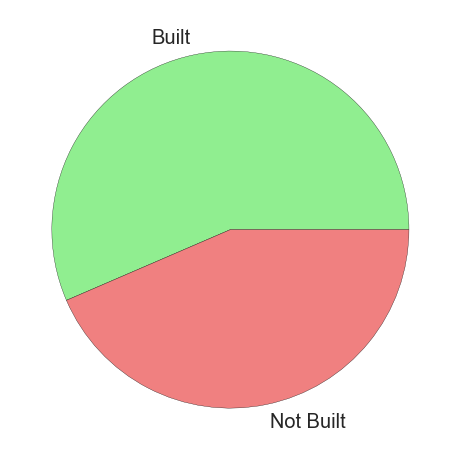

In [59]:
full_pier.plot(kind='pie', figsize=(8,8), fontsize=20, colors=('lightgreen', 'lightcoral')) # title='August 2013 Newly Permitted Construction')

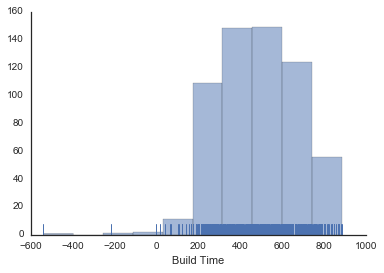

In [44]:
sns.set_style('white')
sns.distplot(permits_2014_partial['Build Time'][permits_2014_partial['Build Time'].notnull()].map(lambda t: t.days),
             bins=10,
             kde=False,
             rug=True,
             hist_kws={'alpha': 0.5},
            )
sns.despine()